Weather and production information is merged and converted to a wide format beforehand in Python. Hours 0, 1, 2, 3, 4, 5, 18, 19, 20, 21, 22, 23 are discarded since their mean production is below 5% of the overall mean. These hours will be predicted as 0 in the forecasting phase. Therefore, we will not build models for these hours.

In [2]:
library(RcppRoll)
library(zoo)
library(scales)
library(corrplot)
library(dplyr)
library(ggcorrplot)
library(GGally)
library(lubridate)
library(forecast)
library(tidyr)
library(data.table)
library(dplyr)
library(ggplot2)
library(stats)
library(fpp)
library(data.table)
library(data.table)
library(lubridate)
library(forecast)
library(repr)


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


corrplot 0.92 loaded


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following objects are masked from 'package:zoo':

   

#### Since we will make predictions starting from 15th May, data up to 14th April can be used for training.

In [3]:
options(repr.plot.width=12.7, repr.plot.height=8.5)

data_path <- 'filtered_data.csv'

data <- fread(data_path)
colnames(data) <- tolower(colnames(data))
data[, production_target := NULL]
data[, datetime := NULL]
data <- na.omit(data)
tail(data)
str(data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_34.75,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-04-14,12,0,0,0,0,0,0,0,0,⋯,219.056,321.360,236.544,498.864,194.400,212.176,247.760,375.680,485.568,7.88
2024-04-14,13,0,0,0,0,0,0,0,0,⋯,214.192,349.440,274.432,510.448,196.688,210.064,268.928,442.400,520.048,6.40
2024-04-14,14,0,0,0,0,0,0,0,0,⋯,209.904,369.168,273.872,474.736,208.512,206.912,270.208,445.296,526.720,3.14
2024-04-14,15,0,0,0,0,0,0,0,0,⋯,204.960,339.968,266.224,482.288,219.952,203.744,257.616,448.160,547.184,3.67
2024-04-14,16,0,0,0,0,0,0,0,0,⋯,173.776,185.760,227.872,453.472,317.200,177.584,226.624,459.632,574.400,3.24
2024-04-14,17,0,0,0,0,0,0,0,0,⋯,163.504,170.432,222.640,374.880,274.288,173.712,204.720,392.576,465.680,0.71


Classes 'data.table' and 'data.frame':	10016 obs. of  253 variables:
 $ date                               : IDate, format: "2022-01-01" "2022-01-01" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.0           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_sur

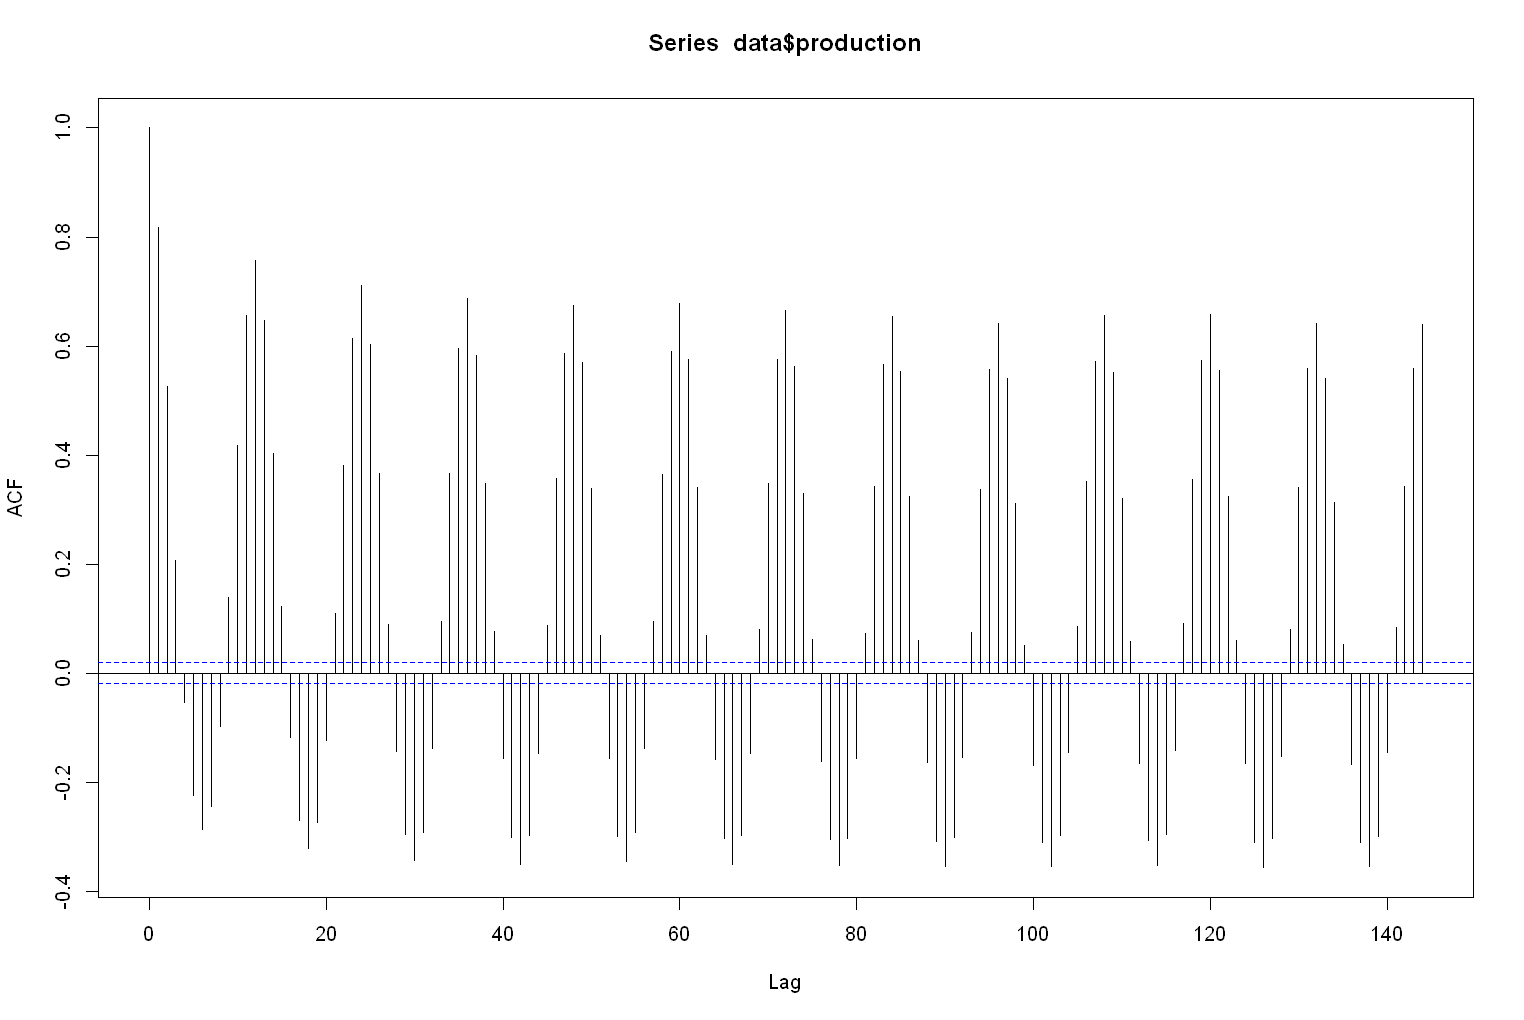

In [3]:
acf(data$production, lag.max=144)

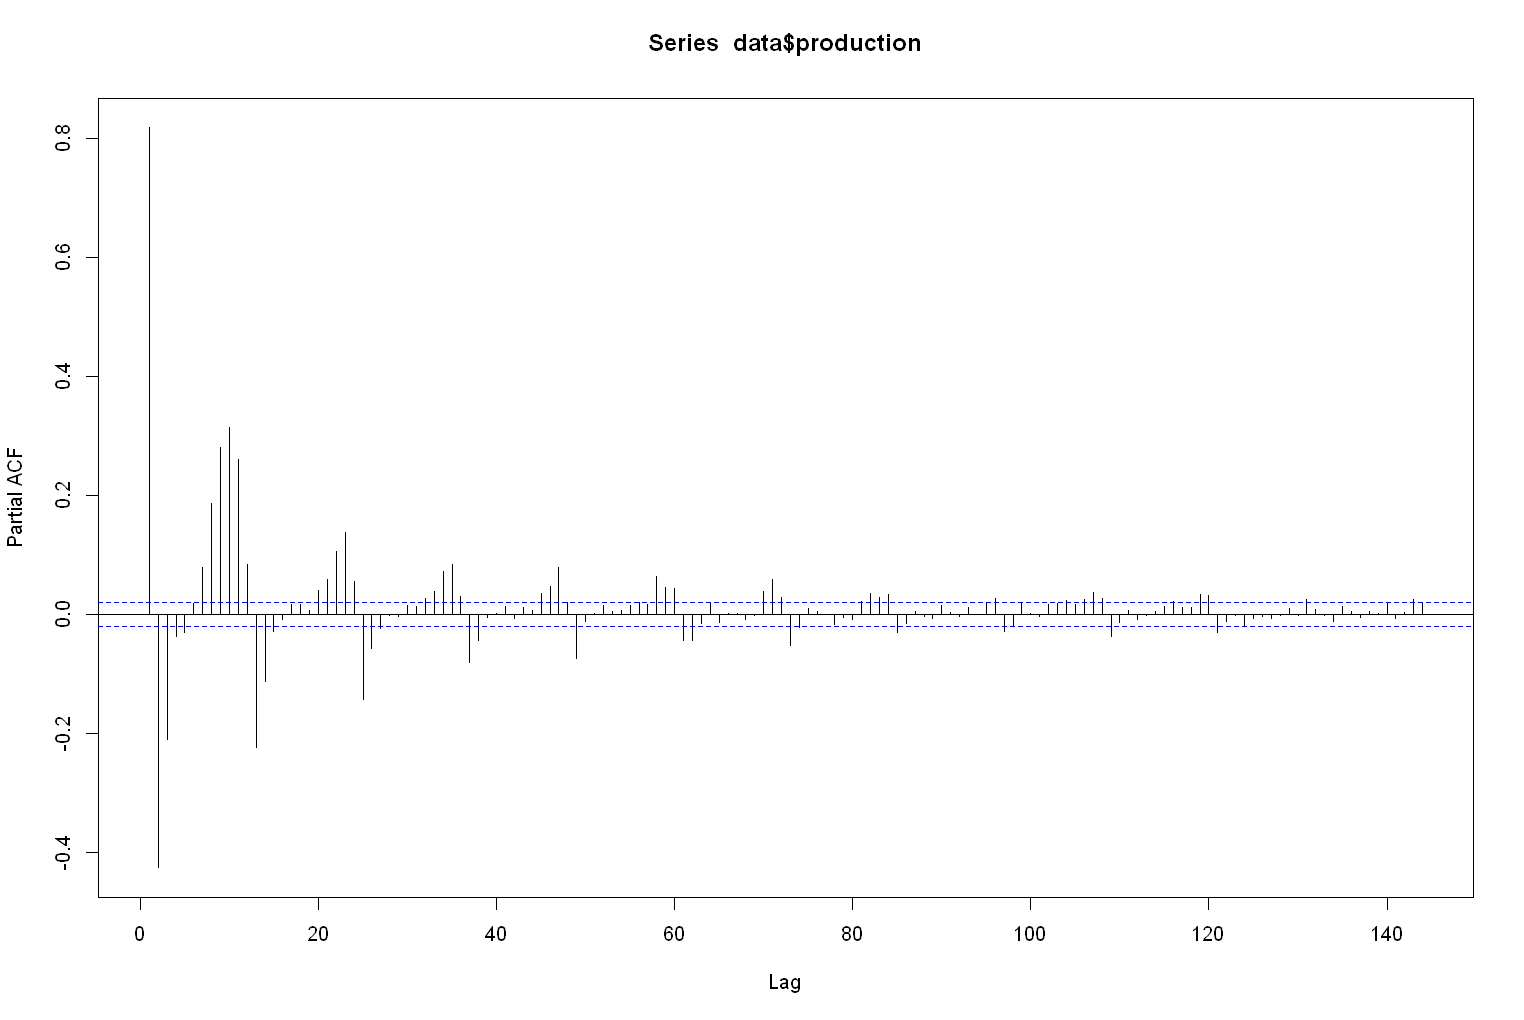

In [4]:
pacf(data$production, lag.max=144)

In [4]:
cutoff_date <- as.IDate("2024-01-30")

train_data <- data[date <= cutoff_date]

tail(train_data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_34.75,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-01-30,12,0,0,0,1,0,0,0,0,⋯,158.620,169.480,174.920,313.040,130.400,130.400,137.160,151.120,162.100,9.20
2024-01-30,13,0,0,0,1,0,0,0,0,⋯,174.360,173.040,176.840,338.820,151.320,152.320,161.620,176.140,184.040,7.49
2024-01-30,14,0,0,1,1,0,0,0,0,⋯,168.496,169.408,174.592,351.152,158.416,157.776,163.056,172.592,176.944,3.57
2024-01-30,15,0,0,1,1,0,0,0,0,⋯,173.056,174.848,182.496,355.776,157.728,158.608,164.464,171.568,173.152,1.25
2024-01-30,16,0,0,1,1,0,0,0,0,⋯,195.120,187.008,194.688,312.080,161.280,174.432,183.104,179.136,167.808,0.21
2024-01-30,17,0,0,1,1,0,0,0,0,⋯,172.832,163.584,170.736,260.768,154.992,161.392,159.168,155.040,142.784,0.00


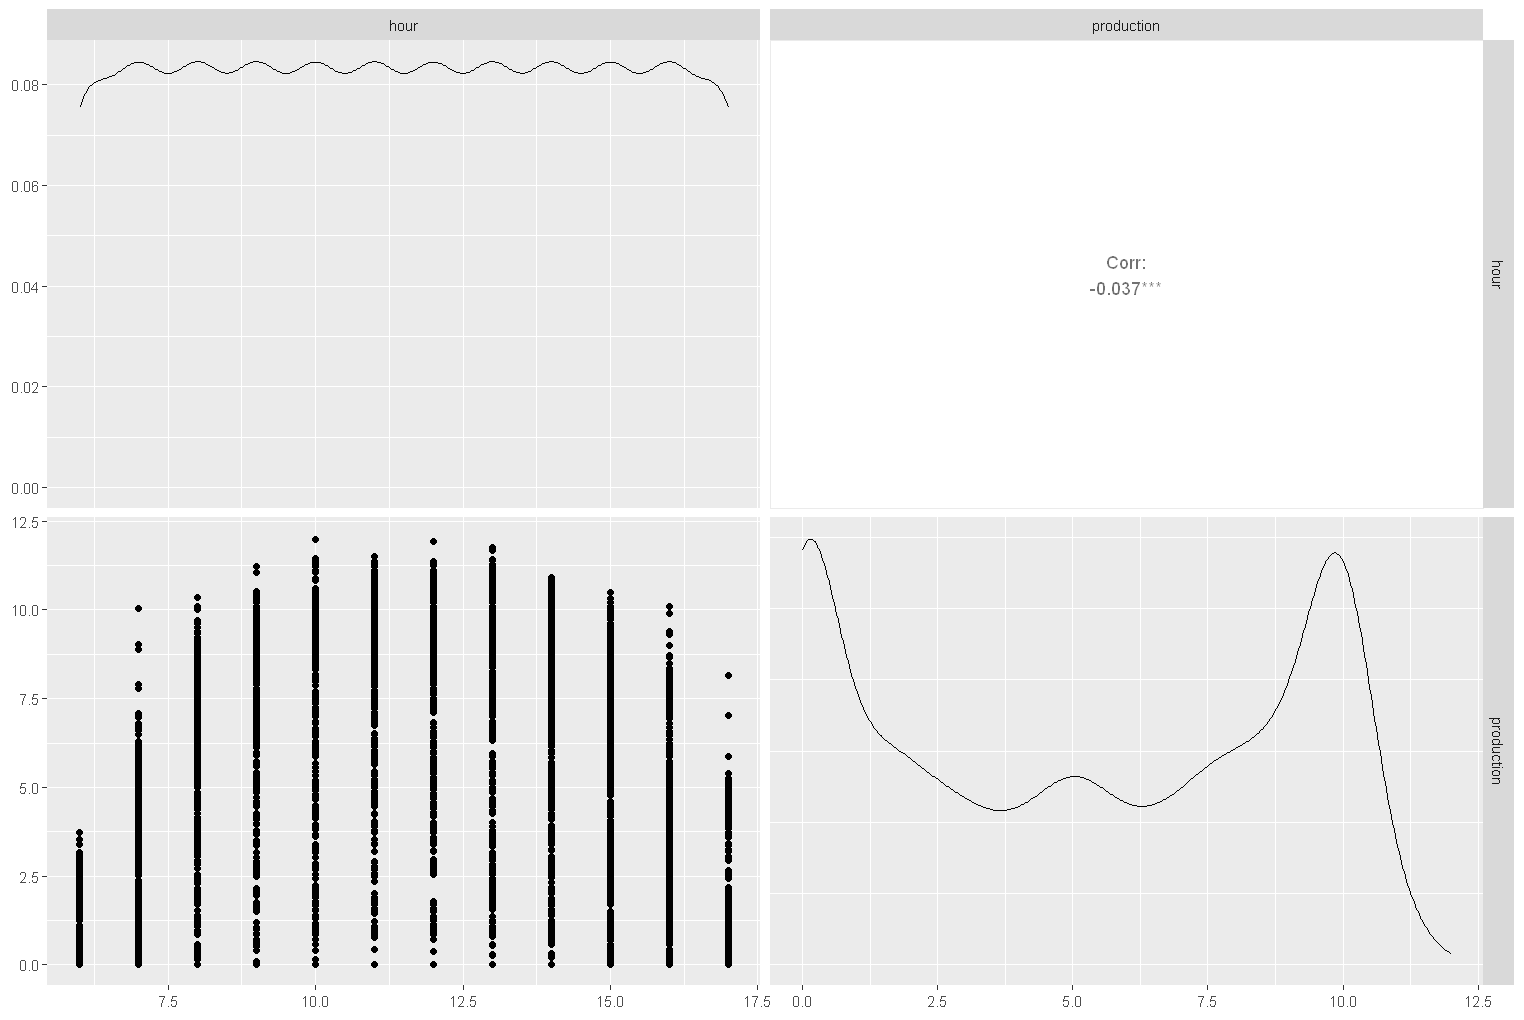

In [4]:
hour_and_prod <- c("hour", "production")
filtered_data_h_vs_prod <- train_data[, ..hour_and_prod, drop = FALSE]

ggpairs(filtered_data_h_vs_prod)

Since hour has a nonlinear relationship with production, we transform it to -(hour-12)^2 (the equation of the parabolic shape) and use as a regressor. By doing so, we ensure that the hour column will have maximum values when hour is close to 12.

In [5]:
train_data[, hour_transformed := -(hour - 12)^2]

Now, we will add average temperature and lagged values of it as variables. That is because, the effect of temperature may not be instanteneous in real time.

In [6]:
train_data <- as.data.frame(train_data)

tmp_surface_columns <- grep("^tmp_surface", names(train_data), value = TRUE)

# Compute the average of these columns for each row
train_data$avg_tmp <- rowMeans(train_data[, tmp_surface_columns], na.rm = TRUE)

setDT(train_data)
train_data[, avg_temp_lag_1 := shift(avg_tmp, 1)]
train_data[, avg_temp_lag_2 := shift(avg_tmp, 2)]
train_data[, avg_temp_lag_3 := shift(avg_tmp, 3)]

head(train_data)
str(train_data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,hour_transformed,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-01-01,6,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.00,-36,269.035,NA,NA,NA
2022-01-01,7,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.00,-25,269.001,269.035,NA,NA
2022-01-01,8,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,3.40,-16,269.002,269.001,269.035,NA
2022-01-01,9,0,0,0,0,0,0,0,0,⋯,8.096,8.592,8.848,8.704,6.80,-9,271.634,269.002,269.001,269.035
2022-01-01,10,0,0,0,0,0,0,0,0,⋯,105.264,120.656,137.664,142.336,9.38,-4,275.786,271.634,269.002,269.001
2022-01-01,11,0,0,0,0,0,0,0,0,⋯,127.472,130.512,142.112,147.088,7.65,-1,278.553,275.786,271.634,269.002


Classes 'data.table' and 'data.frame':	9116 obs. of  258 variables:
 $ date                               : IDate, format: "2022-01-01" "2022-01-01" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.0           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surf

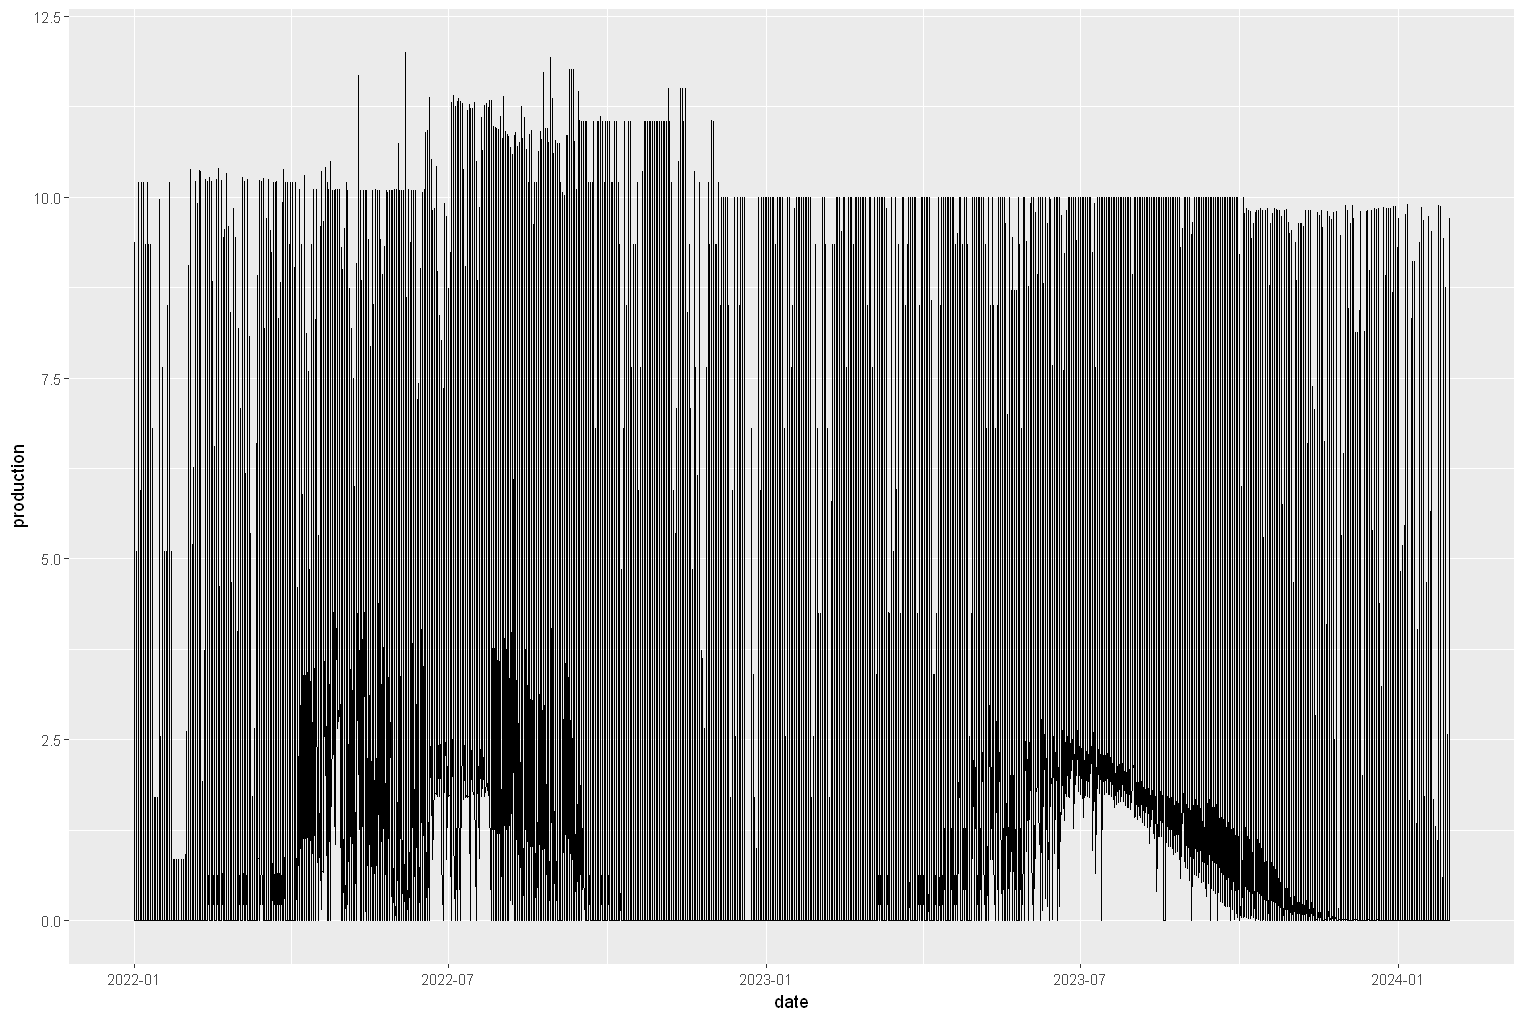

In [7]:
require(ggplot2)

ggplot(train_data, aes(x = date, y = production)) + geom_line()

From the ggplot, we acknowledge that there is a maximum production level around 10 generally. Therefore, we also add another variable for maximum production, which will include the max production level for the last 3 days.

In [7]:
train_data$max_production <- sapply(1:nrow(train_data), function(i) {
  max_production <- ifelse(i <= 36, max(train_data$production[1:i]), max(train_data$production[(i - 35):i]))
  return(max_production)
})

head(train_data)
str(train_data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,hour_transformed,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,max_production
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-01-01,6,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.00,-36,269.035,NA,NA,NA,0.00
2022-01-01,7,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.00,-25,269.001,269.035,NA,NA,0.00
2022-01-01,8,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,3.40,-16,269.002,269.001,269.035,NA,3.40
2022-01-01,9,0,0,0,0,0,0,0,0,⋯,8.592,8.848,8.704,6.80,-9,271.634,269.002,269.001,269.035,6.80
2022-01-01,10,0,0,0,0,0,0,0,0,⋯,120.656,137.664,142.336,9.38,-4,275.786,271.634,269.002,269.001,9.38
2022-01-01,11,0,0,0,0,0,0,0,0,⋯,130.512,142.112,147.088,7.65,-1,278.553,275.786,271.634,269.002,9.38


Classes 'data.table' and 'data.frame':	9116 obs. of  259 variables:
 $ date                               : IDate, format: "2022-01-01" "2022-01-01" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.0           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surf

Import and prepare test data from February 1st to May 15th

In [8]:
data_path <- 'new_data_16may.csv'

test_data <- fread(data_path)
colnames(test_data) <- tolower(colnames(test_data))

cutoff_date <- as.IDate("2024-01-30")
test_data <- test_data[date > cutoff_date]

test_data <- na.omit(test_data)
test_data[, hour_transformed := -(hour - 12)^2]
test_data <- as.data.frame(test_data)

test_data$max_production <- sapply(1:nrow(test_data), function(i) {
  max_production <- ifelse(i <= 36, max(test_data$production[1:i]), max(test_data$production[(i - 35):i]))
  return(max_production)
})

tmp_surface_columns <- grep("^tmp_surface", names(test_data), value = TRUE)

# Compute the average of these columns for each row
test_data$avg_tmp <- rowMeans(test_data[, tmp_surface_columns], na.rm = TRUE)

setDT(test_data)
test_data[, avg_temp_lag_1 := shift(avg_tmp, 1)]
test_data[, avg_temp_lag_2 := shift(avg_tmp, 2)]
test_data[, avg_temp_lag_3 := shift(avg_tmp, 3)]


head(test_data)
str(test_data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,hour_transformed,max_production,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-01-31,6,0,0,0,1,0,0,0,0,⋯,0.000,0.000,0.000,0.01,-36,0.01,268.541,NA,NA,NA
2024-01-31,7,0,0,0,1,0,0,0,0,⋯,0.000,0.000,0.000,0.79,-25,0.79,268.478,268.541,NA,NA
2024-01-31,8,0,0,0,1,1,0,0,0,⋯,0.176,0.208,0.256,5.60,-16,5.60,268.843,268.478,268.541,NA
2024-01-31,9,0,0,0,1,1,0,0,0,⋯,9.952,10.704,9.728,8.86,-9,8.86,271.236,268.843,268.478,268.541
2024-01-31,10,0,0,1,1,1,0,0,0,⋯,130.120,123.900,102.560,9.89,-4,9.89,274.211,271.236,268.843,268.478
2024-01-31,11,0,0,1,1,1,0,0,0,⋯,164.500,135.880,114.740,9.85,-1,9.89,276.570,274.211,271.236,268.843


Classes 'data.table' and 'data.frame':	1272 obs. of  259 variables:
 $ date                               : IDate, format: "2024-01-31" "2024-01-31" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 1 1 ...
 $ csnow_surface_37.75_35.0           : num  0 0 0 0 1 1 1 1 1 1 ...
 $ csnow_surface_37.75_35.25          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ csnow_surface_37.75_35.5           : num  0 0 1 1 1 1 1 1 1 1 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 1 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 1 1 1 1 1 1 1 ...
 $ csnow_surface_38.0_35.5            : num  0 0 1 1 1 1 1 1 1 1 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surf

In [10]:
#reporting accuracy
accu=function(name,actual,forecast){
  model = name
  n=length(actual)
  error=actual-forecast
  mean=mean(actual)
  sd=sd(actual)
  CV=sd/mean
  FBias=sum(error)/sum(actual)
  MAPE=sum(abs(error/(actual+0.00001)))/n
  RMSE=sqrt(sum(error^2)/n)
  MAD=sum(abs(error))/n
  MADP=sum(abs(error))/sum(abs(actual))
  WMAPE=MAD/mean
  l=data.frame(model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE)
  return(l)
}

# Baseline : Time Series Regression with All Variables

We will build a time series linear regression model using all variables. This model will be our baseline. In the test phase, we will replace negative predicted values with zero, since production cannot be negative.

In [11]:
train_data <- as.data.frame(train_data)
feature_columns <- setdiff(names(train_data), c('date', 'hour', 'production','avg_tmp'))

X <- train_data[, feature_columns, drop = FALSE]
y <- train_data$production

model <- lm(production ~ ., data = train_data[, c(feature_columns, "production")])

summary(model)


Call:
lm(formula = production ~ ., data = train_data[, c(feature_columns, 
    "production")])

Residuals:
    Min      1Q  Median      3Q     Max 
-9.0491 -1.2017  0.1399  1.3061  7.8945 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -2.540e+01  2.064e+00 -12.303  < 2e-16 ***
csnow_surface_37.75_34.5             1.123e-01  1.861e-01   0.603 0.546341    
csnow_surface_37.75_34.75            3.871e-03  1.615e-01   0.024 0.980874    
csnow_surface_37.75_35.0            -1.464e-02  1.398e-01  -0.105 0.916611    
csnow_surface_37.75_35.25           -1.050e-01  1.185e-01  -0.886 0.375709    
csnow_surface_37.75_35.5             2.874e-01  1.650e-01   1.742 0.081603 .  
csnow_surface_38.0_34.5             -5.720e-01  1.574e-01  -3.635 0.000280 ***
csnow_surface_38.0_34.75            -9.924e-03  1.838e-01  -0.054 0.956948    
csnow_surface_38.0_35.0              3.194e-01  1.630e-01   1.959 0.050148 .  
csnow

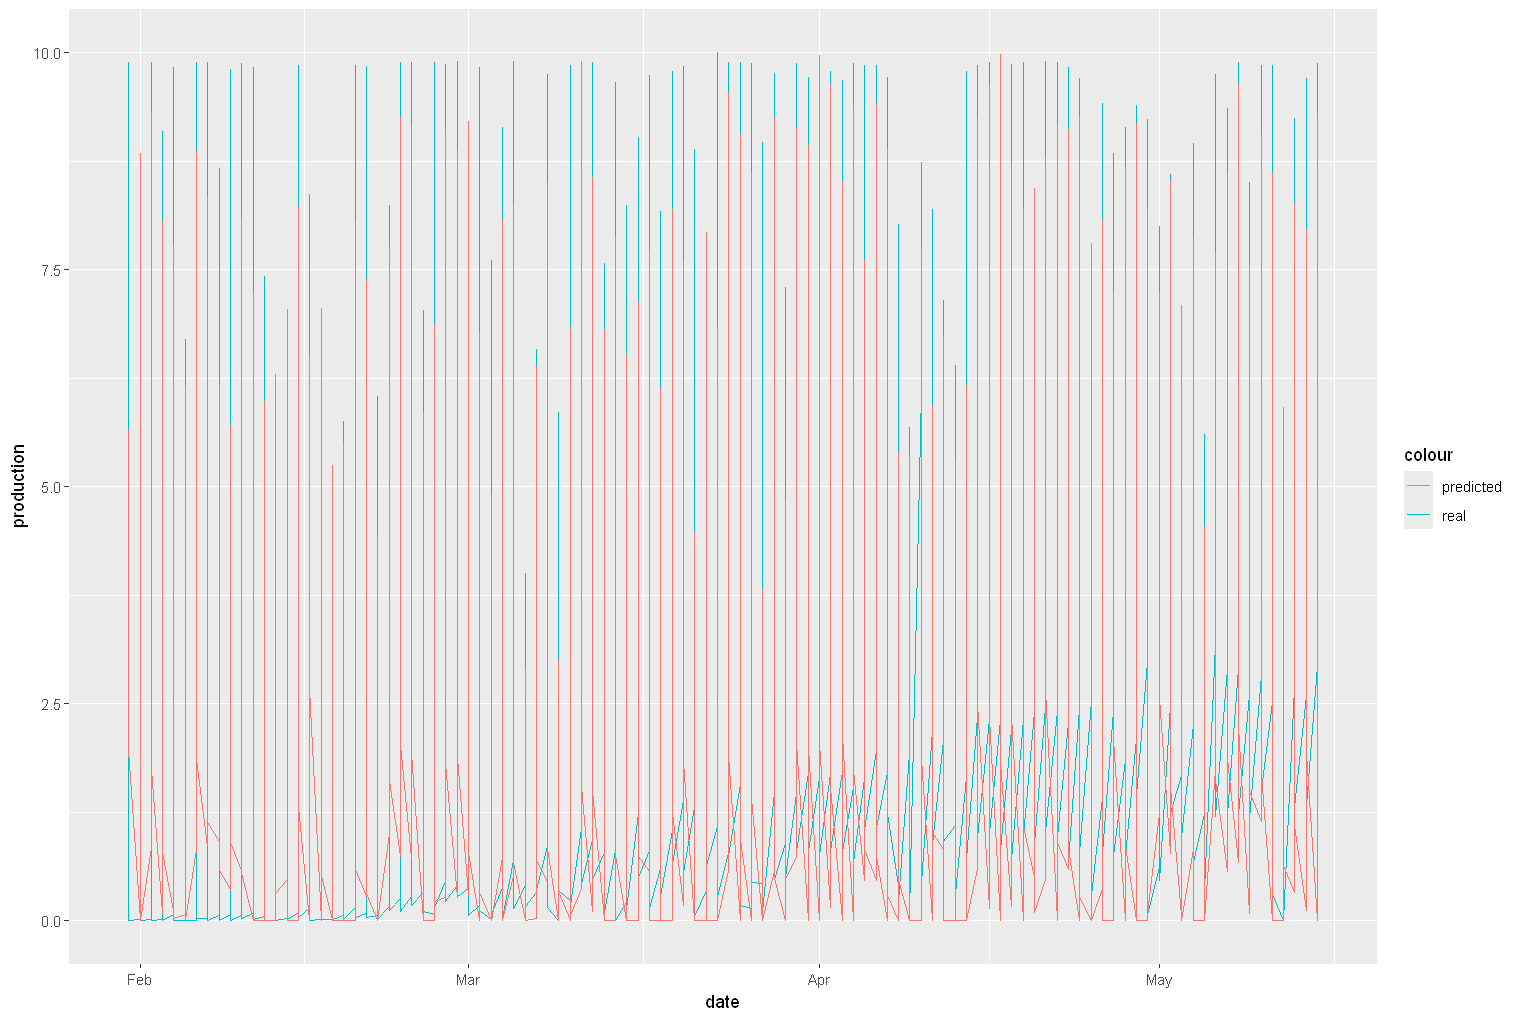


	Ljung-Box test

data:  Residuals
Q* = 675.43, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



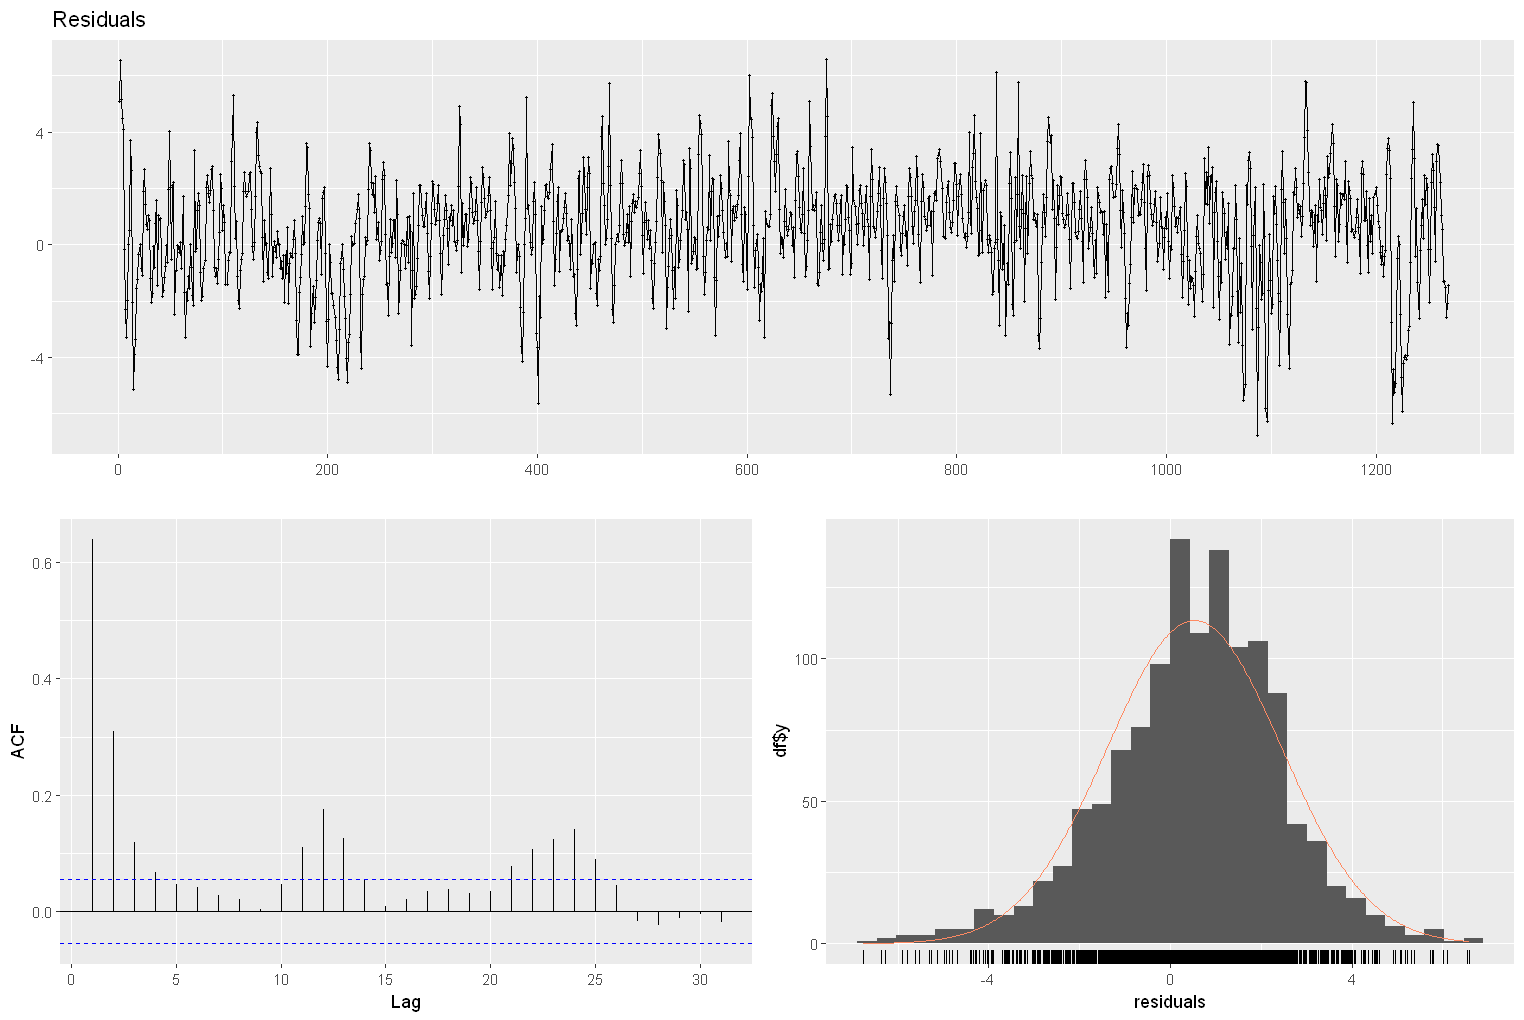

In [12]:
test_data <- as.data.frame(test_data)
baseline_evaluation <- copy(test_data)
baseline_evaluation <- na.omit(baseline_evaluation)
setDT(baseline_evaluation)
baseline_evaluation[,predicted:=predict(model,baseline_evaluation)]

# Replace negative values with zero
baseline_evaluation[, predicted := ifelse(predicted < 0, 0, predicted)]
baseline_evaluation[,residual:=production-predicted]

ggplot(baseline_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))
checkresiduals(baseline_evaluation$residual)

In [13]:
comparisons <- accu("0. Baseline-LM", baseline_evaluation$production, baseline_evaluation$predicted)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.38983,0.6699049,0.1048255,4469.314,1.993499,1.564115,0.3091036,0.3091036


## Lasso Regression for Eliminating Least Effective Variables

Loading required package: Matrix




Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



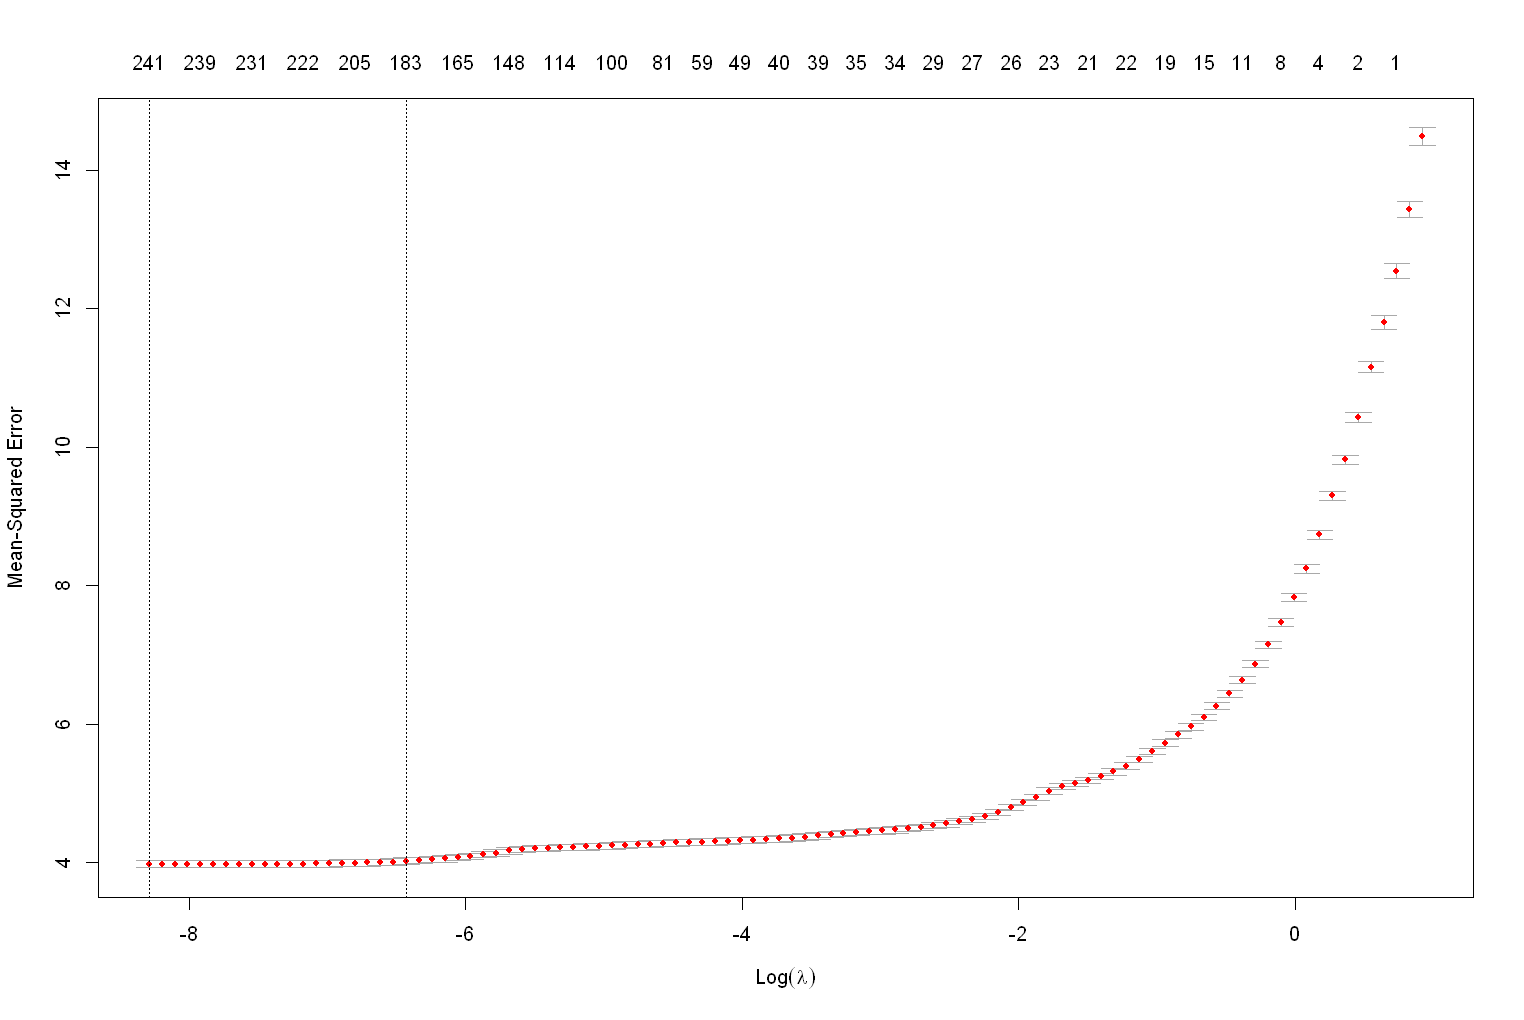

In [9]:
library(glmnet)

llm <- copy(train_data)
llm <- na.omit(llm)
setDT(llm)

# Define the columns -rather than hour, production, and date- to standardize
columns_to_standardize <- setdiff(names(llm), c("hour", "production", "date"))

# Standardize the columns
llm[, (columns_to_standardize) := lapply(.SD, scale), .SDcols = columns_to_standardize]

llm <- as.data.frame(llm)

predictors <- subset(llm, select = -c(date, production, hour))
response <- llm$production


# Perform cross-validation to find the optimal lambda value
cv_fit <- cv.glmnet(as.matrix(predictors), response, alpha = 1)

# Plot the cross-validated mean squared error (MSE) vs. lambda
plot(cv_fit)


The minimum MSE is found when model complexity is the highest. Therefore, we will use the lambda that is within one standard deviation of the minimum MSE.

In [10]:
# Find the lambda value within one standard error of the minimum MSE
lambda_1se <- cv_fit$lambda.1se

# Use the selected lambda value to fit the final Lasso regression model
lasso_model_1 <- glmnet(as.matrix(predictors), response, alpha = 1, lambda = lambda_1se)

print(lasso_model_1)

coefficients <- coef(lasso_model_1, s = lambda_1se <- cv_fit$lambda.1se)
coefficients <- as.matrix(coef(lasso_model_1, s = lambda_1se))

selected_variables <- rownames(coefficients)[coefficients[, 1] != 0]

print(selected_variables)


Call:  glmnet(x = as.matrix(predictors), y = response, alpha = 1, lambda = lambda_1se) 

   Df  %Dev   Lambda
1 194 73.77 0.001617
  [1] "(Intercept)"                        
  [2] "csnow_surface_37.75_34.5"           
  [3] "csnow_surface_37.75_35.25"          
  [4] "csnow_surface_37.75_35.5"           
  [5] "csnow_surface_38.0_34.5"            
  [6] "csnow_surface_38.0_34.75"           
  [7] "csnow_surface_38.0_35.0"            
  [8] "csnow_surface_38.0_35.25"           
  [9] "csnow_surface_38.0_35.5"            
 [10] "csnow_surface_38.25_34.5"           
 [11] "csnow_surface_38.25_34.75"          
 [12] "csnow_surface_38.25_35.0"           
 [13] "csnow_surface_38.25_35.25"          
 [14] "csnow_surface_38.25_35.5"           
 [15] "csnow_surface_38.5_34.5"            
 [16] "csnow_surface_38.5_34.75"           
 [17] "csnow_surface_38.5_35.0"            
 [18] "csnow_surface_38.5_35.25"           
 [19] "csnow_surface_38.5_35.5"            
 [20] "csnow_surface_38.75_34.5"

Filter the data frame by keeping only the variables that Lasso Regression selected

In [11]:
selected_variables <- selected_variables[selected_variables != "(Intercept)"]

columns_to_keep <- c("date", "hour", "production", selected_variables)

train_data <- as.data.frame(train_data)

filtered_data <- train_data[, columns_to_keep, drop = FALSE]

head(filtered_data)
str(filtered_data)

,date,hour,production,csnow_surface_37.75_34.5,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,csnow_surface_38.0_35.25,⋯,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,hour_transformed,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,max_production
,<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022-01-01,6,0.00,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-36,NA,NA,NA,0.00
2,2022-01-01,7,0.00,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-25,269.035,NA,NA,0.00
3,2022-01-01,8,3.40,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-16,269.001,269.035,NA,3.40
4,2022-01-01,9,6.80,0,0,0,0,0,0,0,⋯,8.704,12.080,7.536,8.848,8.704,-9,269.002,269.001,269.035,6.80
5,2022-01-01,10,9.38,0,0,0,0,0,0,0,⋯,120.864,199.200,104.464,137.664,142.336,-4,271.634,269.002,269.001,9.38
6,2022-01-01,11,7.65,0,0,0,0,0,0,0,⋯,123.584,234.032,140.640,142.112,147.088,-1,275.786,271.634,269.002,9.38


'data.frame':	9116 obs. of  197 variables:
 $ date                               : IDate, format: "2022-01-01" "2022-01-01" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ production                         : num  0 0 3.4 6.8 9.38 7.65 6.8 5.1 5.1 1.7 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.

## First Approach : Linear Regression with Lasso Variables + Transformed Hour

In [11]:
feature_columns <- setdiff(names(filtered_data), c('date', 'hour', 'production'))

X <- filtered_data[, feature_columns, drop = FALSE]
y <- filtered_data$production

model <- lm(production ~ ., data = filtered_data[, c(feature_columns, "production")])

summary(model)


Call:
lm(formula = production ~ ., data = filtered_data[, c(feature_columns, 
    "production")])

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9074 -1.1810  0.1472  1.3248  7.6410 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -2.571e+01  1.950e+00 -13.183  < 2e-16 ***
csnow_surface_37.75_34.5             1.607e-01  1.797e-01   0.895 0.371012    
csnow_surface_37.75_35.25           -8.094e-02  1.122e-01  -0.721 0.470886    
csnow_surface_37.75_35.5             2.414e-01  1.587e-01   1.522 0.128166    
csnow_surface_38.0_34.5             -5.187e-01  1.495e-01  -3.470 0.000523 ***
csnow_surface_38.0_34.75            -1.267e-01  1.765e-01  -0.718 0.472720    
csnow_surface_38.0_35.0              3.028e-01  1.552e-01   1.950 0.051172 .  
csnow_surface_38.0_35.25            -1.315e-01  1.315e-01  -1.000 0.317420    
csnow_surface_38.0_35.5              1.071e-01  1.481e-01   0.723 0.469897    
cs

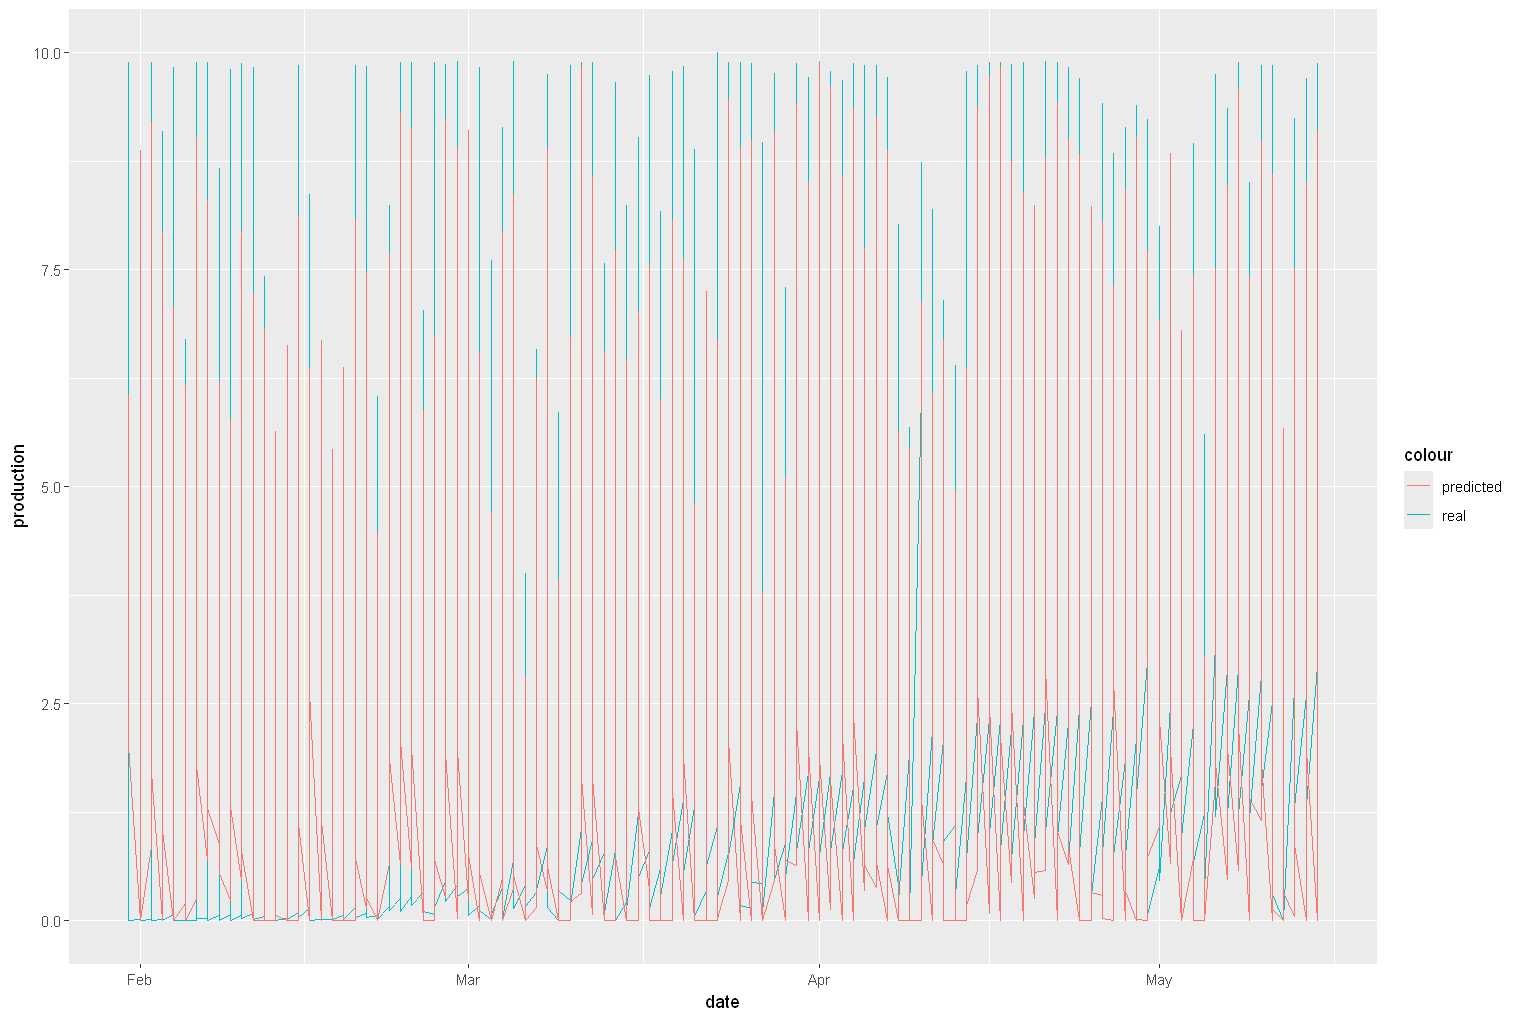


	Ljung-Box test

data:  Residuals
Q* = 650.1, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



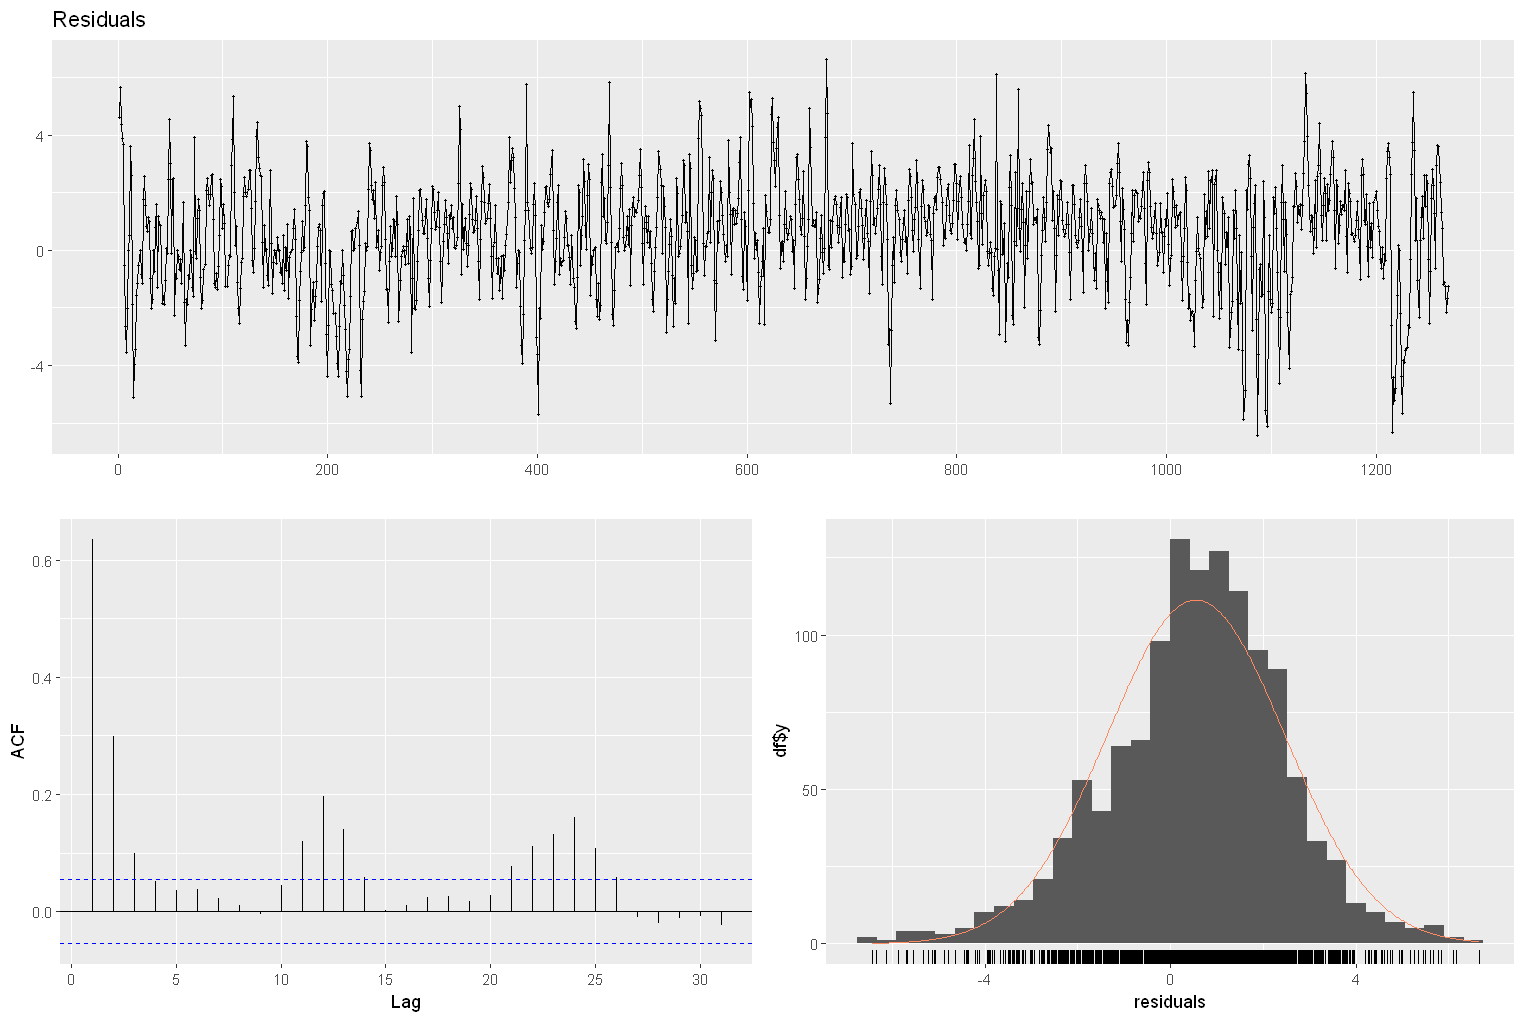

In [18]:
test_data <- as.data.frame(test_data)
first_model_evaluation <- test_data[, columns_to_keep, drop = FALSE]
first_model_evaluation <- na.omit(first_model_evaluation)
setDT(first_model_evaluation)

first_model_evaluation[,predicted:=predict(model,first_model_evaluation)]
# Replace negative values with zero
first_model_evaluation[, predicted := ifelse(predicted < 0, 0, predicted)]
first_model_evaluation[,residual:=production-predicted]

ggplot(first_model_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))
checkresiduals(first_model_evaluation$residual)

Although residual series look like white noise, ACF of residuals has a seasonal pattern which indicates there is a seasonality information that is not explained. The histogram look like a normal distribution but indicates that we are underpredicting. The underprediction pattern can be also seen from the predicted vs real ggplot.

In [19]:
accu1 <- accu("1. Lasso(1sd)-LM", first_model_evaluation$production, first_model_evaluation$predicted)
comparisons <- rbind(comparisons, accu1)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.38983,0.6699049,0.1048255,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.38983,0.6699049,0.1088095,4058.146,1.994581,1.573241,0.3109070,0.3109070


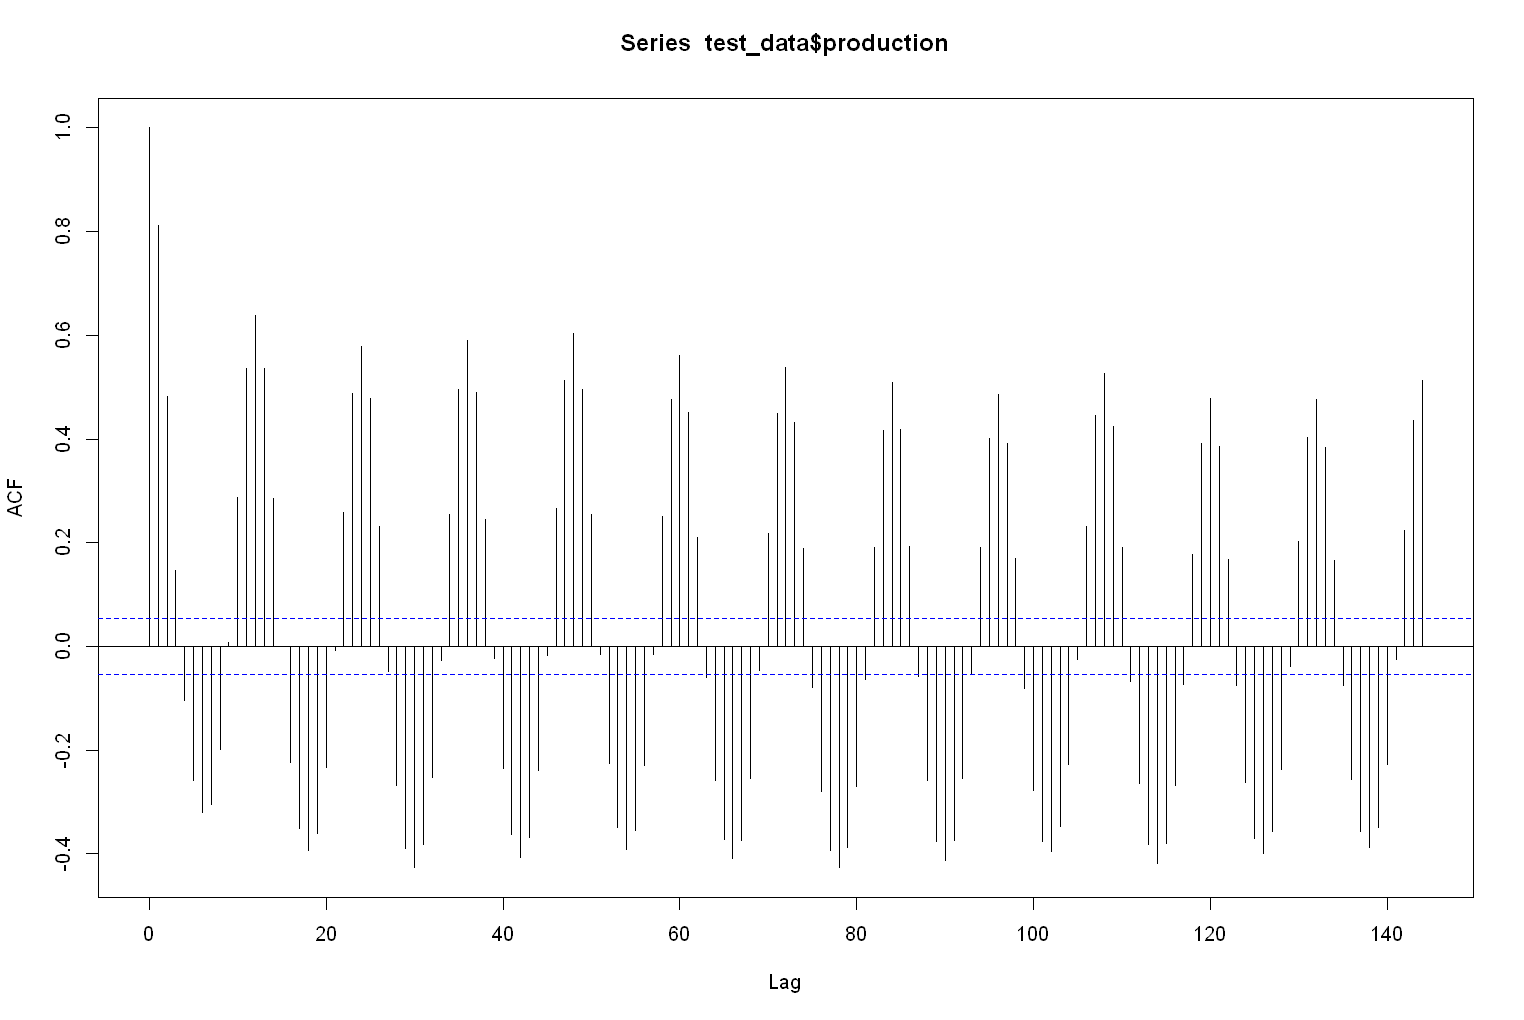

In [20]:
acf(test_data$production, lag.max=144)

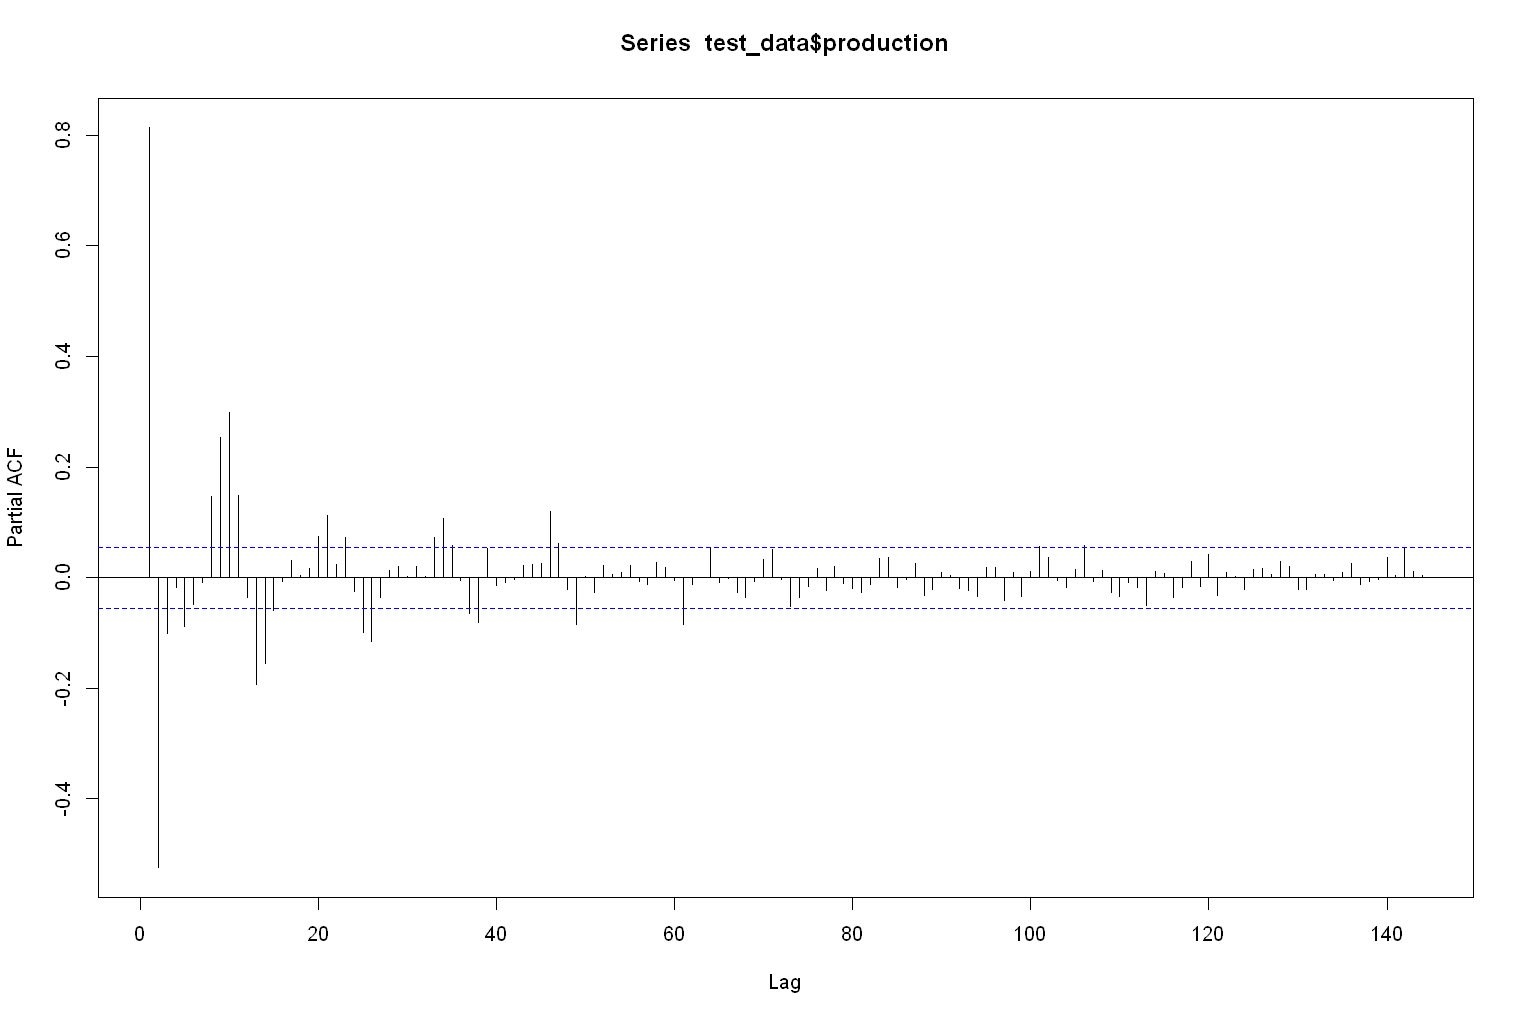

In [21]:
pacf(test_data$production, lag.max=144)

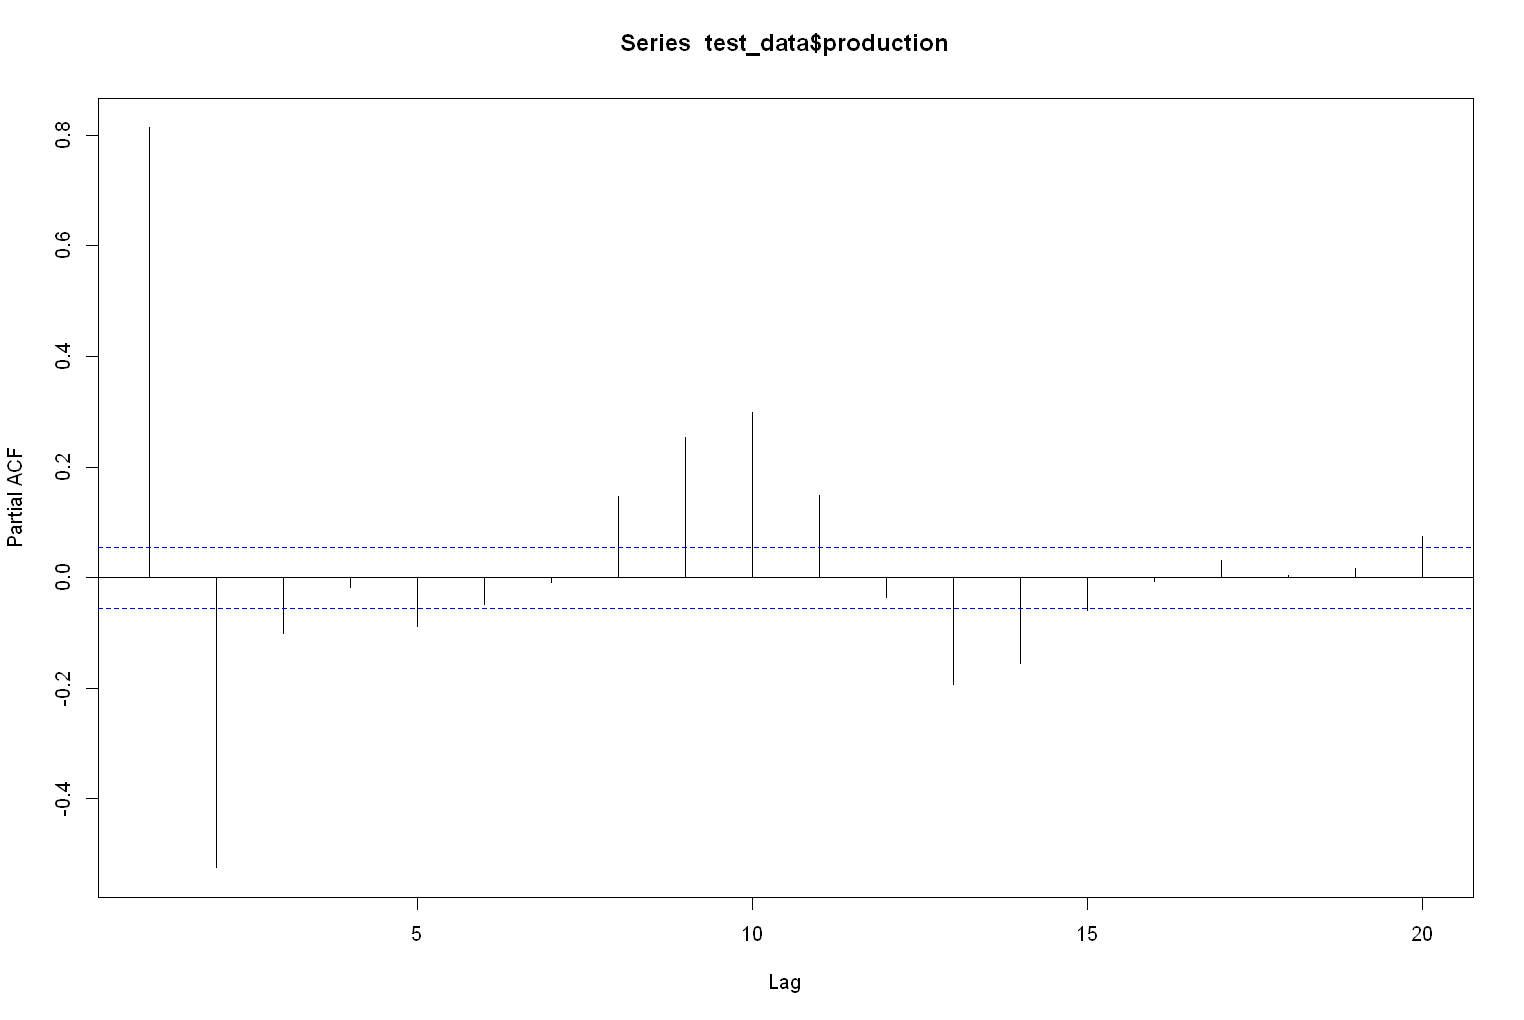

In [22]:
pacf(test_data$production, lag.max=20)

Now we will add lag 10 values since the PACF peaks at 10. Note that this new model will be impractical for our task since we do not have the lagged 10 information in the forecasting setting (Lagged 10 value for 03.01.2024 12:00 is 02.01.2024 14:00 in our setting, which we do not know yet). Still, we will build this impractical model to see if it performs well. 

## Second Approach : Linear Regression with Lasso Variables + Transformed Hour + Lag 10

In [12]:
setDT(filtered_data)
filtered_data[, prod_lag_10 := shift(production, 10)]

filtered_data = as.data.frame(filtered_data)

# Filter out the columns you want to use as features
feature_columns <- setdiff(names(filtered_data), c('date','hour','production'))

# Create the predictor matrix X and response vector y
X <- filtered_data[, feature_columns, drop = FALSE]
y <- filtered_data$production

# Fit the linear regression model
model <- lm(production ~ ., data = filtered_data[, c(feature_columns, "production")])

# Print the summary of the model
summary(model)


Call:
lm(formula = production ~ ., data = filtered_data[, c(feature_columns, 
    "production")])

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9428 -1.1738  0.1256  1.2691  7.8033 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -2.636e+01  1.935e+00 -13.622  < 2e-16 ***
csnow_surface_37.75_34.5             1.723e-01  1.778e-01   0.969 0.332579    
csnow_surface_37.75_35.25           -1.310e-01  1.107e-01  -1.183 0.236669    
csnow_surface_37.75_35.5             2.871e-01  1.581e-01   1.816 0.069389 .  
csnow_surface_38.0_34.5             -5.162e-01  1.483e-01  -3.480 0.000504 ***
csnow_surface_38.0_34.75            -1.091e-01  1.759e-01  -0.620 0.535092    
csnow_surface_38.0_35.0              2.697e-01  1.540e-01   1.752 0.079857 .  
csnow_surface_38.0_35.25            -1.193e-01  1.301e-01  -0.917 0.358962    
csnow_surface_38.0_35.5              1.039e-01  1.460e-01   0.712 0.476699    
cs

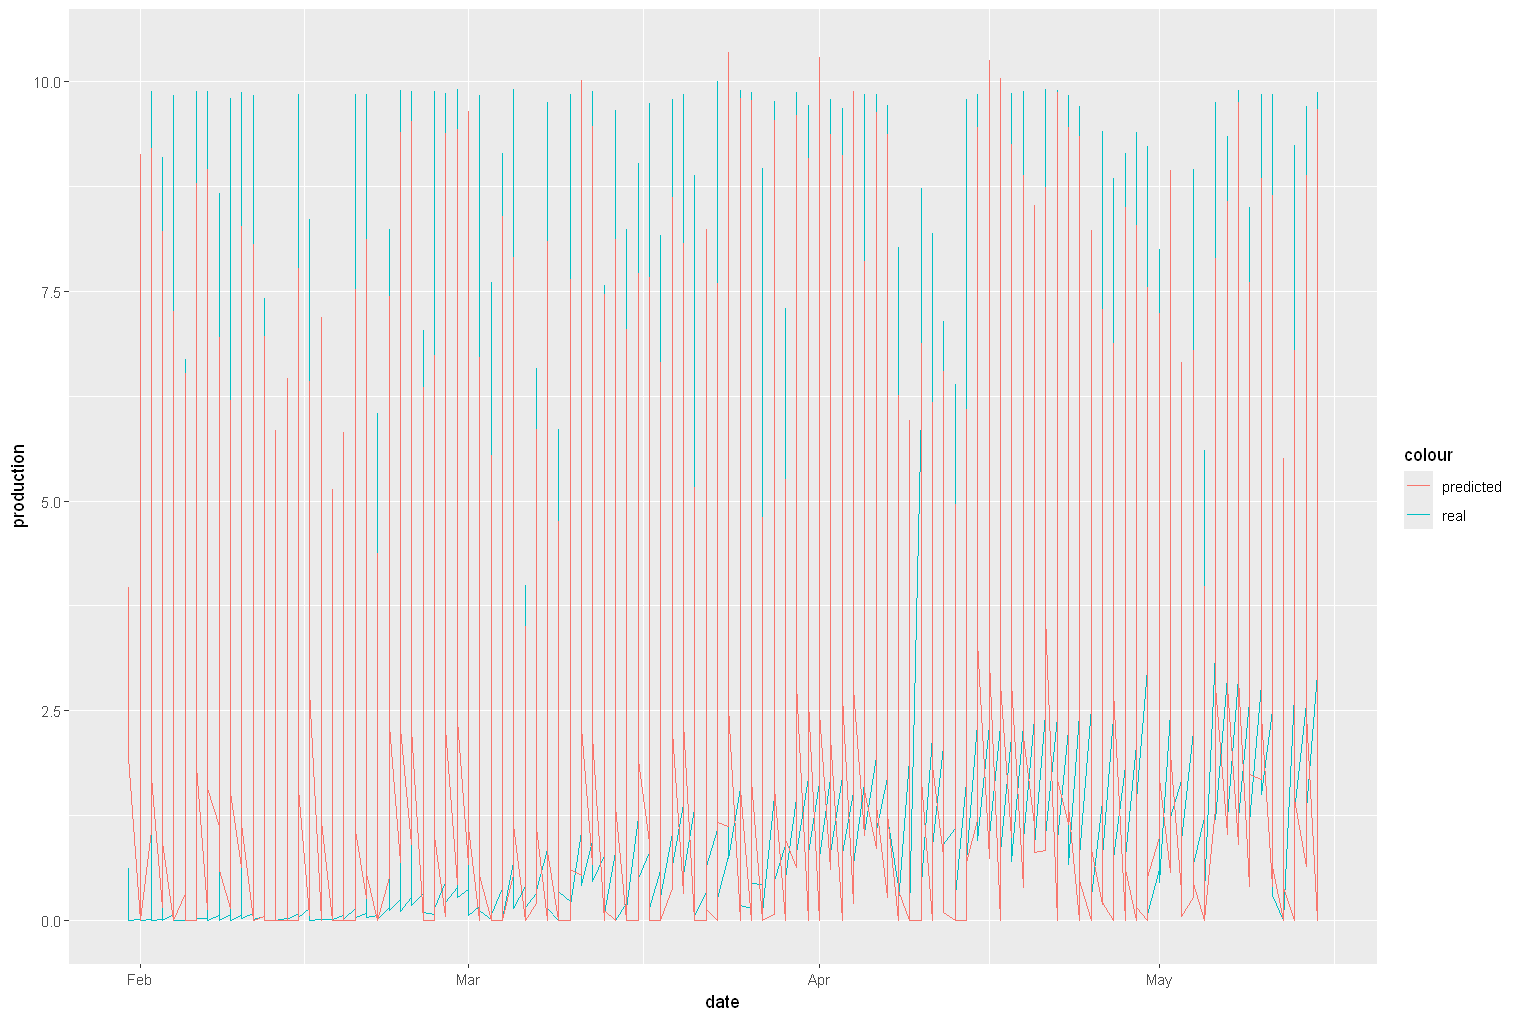


	Ljung-Box test

data:  Residuals
Q* = 597.35, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



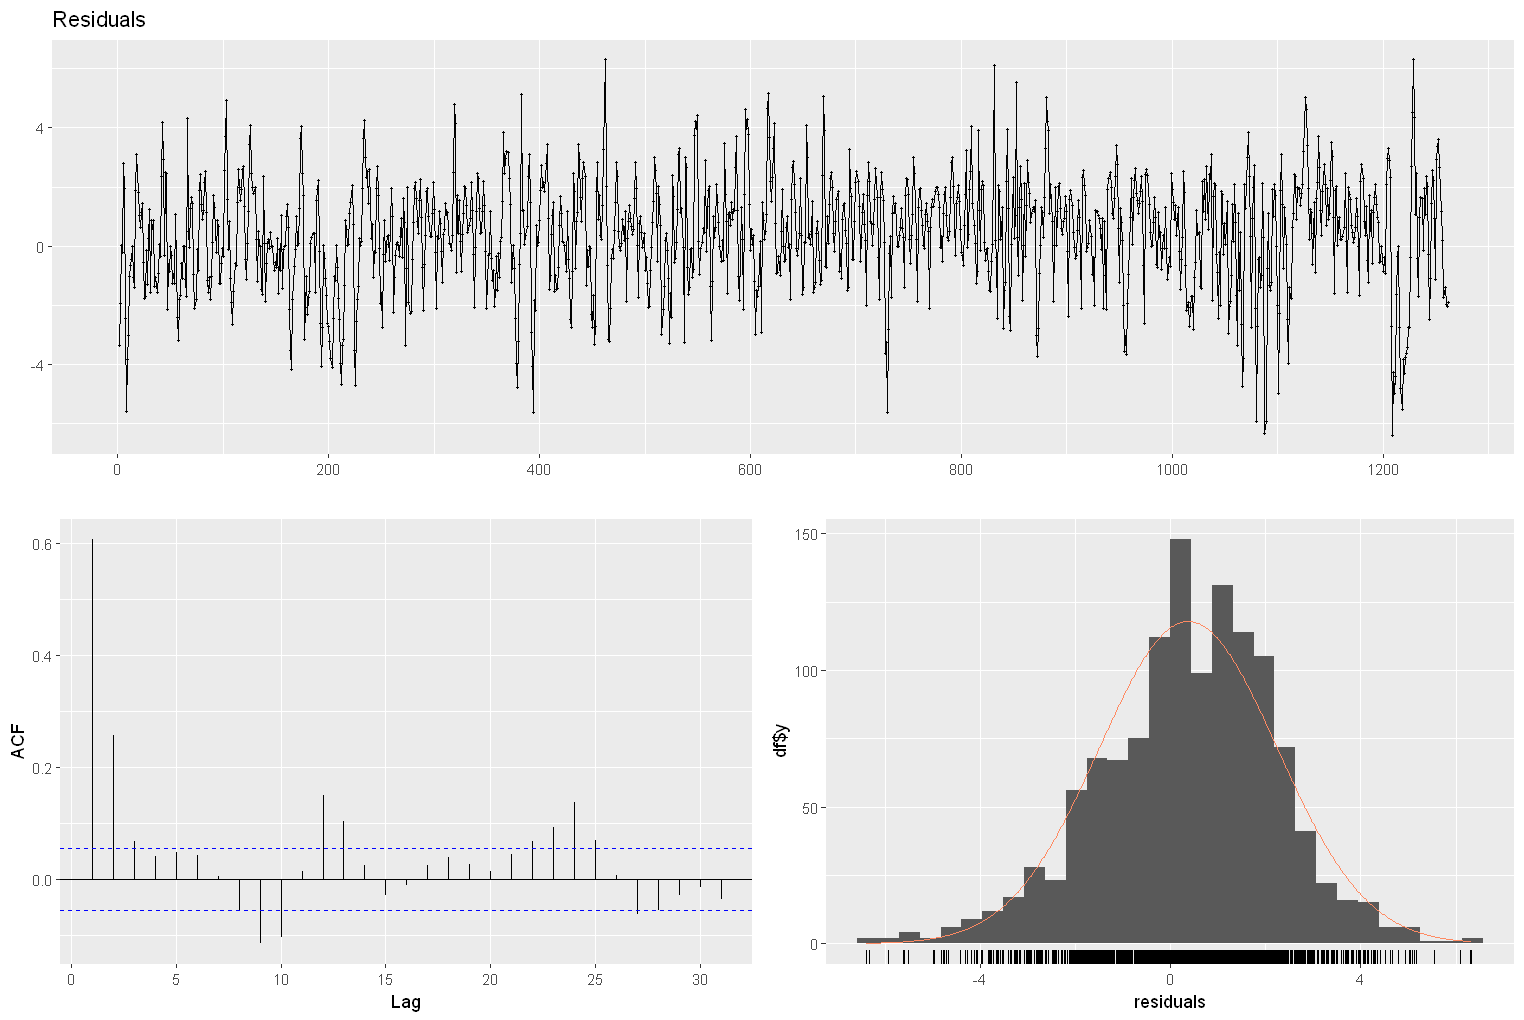

In [24]:
second_model_evaluation <- test_data[, columns_to_keep, drop = FALSE]
setDT(second_model_evaluation)
second_model_evaluation[, prod_lag_10 := shift(production, 10)]
second_model_evaluation <- na.omit(second_model_evaluation)
second_model_evaluation[,predicted:=predict(model,second_model_evaluation)]
# Replace negative values with zero
second_model_evaluation[, predicted := ifelse(predicted < 0, 0, predicted)]
second_model_evaluation[,residual:=production-predicted]

ggplot(second_model_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))
checkresiduals(second_model_evaluation$residual)

In the second model, it is visible that the underprediction problem is solved a little. However, this model is impractical as it uses lag 10 values.

In [25]:
accu2 <- accu("2. Lasso(1sd) - LM_lag10 (IM)", second_model_evaluation$production, second_model_evaluation$predicted)
comparisons <- rbind(comparisons, accu2)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.10482547,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.10880953,4058.146,1.994581,1.573241,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.07450837,4407.538,1.908707,1.505325,0.2984292,0.2984292


Since lag 10 is impractical, we will add lag 24 and lag 36 values instead, which will be practical for our forecasting setting.

## Third Approach : Linear Regression with Lasso Variables + Transformed Hour + Lag 24 + Lag 36

In [13]:
filtered_data <- train_data[, columns_to_keep, drop = FALSE]

setDT(filtered_data)
filtered_data[, prod_lag_24 := shift(production, 24)]
filtered_data[, prod_lag_36 := shift(production, 36)]

filtered_data <- as.data.frame(filtered_data)

# Filter out the columns you want to use as features
feature_columns <- setdiff(names(filtered_data), c('date','hour','production'))

# Create the predictor matrix X and response vector y
X <- filtered_data[, feature_columns, drop = FALSE]
y <- filtered_data$production

# Fit the linear regression model
model <- lm(production ~ ., data = filtered_data[, c(feature_columns, "production")])

# Print the summary of the model
summary(model)


Call:
lm(formula = production ~ ., data = filtered_data[, c(feature_columns, 
    "production")])

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6061 -1.0961  0.1206  1.2052  8.0017 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -1.892e+01  1.914e+00  -9.889  < 2e-16 ***
csnow_surface_37.75_34.5             2.115e-01  1.745e-01   1.212 0.225707    
csnow_surface_37.75_35.25           -1.125e-01  1.090e-01  -1.033 0.301691    
csnow_surface_37.75_35.5             1.321e-01  1.547e-01   0.854 0.393146    
csnow_surface_38.0_34.5             -5.389e-01  1.449e-01  -3.718 0.000202 ***
csnow_surface_38.0_34.75            -1.163e-01  1.711e-01  -0.680 0.496746    
csnow_surface_38.0_35.0              3.189e-01  1.507e-01   2.117 0.034318 *  
csnow_surface_38.0_35.25            -1.269e-01  1.275e-01  -0.996 0.319426    
csnow_surface_38.0_35.5              3.504e-02  1.439e-01   0.243 0.807649    
cs

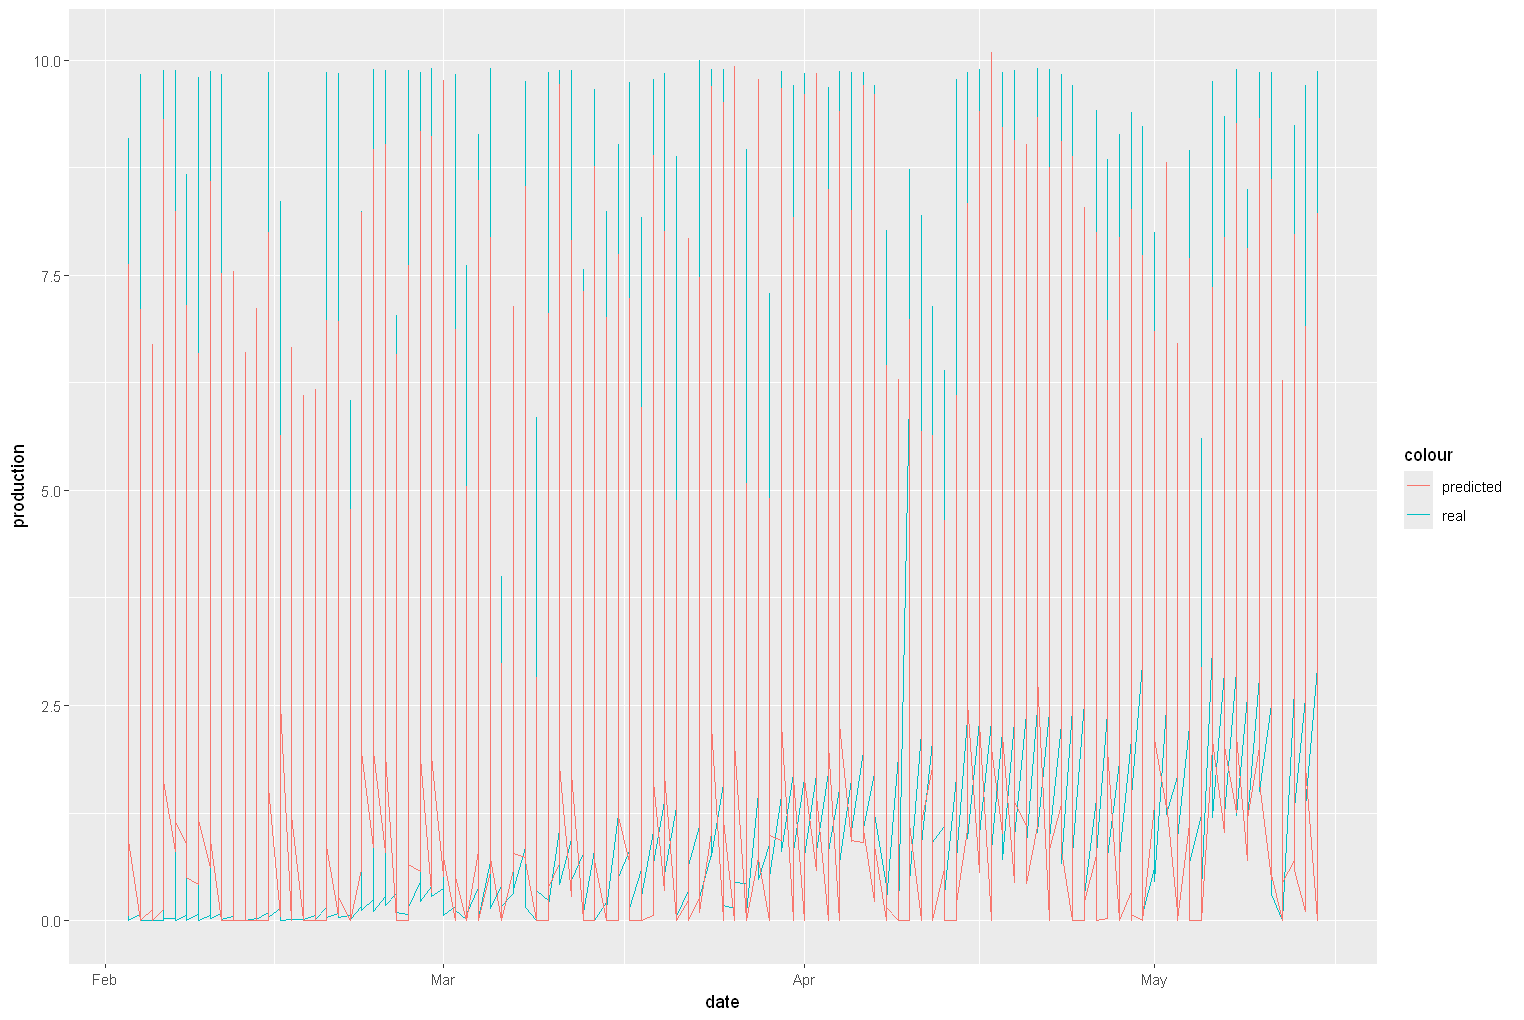


	Ljung-Box test

data:  Residuals
Q* = 667.49, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



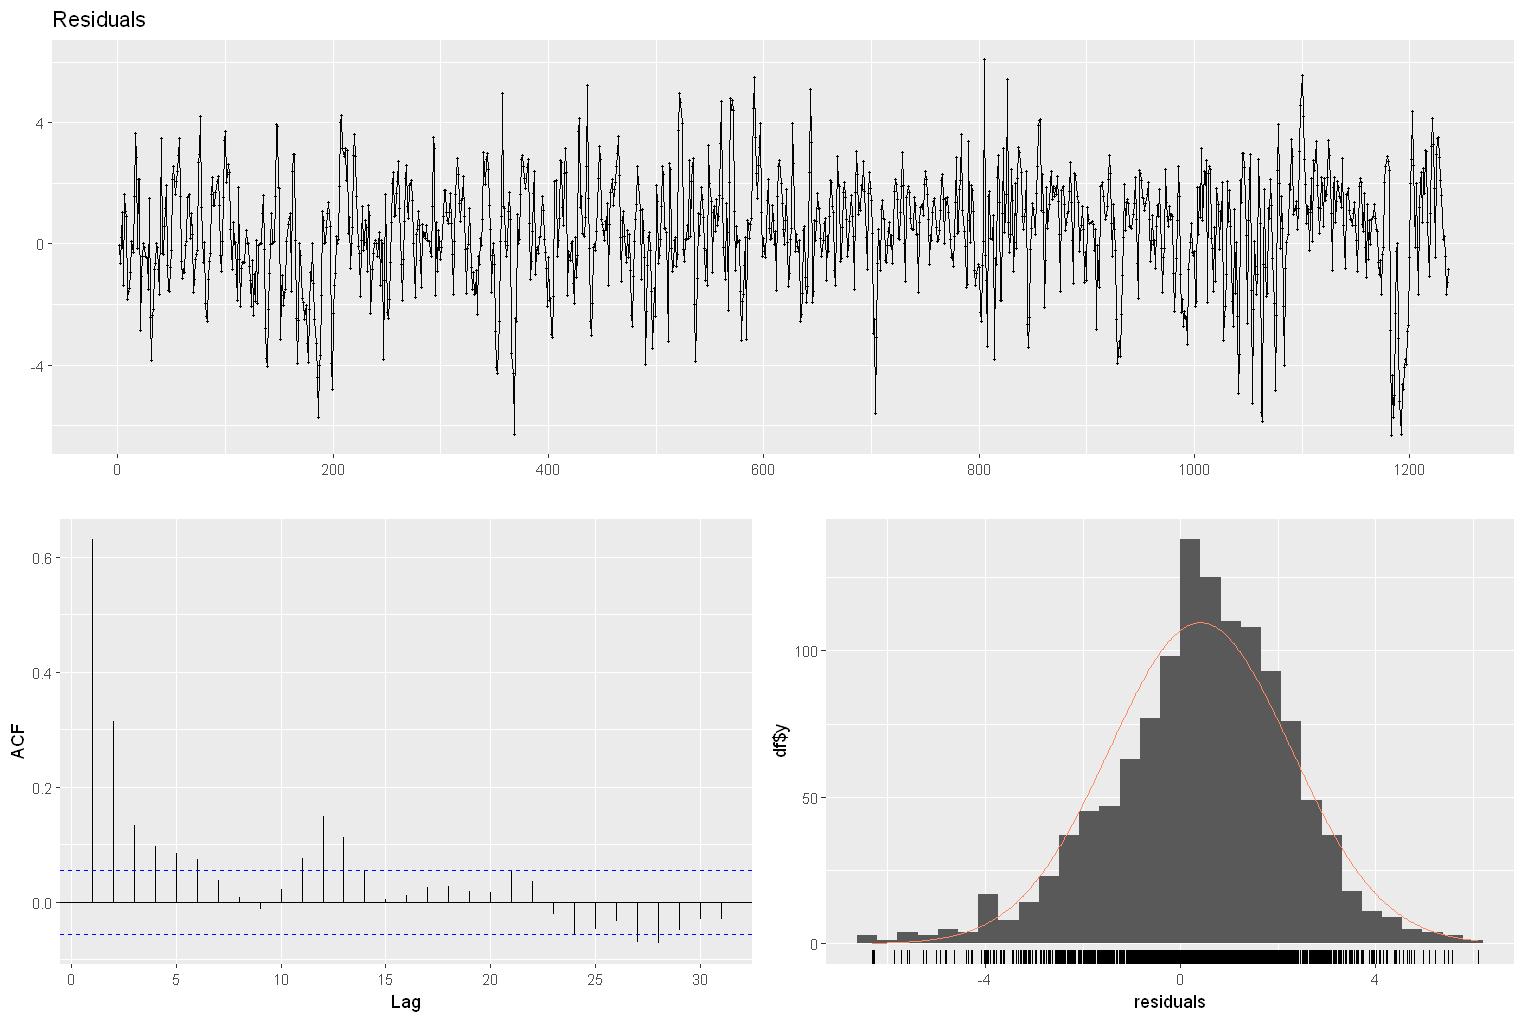

In [27]:
data_path <- 'new_data_16may.csv'

test_data <- fread(data_path)
colnames(test_data) <- tolower(colnames(test_data))

cutoff_date <- as.IDate("2024-01-30")
test_data <- test_data[date > cutoff_date]

test_data <- na.omit(test_data)
test_data[, hour_transformed := -(hour - 12)^2]
test_data[, prod_lag_24 := shift(production, 24)]
test_data[, prod_lag_36 := shift(production, 36)]

test_data <- as.data.frame(test_data)

test_data$max_production <- sapply(1:nrow(test_data), function(i) {
  max_production <- ifelse(i <= 36, max(test_data$production[1:i]), max(test_data$production[(i - 35):i]))
  return(max_production)
})

tmp_surface_columns <- grep("^tmp_surface", names(test_data), value = TRUE)

# Compute the average of these columns for each row
test_data$avg_tmp <- rowMeans(test_data[, tmp_surface_columns], na.rm = TRUE)

setDT(test_data)
test_data[, avg_temp_lag_1 := shift(avg_tmp, 1)]
test_data[, avg_temp_lag_2 := shift(avg_tmp, 2)]
test_data[, avg_temp_lag_3 := shift(avg_tmp, 3)]
test_data <- na.omit(test_data)

third_model_evaluation <- copy(test_data)
third_model_evaluation[,predicted:=predict(model,third_model_evaluation)]
# Replace negative values with zero
third_model_evaluation[, predicted := ifelse(predicted < 0, 0, predicted)]
third_model_evaluation[,residual:=production-predicted]

ggplot(third_model_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))
checkresiduals(third_model_evaluation$residual)

In [28]:
accu3 <- accu("3. Lasso(1sd)-LM_lag24_lag36", third_model_evaluation$production, third_model_evaluation$predicted)
comparisons <- rbind(comparisons, accu3)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.10482547,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.10880953,4058.146,1.994581,1.573241,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.07450837,4407.538,1.908707,1.505325,0.2984292,0.2984292
3. Lasso(1sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.08091652,4201.848,1.906118,1.493561,0.2954455,0.2954455


In the third model, we encounter with underprediction problem again. In addition, in the model summary, we see that many variables are not significant for the predictions. Therefore, we will utilize lasso regression with a higher punishment. As the fourth model, we will build a time series linear regression model with Lasso variables that will be acquired by another lambda. This time, lambda will be selected as the one that is within three standard deviation of the minimum MSE.

In [13]:
llm <- copy(train_data)
llm <- na.omit(llm)

setDT(llm)

# Define the columns -rather than hour, production, and date- to standardize
columns_to_standardize <- setdiff(names(llm), c("hour", "production", "date"))

# Standardize the columns
llm[, (columns_to_standardize) := lapply(.SD, scale), .SDcols = columns_to_standardize]

llm <- as.data.frame(llm)

# Define the predictors and response variable
predictors <- subset(llm, select = -c(date, production, hour))
response <- llm$production

# Perform cross-validation to find the optimal lambda value
cv_fit <- cv.glmnet(as.matrix(predictors), response, alpha = 1)

lambda_1se <- cv_fit$lambda.1se
lambda_aggressive <- lambda_1se * 3

lasso_model_2 <- glmnet(as.matrix(predictors), response, alpha = 1, lambda = lambda_aggressive)

# Print the model summary
print(lasso_model_2)

# Extract coefficients for the selected lambda
coefficients <- as.matrix(coef(lasso_model_2, s = lambda_aggressive))

# Get the variable names with non-zero coefficients
selected_variables <- rownames(coefficients)[coefficients[, 1] != 0]

# Print the selected variables
print(selected_variables)


Call:  glmnet(x = as.matrix(predictors), y = response, alpha = 1, lambda = lambda_aggressive) 

   Df  %Dev   Lambda
1 102 71.74 0.005842
  [1] "(Intercept)"                        
  [2] "csnow_surface_37.75_34.5"           
  [3] "csnow_surface_37.75_34.75"          
  [4] "csnow_surface_37.75_35.25"          
  [5] "csnow_surface_37.75_35.5"           
  [6] "csnow_surface_38.0_34.5"            
  [7] "csnow_surface_38.0_35.0"            
  [8] "csnow_surface_38.0_35.5"            
  [9] "csnow_surface_38.25_34.5"           
 [10] "csnow_surface_38.25_35.0"           
 [11] "csnow_surface_38.25_35.5"           
 [12] "csnow_surface_38.5_34.5"            
 [13] "csnow_surface_38.5_34.75"           
 [14] "csnow_surface_38.5_35.0"            
 [15] "csnow_surface_38.5_35.25"           
 [16] "csnow_surface_38.5_35.5"            
 [17] "csnow_surface_38.75_34.5"           
 [18] "csnow_surface_38.75_34.75"          
 [19] "csnow_surface_38.75_35.0"           
 [20] "csnow_surface_38.7

In [14]:
# Remove the "(Intercept)" from the list of selected variables
selected_variables_2 <- selected_variables[selected_variables != "(Intercept)"]

# Subset the "data" dataframe to include only the selected variables
columns_to_keep_2 <- c("date", "hour", "production", selected_variables_2)

train_data <- as.data.frame(train_data)

filtered_data_2 <- train_data[, columns_to_keep_2, drop = FALSE]

# Print the filtered dataframe
head(filtered_data_2)
str(filtered_data_2)

,date,hour,production,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_35.0,csnow_surface_38.0_35.5,⋯,uswrf_top_of_atmosphere_38.0_35.25,uswrf_top_of_atmosphere_38.25_35.5,uswrf_top_of_atmosphere_38.5_34.75,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_35.0,hour_transformed,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,max_production
,<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2022-01-01,6,0.00,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-36,NA,NA,NA,0.00
2,2022-01-01,7,0.00,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-25,269.035,NA,NA,0.00
3,2022-01-01,8,3.40,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,-16,269.001,269.035,NA,3.40
4,2022-01-01,9,6.80,0,0,0,0,0,0,0,⋯,10.512,10.928,8.368,7.536,8.592,-9,269.002,269.001,269.035,6.80
5,2022-01-01,10,9.38,0,0,0,0,0,0,0,⋯,179.808,162.688,102.752,104.464,120.656,-4,271.634,269.002,269.001,9.38
6,2022-01-01,11,7.65,0,0,0,0,0,0,0,⋯,210.560,188.736,116.944,140.640,130.512,-1,275.786,271.634,269.002,9.38


'data.frame':	9116 obs. of  105 variables:
 $ date                               : IDate, format: "2022-01-01" "2022-01-01" ...
 $ hour                               : int  6 7 8 9 10 11 12 13 14 15 ...
 $ production                         : num  0 0 3.4 6.8 9.38 7.65 6.8 5.1 5.1 1.7 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_35.0           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.

In [31]:
setDT(filtered_data_2)

filtered_data_2[, prod_lag_24 := shift(production, 24)]
filtered_data_2[, prod_lag_36 := shift(production, 36)]

filtered_data_2 <- as.data.frame(filtered_data_2)

# Filter out the columns you want to use as features
feature_columns <- setdiff(names(filtered_data_2), c('date','hour','production'))

# Create the predictor matrix X and response vector y
X <- filtered_data_2[, feature_columns, drop = FALSE]
y <- filtered_data_2$production

# Fit the linear regression model
model <- lm(production ~ ., data = filtered_data_2[, c(feature_columns, "production")])

# Print the summary of the model
summary(model)


Call:
lm(formula = production ~ ., data = filtered_data_2[, c(feature_columns, 
    "production")])

Residuals:
   Min     1Q Median     3Q    Max 
-9.470 -1.118  0.121  1.209  8.205 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -1.877e+01  1.882e+00  -9.976  < 2e-16 ***
csnow_surface_37.75_34.5             4.326e-01  1.724e-01   2.510 0.012088 *  
csnow_surface_37.75_34.75            1.766e-01  1.468e-01   1.203 0.229085    
csnow_surface_37.75_35.25           -1.002e-01  1.064e-01  -0.942 0.346271    
csnow_surface_37.75_35.5             1.911e-01  1.519e-01   1.258 0.208297    
csnow_surface_38.0_34.5             -4.896e-01  1.434e-01  -3.414 0.000643 ***
csnow_surface_38.0_35.0              2.099e-01  1.472e-01   1.425 0.154061    
csnow_surface_38.0_35.25            -1.223e-01  1.269e-01  -0.963 0.335425    
csnow_surface_38.0_35.5              8.268e-02  1.404e-01   0.589 0.556044    
csnow_surf

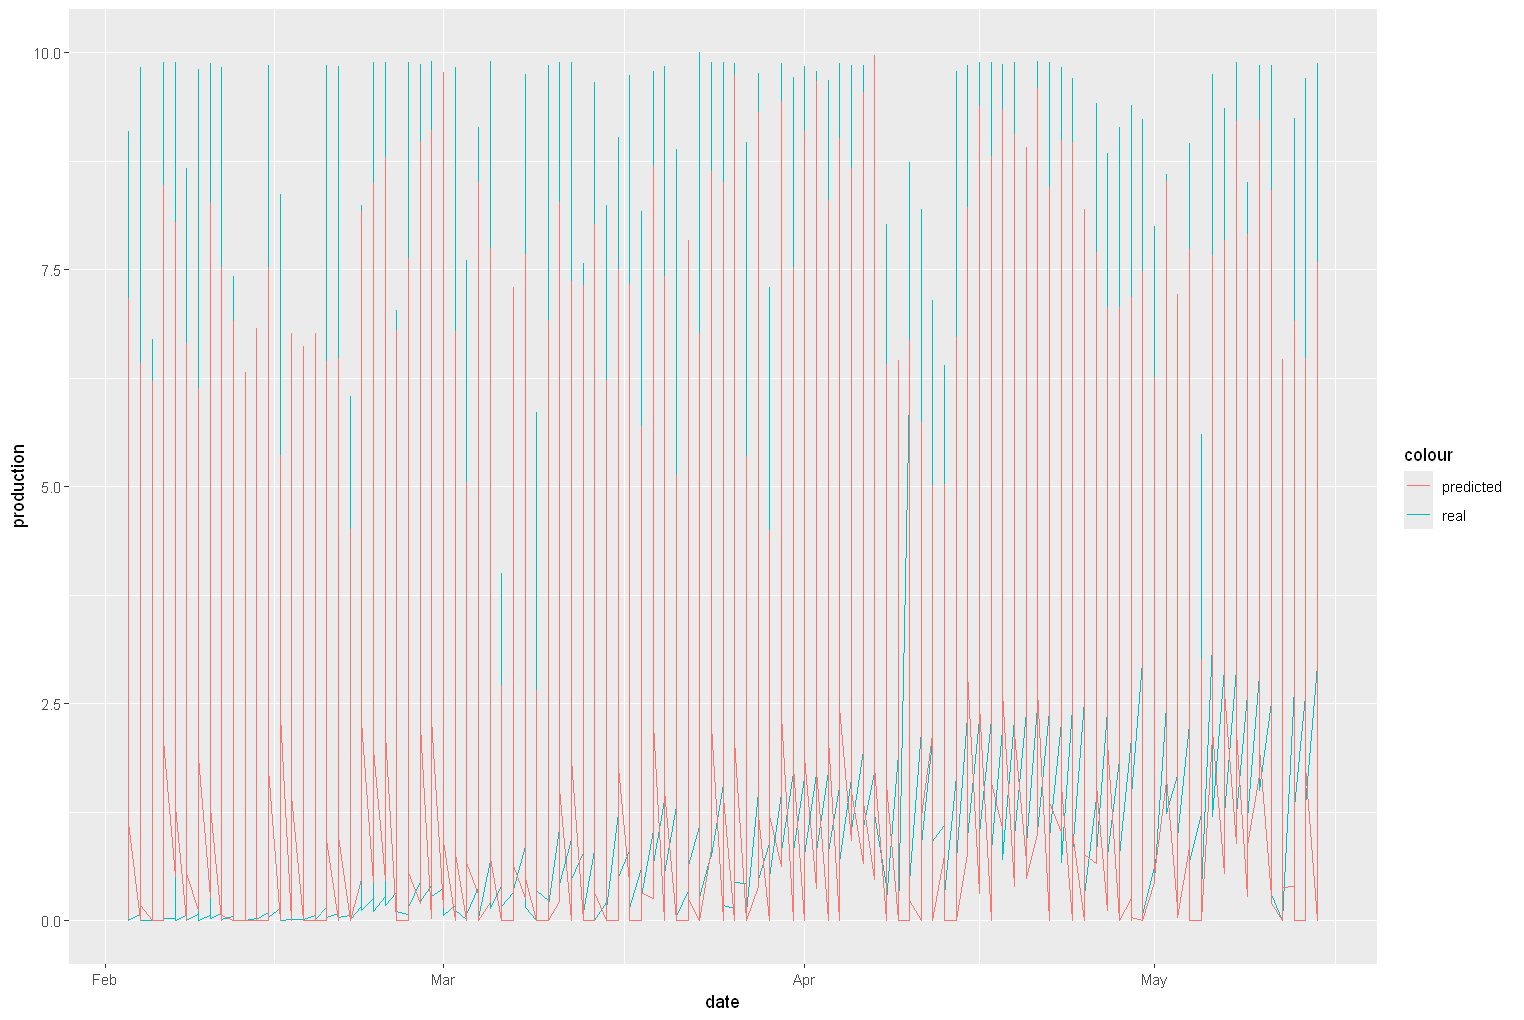


	Ljung-Box test

data:  Residuals
Q* = 707.24, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



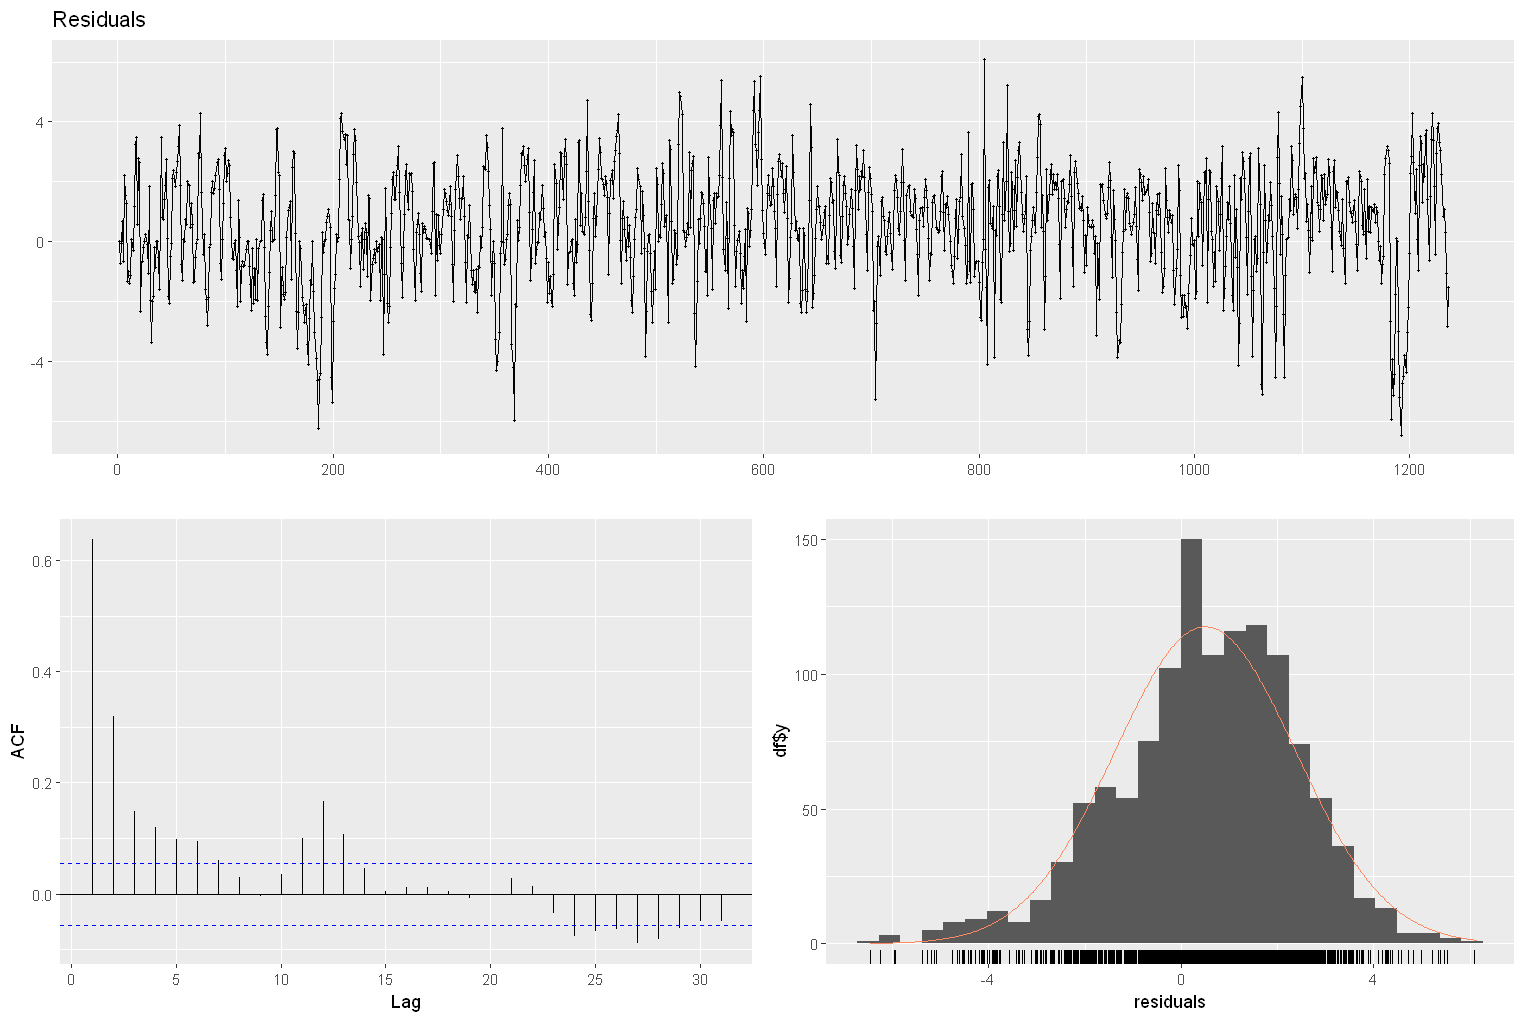

In [32]:
fourth_model_evaluation <- copy(test_data)

fourth_model_evaluation[,predicted:=predict(model,fourth_model_evaluation)]
# Replace negative values with zero
fourth_model_evaluation[, predicted := ifelse(predicted < 0, 0, predicted)]
fourth_model_evaluation[,residual:=production-predicted]

ggplot(fourth_model_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))
checkresiduals(fourth_model_evaluation$residual)

In [33]:
accu4 <- accu("4. Lasso(3sd)-LM_lag24_lag36", fourth_model_evaluation$production, fourth_model_evaluation$predicted)
comparisons <- rbind(comparisons, accu4)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.10482547,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.10880953,4058.146,1.994581,1.573241,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.07450837,4407.538,1.908707,1.505325,0.2984292,0.2984292
3. Lasso(1sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.08091652,4201.848,1.906118,1.493561,0.2954455,0.2954455
4. Lasso(3sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.09916113,4422.851,1.946731,1.549387,0.3064887,0.3064887


Imposing a higher punishment did not help reducing errors unfortunately. Now, we will further investigate the relationship between each variable and production with ggpairs.

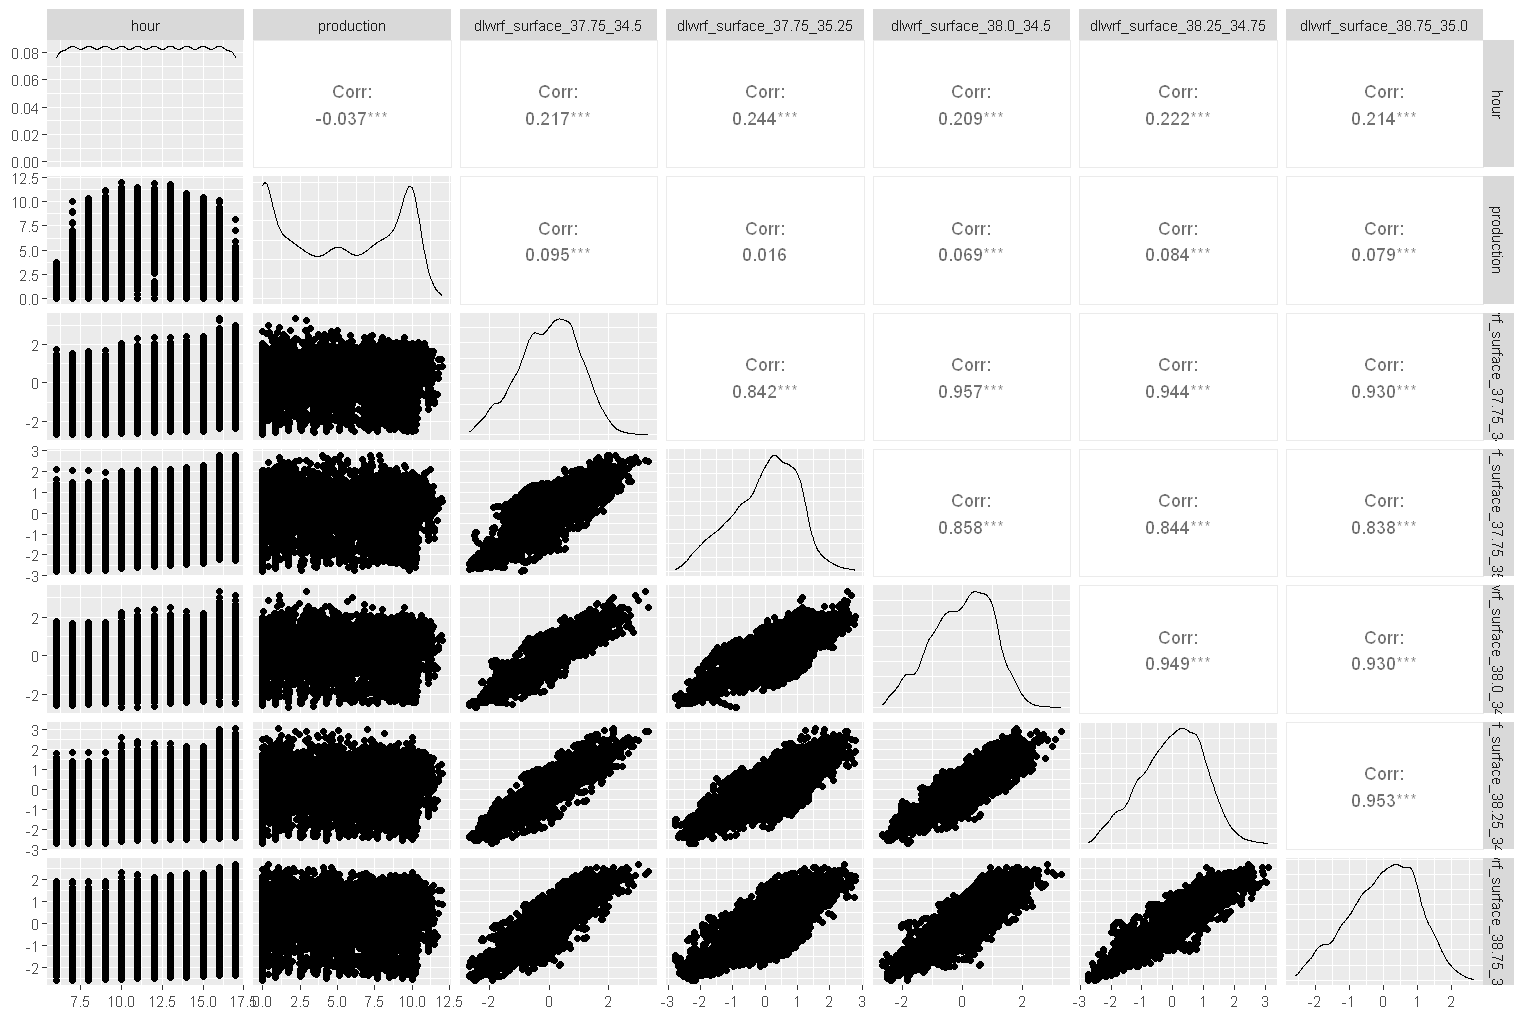

In [88]:
# Filter the columns that start with "DLWRF"
DLWRF_columns <- grep("^dlwrf", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", DLWRF_columns)

filtered_data_DLWRF <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_DLWRF)


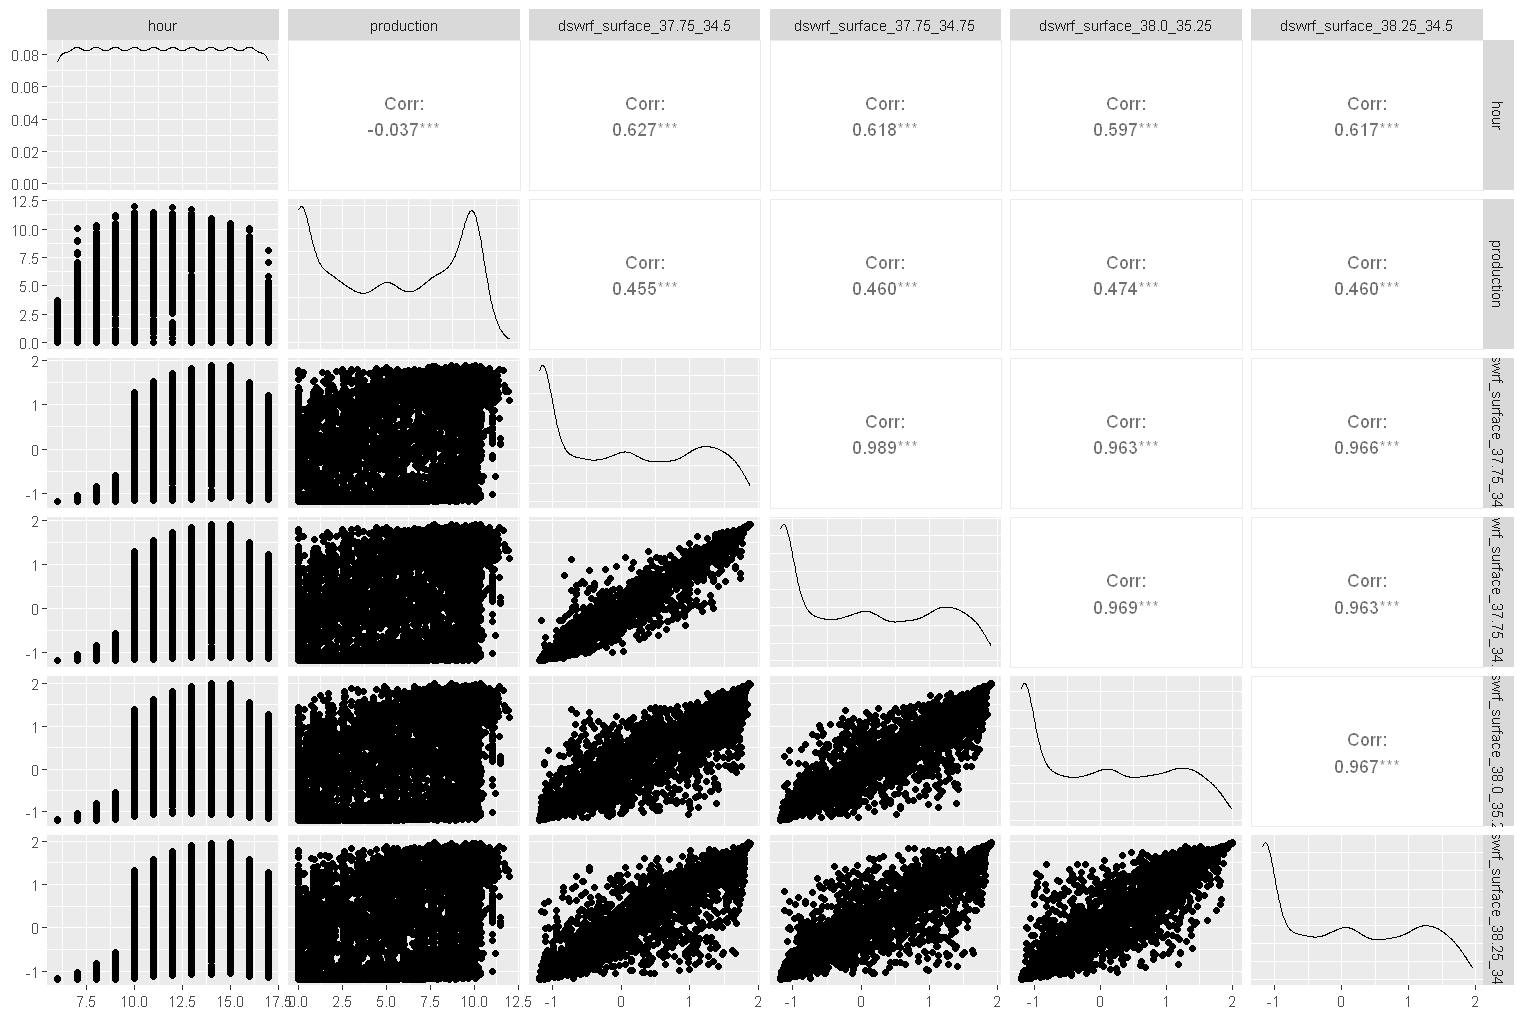

In [89]:
# Filter the columns that start with "DSWRF"
DSWRF_columns <- grep("^dswrf", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", DSWRF_columns)

filtered_data_DSWRF <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_DSWRF)


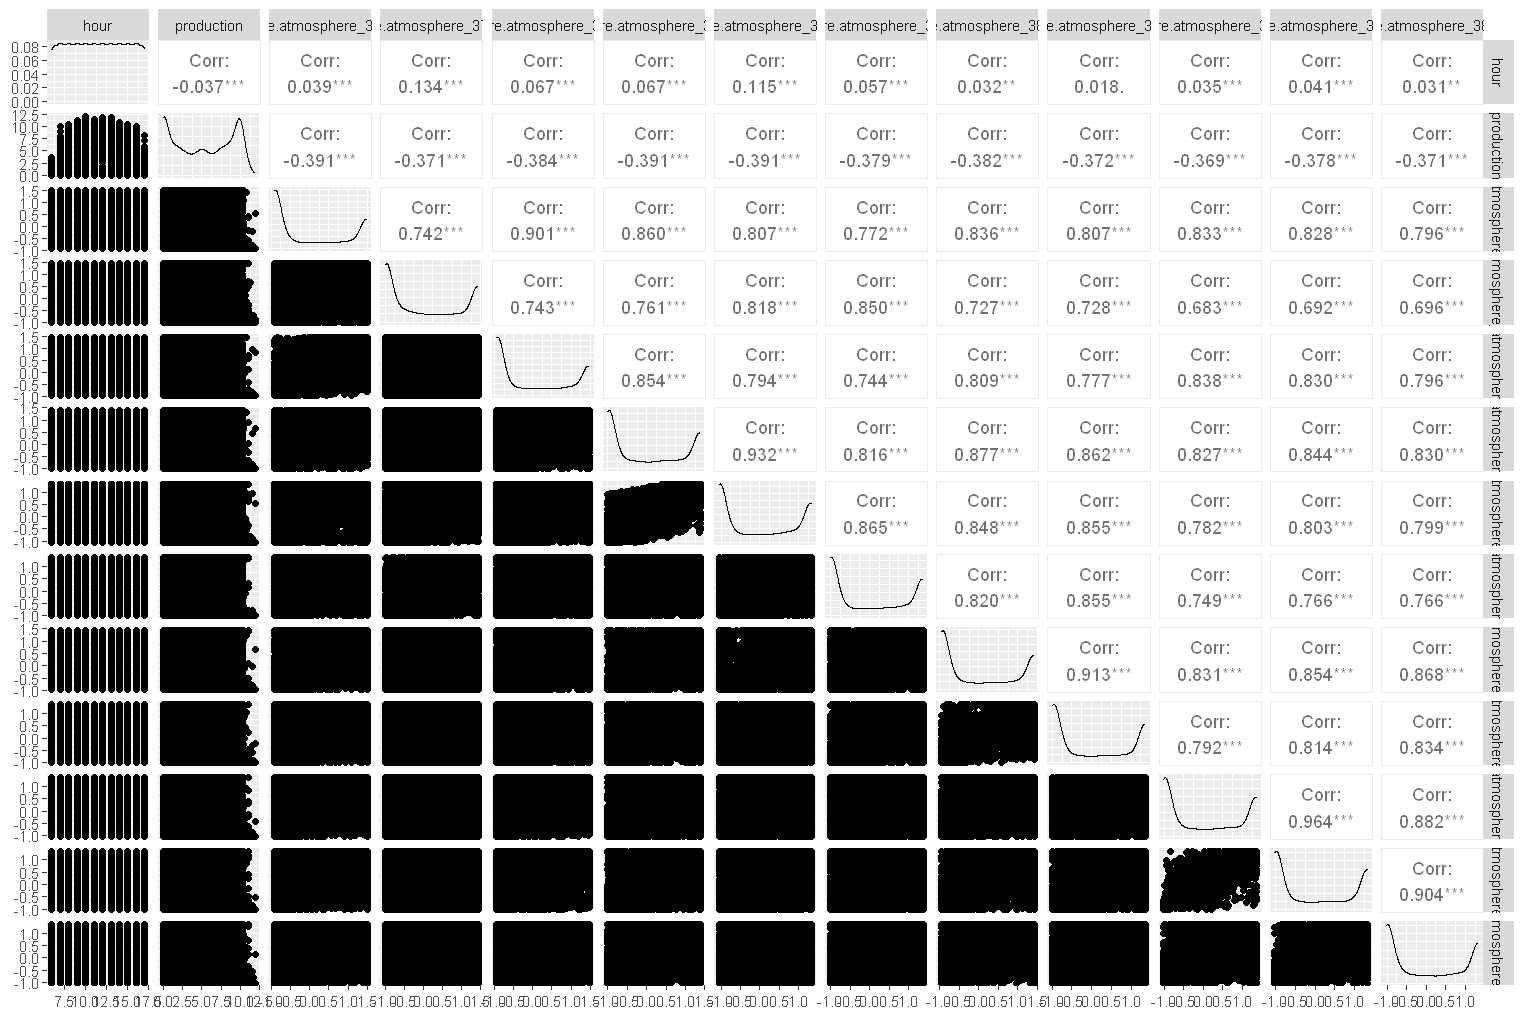

In [90]:
# Filter the columns that start with "tcdc_entire"
tcdc_entire_columns <- grep("^tcdc_entire", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", tcdc_entire_columns)

filtered_data_tcdc_entire <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_tcdc_entire)


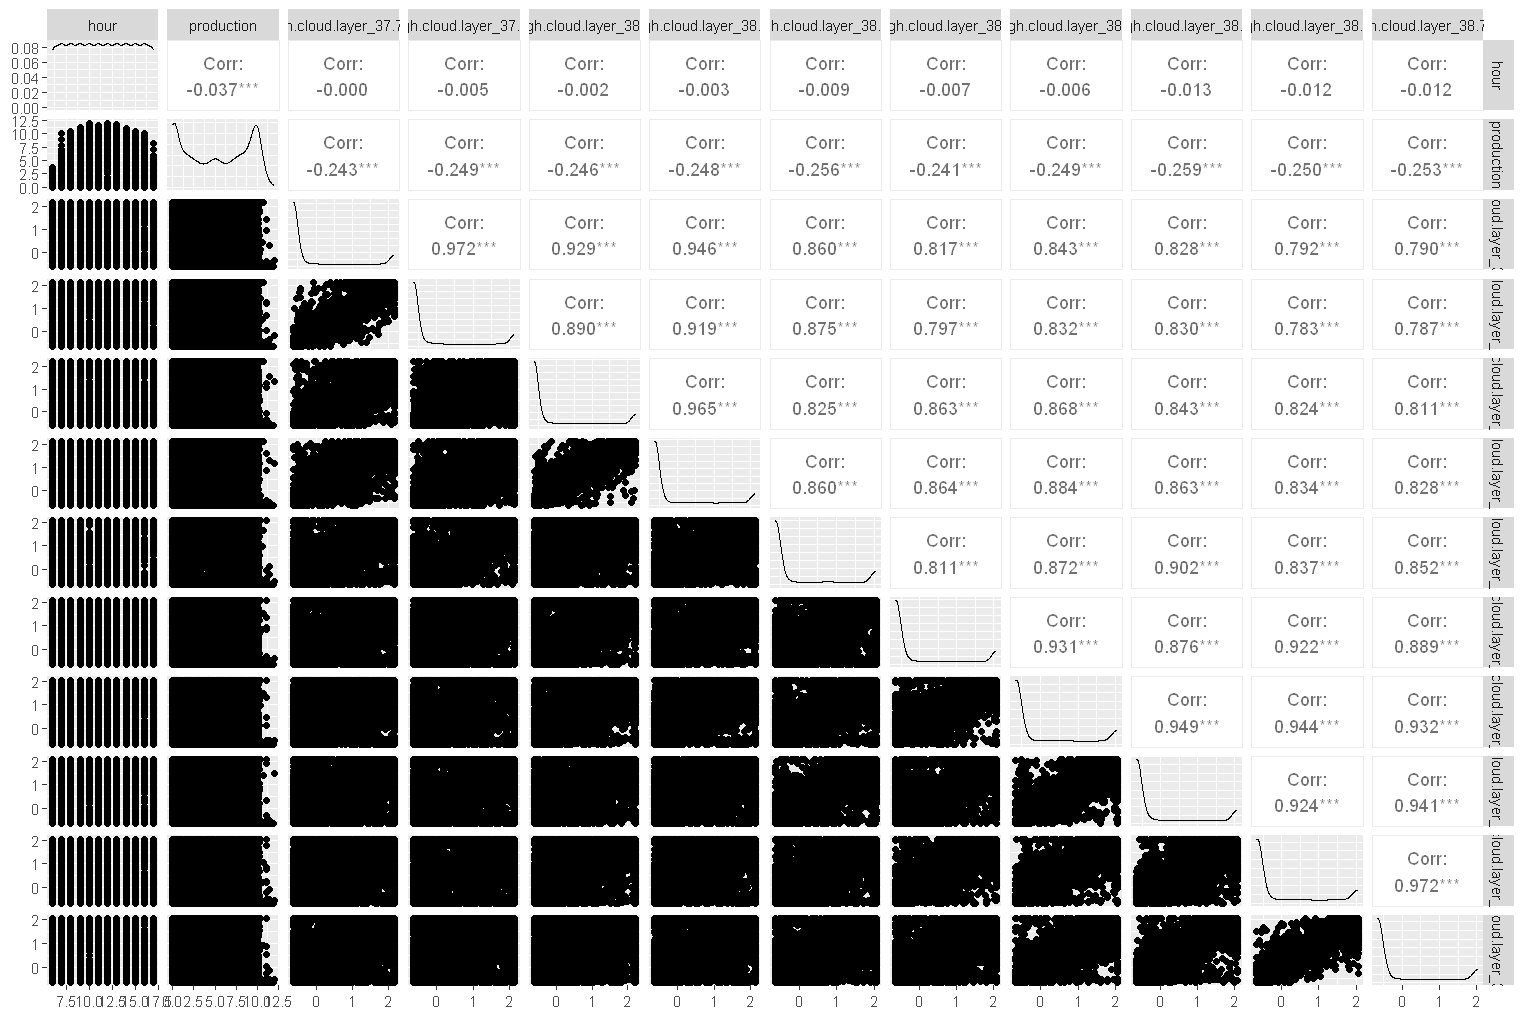

In [91]:
# Filter the columns that start with "tcdc_high"
tcdc_high_columns <- grep("^tcdc_high", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", tcdc_high_columns)

filtered_data_tcdc_high <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_tcdc_high)


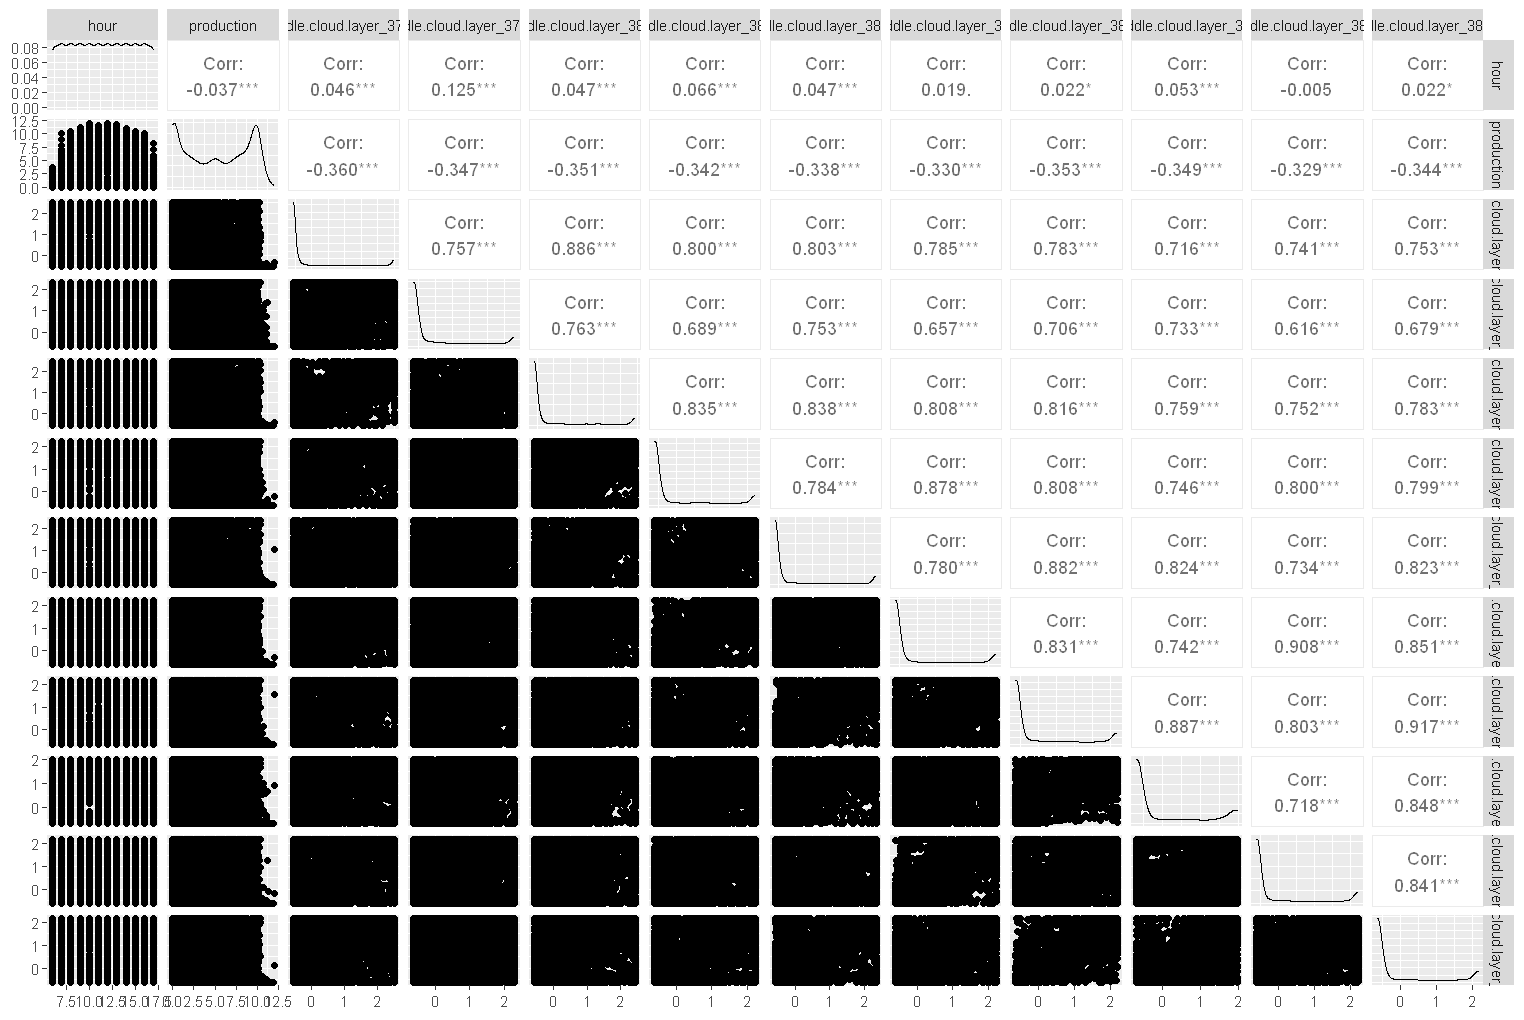

In [92]:
# Filter the columns that start with "tcdc_middle"
tcdc_middle_columns <- grep("^tcdc_middle", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", tcdc_middle_columns)

filtered_data_tcdc_middle <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_tcdc_middle)


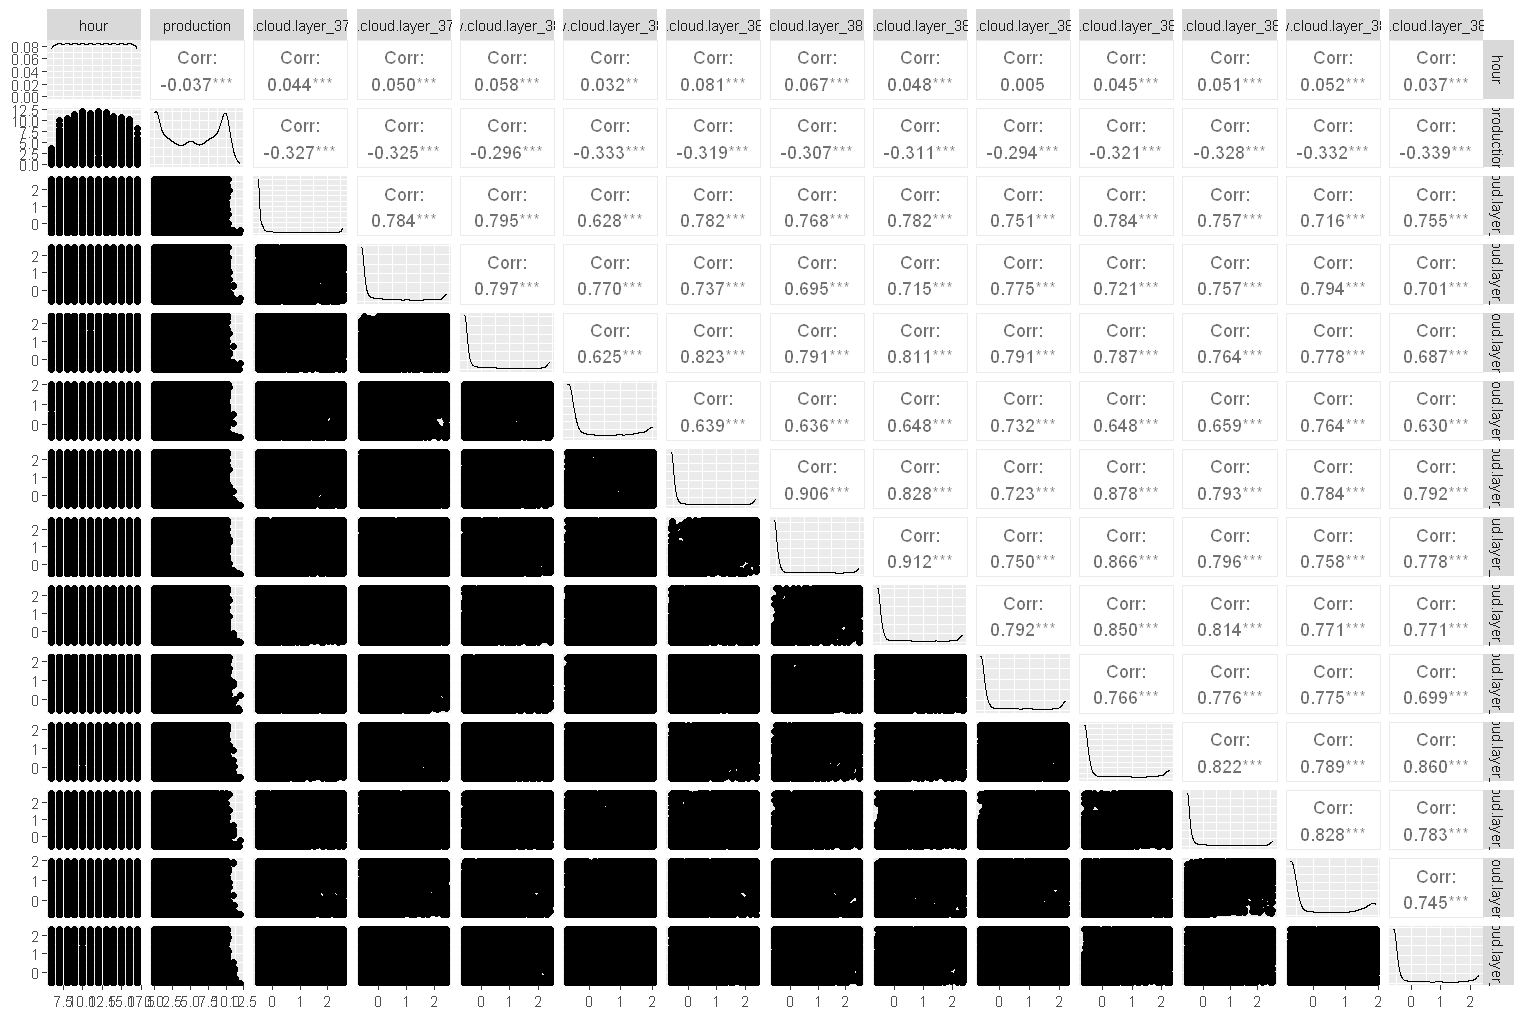

In [93]:
# Filter the columns that start with "tcdc_low"
tcdc_low_columns <- grep("^tcdc_low", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", tcdc_low_columns)

filtered_data_tcdc_low <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_tcdc_low)


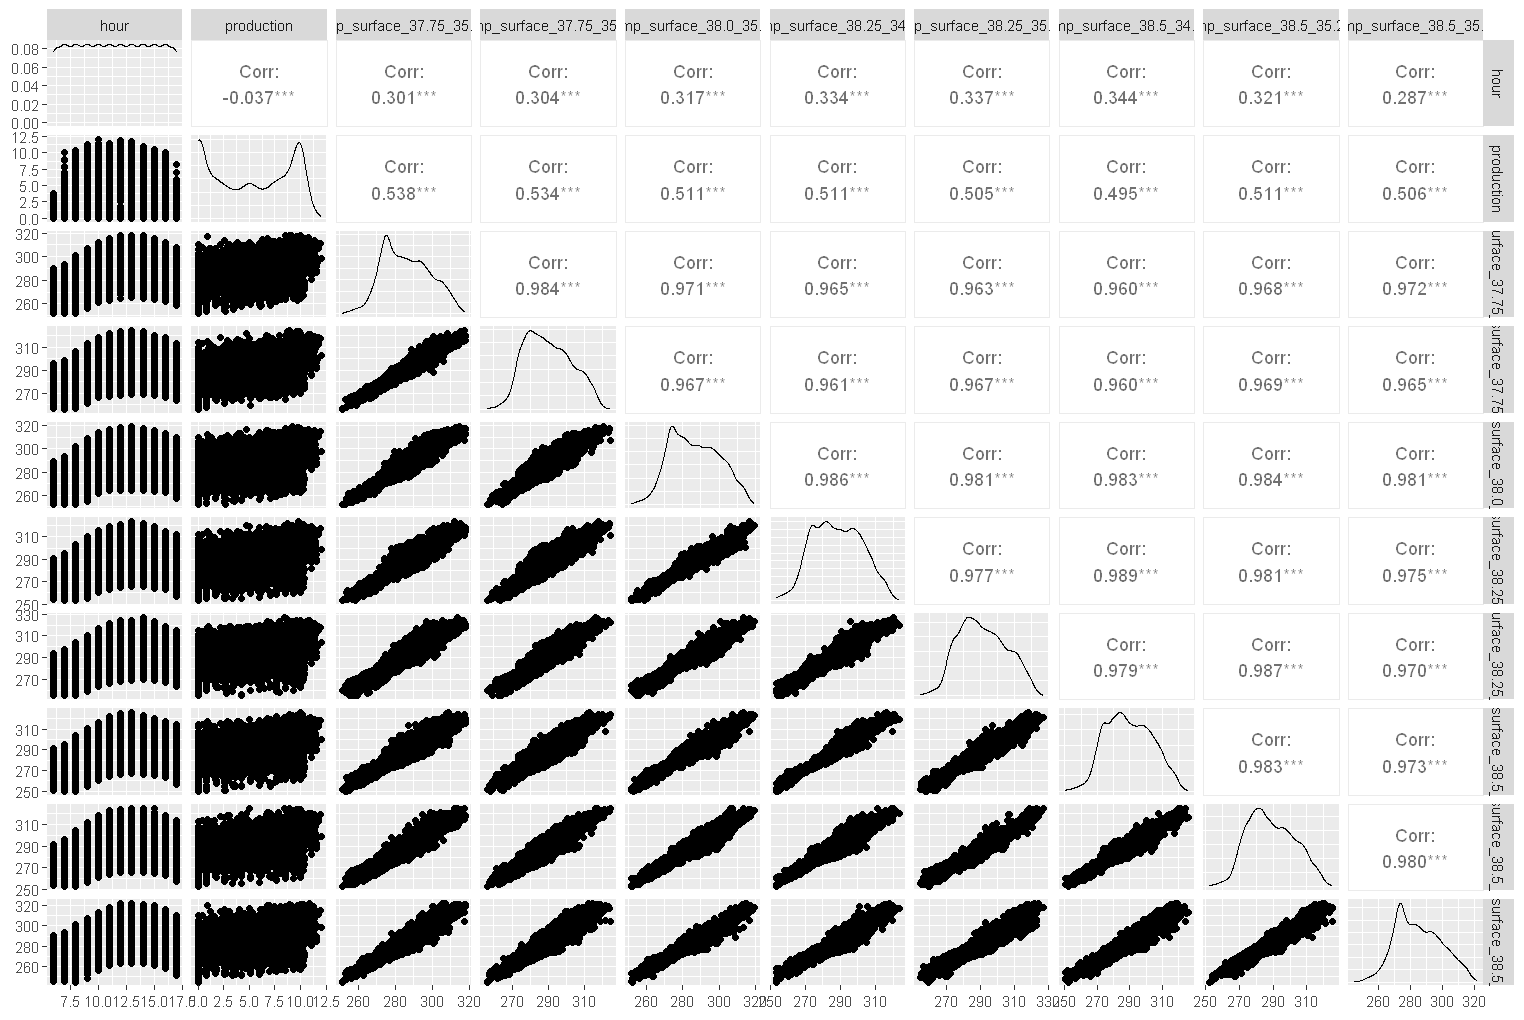

In [82]:
# Filter the columns that start with "tmp_surface"
tmp_surface_columns <- grep("^tmp_surface", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", tmp_surface_columns)

filtered_data_surface_columns <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_surface_columns)

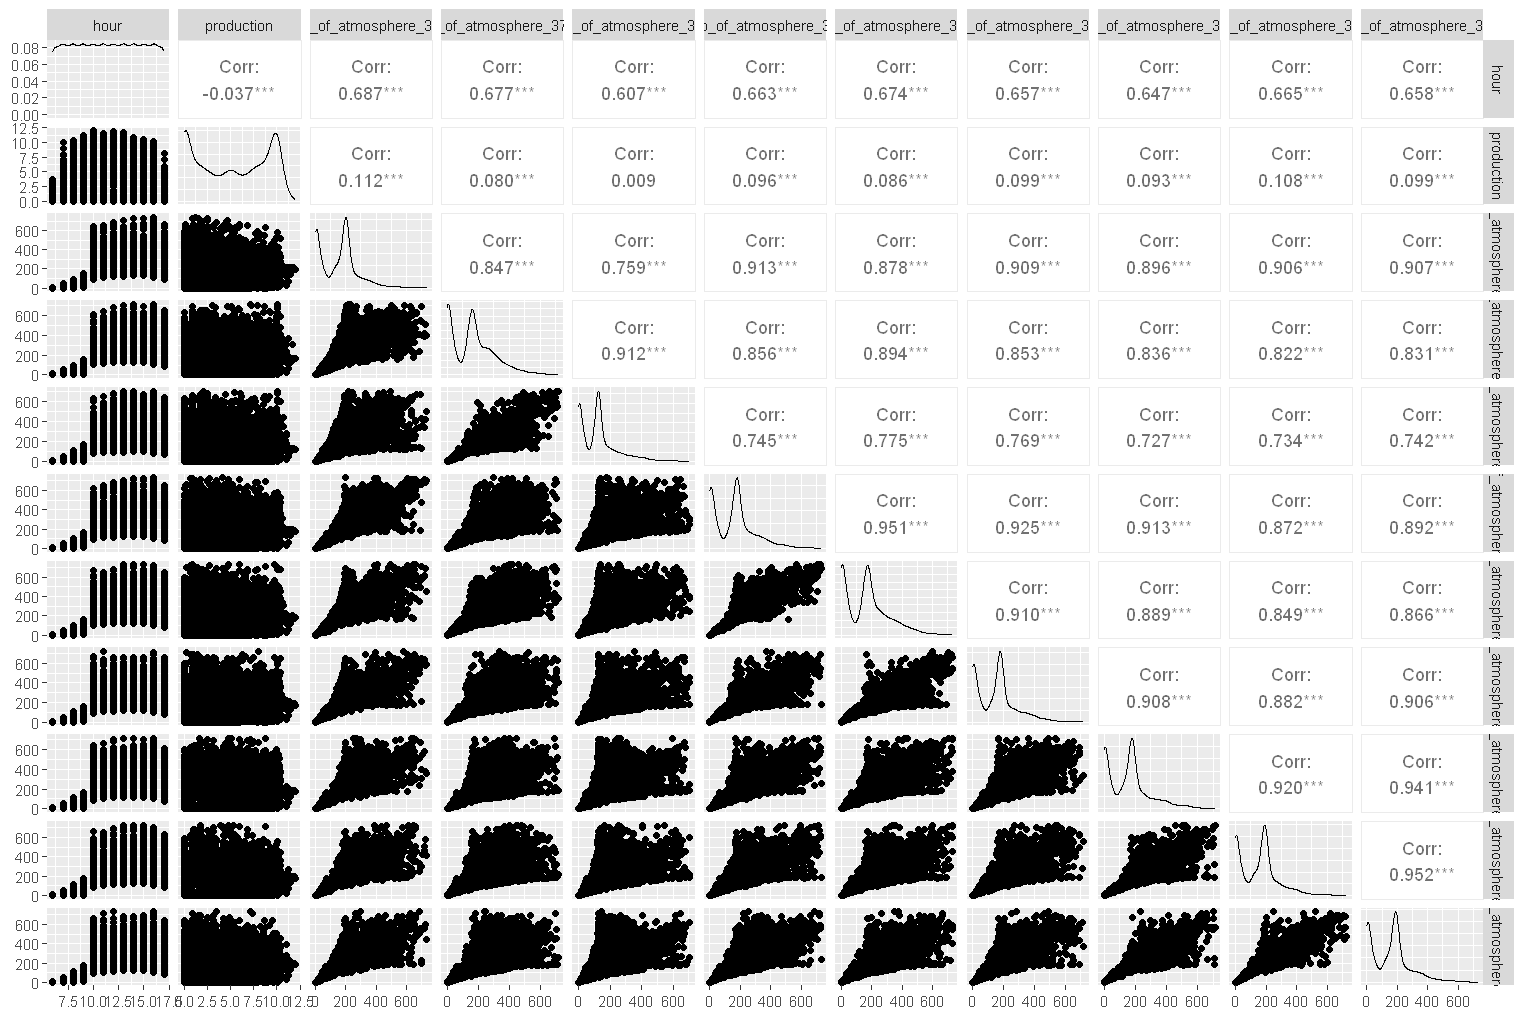

In [15]:
# Filter the columns that start with "DLWRF"
USWRF_TOP_columns <- grep("^uswrf_top", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", USWRF_TOP_columns)

filtered_data_USWRF_TOP <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_USWRF_TOP)


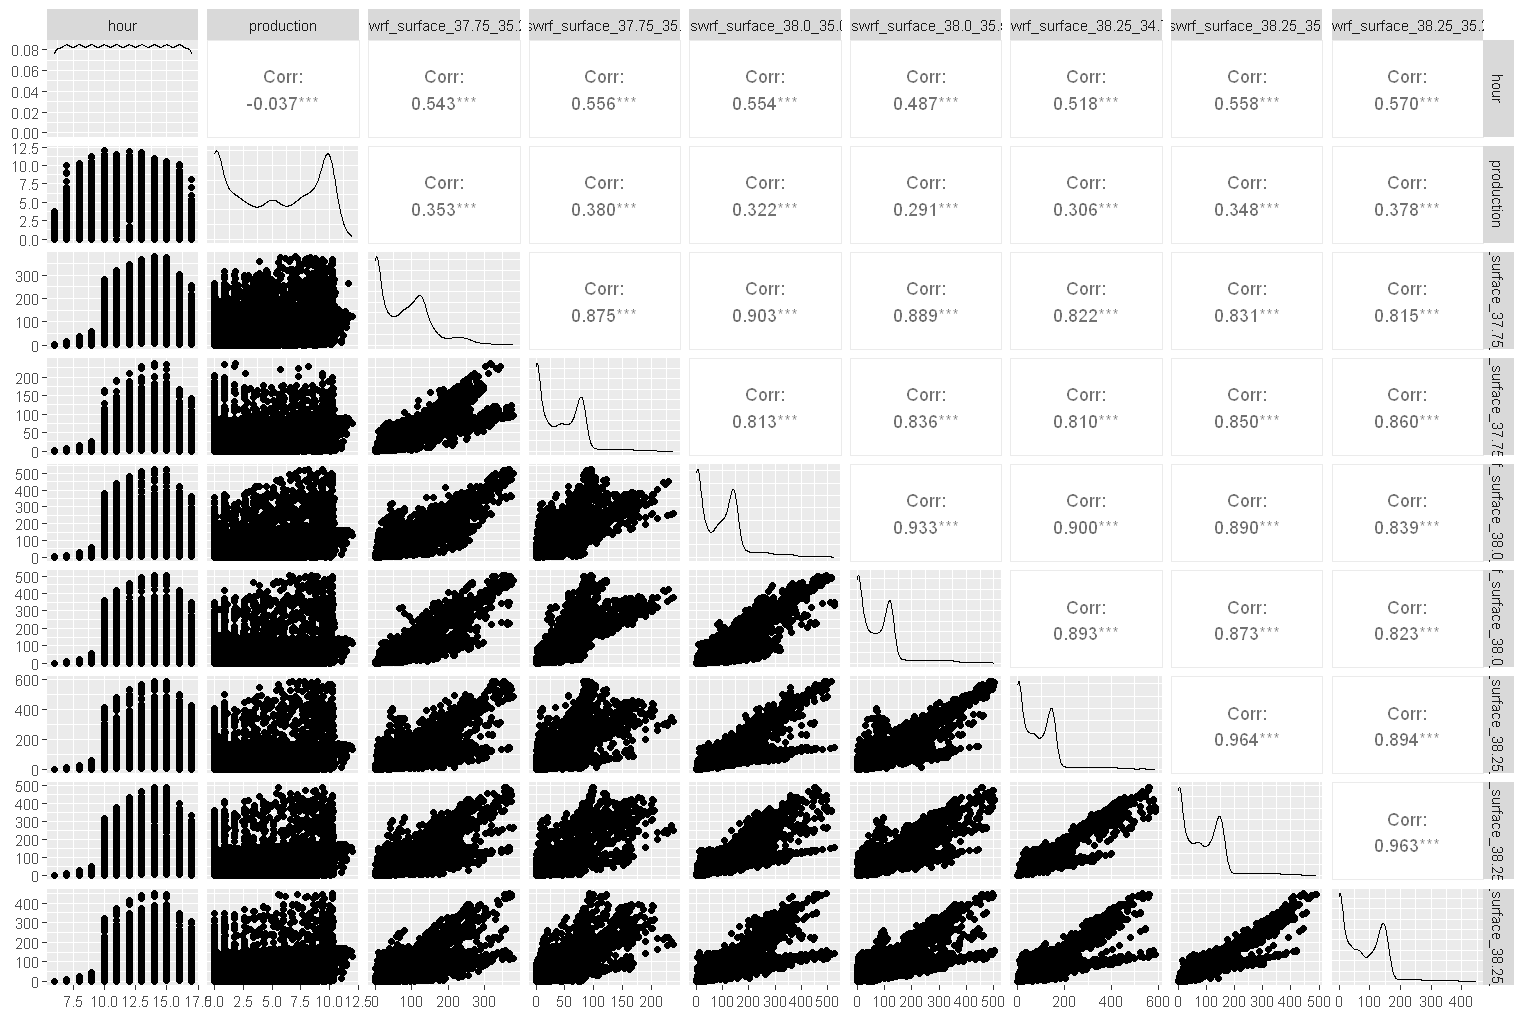

In [16]:
# Filter the columns that start with "DLWRF"
USWRF_SURFACE_columns <- grep("^uswrf_surface", names(filtered_data_2), value = TRUE)

selected_columns <- c("hour", "production", USWRF_SURFACE_columns)

filtered_data_USWRF_SURFACE <- filtered_data_2[, selected_columns, drop = FALSE]

ggpairs(filtered_data_USWRF_SURFACE)


Ggpair plots did not help us finding an unmodeled relationship between the variables and the response variable. Looking at the ggpair graph of all variables, there seems to be almost no relationship. Therefore, we end the linear regression models here and move on to ARIMA models.

## Fifth Approach : ARIMA models for each hour

In this approach, we will group the data by hour. Then we will initialize an ARIMA model using the training period. For the test phase, we will iterate over the days, and build ARIMA models with auto.arima for each test day. By doing so, we will refresh our ARIMA model with using the most recent information for each day.

## Hour 6

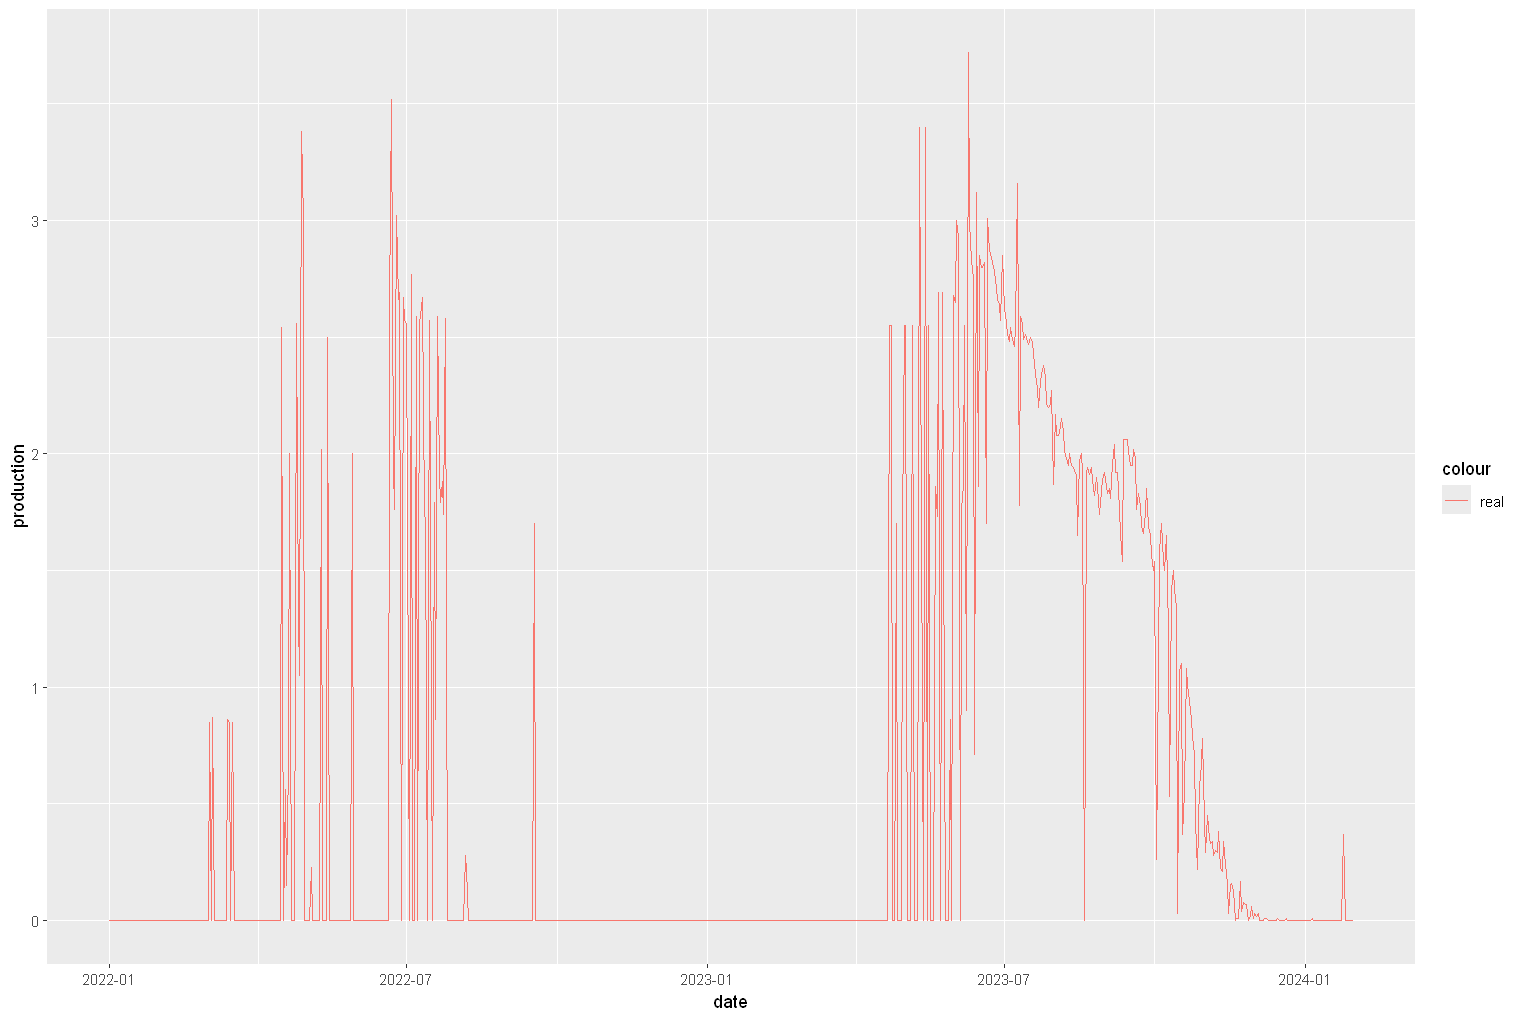

In [34]:
setDT(filtered_data_2)
train_split_data_tables <- split(filtered_data_2, by = "hour")

test_split_data_tables <- split(test_data, by = "hour")

train_hour_6 <- train_split_data_tables[["6"]]
test_hour_6 <- test_split_data_tables[["6"]]

ggplot(train_hour_6,aes(x=date)) + geom_line(aes(y=production,color='real'))

Since data is not stationary, we will take differences and build an ARIMA model for it. Important to note here, 1-day difference is not practical for us since the most recent information we have belongs to 2 days ago in the forecasting setting.

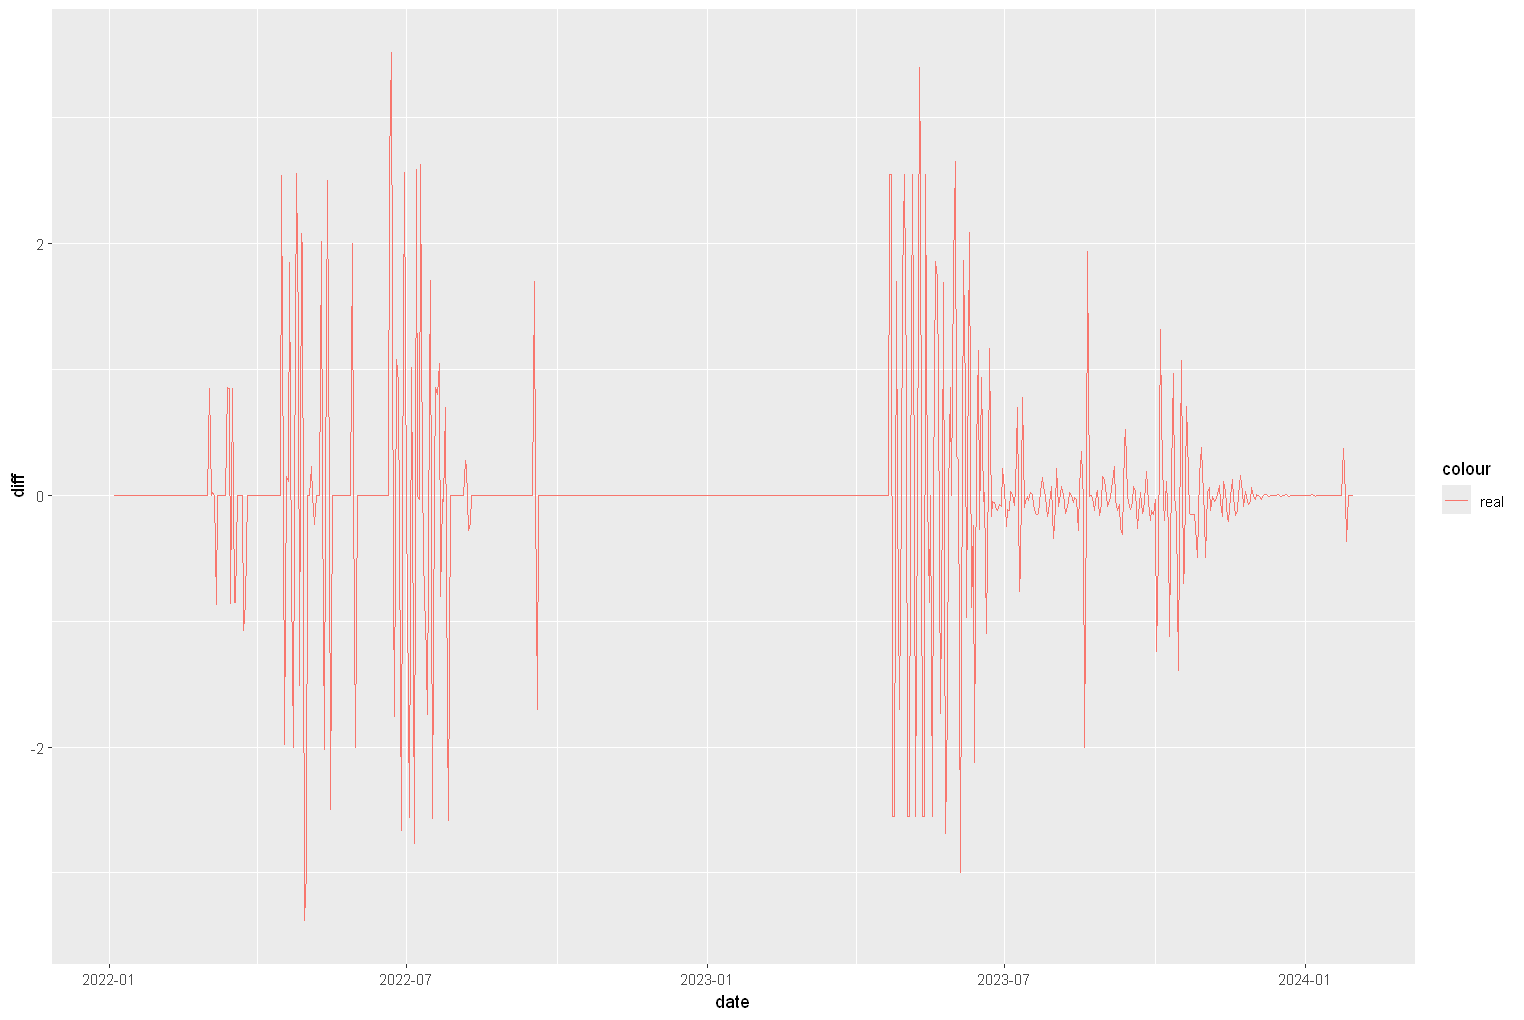

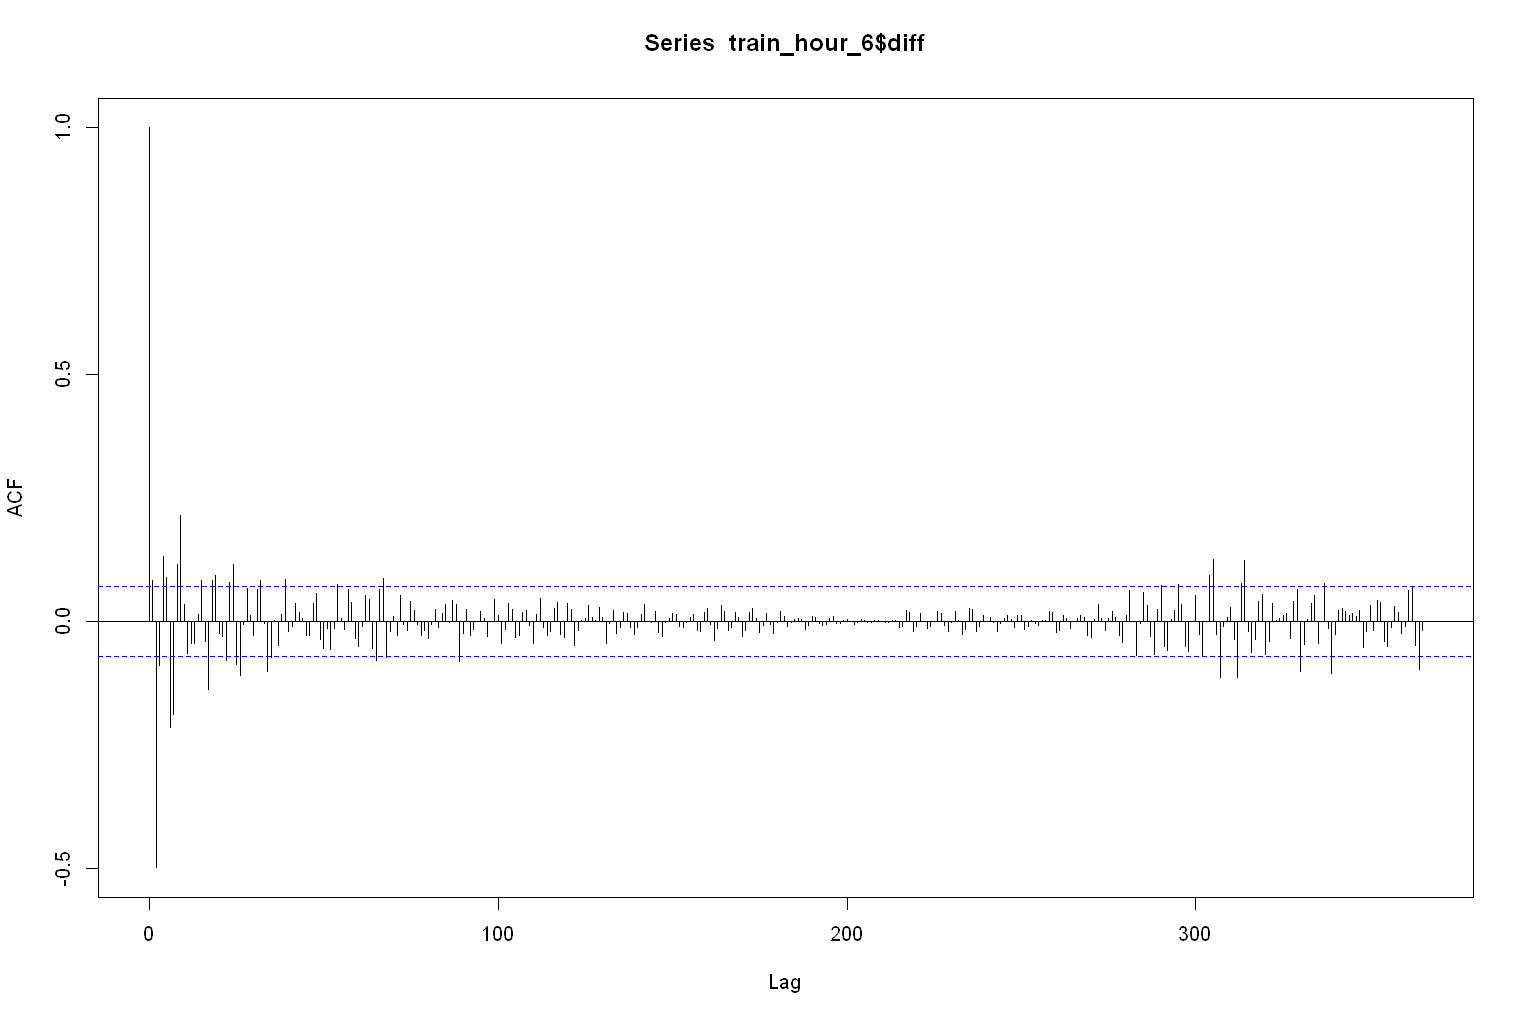

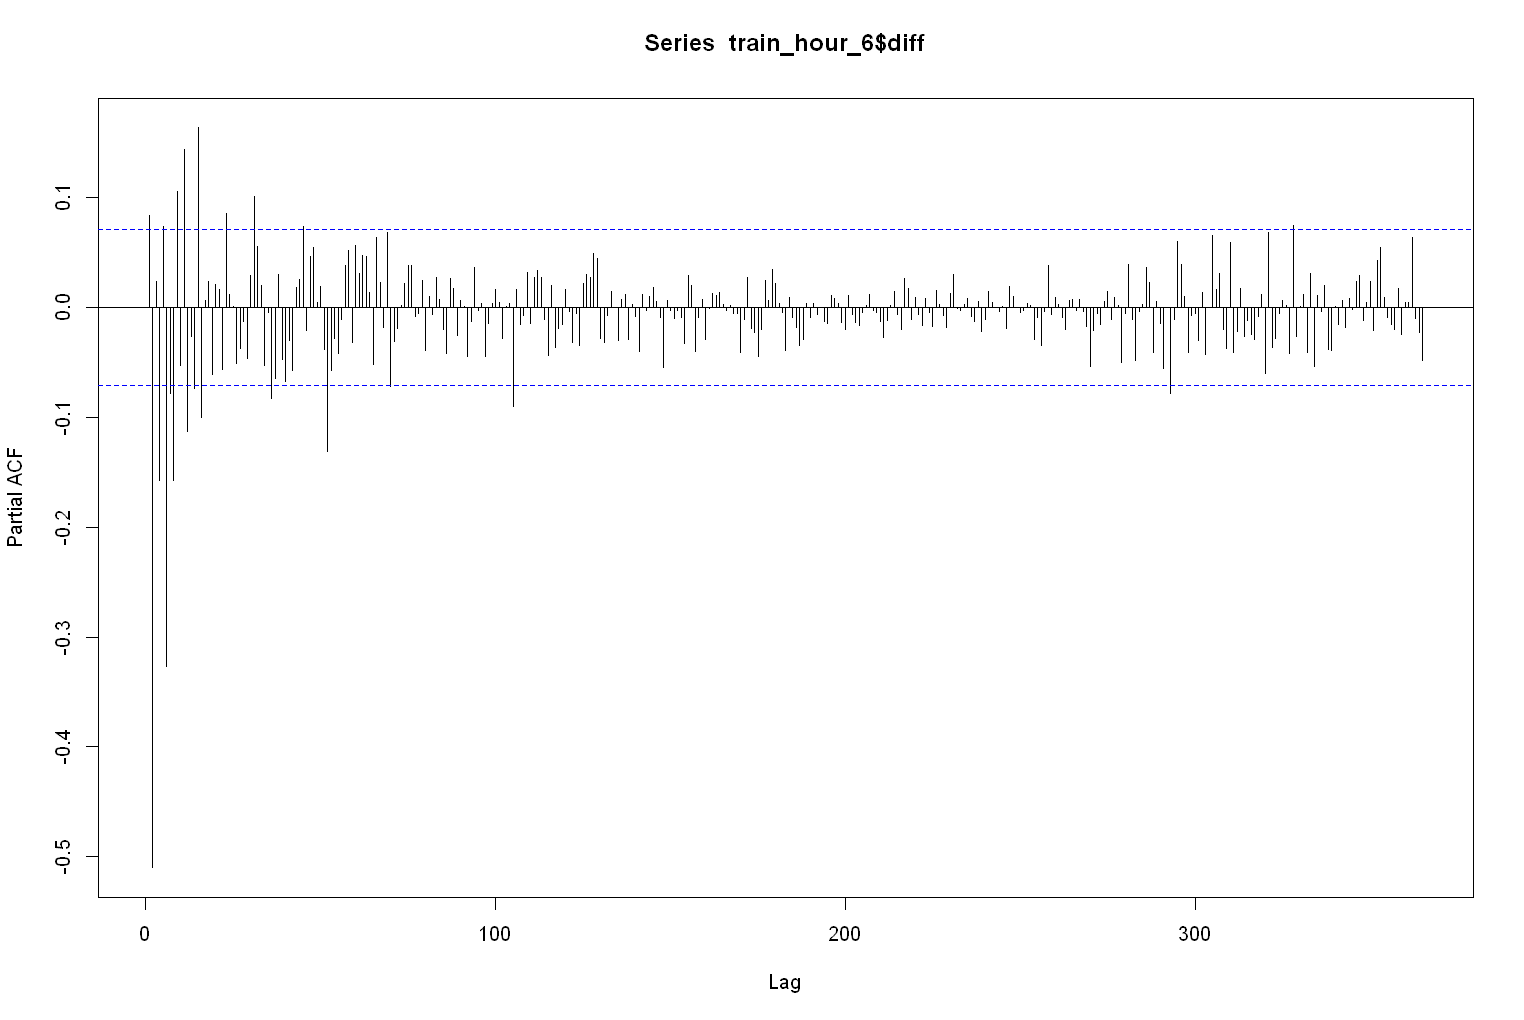

In [35]:
train_hour_6 <- na.omit(train_hour_6)
train_hour_6[,diff:=production - prod_lag_24]

ggplot(train_hour_6,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_6$diff,lag.max = 365)
pacf(train_hour_6$diff,lag.max = 365)

Simple ARIMA Model:

In [36]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_6$diff)
print(summary(simple_model))

Series: train_hour_6$diff 
ARIMA(0,0,3) with zero mean 

Coefficients:
         ma1      ma2      ma3
      0.2208  -0.7310  -0.0796
s.e.  0.0360   0.0251   0.0351

sigma^2 = 0.3312:  log likelihood = -655.36
AIC=1318.71   AICc=1318.77   BIC=1337.23

Training set error measures:
                       ME      RMSE       MAE MPE MAPE      MASE         ACF1
Training set -0.006106597 0.5743883 0.2654514 NaN  Inf 0.6350271 0.0004809009


ARIMA with regressors:

In [37]:
predictors <- setdiff(names(train_hour_6), c("date", "hour", "production", "diff"))

# Convert predictors to a numeric matrix
predictor_matrix <- as.matrix(train_hour_6[, ..predictors])

# Perform auto.arima
arima_model_regressors <- auto.arima(train_hour_6$diff, xreg = predictor_matrix)

# Summary of the auto.arima model
summary(arima_model_regressors)

ERROR: Error in auto.arima(train_hour_6$diff, xreg = predictor_matrix): No suitable ARIMA model found


Since no suitable model is found, we will test with the simple ARIMA model.

In [69]:
train_model <- Arima(train_hour_6$diff, order = c(0, 0, 3))
test_hour_6[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_6))

for (i in 1:nrow(test_hour_6)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_6$diff, test_hour_6$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_6[,predicted:= prod_lag_24 + predictions]

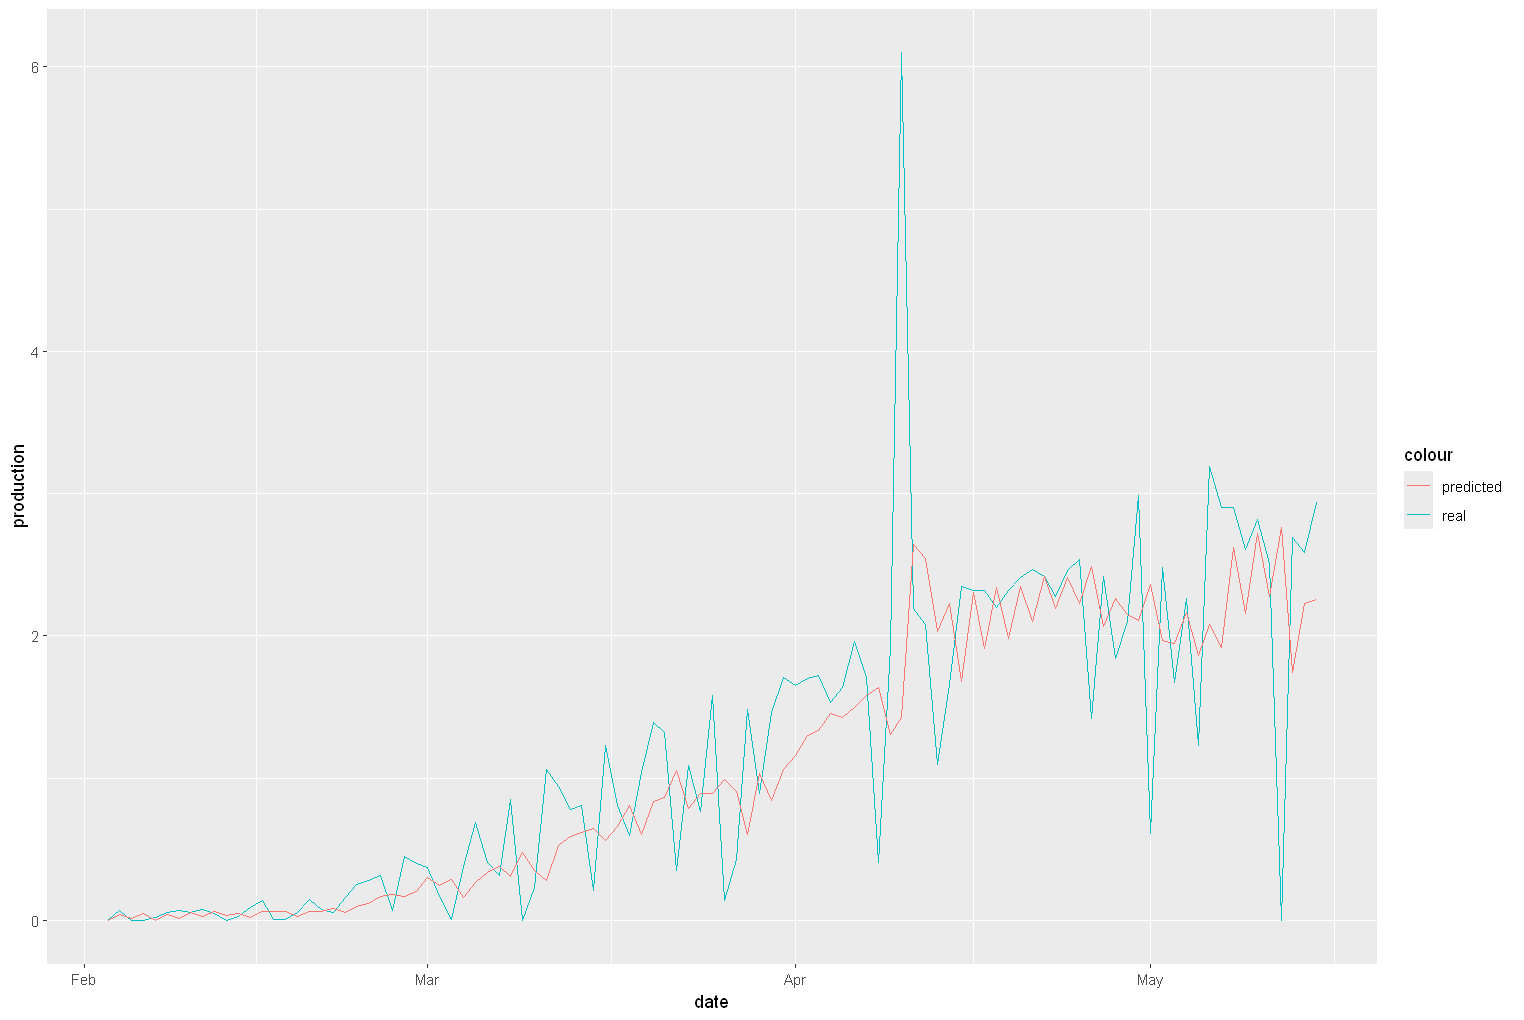

In [70]:
ggplot(test_hour_6,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 7

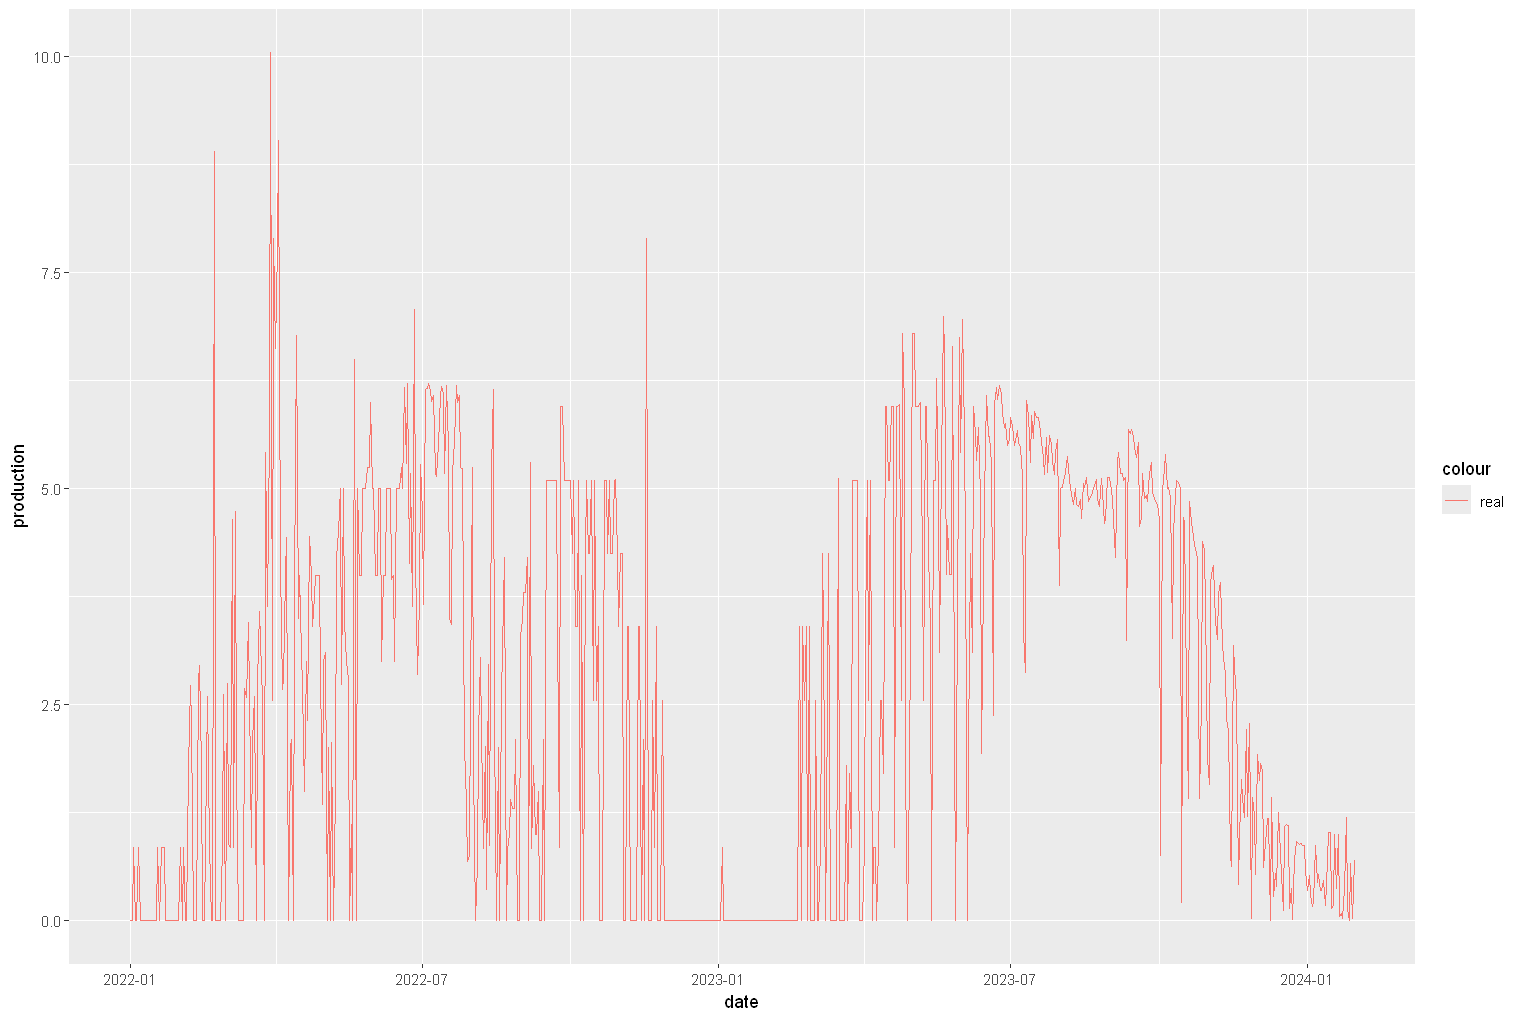

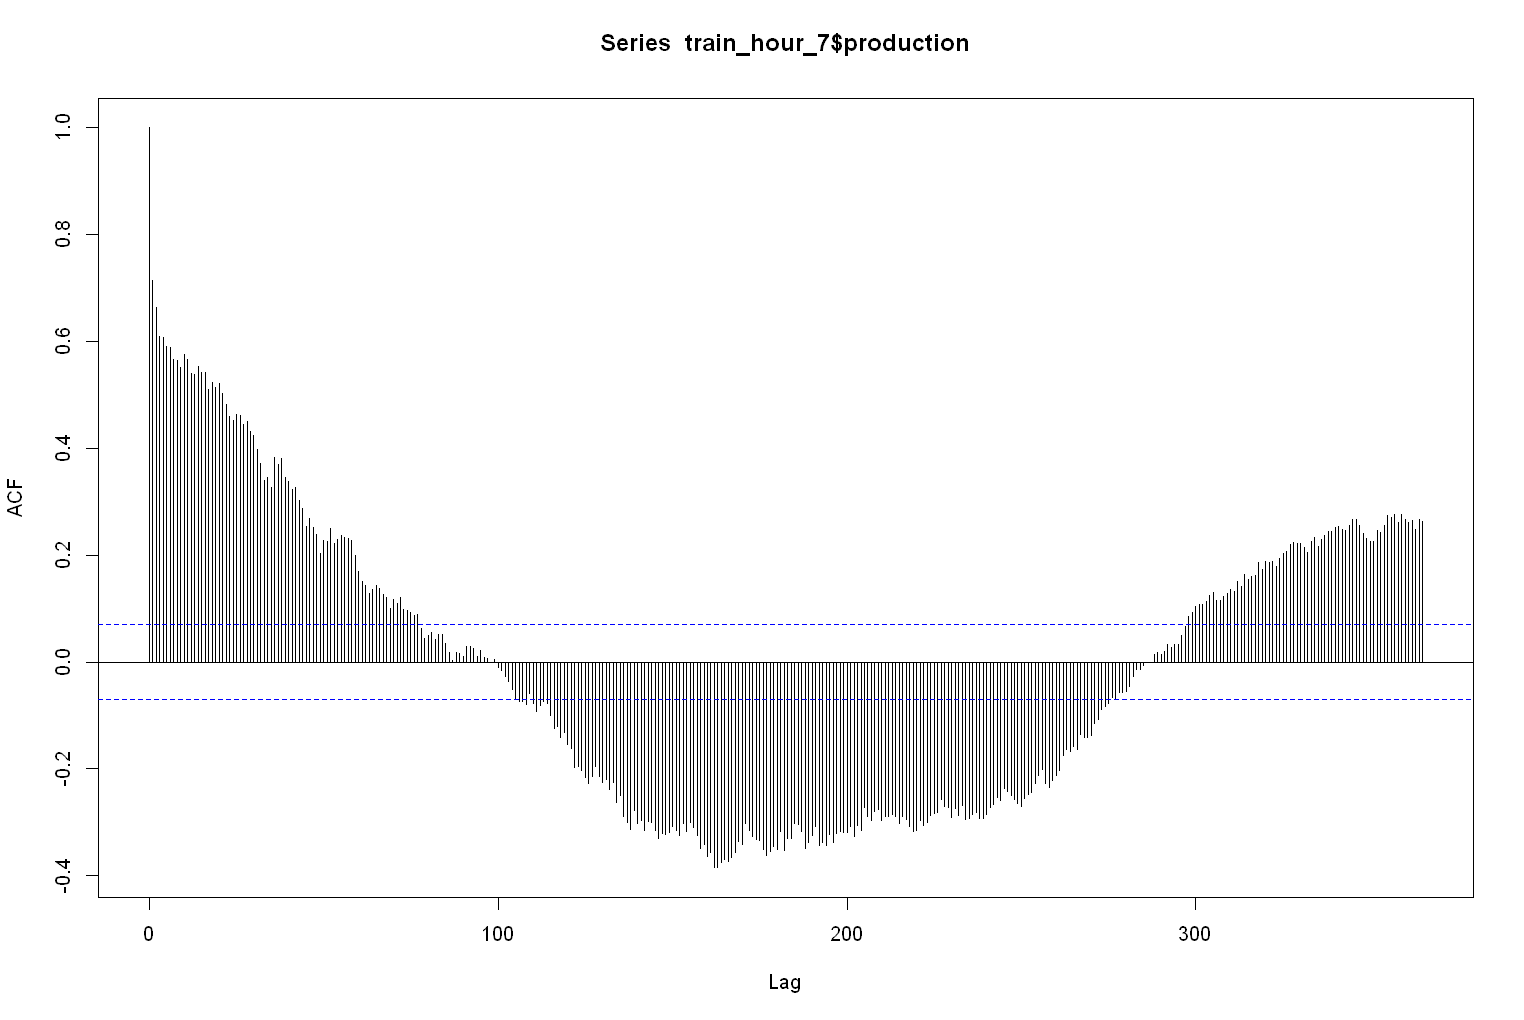

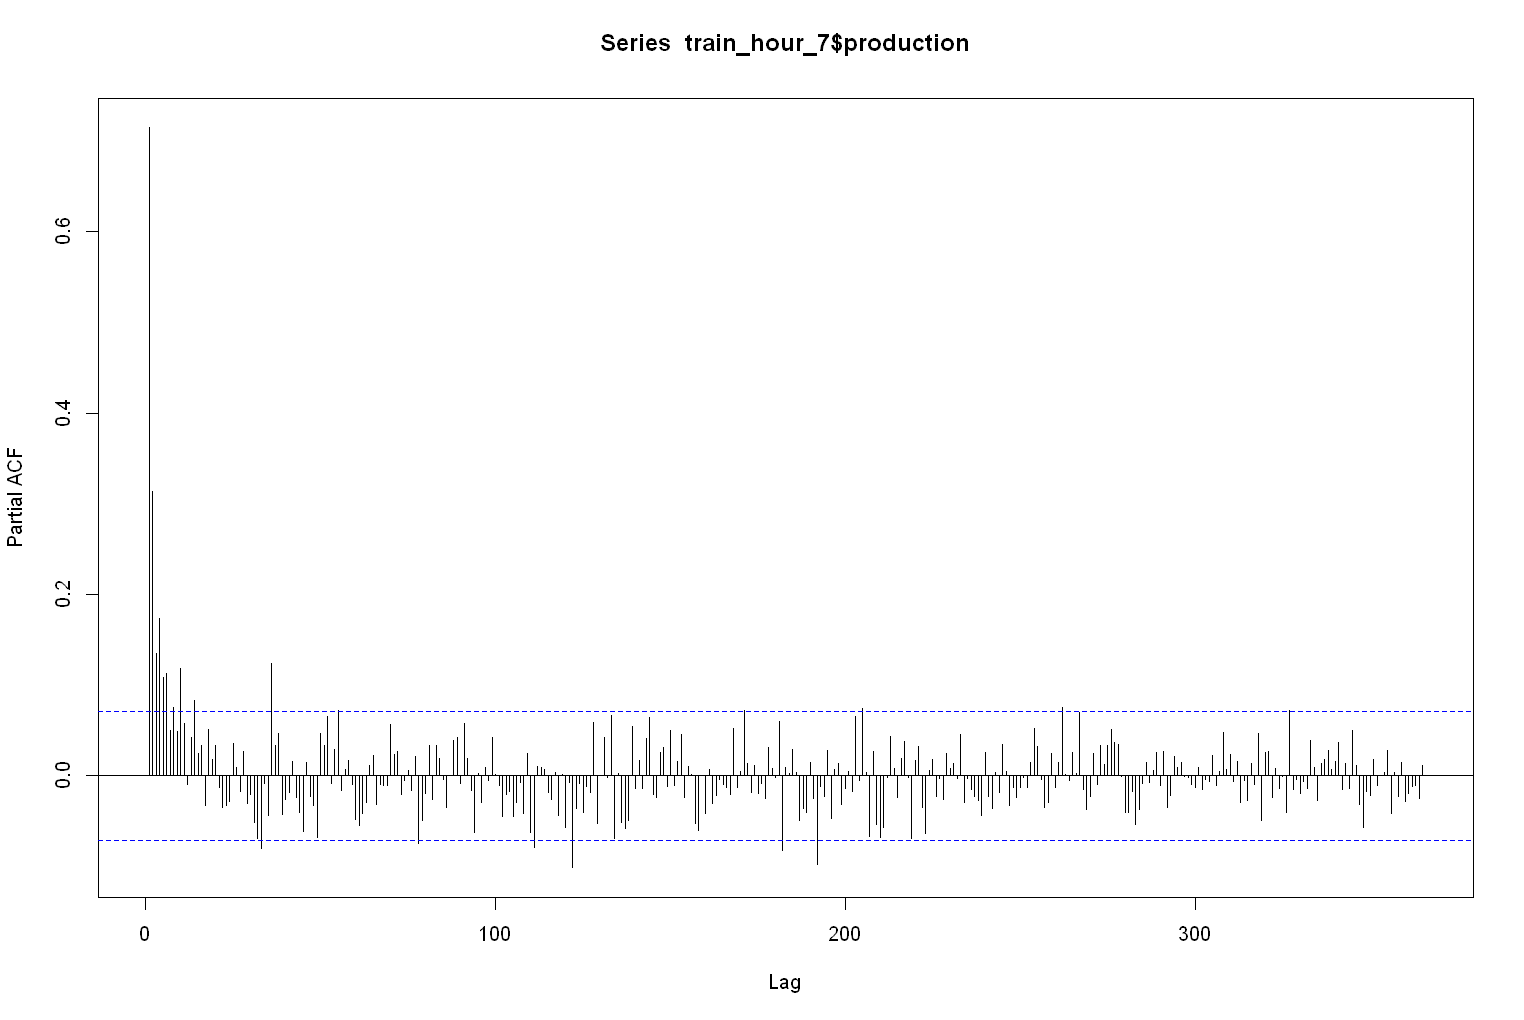

In [71]:
train_hour_7 <- train_split_data_tables[["7"]]
test_hour_7 <- test_split_data_tables[["7"]]

ggplot(train_hour_7,aes(x=date)) + geom_line(aes(y=production,color='real'))
acf(train_hour_7$production,lag.max = 365)
pacf(train_hour_7$production,lag.max = 365)

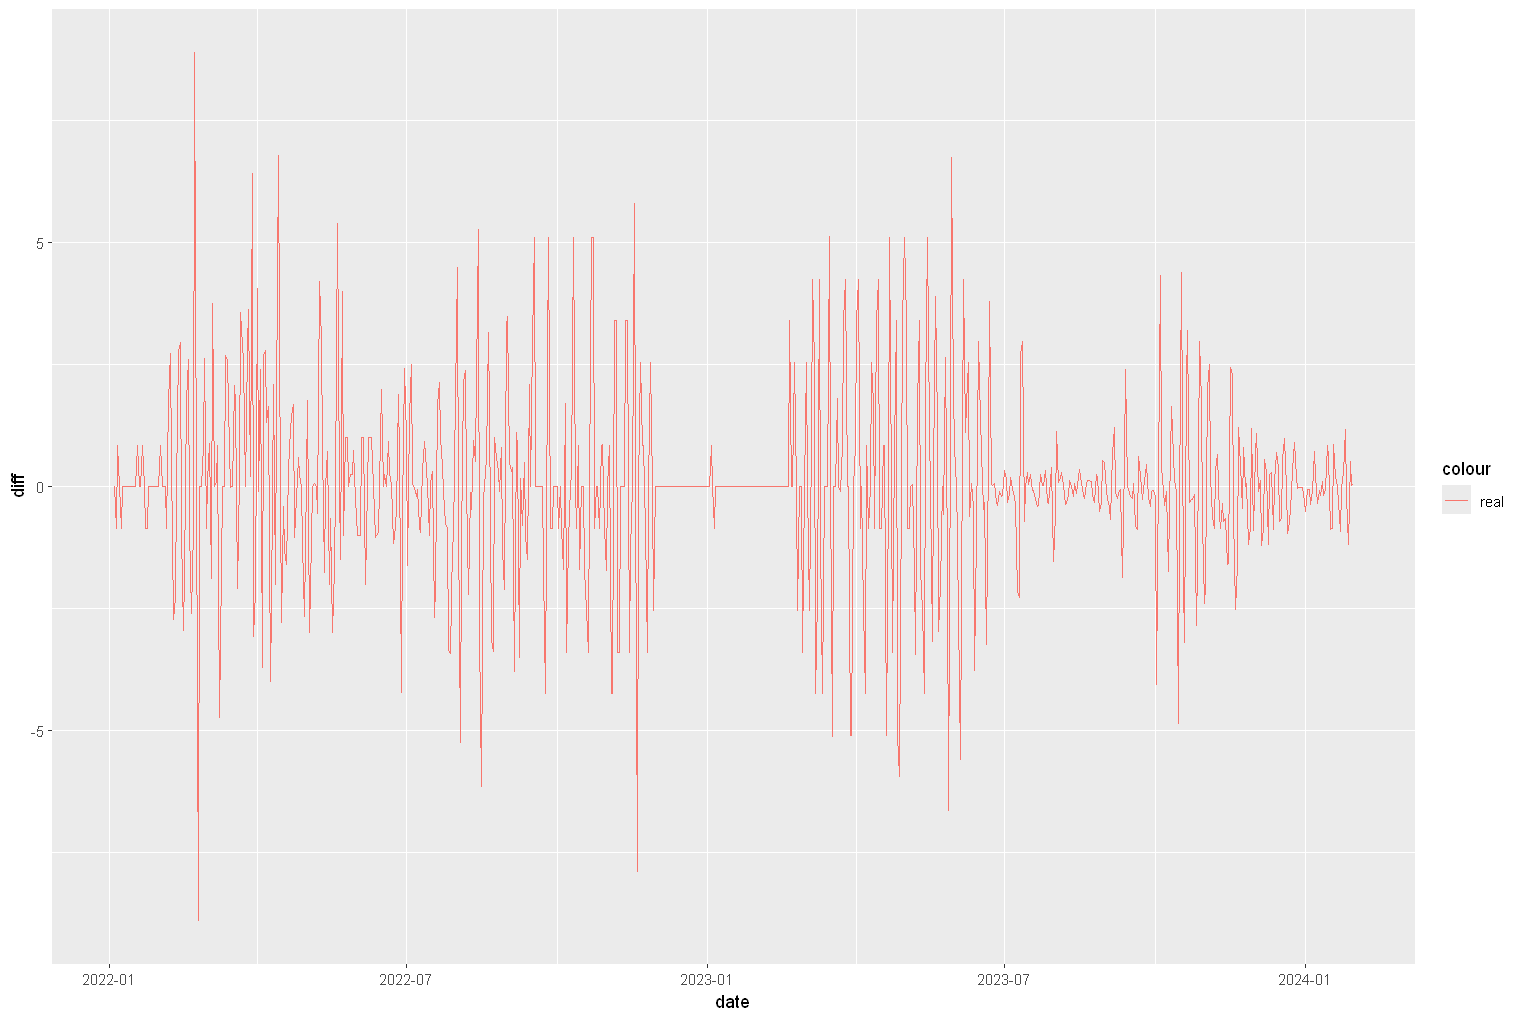

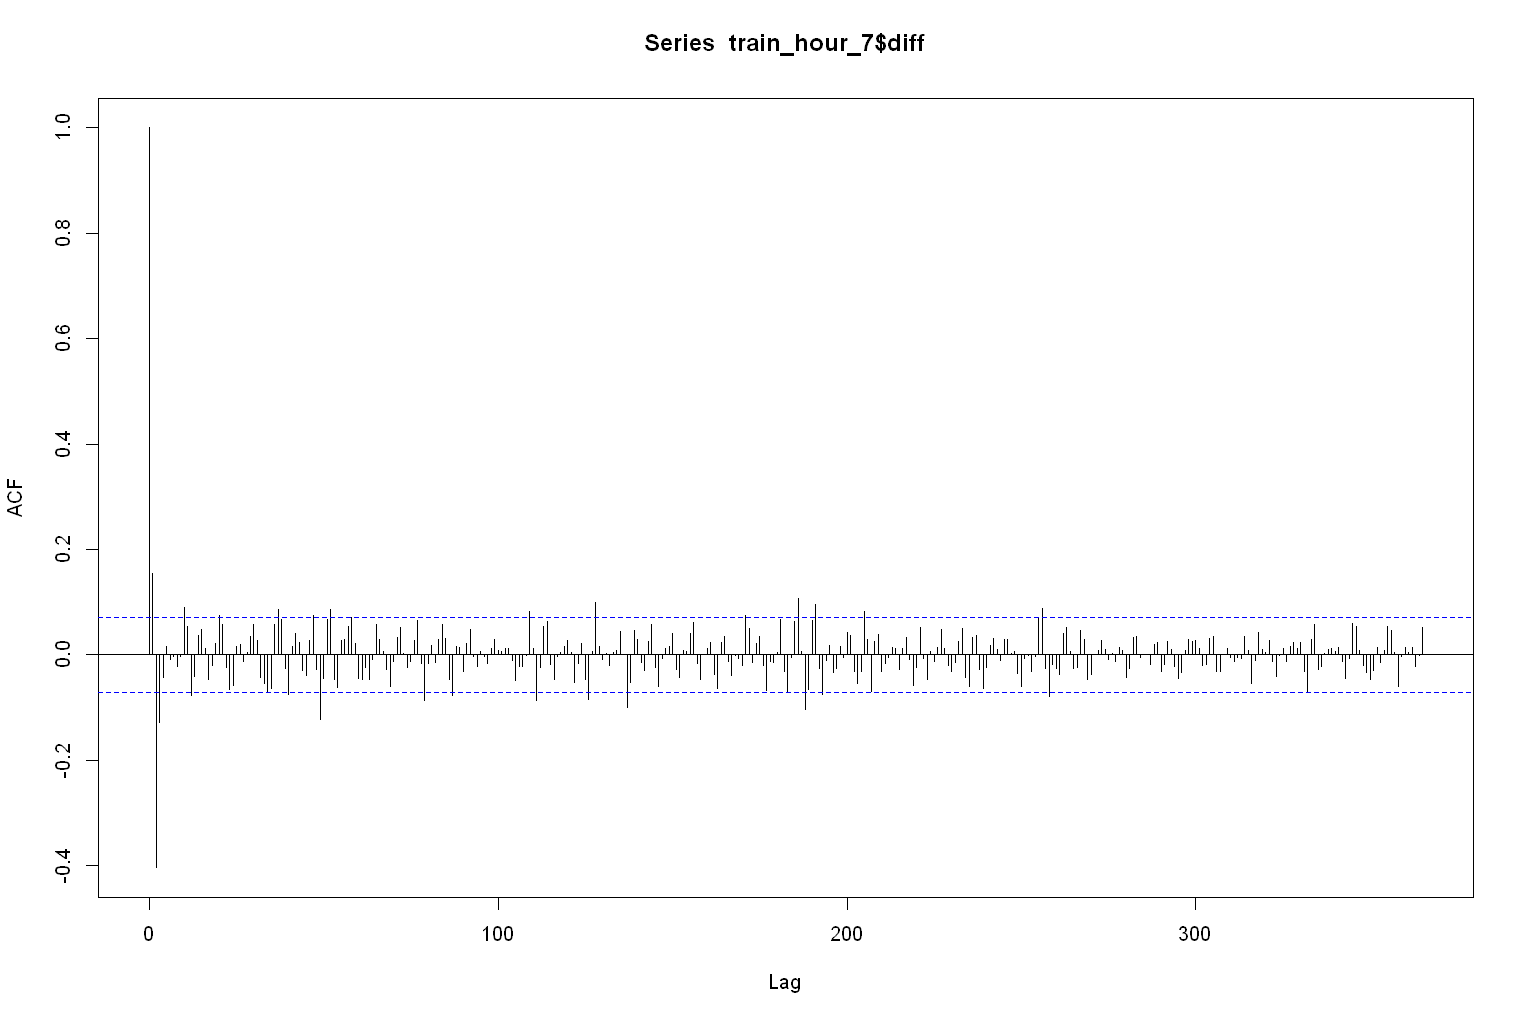

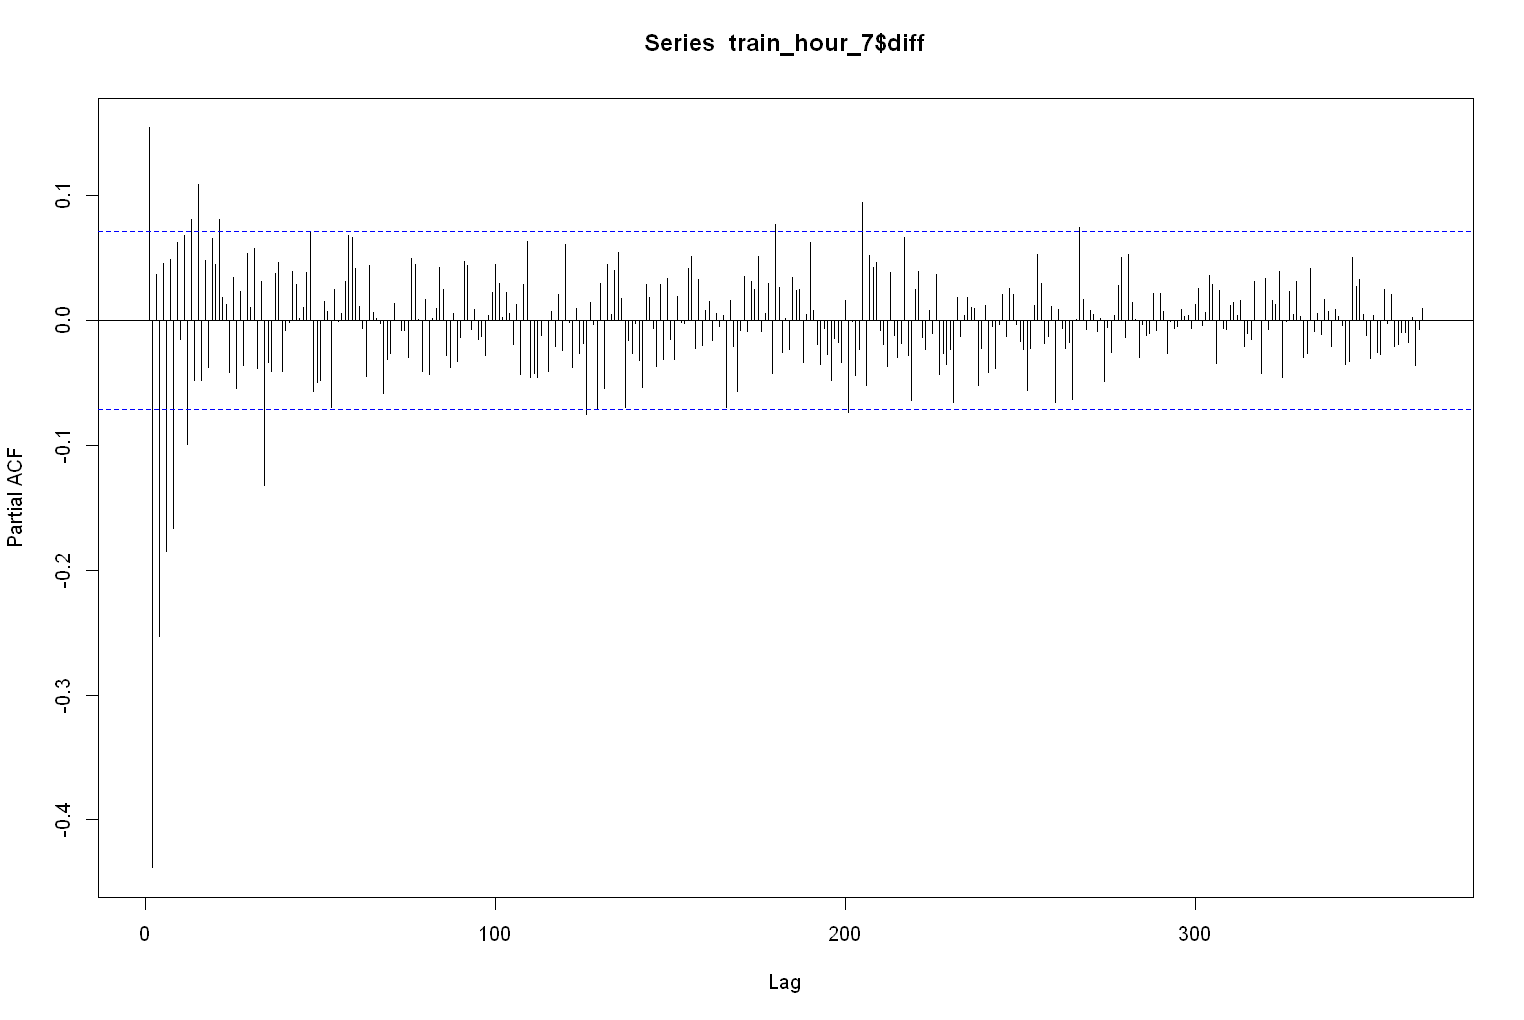

In [72]:
train_hour_7 <- na.omit(train_hour_7)
train_hour_7[,diff:=production - prod_lag_24]

ggplot(train_hour_7,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_7$diff,lag.max = 365)
pacf(train_hour_7$diff,lag.max = 365)

In [73]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_7$diff)
print(summary(simple_model))

Series: train_hour_7$diff 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1      ma2
      0.1603  0.1911  -0.7010
s.e.  0.0537  0.0375   0.0318

sigma^2 = 2.386:  log likelihood = -1400.91
AIC=2809.81   AICc=2809.87   BIC=2828.32

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set 0.05620919 1.541624 1.040589 NaN  Inf 0.6586888 -0.006162245


In [ ]:
predictors <- setdiff(names(train_hour_7), c("date", "hour", "production", "diff"))

# Convert predictors to a numeric matrix
predictor_matrix <- as.matrix(train_hour_7[, ..predictors])

# Perform auto.arima
arima_model_regressors <- auto.arima(train_hour_7$diff, xreg = predictor_matrix)

# Summary of the auto.arima model
summary(arima_model_regressors)

ERROR: Error in auto.arima(train_hour_7$diff, xreg = predictor_matrix): No suitable ARIMA model found


Since we have too many variables, auto arima function is not working with such a large regressor matrix.

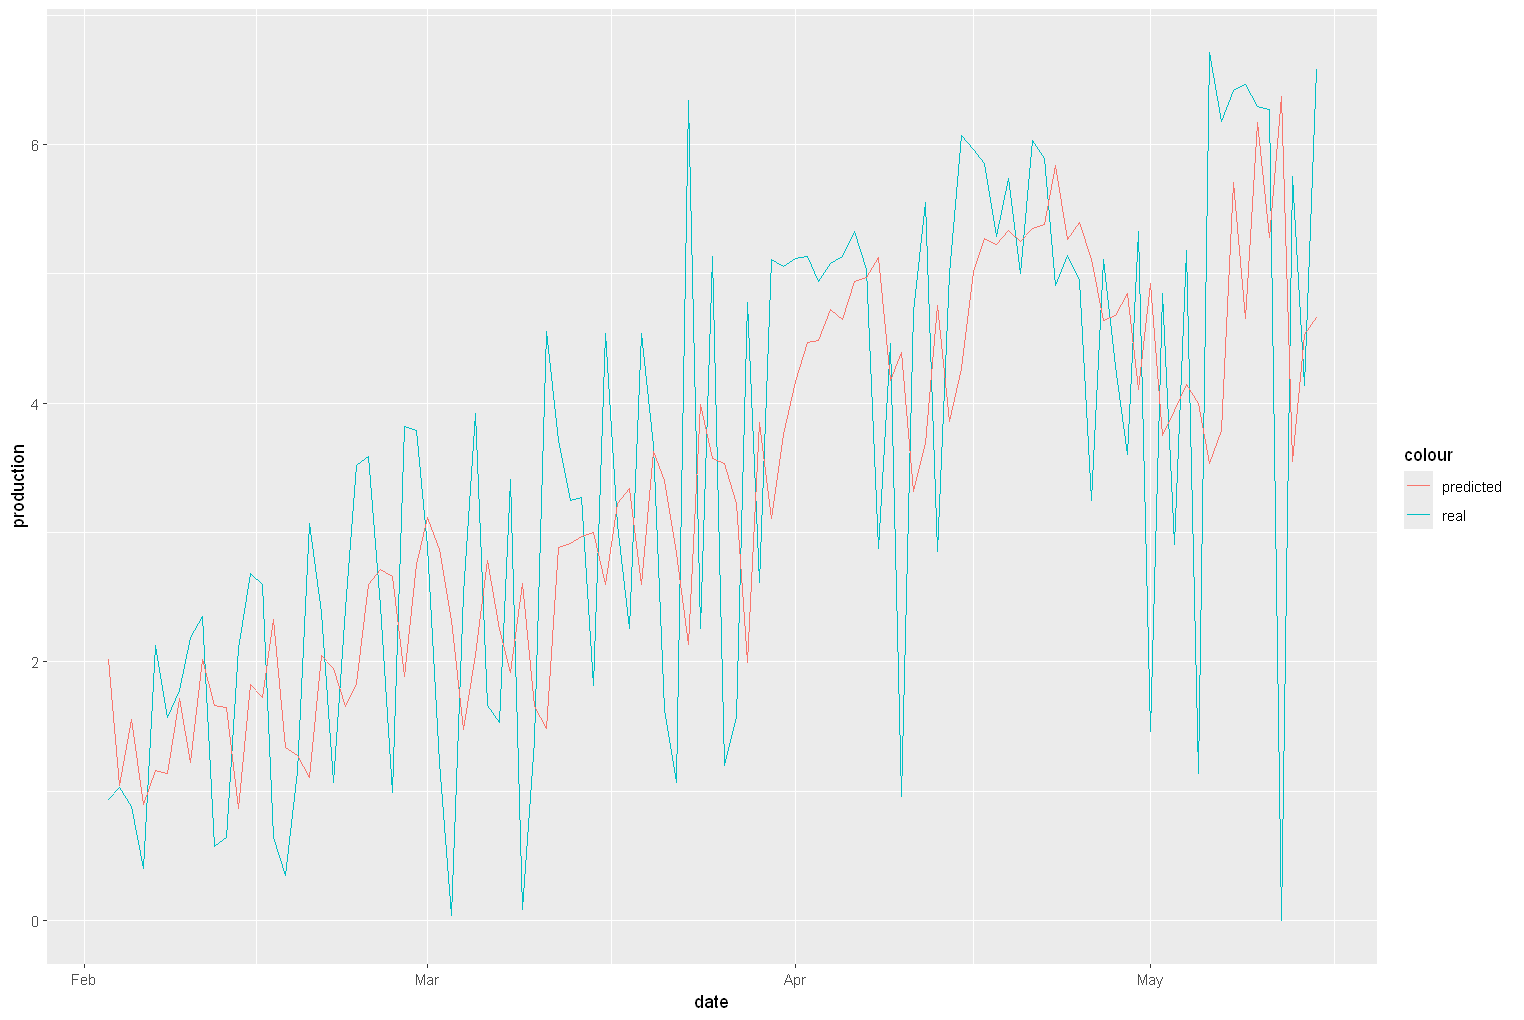

In [74]:
train_model <- Arima(train_hour_7$diff, order = c(1, 0, 2))
test_hour_7[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_7))

for (i in 1:nrow(test_hour_7)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_7$diff, test_hour_7$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_7[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_7,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 8

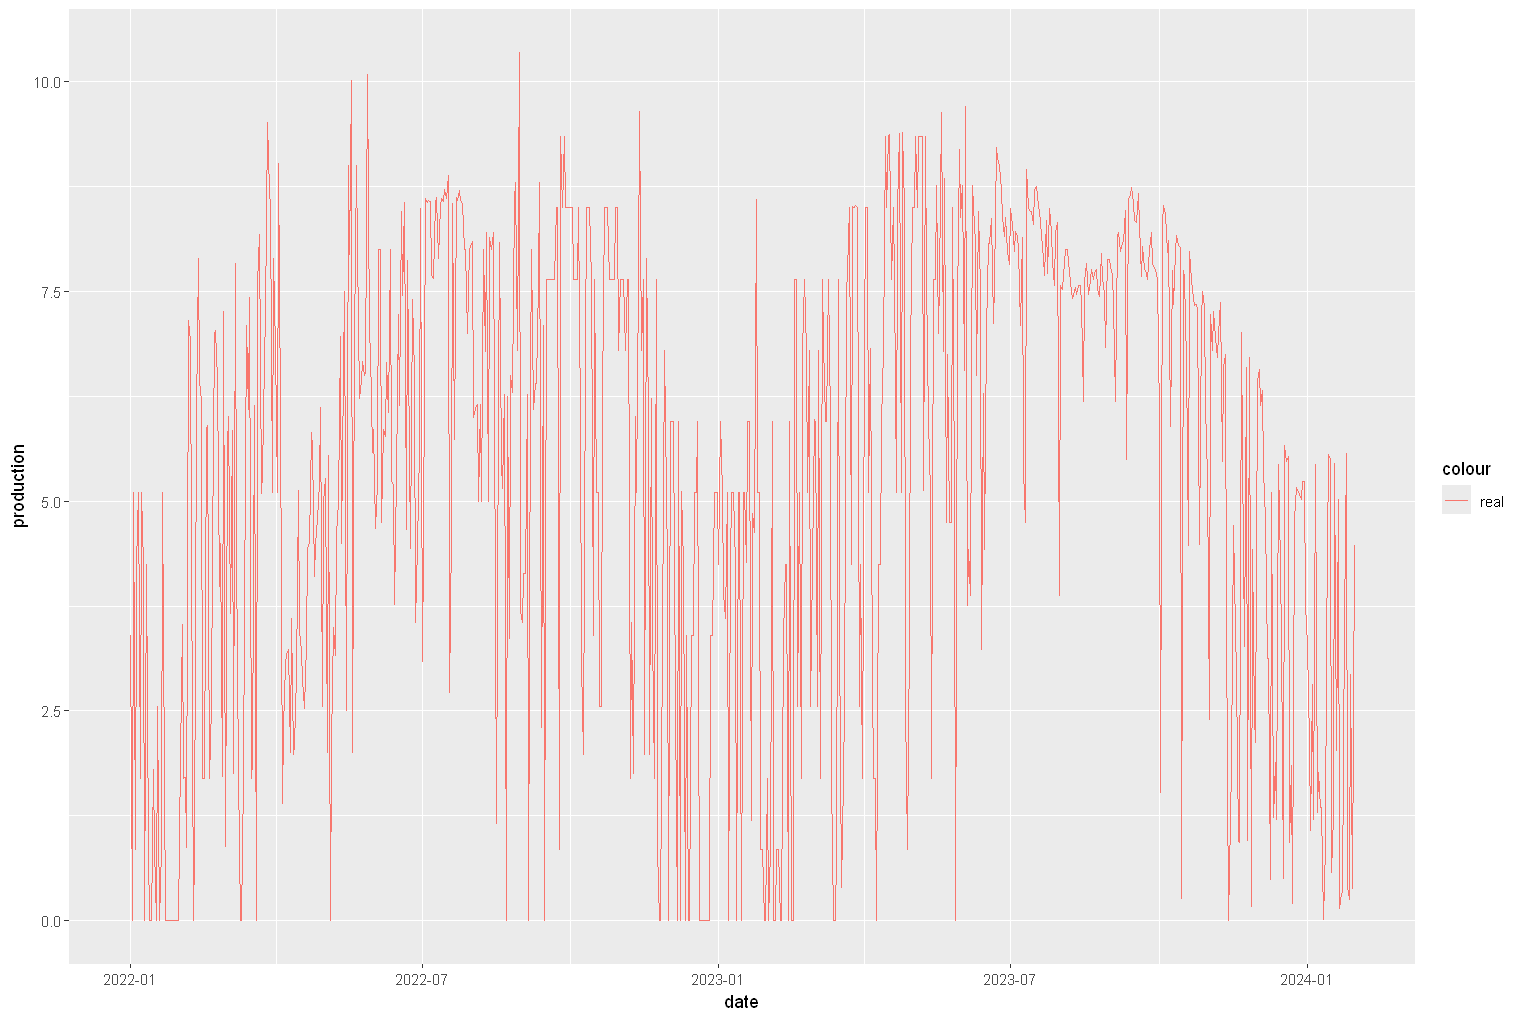

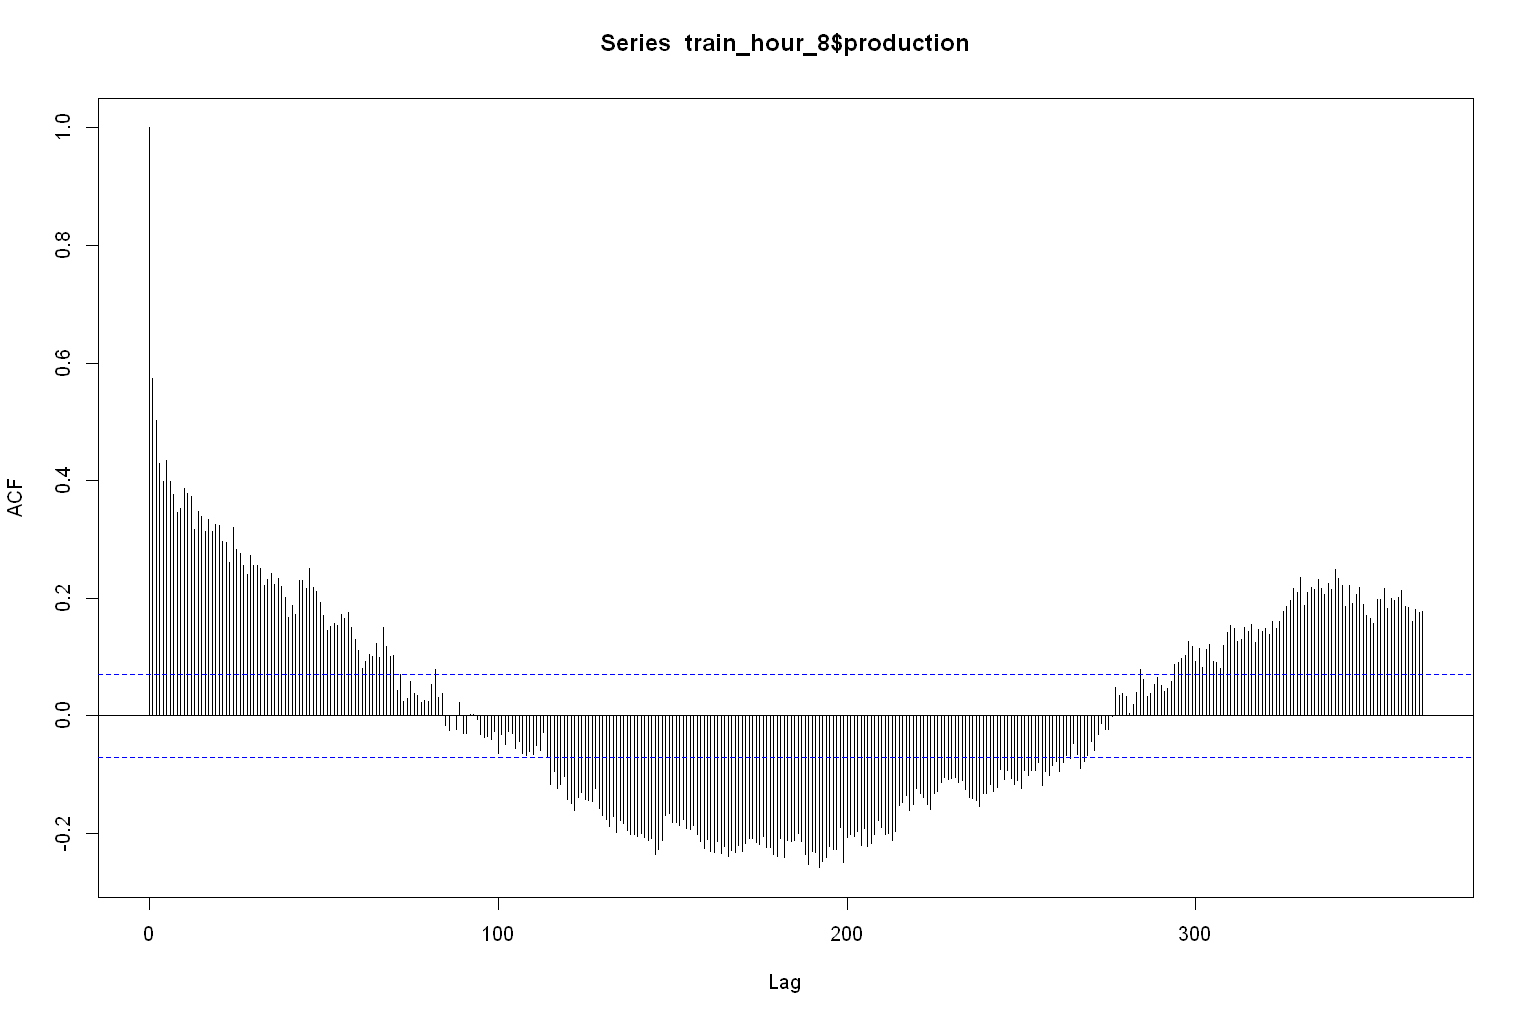

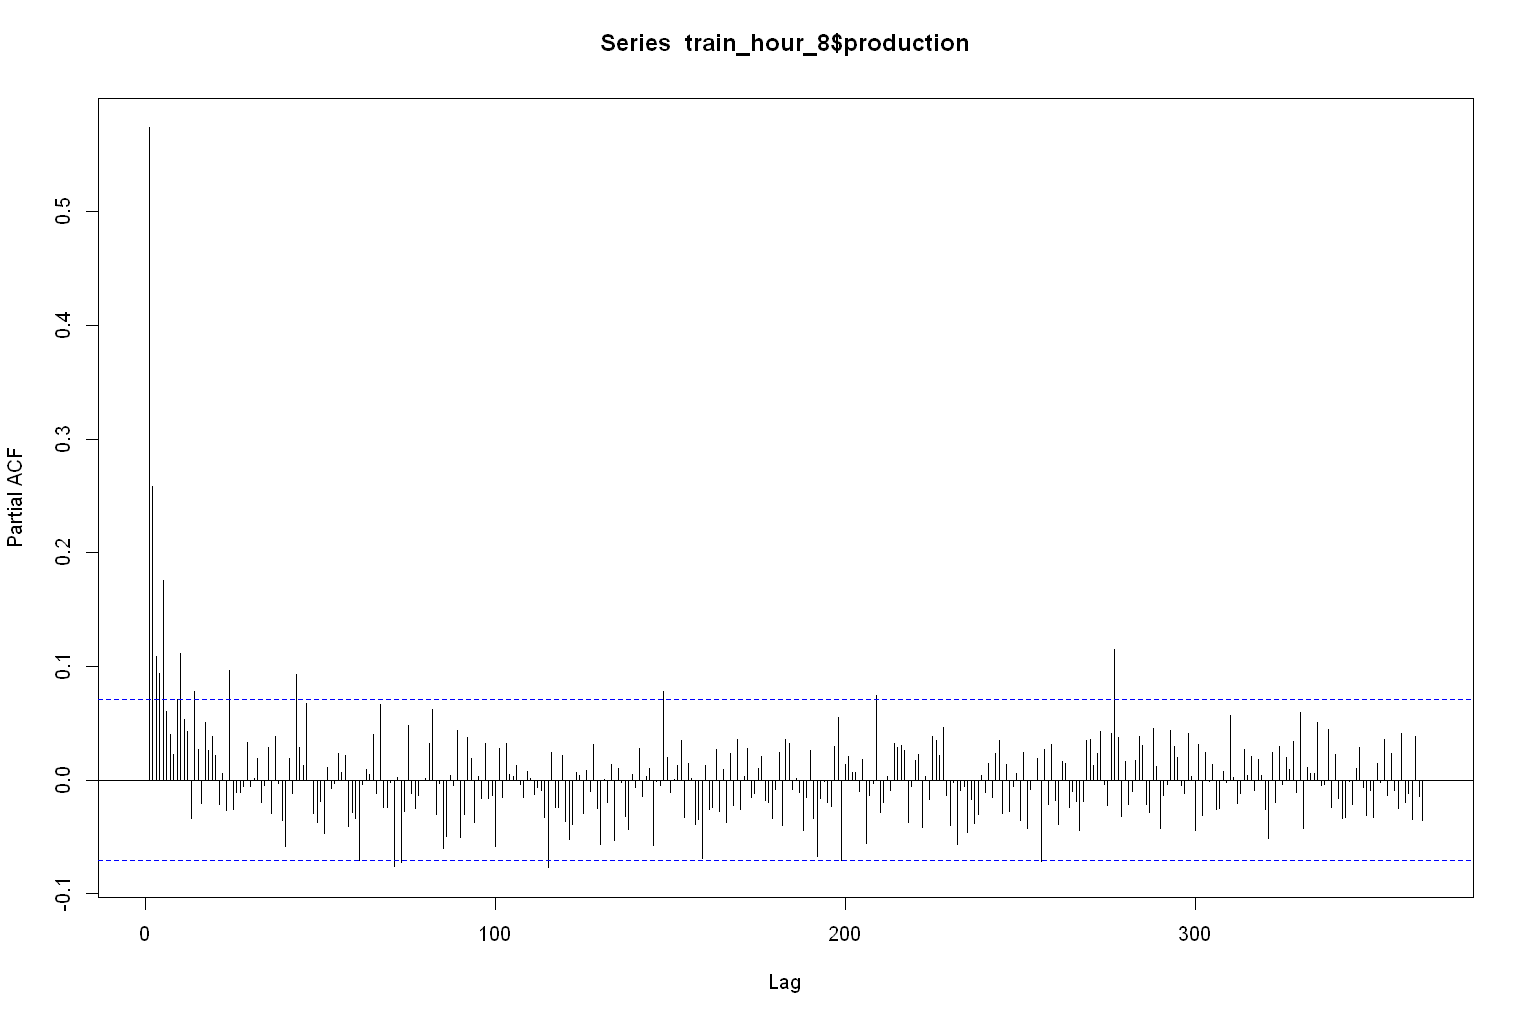

In [75]:
train_hour_8 <- train_split_data_tables[["8"]]
test_hour_8 <- test_split_data_tables[["8"]]

ggplot(train_hour_8,aes(x=date)) + geom_line(aes(y=production,color='real'))
acf(train_hour_8$production,lag.max = 365)
pacf(train_hour_8$production,lag.max = 365)

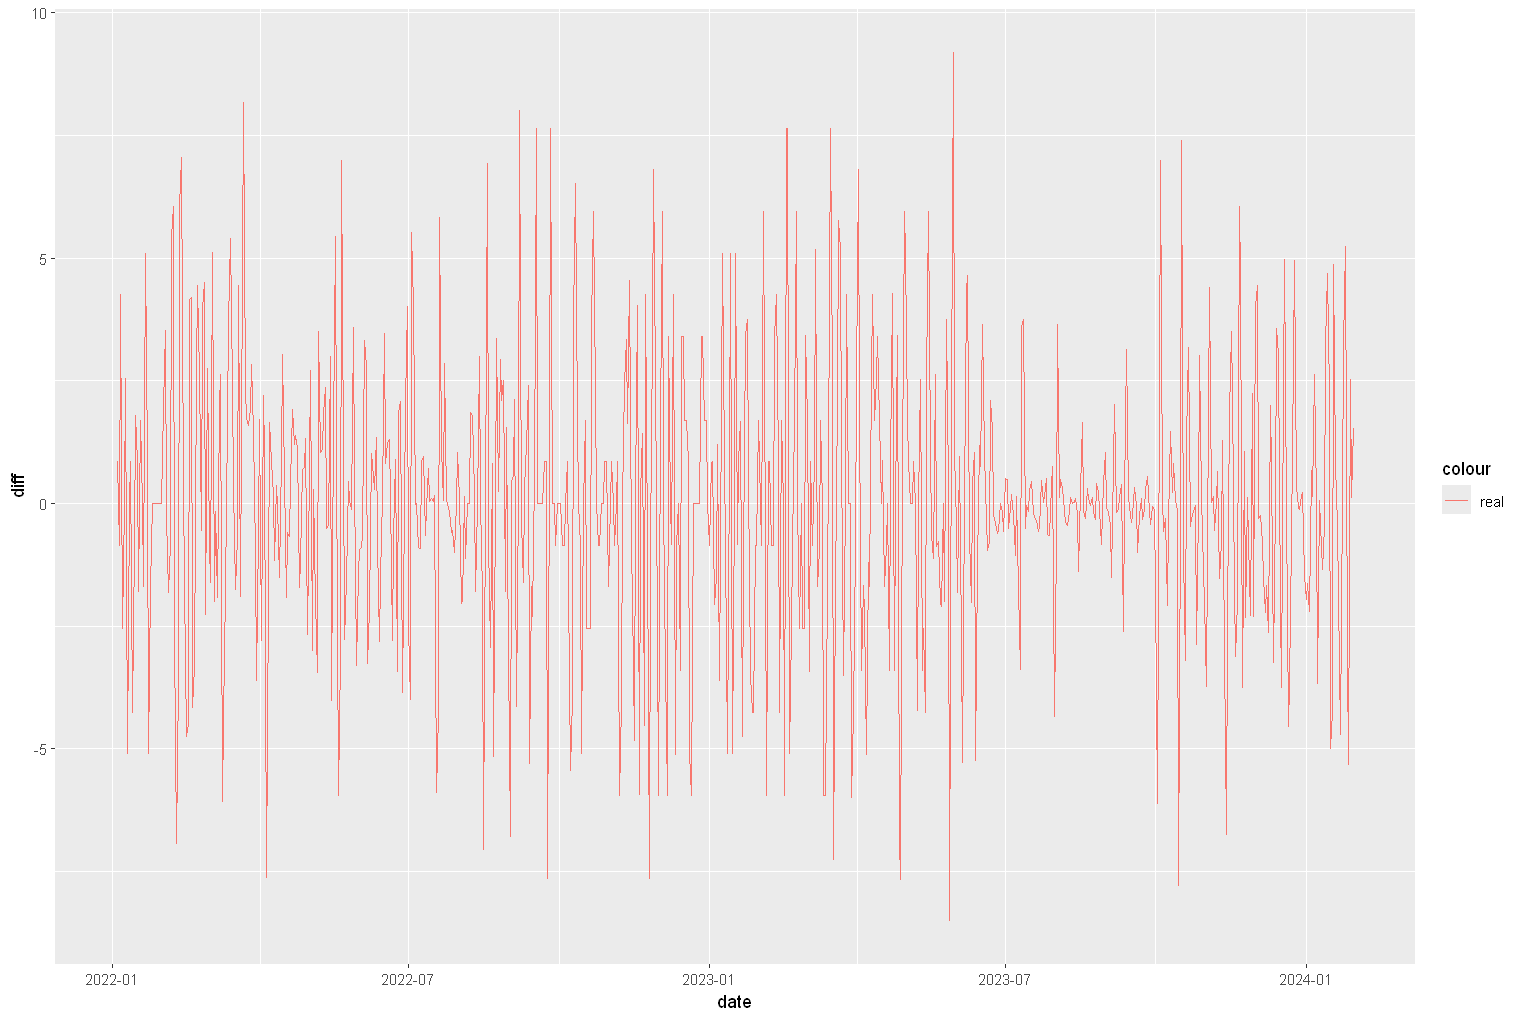

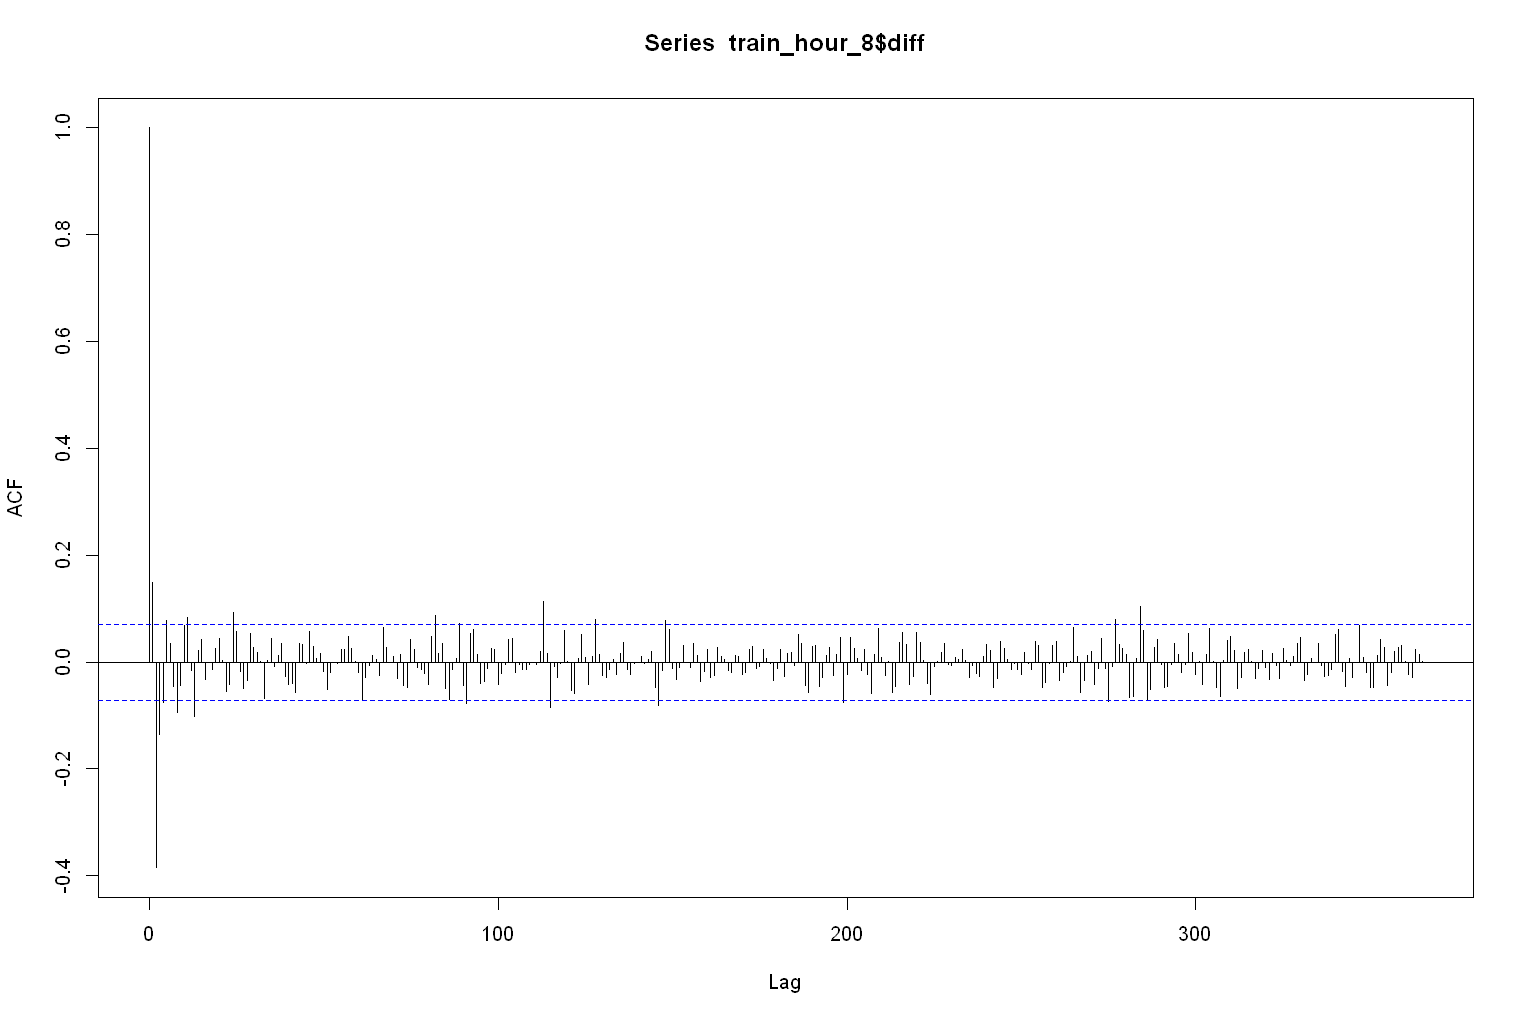

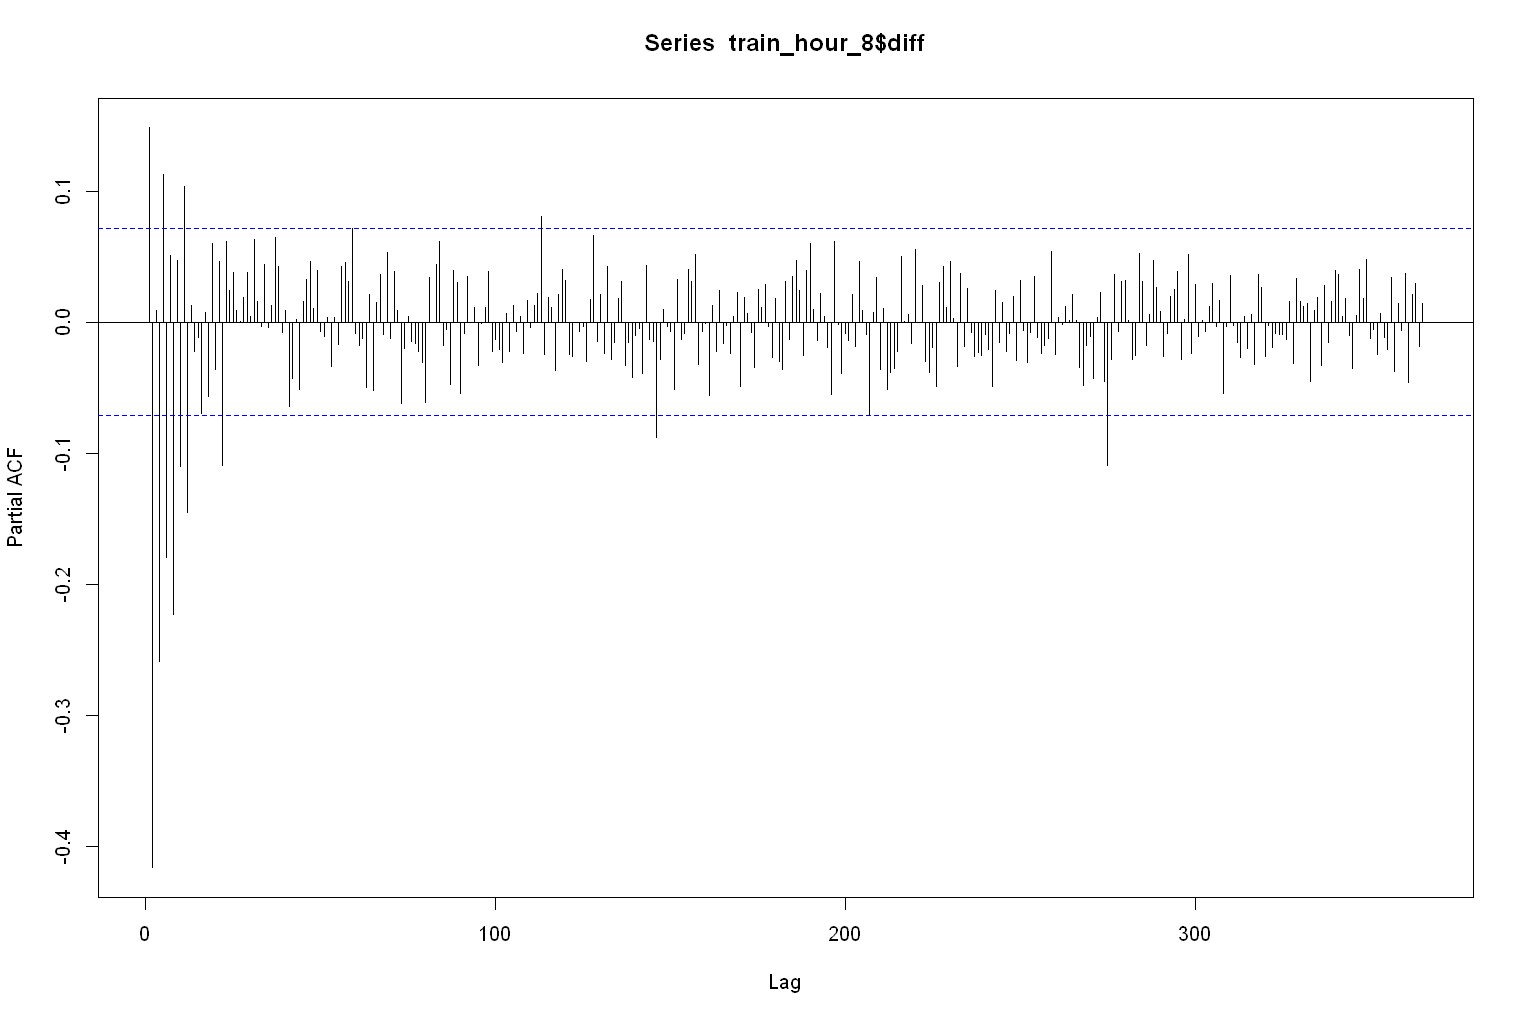

In [76]:
train_hour_8 <- na.omit(train_hour_8)
train_hour_8[,diff:=production - prod_lag_24]

ggplot(train_hour_8,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_8$diff,lag.max = 365)
pacf(train_hour_8$diff,lag.max = 365)

In [77]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_8$diff)
print(summary(simple_model))

Series: train_hour_8$diff 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.9512  0.0530
s.e.  0.0209  0.1842

sigma^2 = 6.776:  log likelihood = -1798.55
AIC=3603.1   AICc=3603.13   BIC=3616.99

Training set error measures:
                       ME     RMSE      MAE MPE MAPE      MASE       ACF1
Training set -0.003066558 2.599714 1.857628 NaN  Inf 0.6910915 -0.3910016


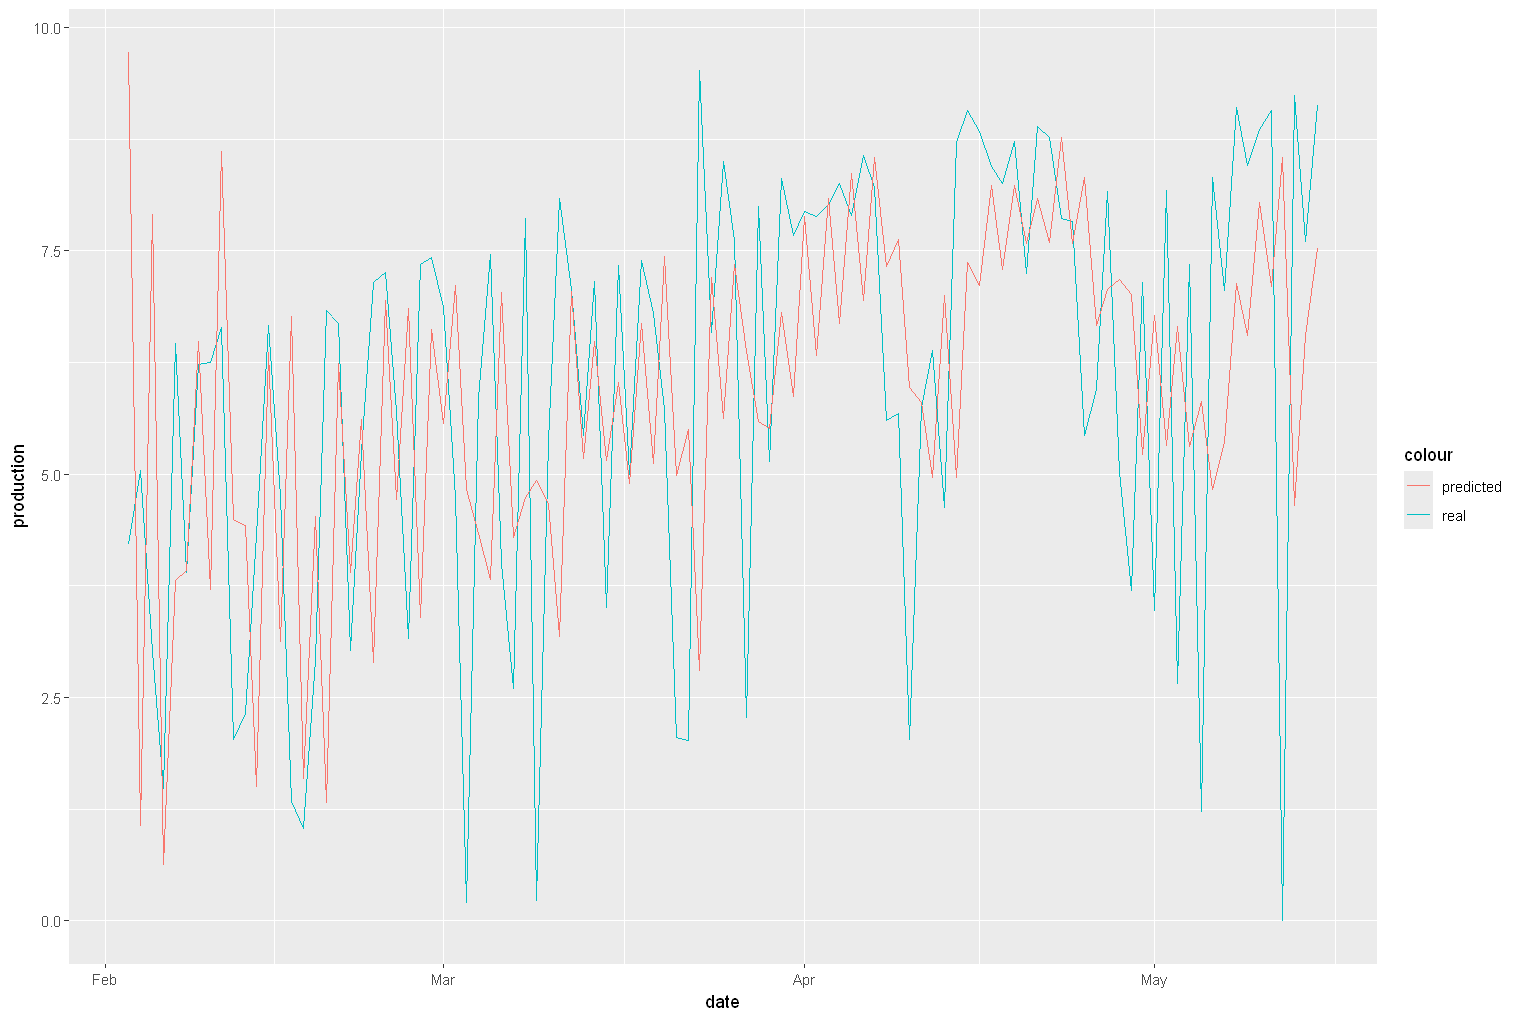

In [78]:
train_model <- Arima(train_hour_8$diff, order = c(0, 0, 1))
test_hour_8[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_8))

for (i in 1:nrow(test_hour_8)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_8$diff, test_hour_8$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_8[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_8,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 9

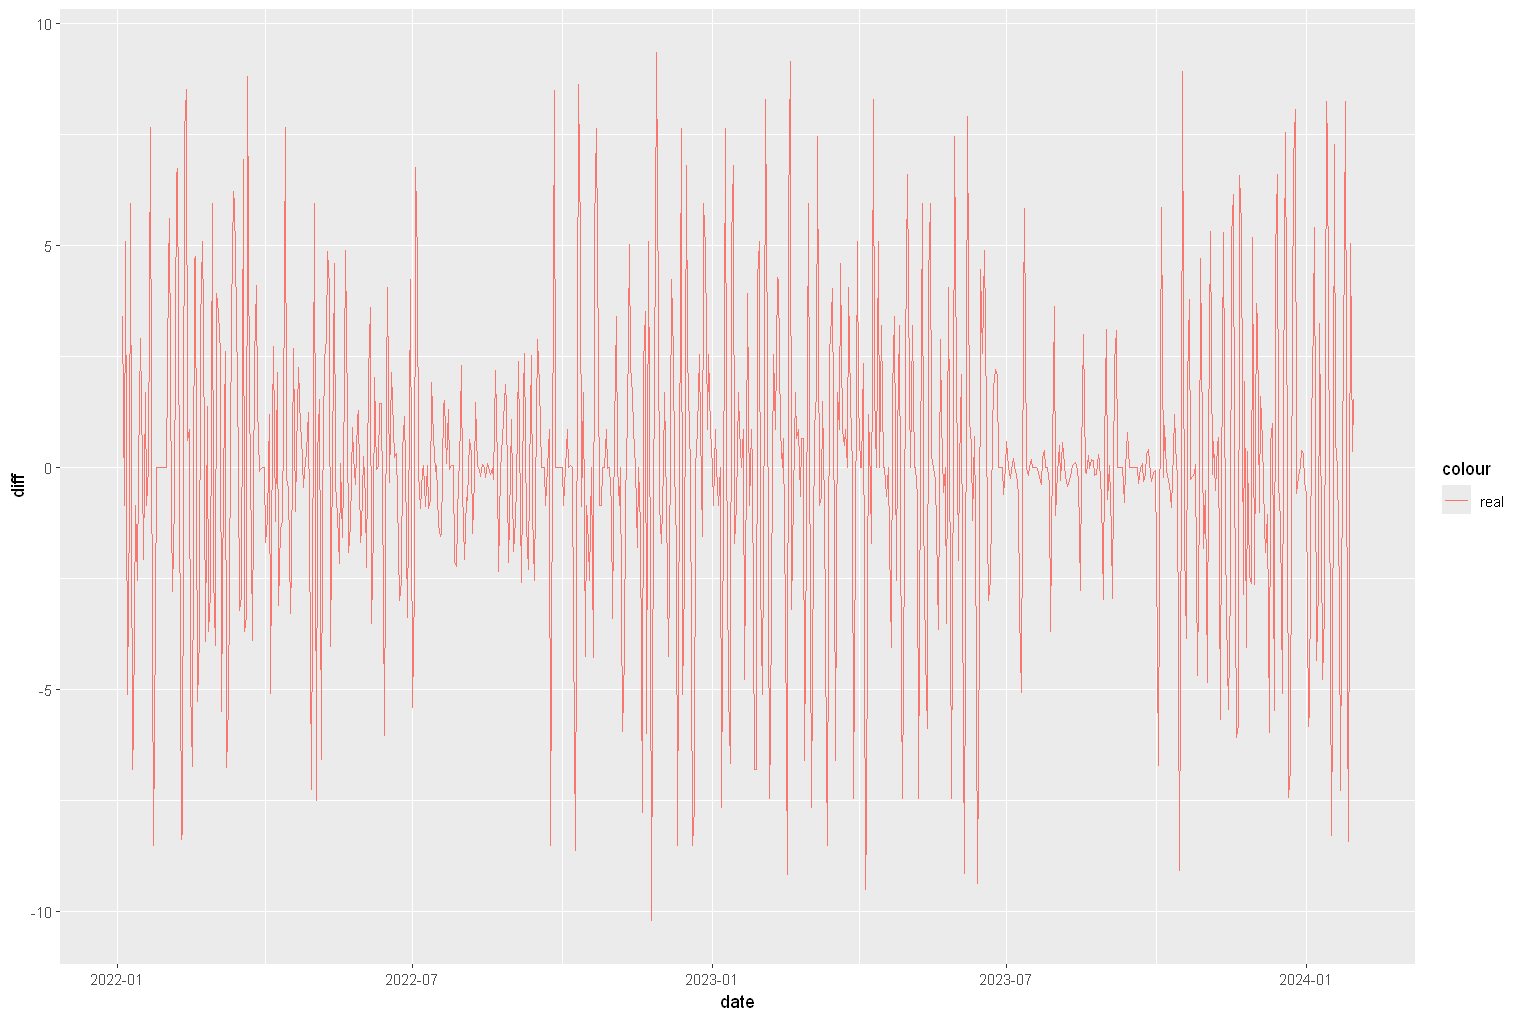

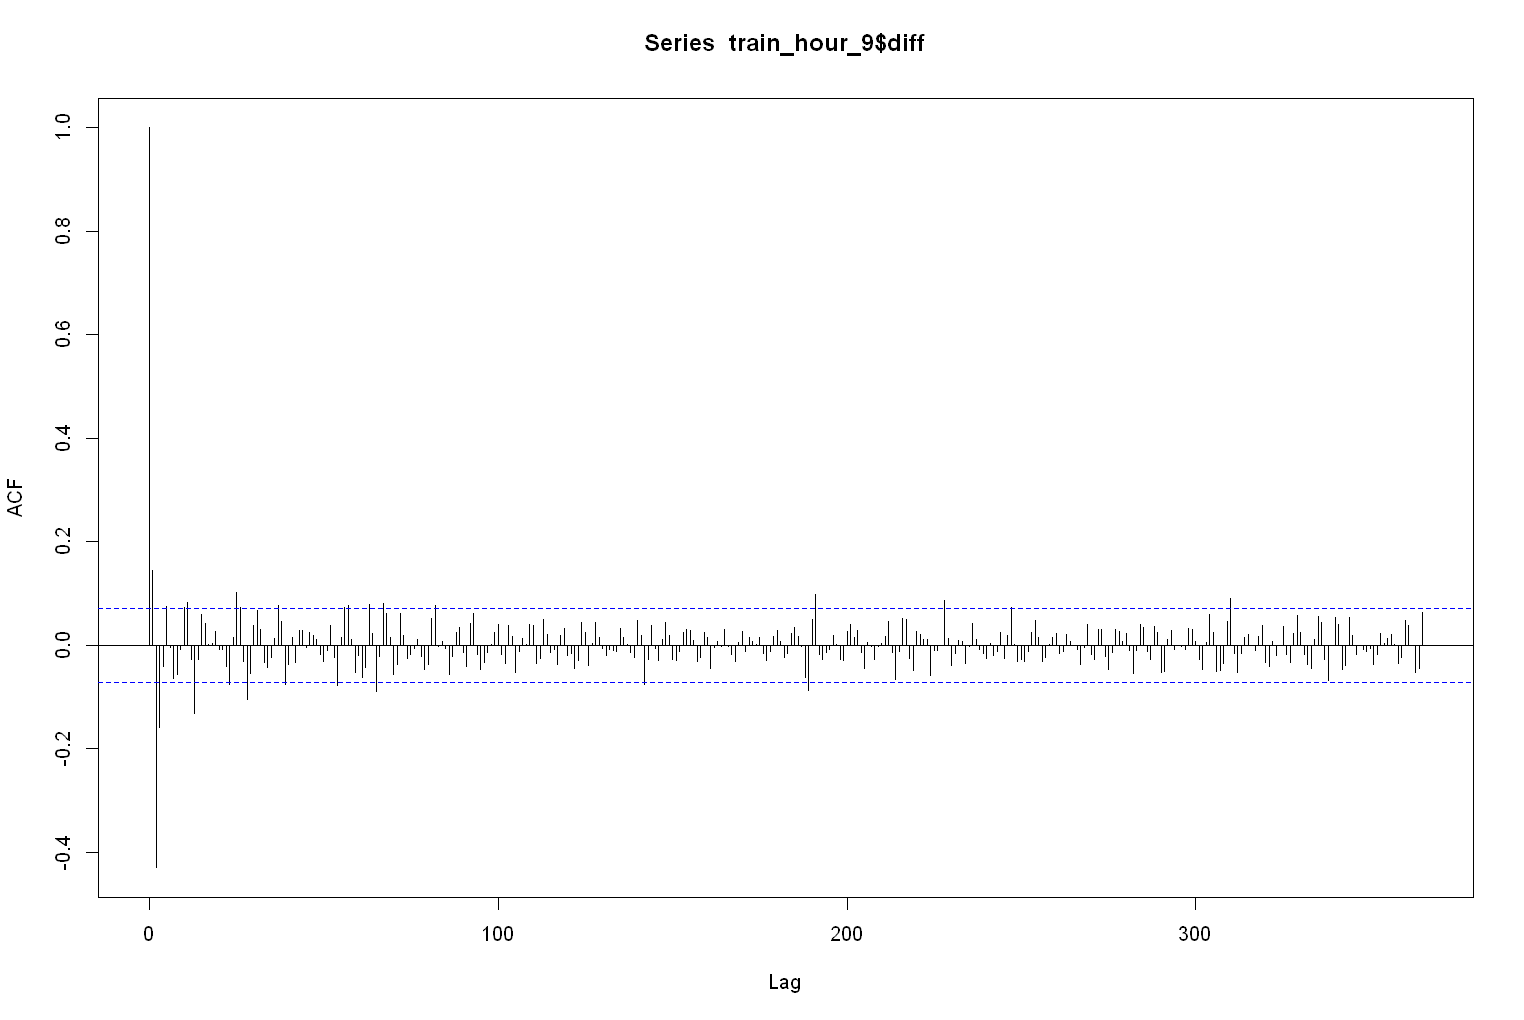

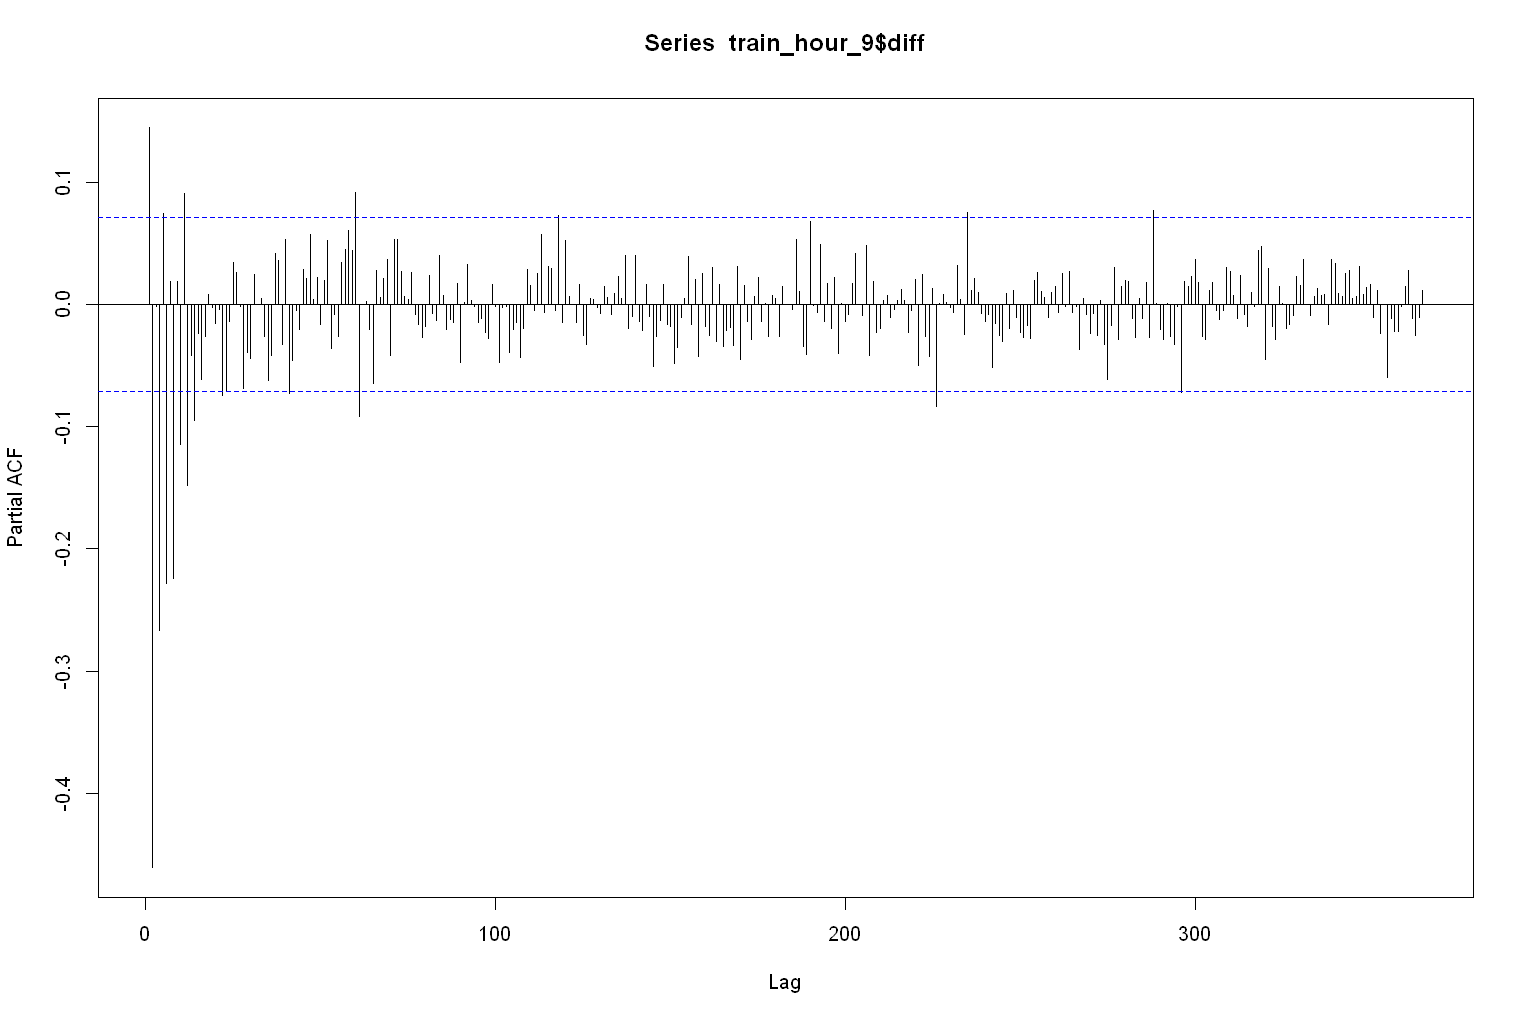

In [79]:
train_hour_9 <- train_split_data_tables[["9"]]
test_hour_9 <- test_split_data_tables[["9"]]

train_hour_9 <- na.omit(train_hour_9)
train_hour_9[,diff:=production - prod_lag_24]

ggplot(train_hour_9,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_9$diff,lag.max = 365)
pacf(train_hour_9$diff,lag.max = 365)

In [80]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_9$diff)
print(summary(simple_model))

Series: train_hour_9$diff 
ARIMA(5,0,5) with zero mean 

Coefficients:
         ar1      ar2      ar3     ar4     ar5     ma1      ma2     ma3
      0.0888  -0.1595  -0.4161  0.1164  0.1286  0.2109  -0.6104  0.3533
s.e.  0.1806   0.2234   0.1973  0.0777  0.0432  0.1774   0.2460  0.2279
          ma4      ma5
      -0.1982  -0.4698
s.e.   0.2007   0.1961

sigma^2 = 6.849:  log likelihood = -1798.68
AIC=3619.37   AICc=3619.72   BIC=3670.29

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE        ACF1
Training set 0.05638456 2.599707 1.956106 NaN  Inf 0.6183894 0.002009763


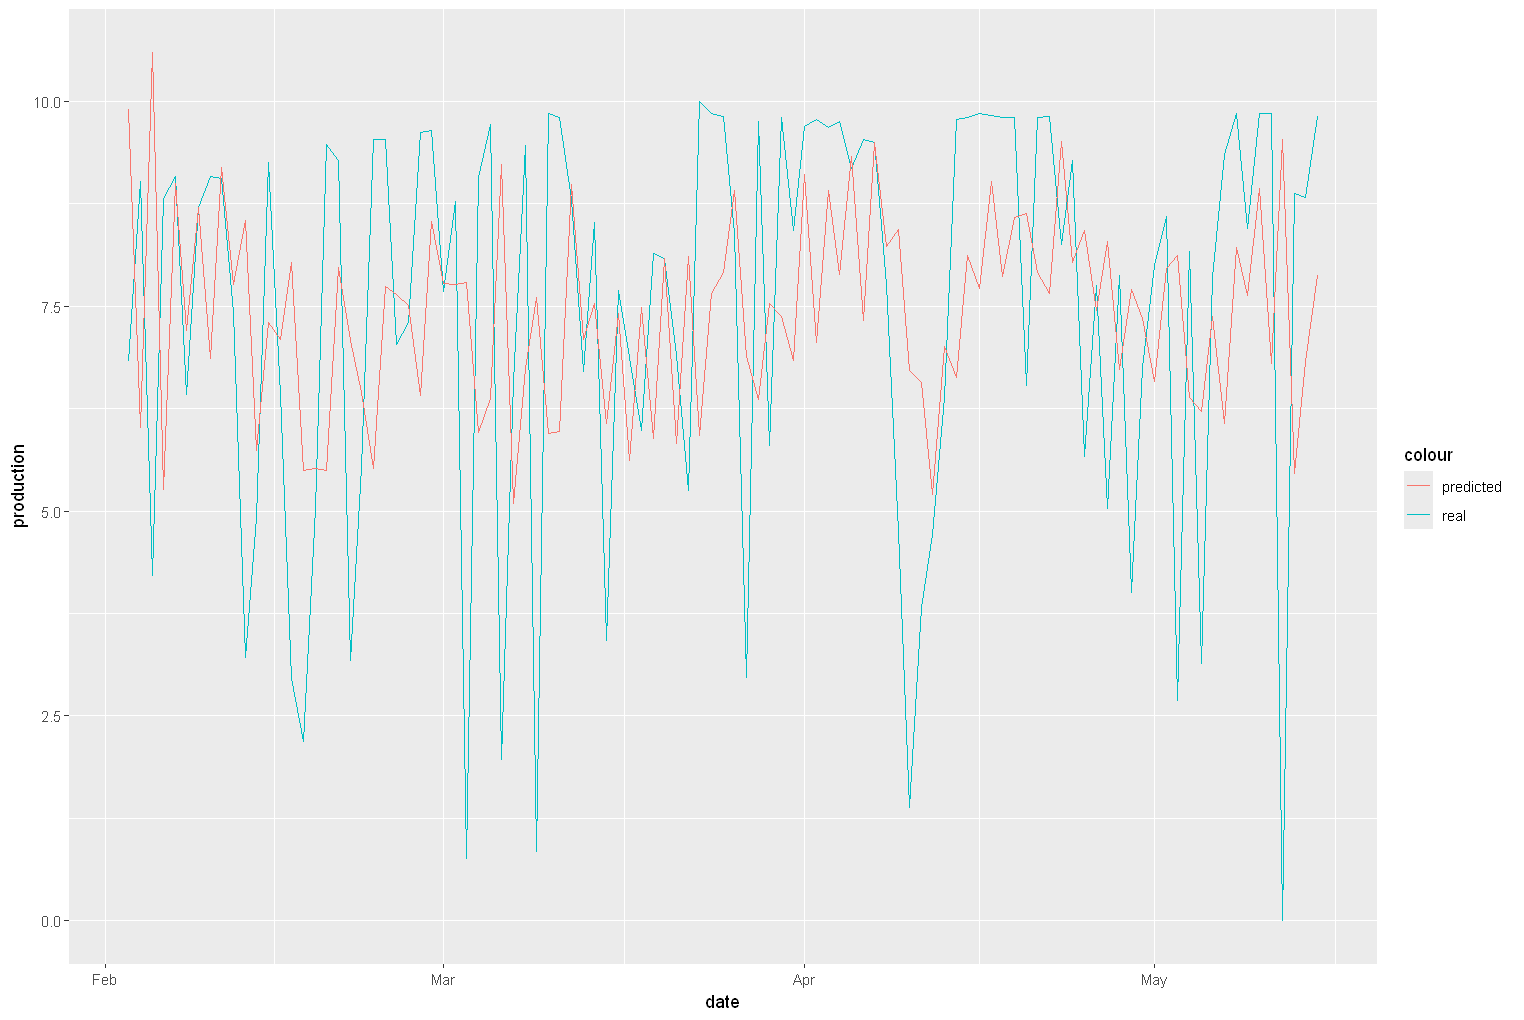

In [81]:
train_model <- Arima(train_hour_9$diff, order = c(5, 0, 5))
test_hour_9[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_9))

for (i in 1:nrow(test_hour_9)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_9$diff, test_hour_9$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_9[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_9,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 10

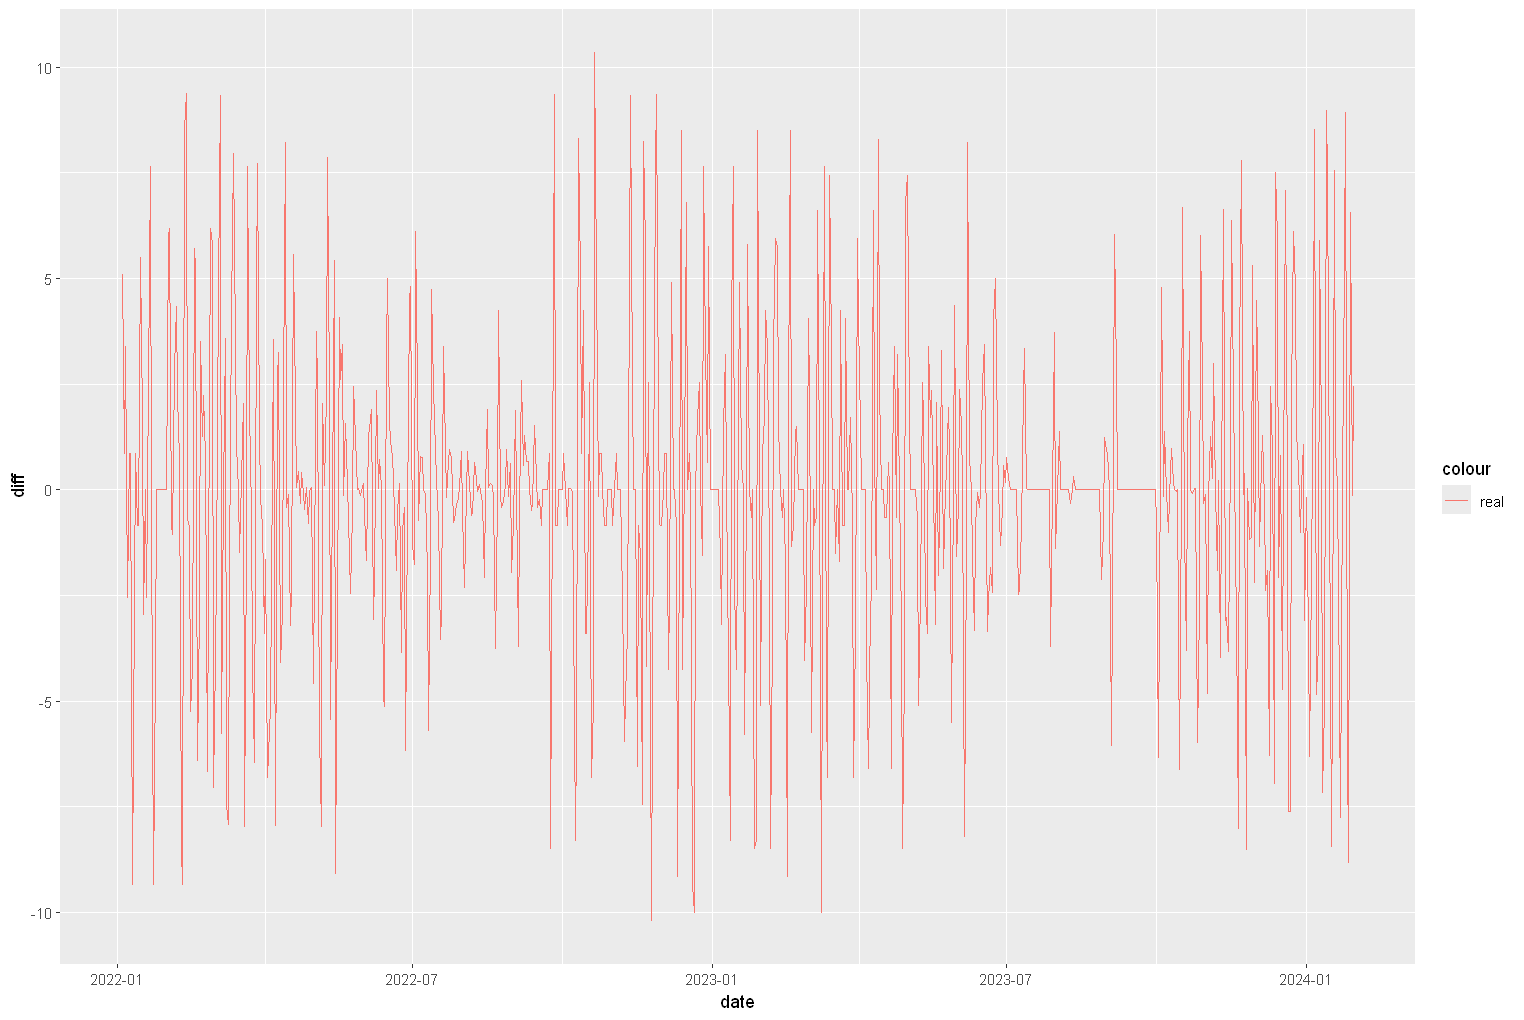

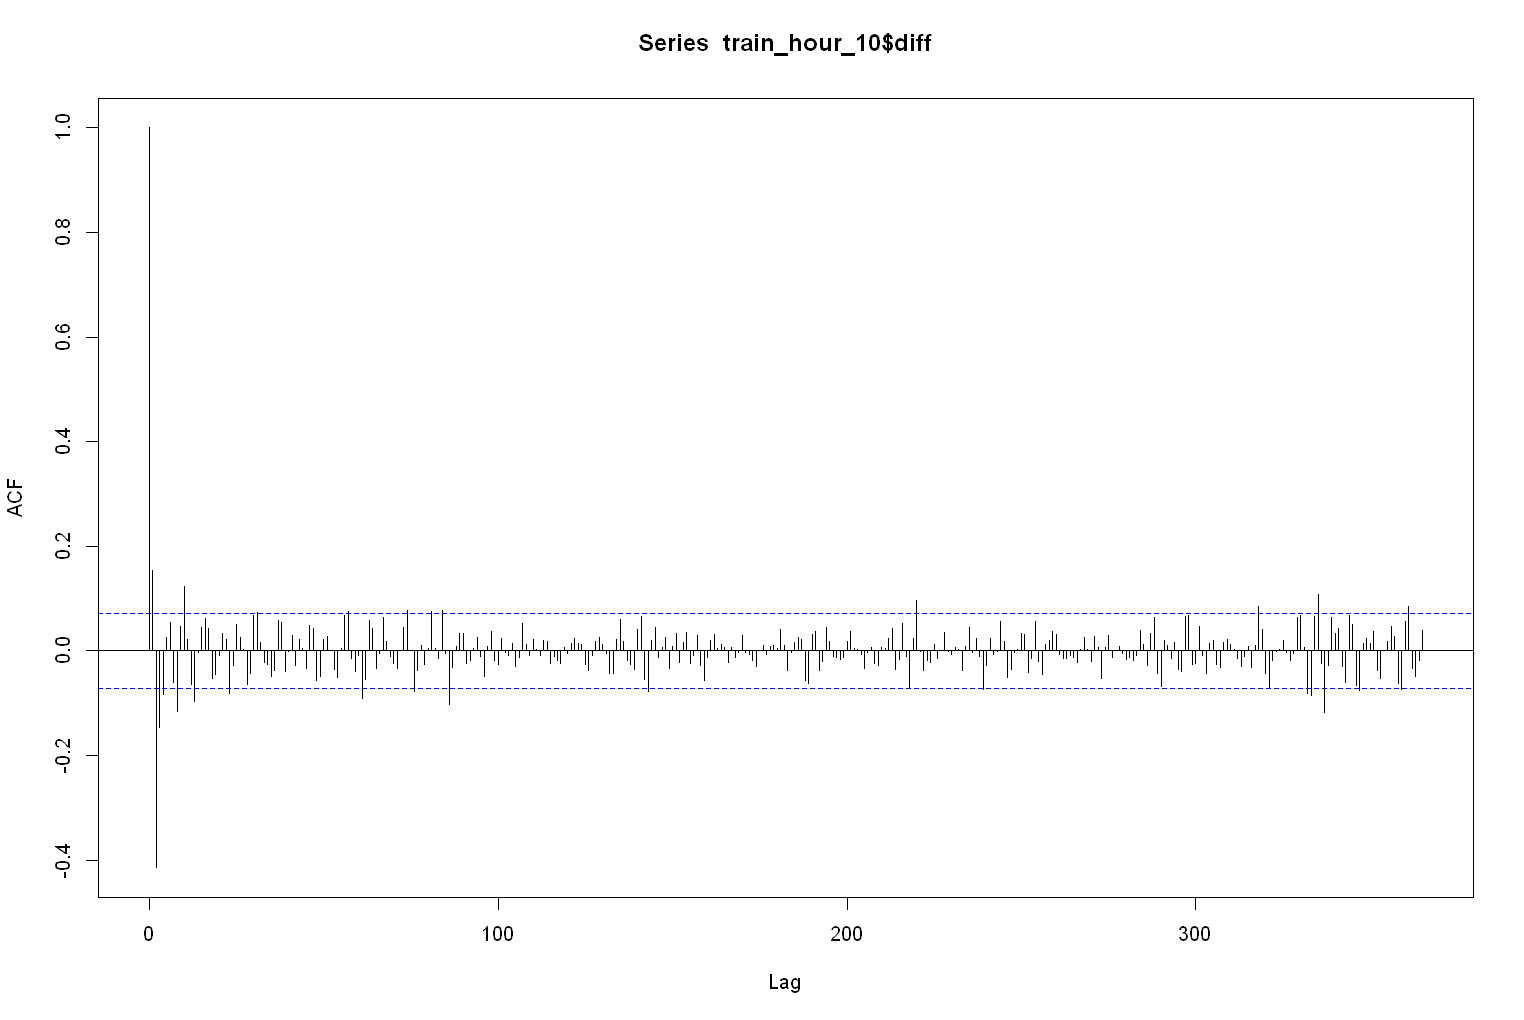

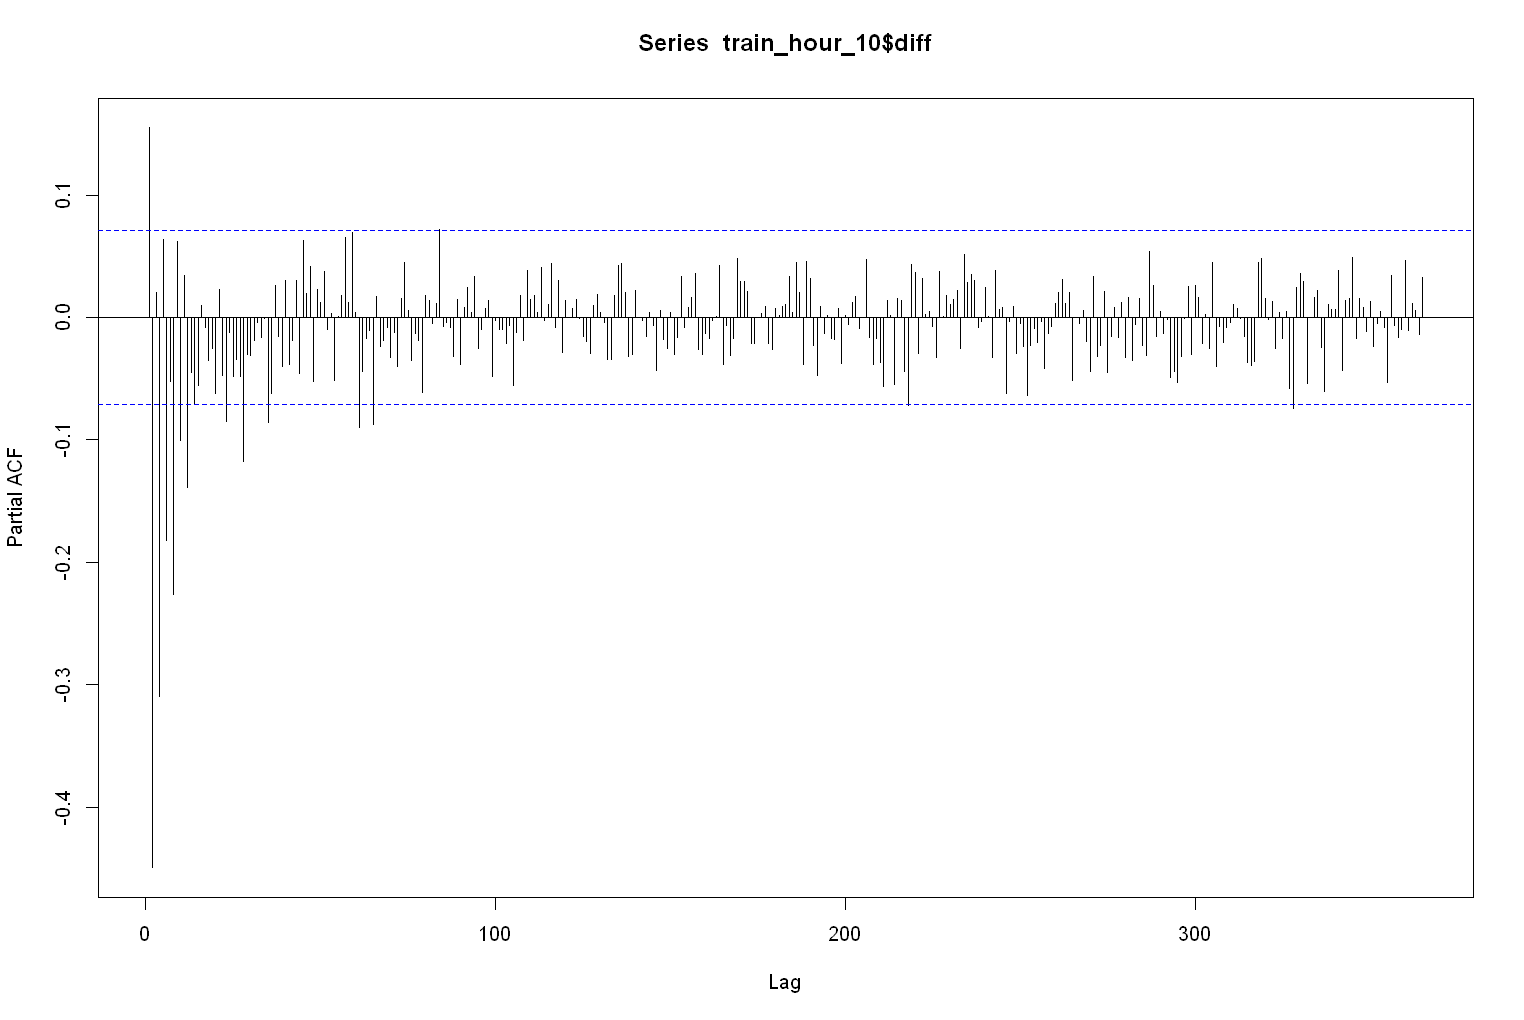

In [82]:
train_hour_10 <- train_split_data_tables[["10"]]
test_hour_10 <- test_split_data_tables[["10"]]

train_hour_10 <- na.omit(train_hour_10)
train_hour_10[,diff:=production - prod_lag_24]

ggplot(train_hour_10,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_10$diff,lag.max = 365)
pacf(train_hour_10$diff,lag.max = 365)

In [83]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_10$diff)
print(summary(simple_model))

Series: train_hour_10$diff 
ARIMA(2,0,3) with zero mean 

Coefficients:
         ar1      ar2      ma1      ma2     ma3
      0.9751  -0.1780  -0.6990  -0.8372  0.5612
s.e.  0.5795   0.2235   0.5736   0.0468  0.4896

sigma^2 = 7.737:  log likelihood = -1844.93
AIC=3701.87   AICc=3701.98   BIC=3729.64

Training set error measures:
                      ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.03008695 2.772274 2.030623 NaN  Inf 0.6340396 -0.005686498


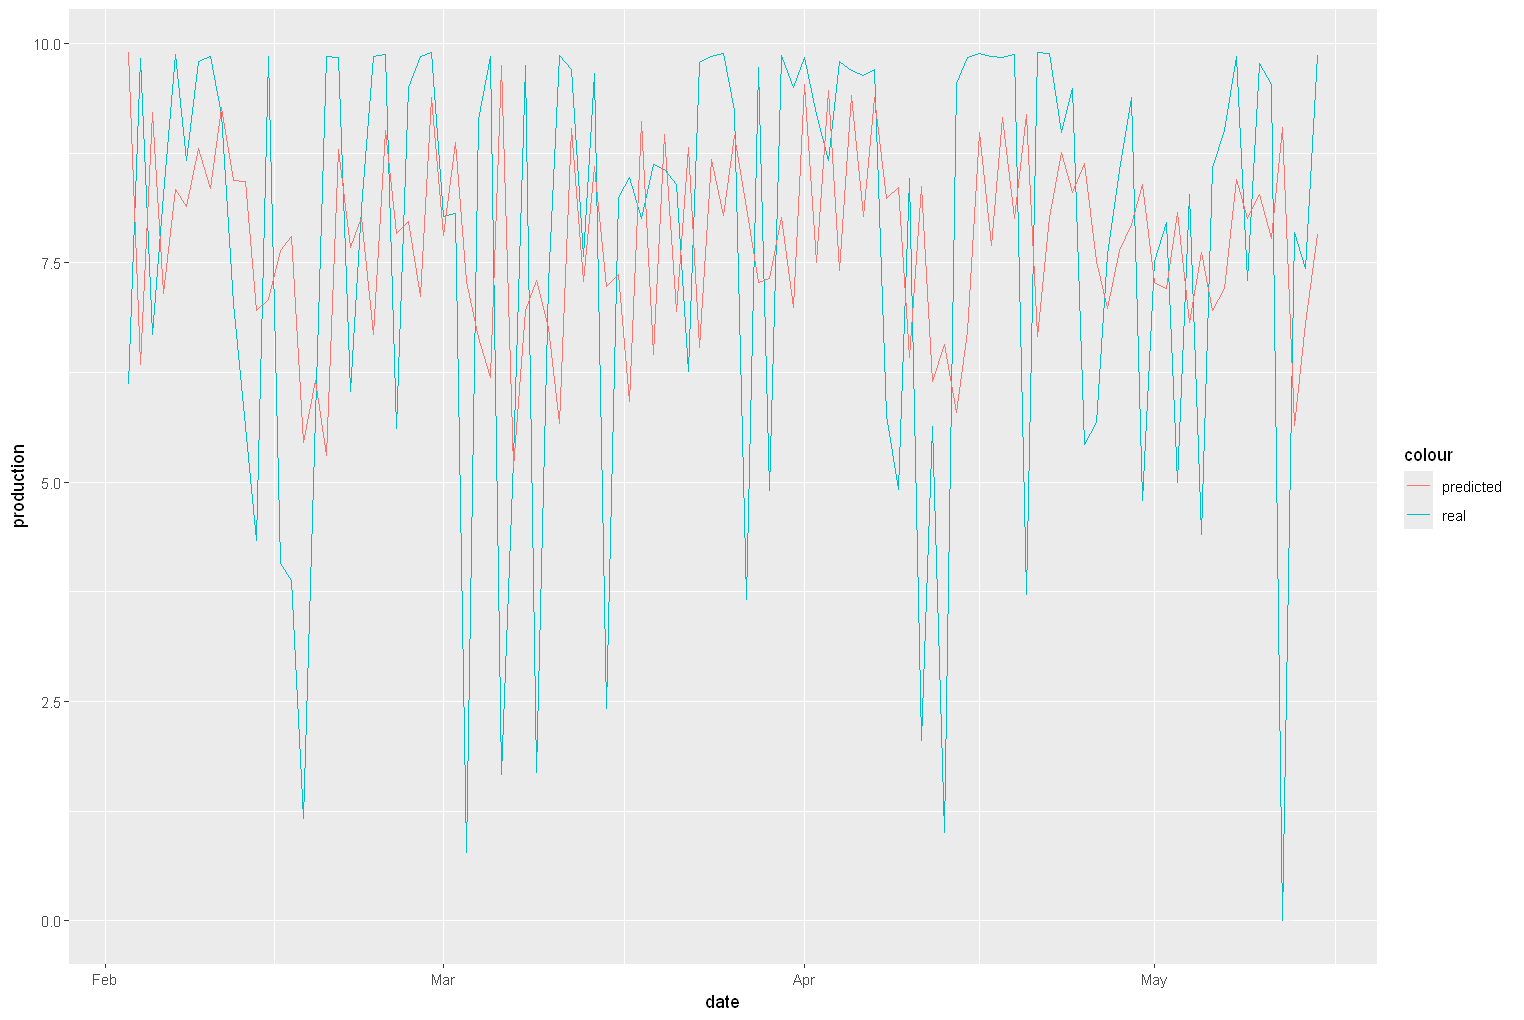

In [84]:
train_model <- Arima(train_hour_10$diff, order = c(2, 0, 3))
test_hour_10[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_10))

for (i in 1:nrow(test_hour_10)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_10$diff, test_hour_10$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_10[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_10,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 11

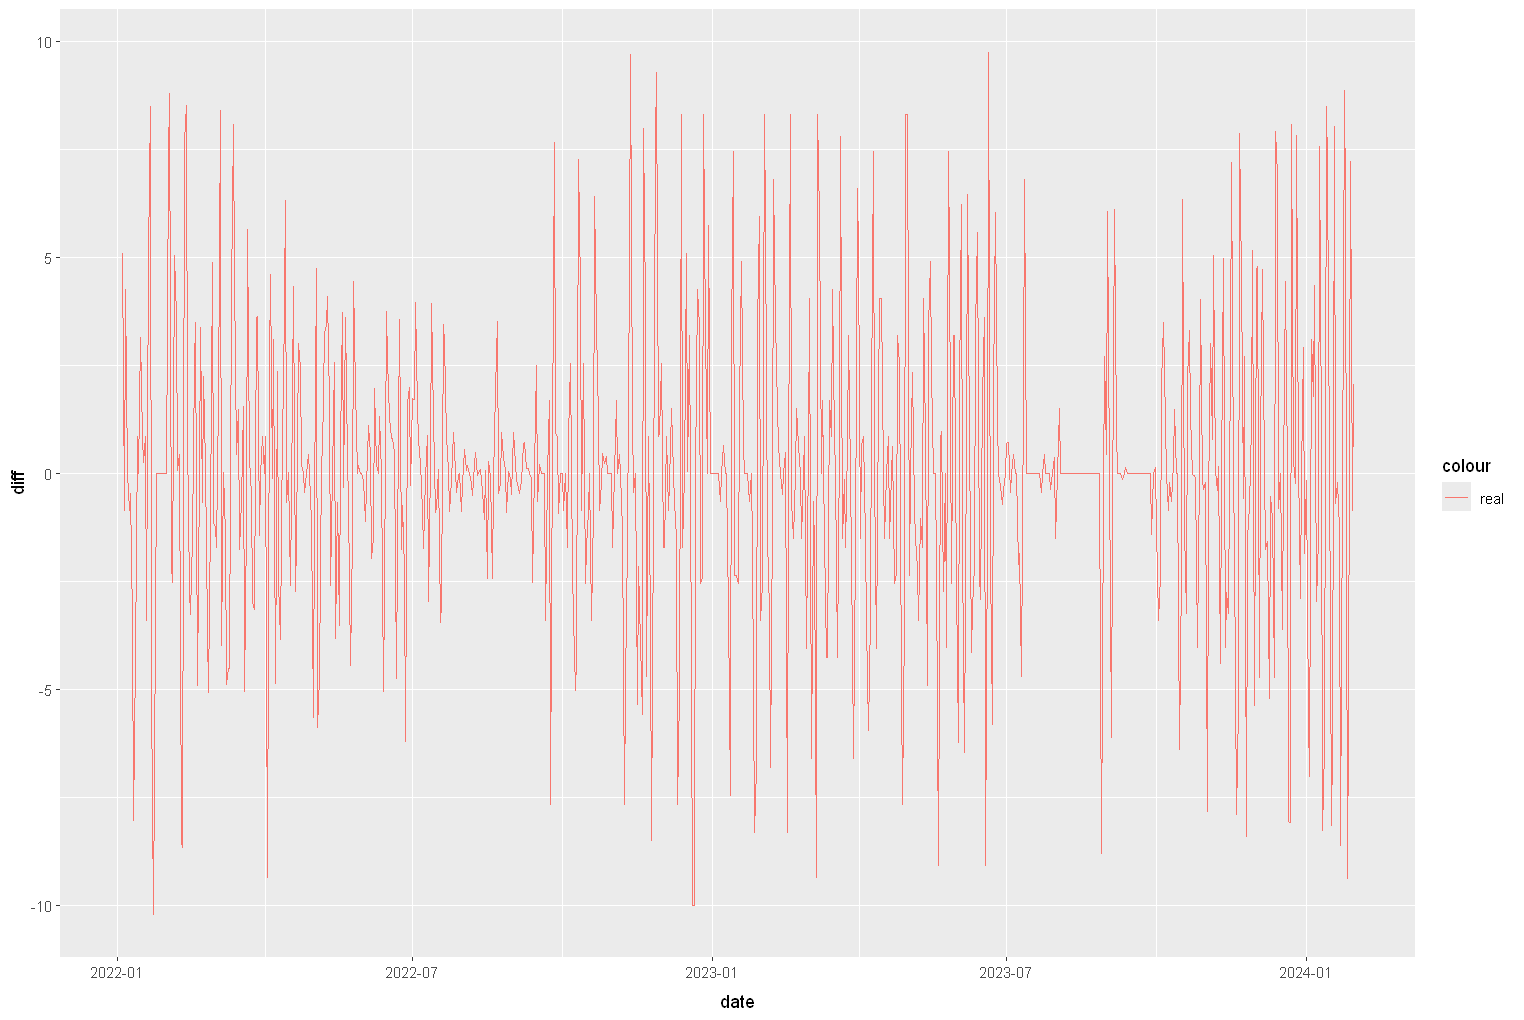

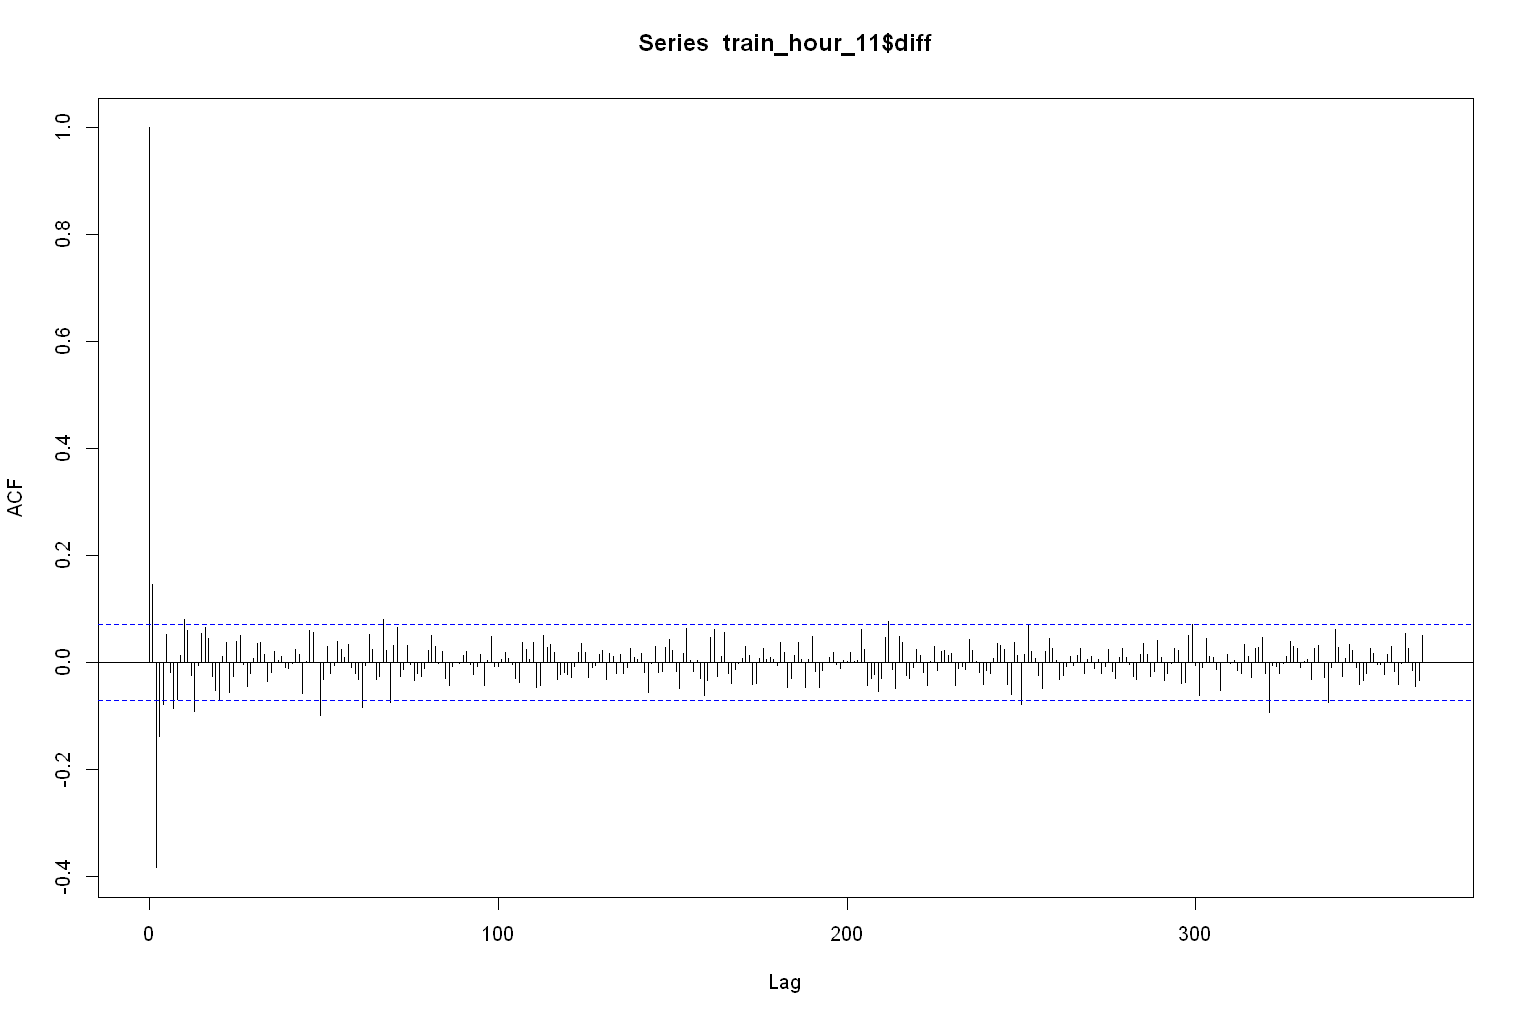

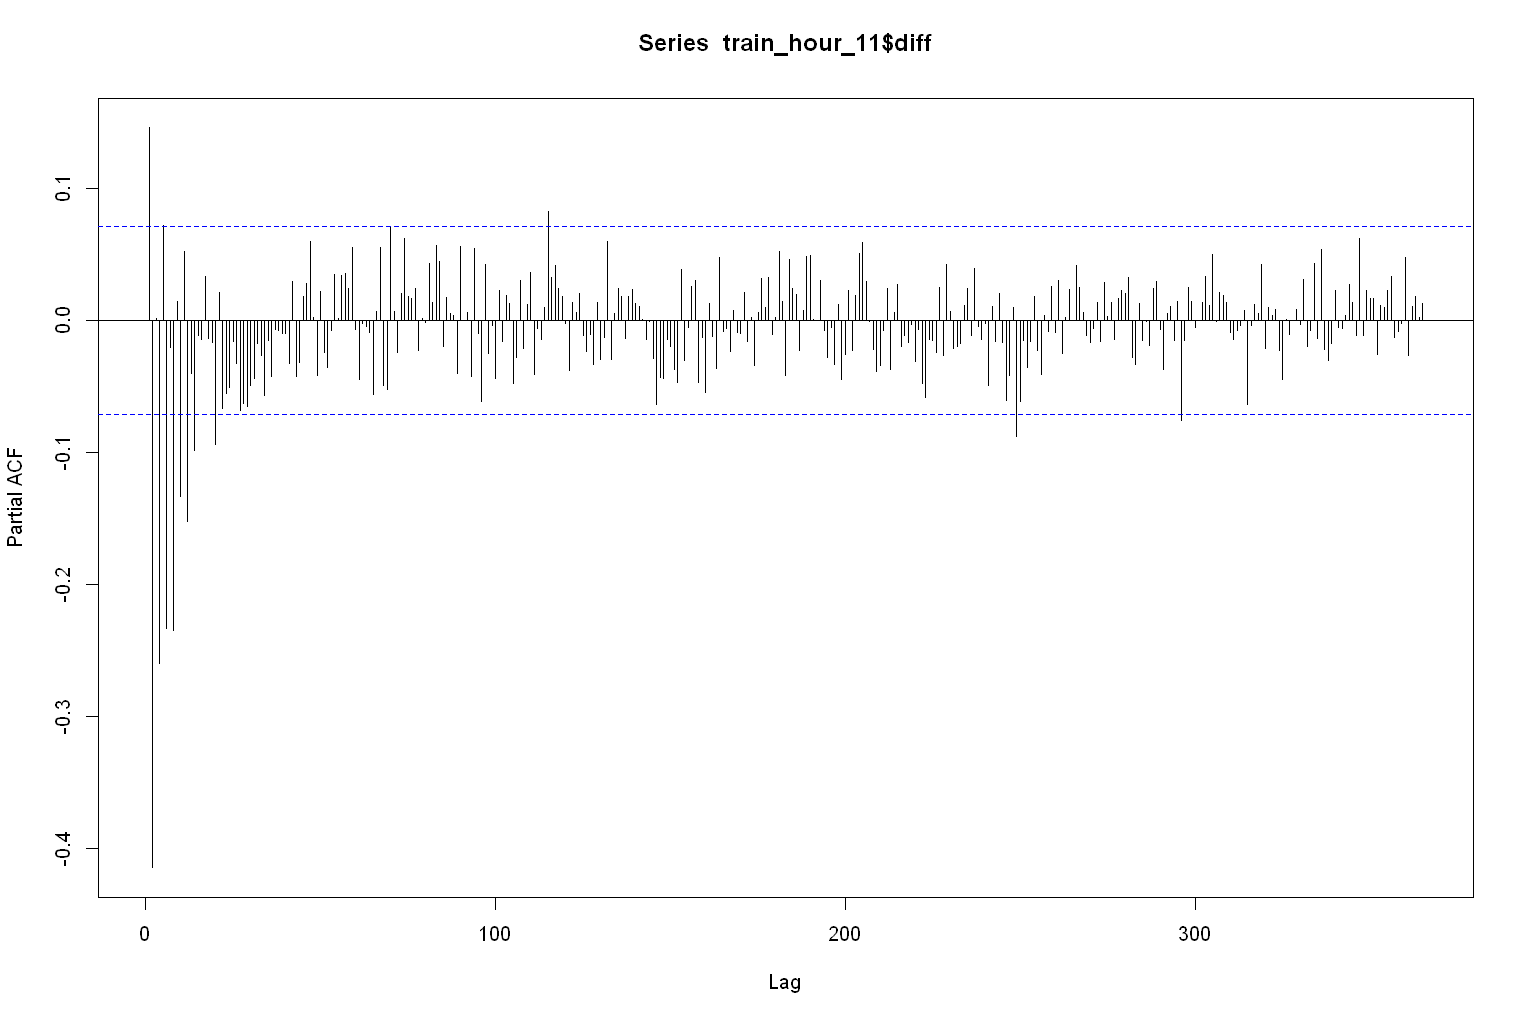

In [85]:
train_hour_11 <- train_split_data_tables[["11"]]
test_hour_11 <- test_split_data_tables[["11"]]

train_hour_11 <- na.omit(train_hour_11)
train_hour_11[,diff:=production - prod_lag_24]

ggplot(train_hour_11,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_11$diff,lag.max = 365)
pacf(train_hour_11$diff,lag.max = 365)

In [86]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_11$diff)
print(summary(simple_model))

Series: train_hour_11$diff 
ARIMA(2,0,2) with zero mean 

Coefficients:
         ar1     ar2     ma1      ma2
      0.2664  0.1145  0.0213  -0.9333
s.e.  0.0400  0.0399  0.0161   0.0161

sigma^2 = 7.116:  log likelihood = -1816.74
AIC=3643.48   AICc=3643.56   BIC=3666.63

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set 0.02969734 2.660538 1.995048 NaN  Inf 0.6397529 -0.002865568


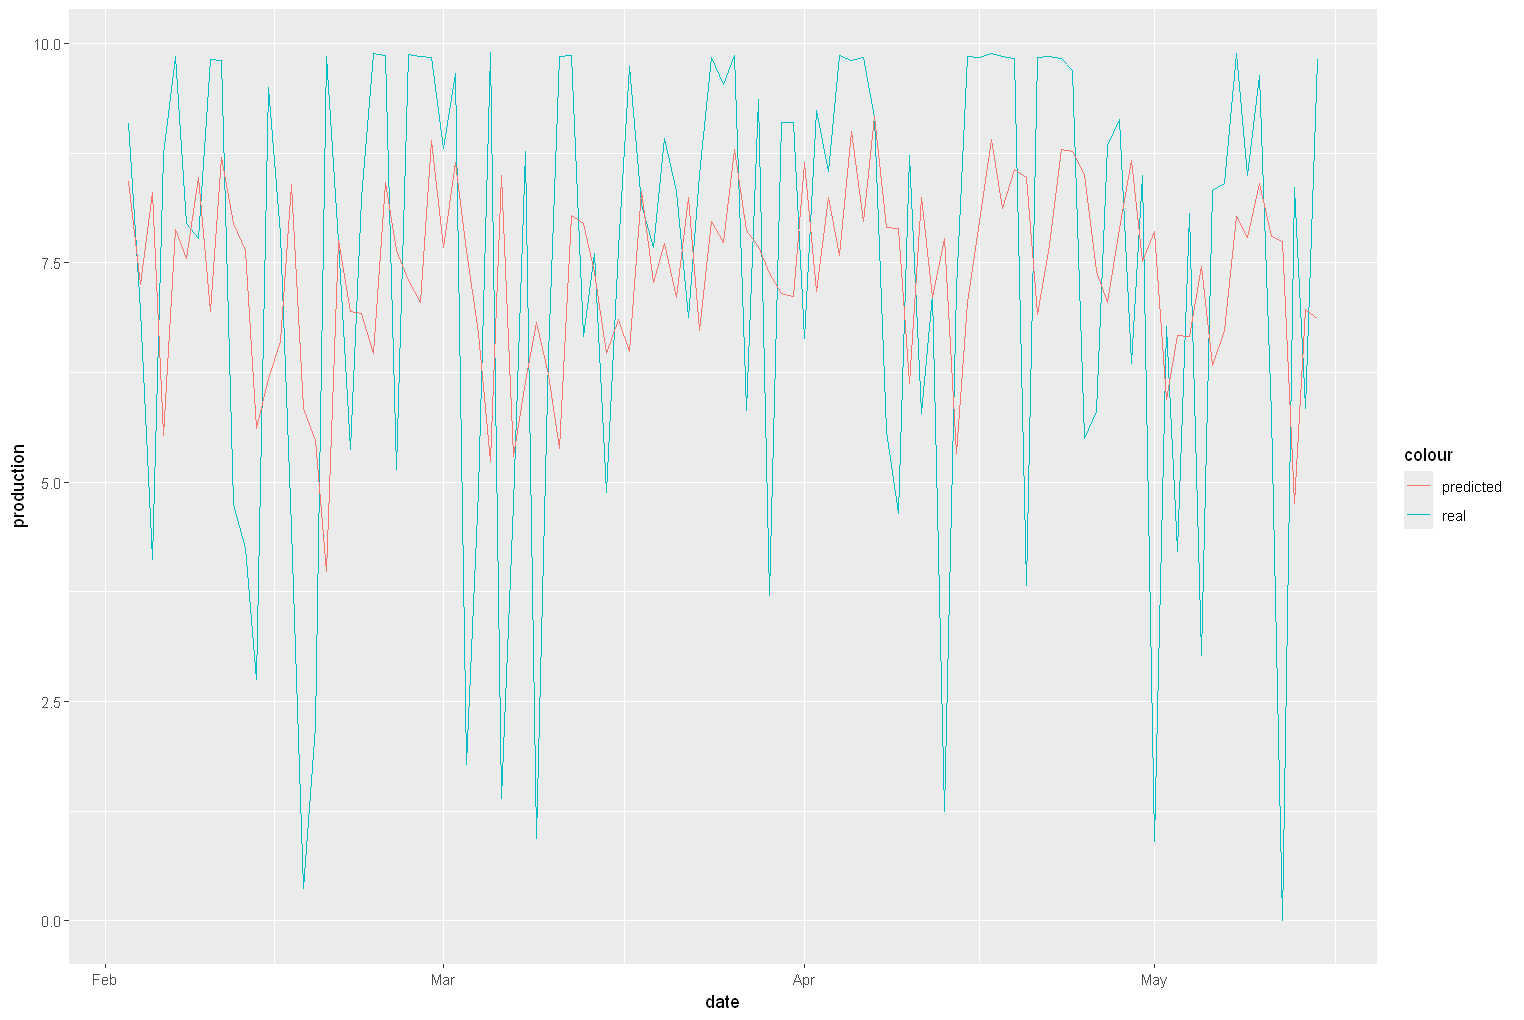

In [87]:
train_model <- Arima(train_hour_11$diff, order = c(2, 0, 2))
test_hour_11[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_11))

for (i in 1:nrow(test_hour_11)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_11$diff, test_hour_11$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_11[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_11,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 12

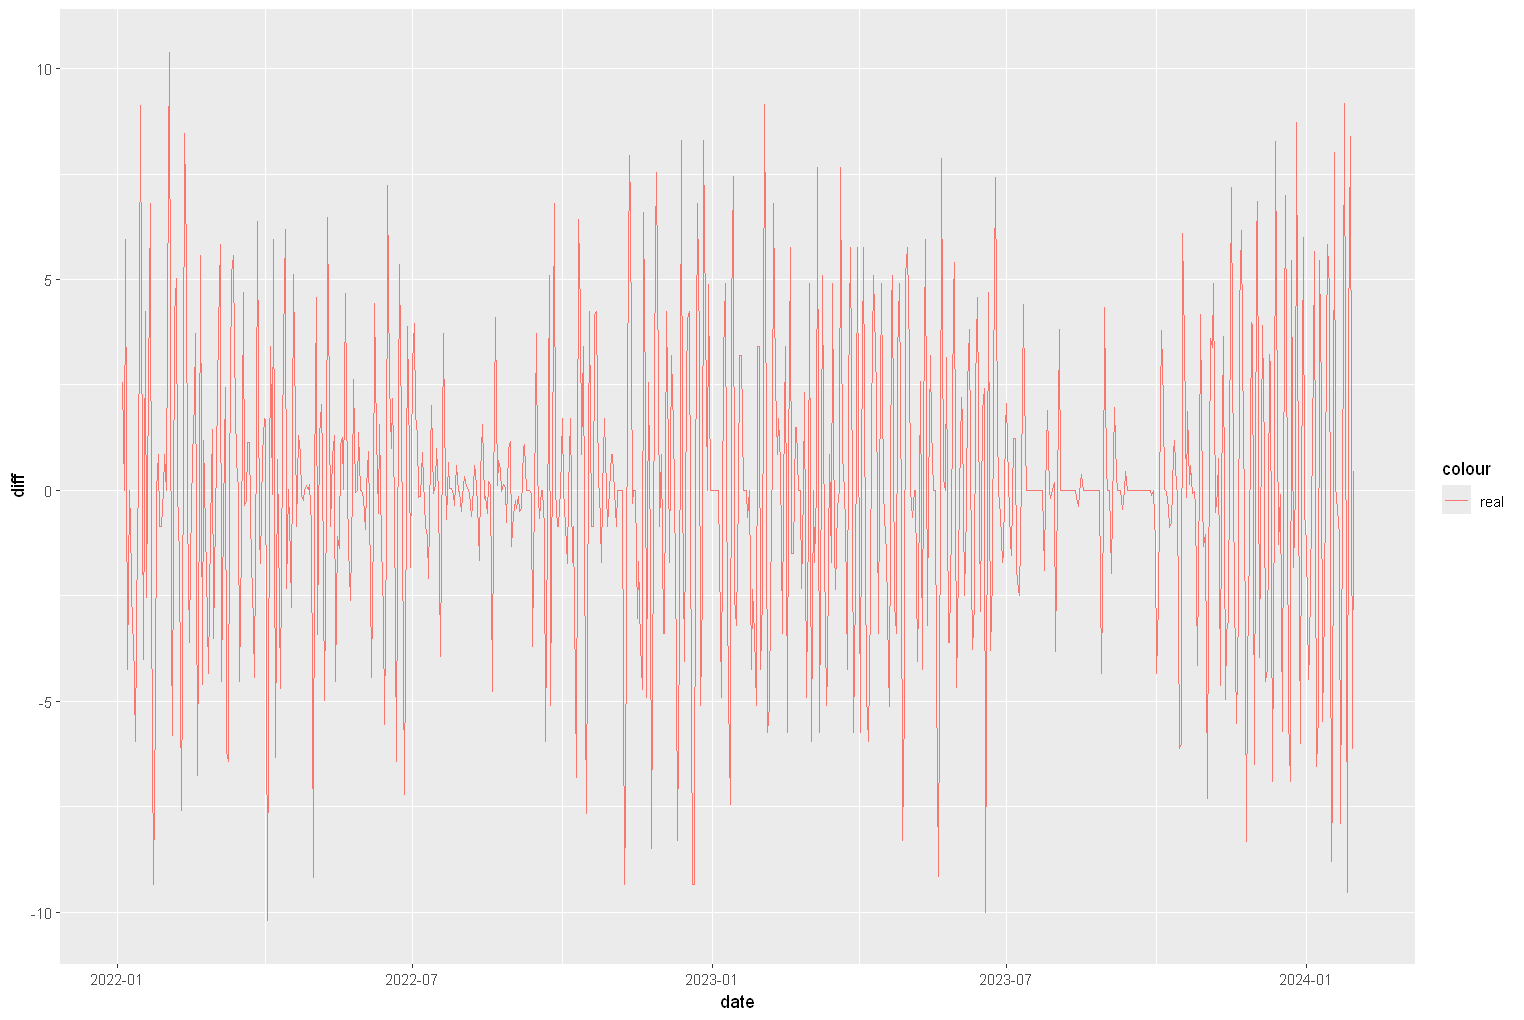

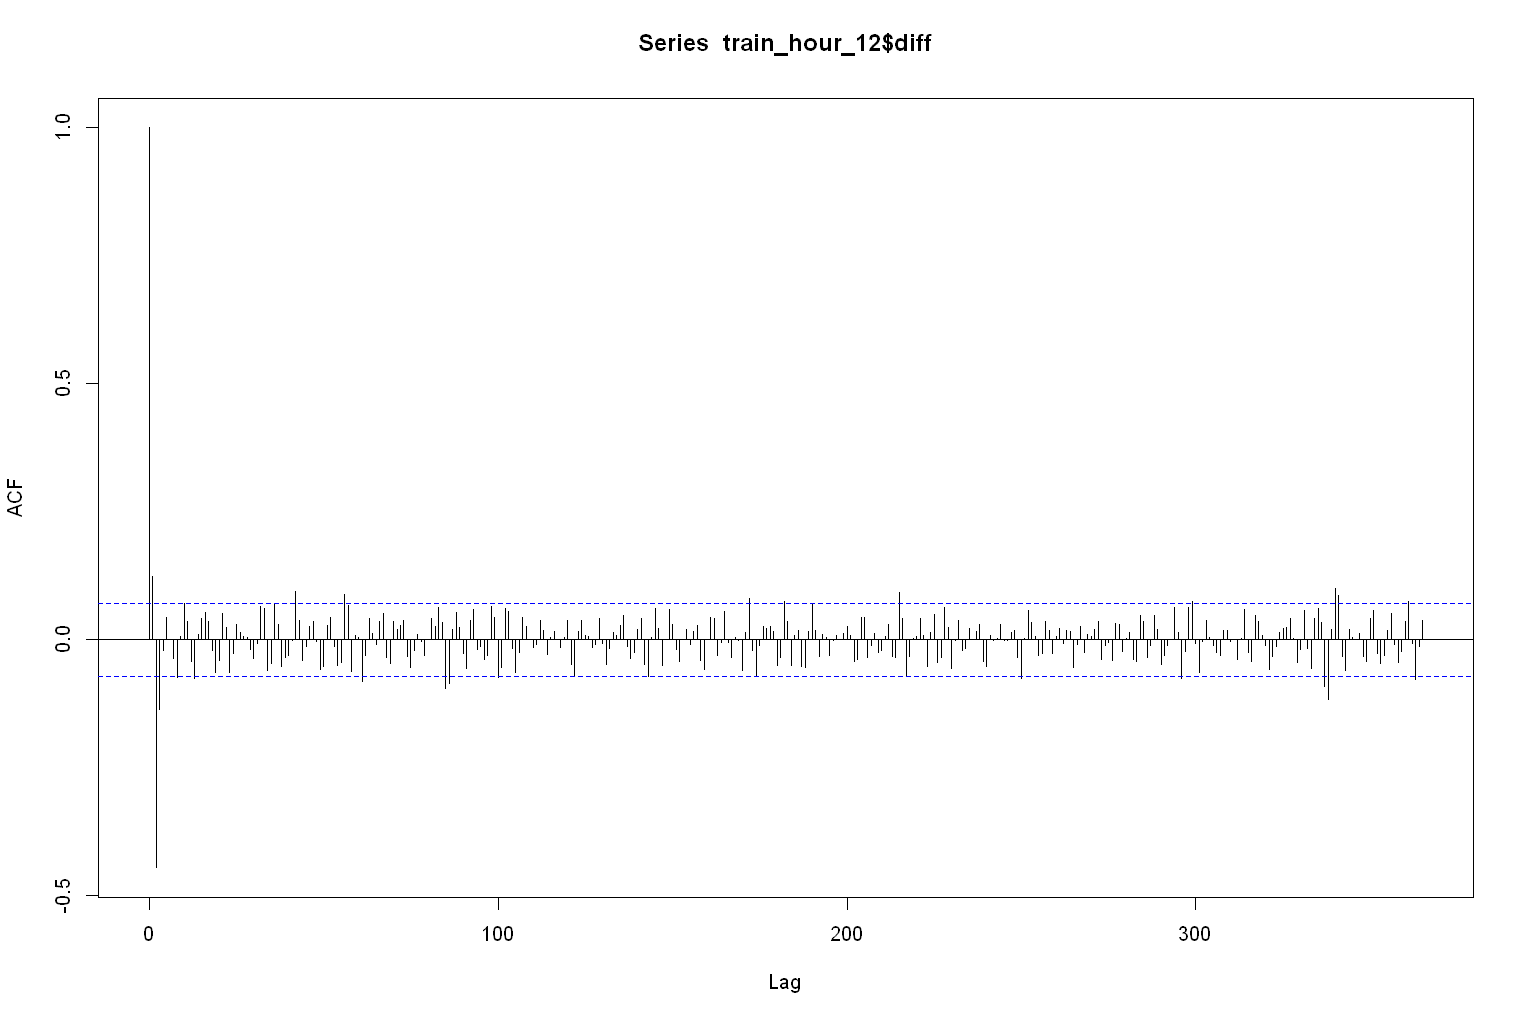

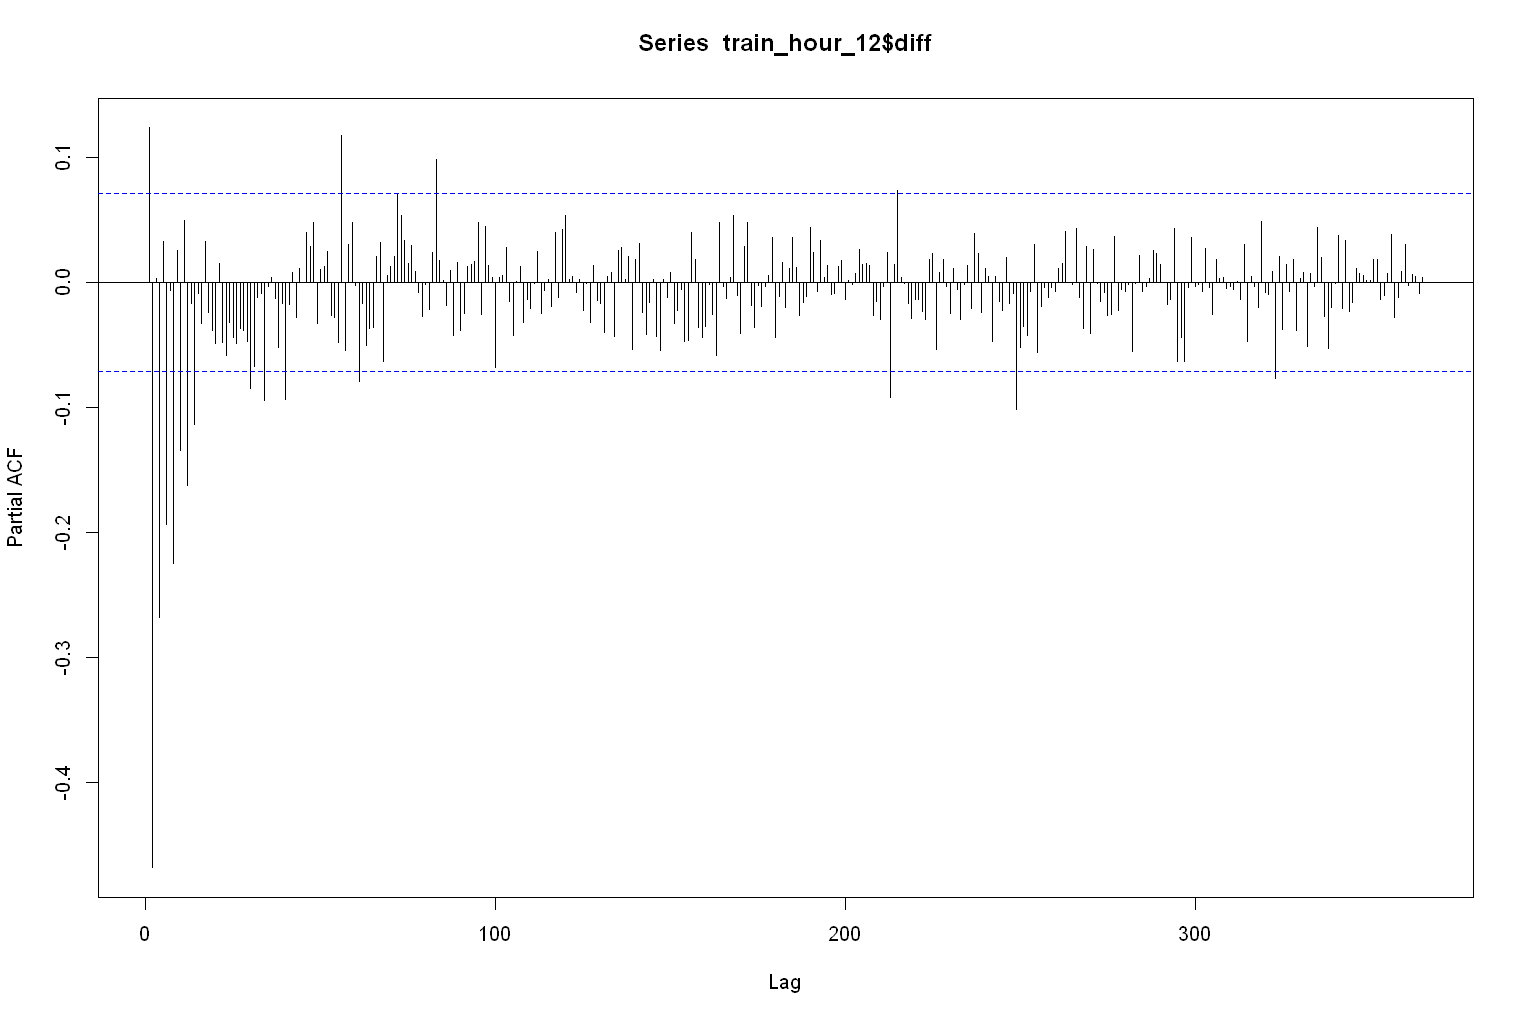

In [88]:
train_hour_12 <- train_split_data_tables[["12"]]
test_hour_12 <- test_split_data_tables[["12"]]

train_hour_12 <- na.omit(train_hour_12)
train_hour_12[,diff:=production - prod_lag_24]

ggplot(train_hour_12,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_12$diff,lag.max = 365)
pacf(train_hour_12$diff,lag.max = 365)

In [89]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_12$diff)
print(summary(simple_model))

Series: train_hour_12$diff 
ARIMA(4,0,3) with zero mean 

Coefficients:
         ar1      ar2      ar3     ar4      ma1      ma2     ma3
      0.6061  -0.0173  -0.0366  0.0357  -0.3695  -0.9137  0.3337
s.e.  0.5092   0.1324   0.0575  0.0406   0.5089   0.0210  0.4621

sigma^2 = 6.948:  log likelihood = -1803.53
AIC=3623.05   AICc=3623.25   BIC=3660.08

Training set error measures:
                      ME     RMSE      MAE MPE MAPE     MASE        ACF1
Training set -0.04207267 2.623652 2.004132 NaN  Inf 0.612852 -0.00525723


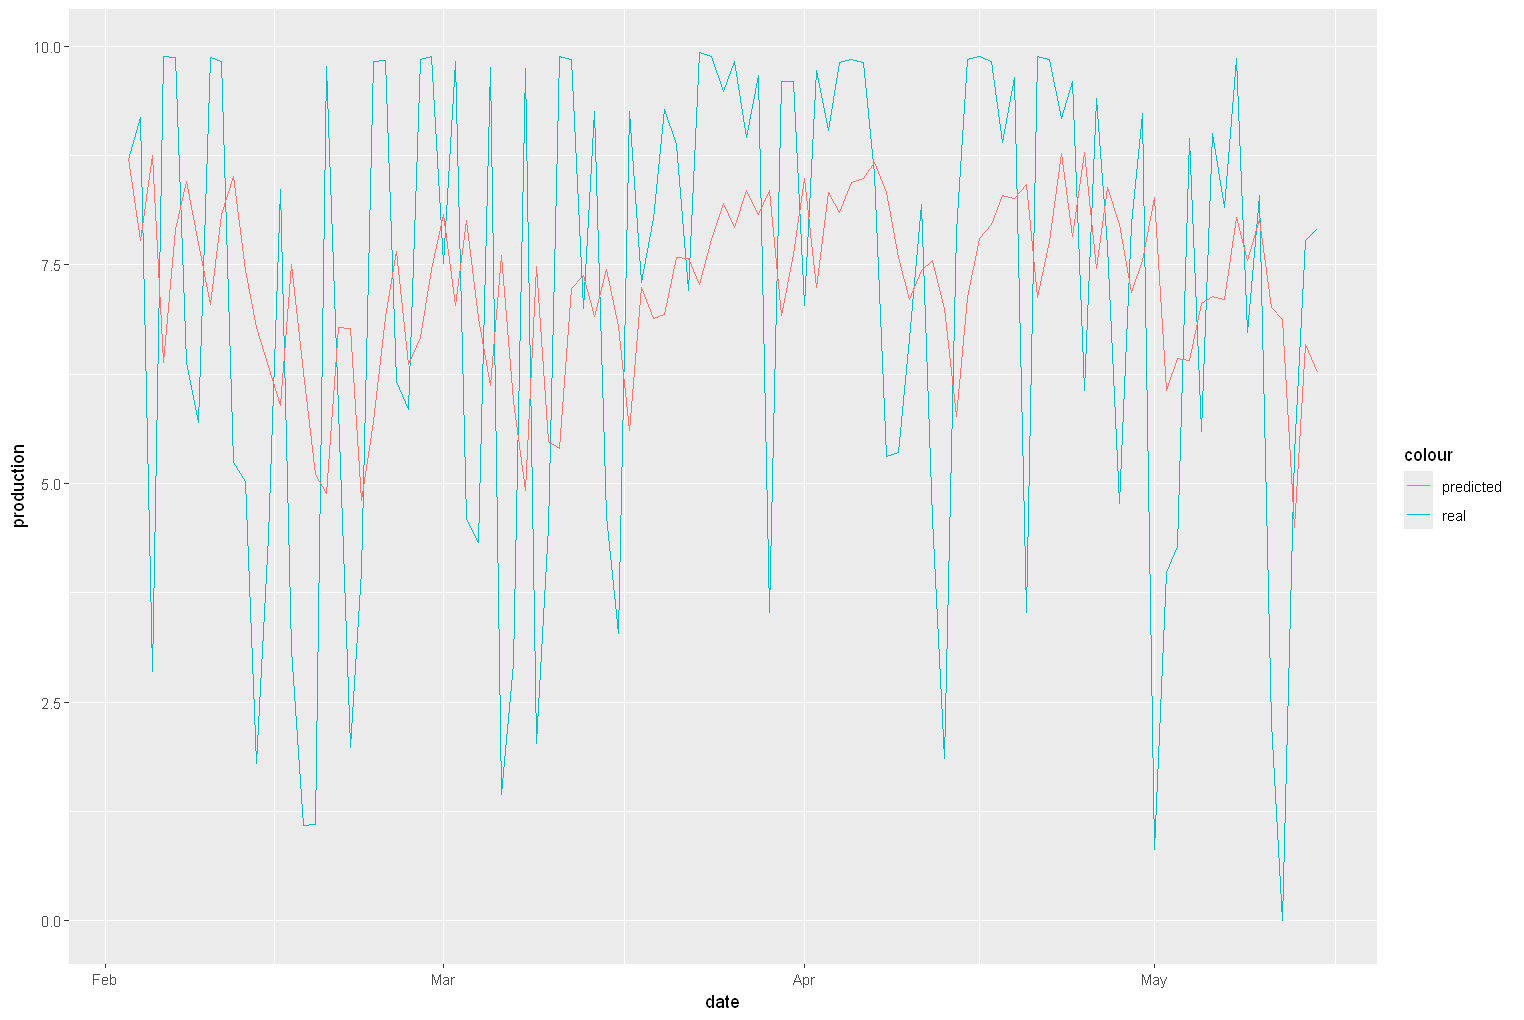

In [90]:
train_model <- Arima(train_hour_12$diff, order = c(4, 0, 3))
test_hour_12[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_12))

for (i in 1:nrow(test_hour_12)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_12$diff, test_hour_12$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_12[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_12,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 13

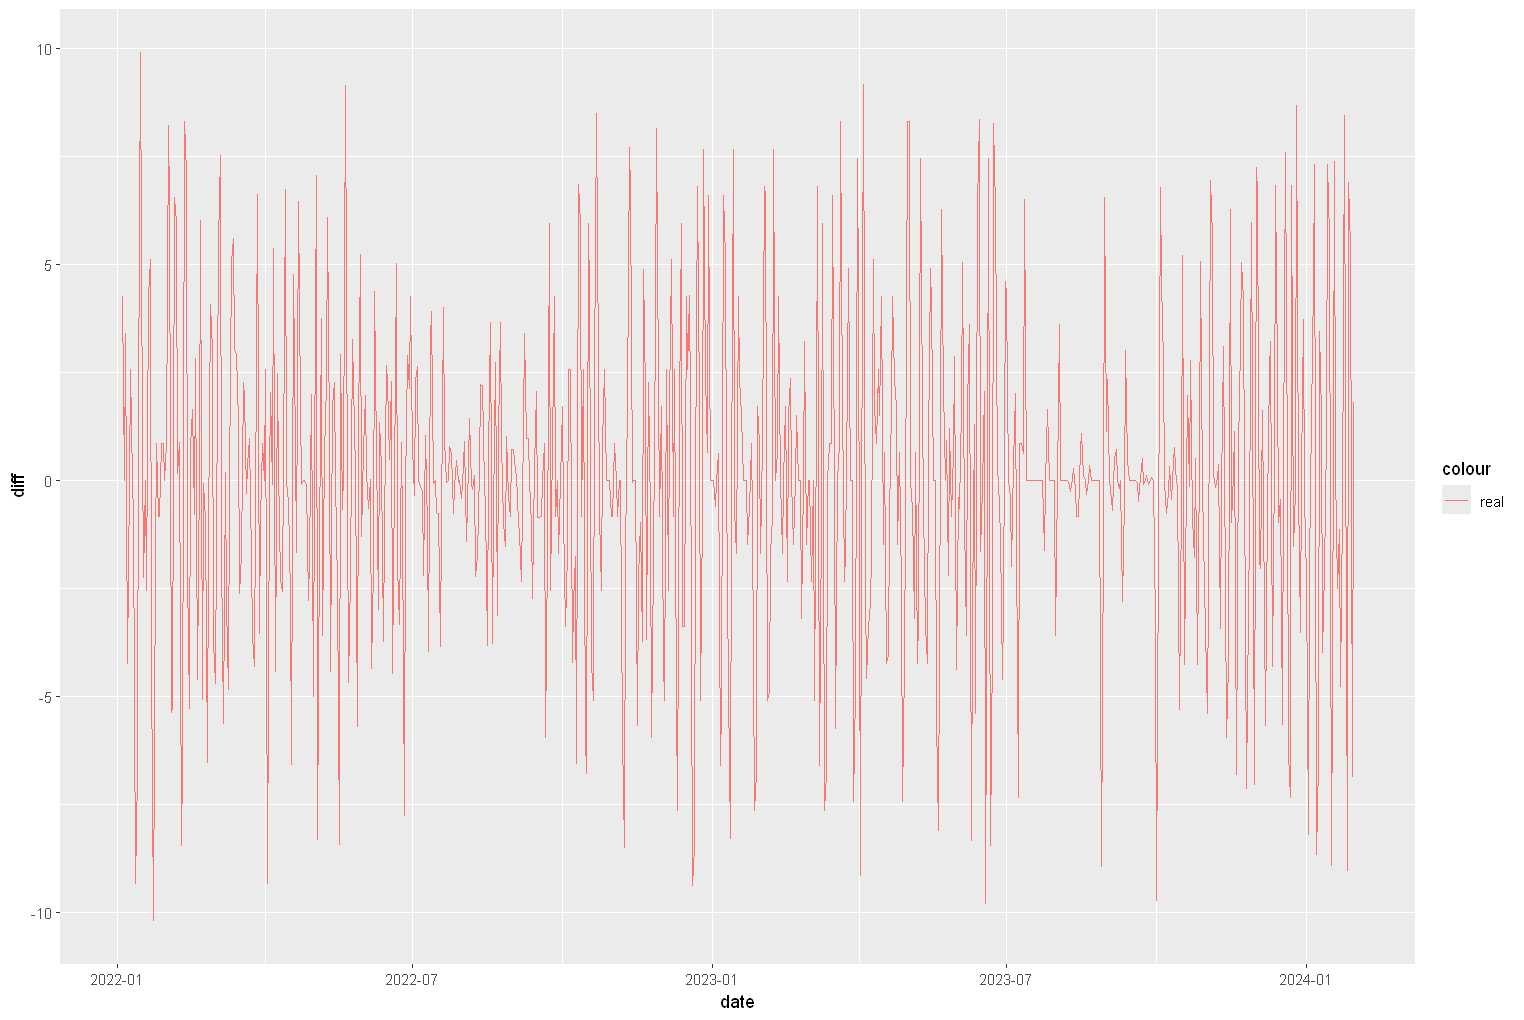

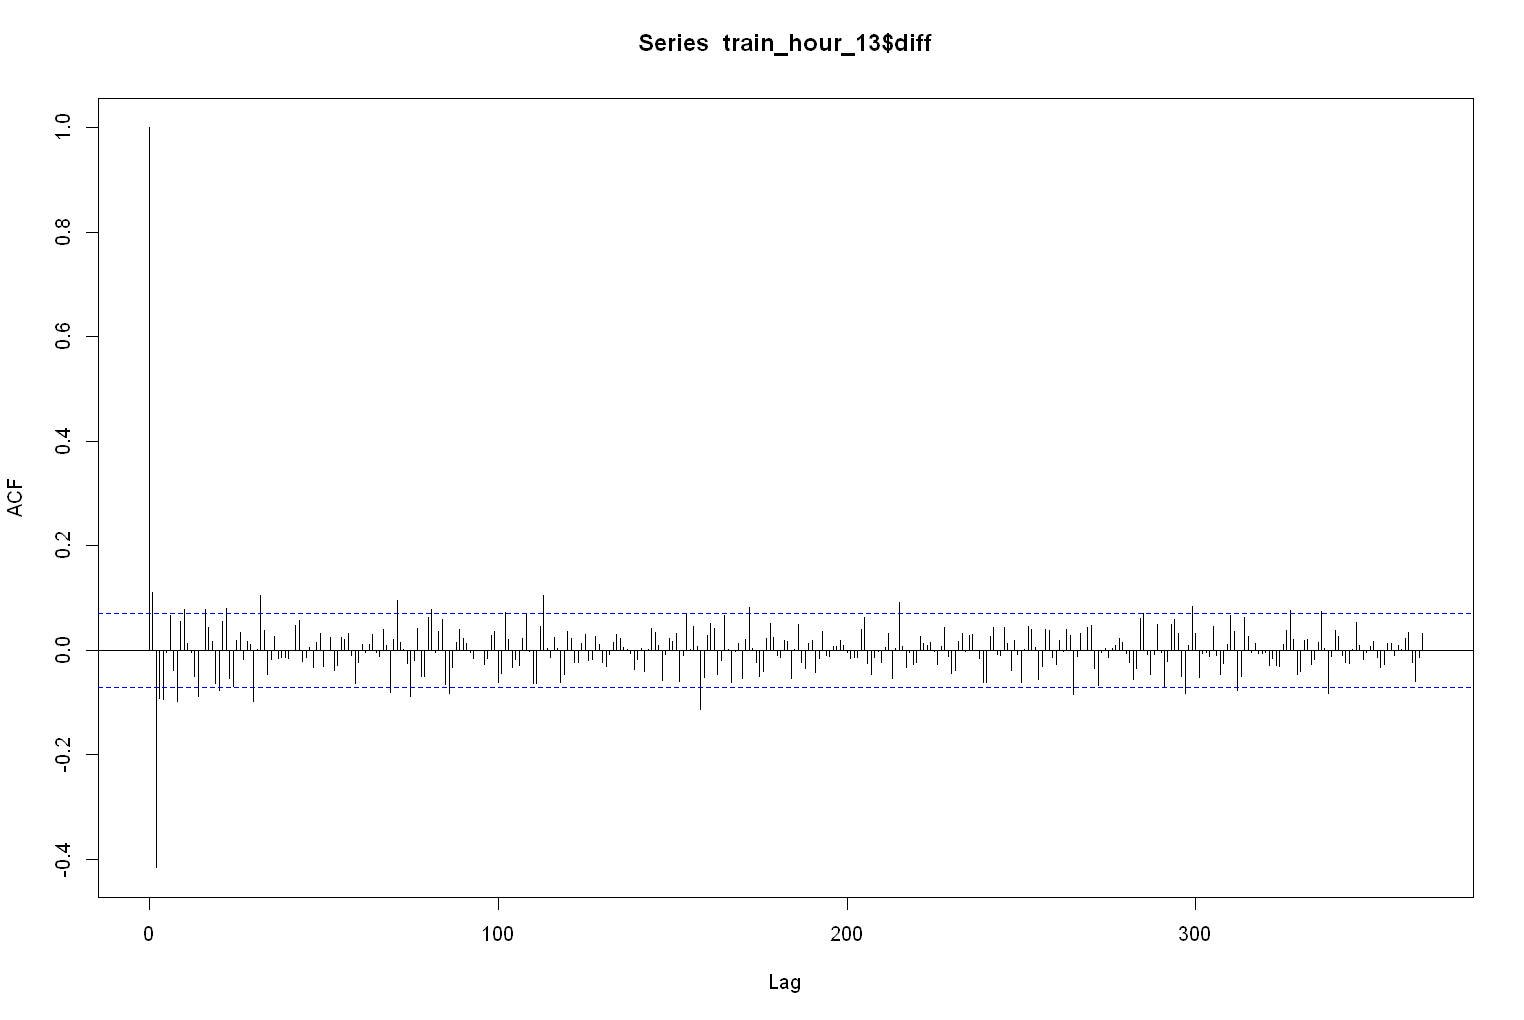

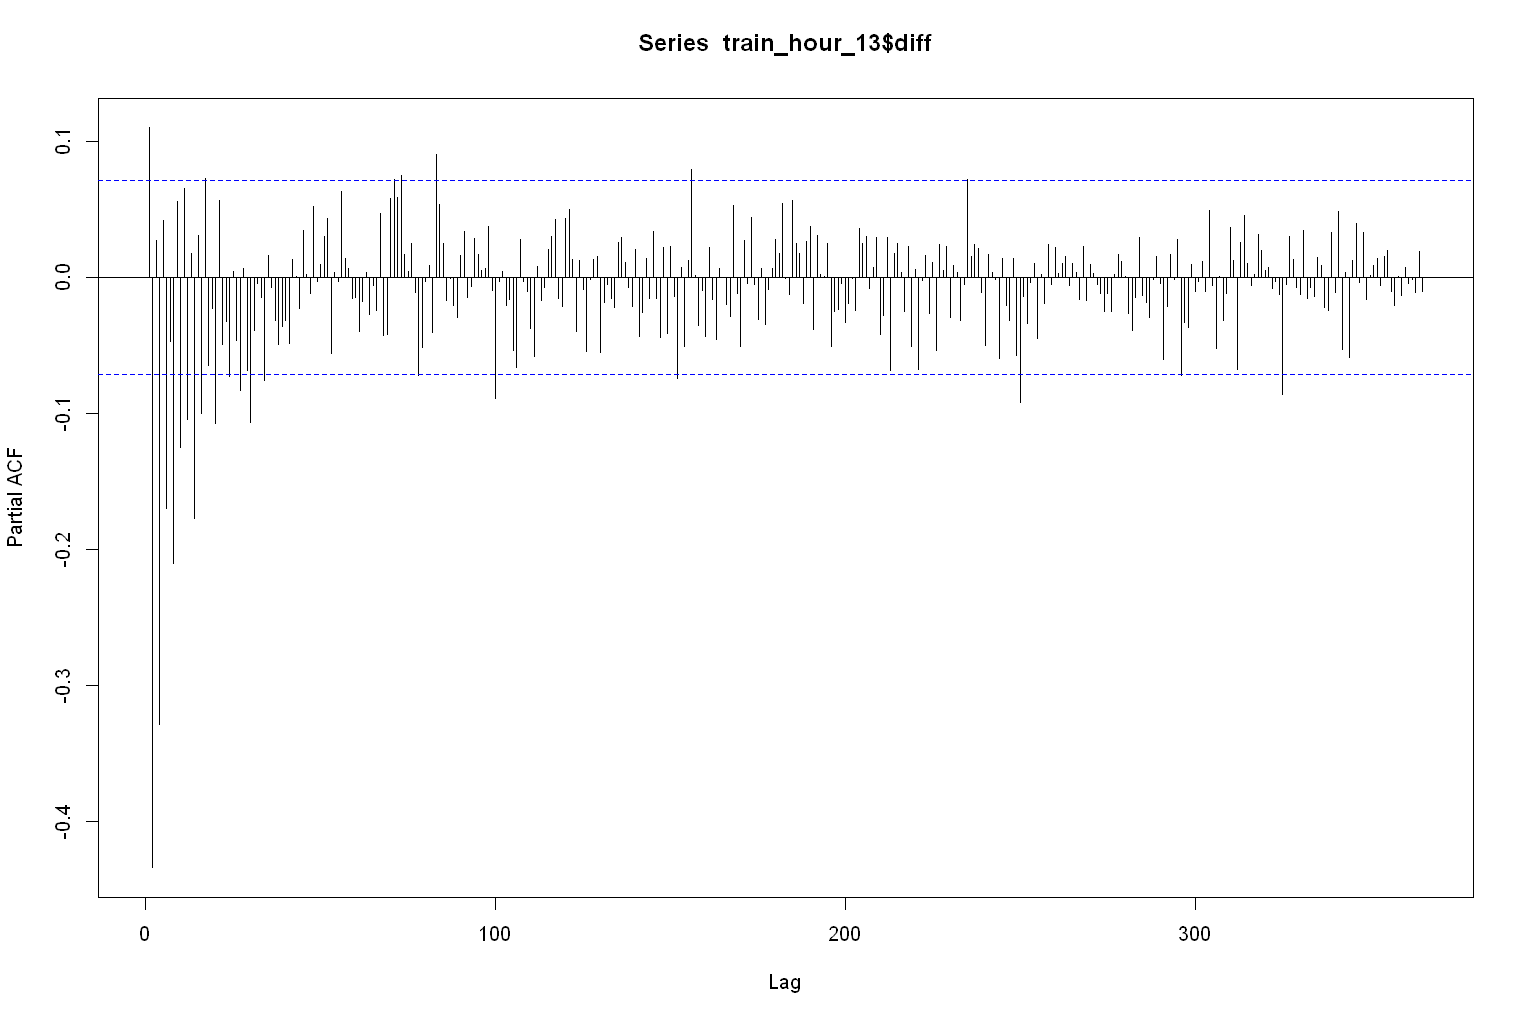

In [91]:
train_hour_13 <- train_split_data_tables[["13"]]
test_hour_13 <- test_split_data_tables[["13"]]

train_hour_13 <- na.omit(train_hour_13)
train_hour_13[,diff:=production - prod_lag_24]

ggplot(train_hour_13,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_13$diff,lag.max = 365)
pacf(train_hour_13$diff,lag.max = 365)

In [92]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_13$diff)
print(summary(simple_model))

Series: train_hour_13$diff 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.9855  0.0129
s.e.  0.0116  0.2454

sigma^2 = 11.61:  log likelihood = -2003.01
AIC=4012.01   AICc=4012.05   BIC=4025.9

Training set error measures:
                       ME     RMSE      MAE MPE MAPE      MASE       ACF1
Training set -0.005189826 3.403133 2.405518 NaN  Inf 0.6687672 -0.4200273


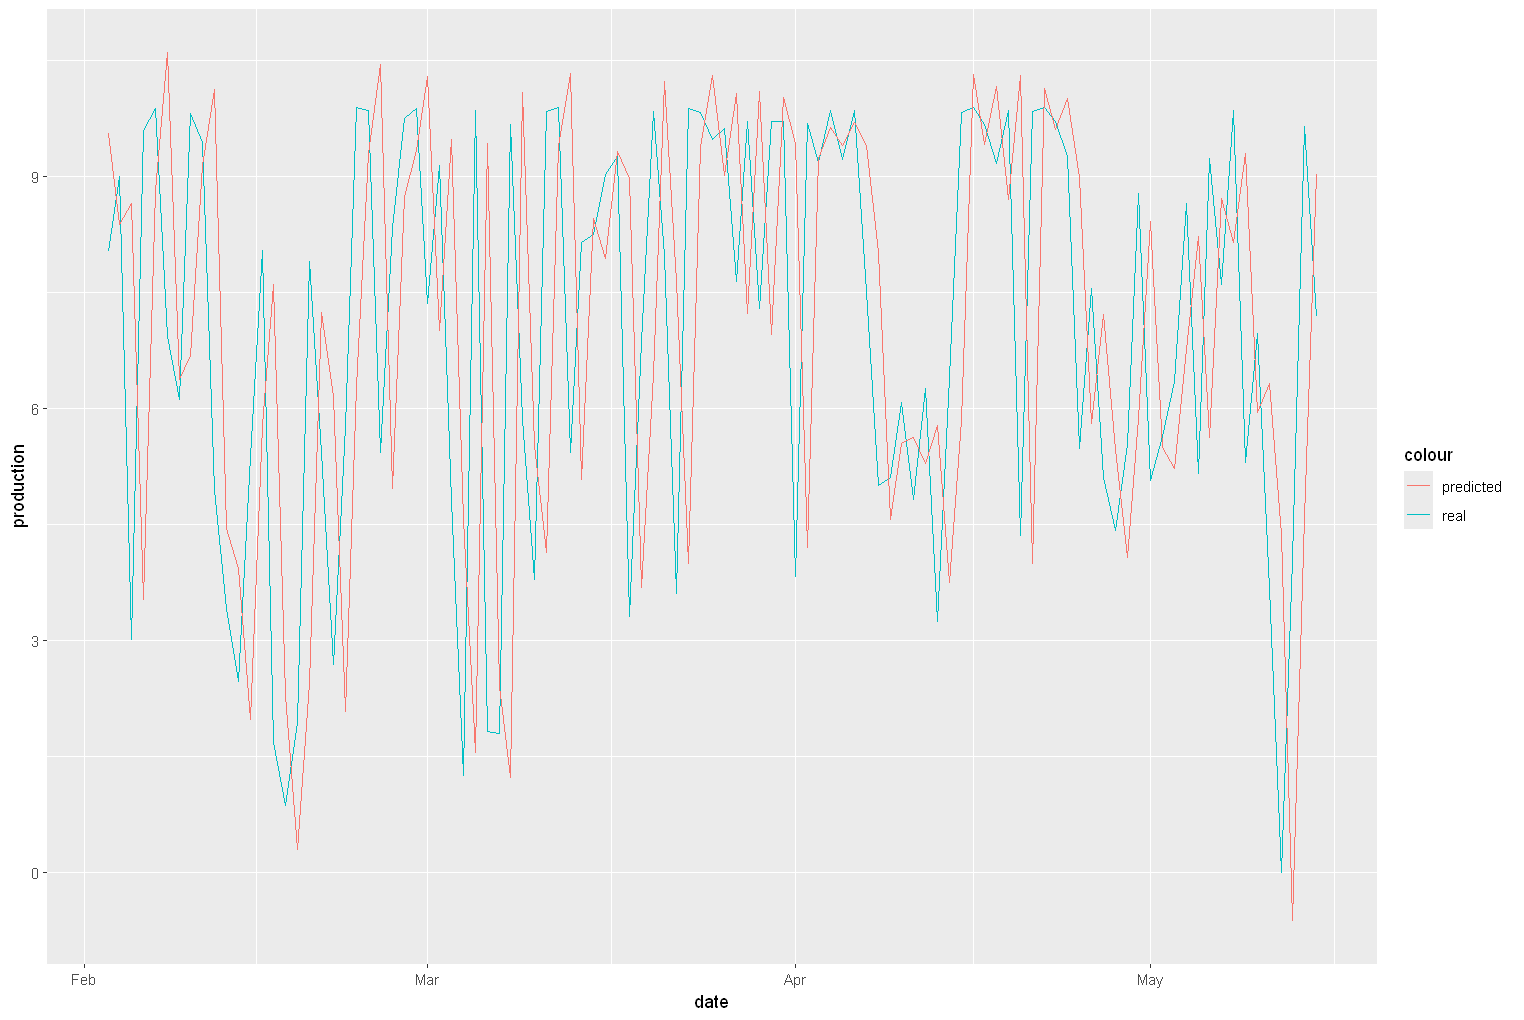

In [93]:
train_model <- Arima(train_hour_13$diff, order = c(0, 0, 1))
test_hour_13[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_13))

for (i in 1:nrow(test_hour_13)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_13$diff, test_hour_13$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_13[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_13,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 14

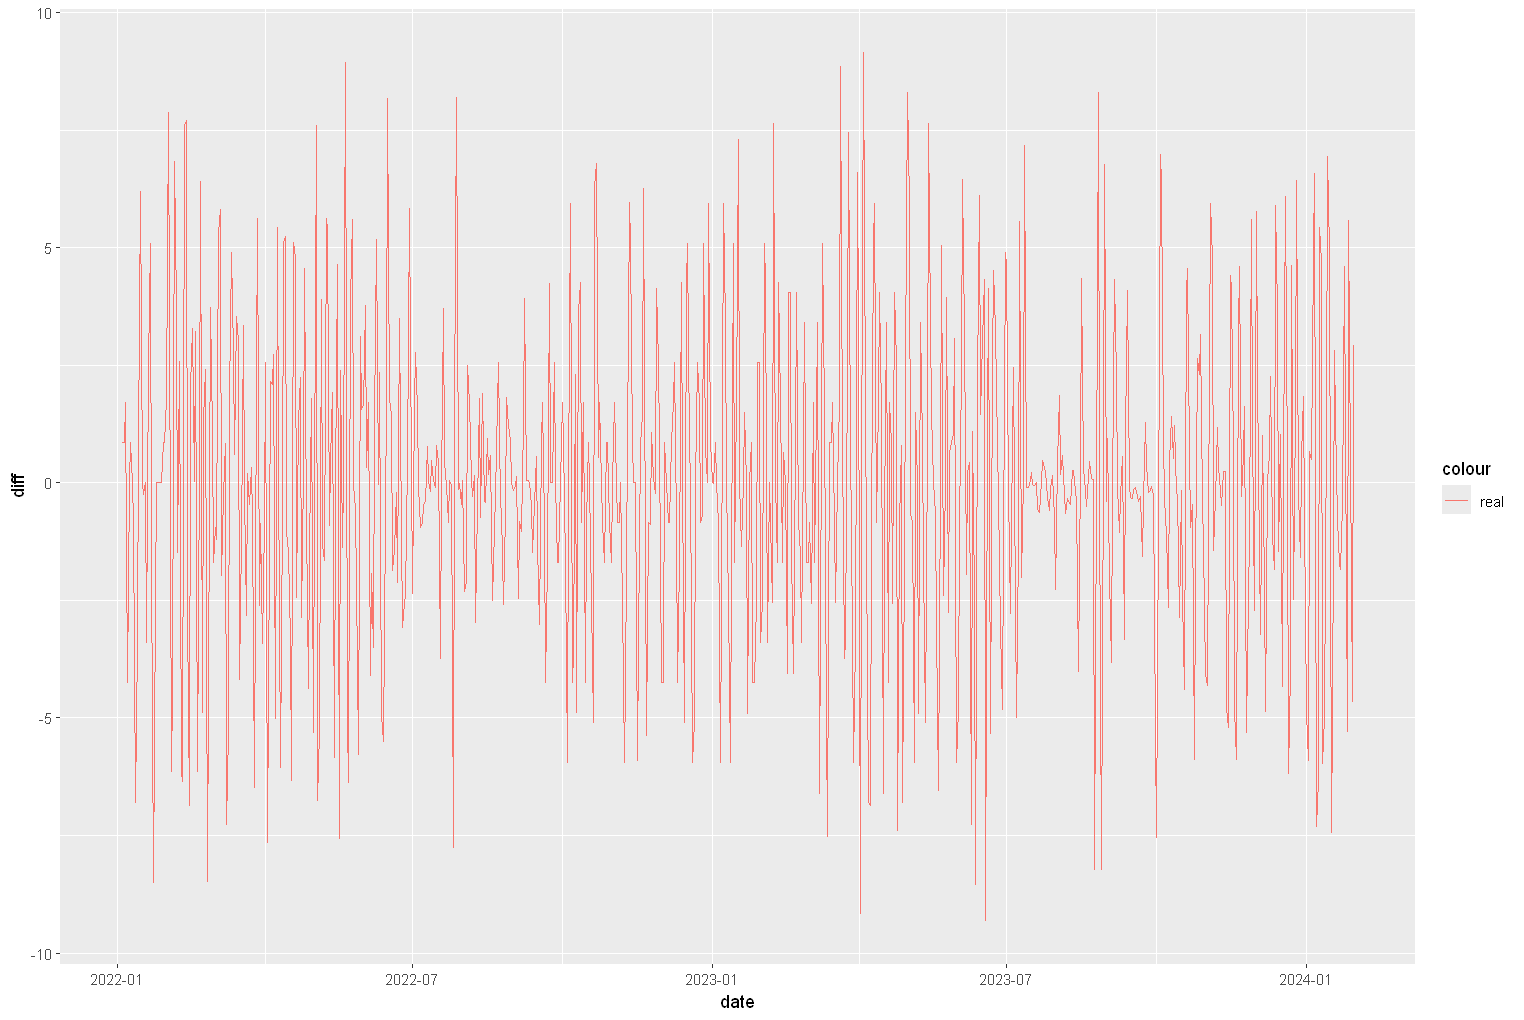

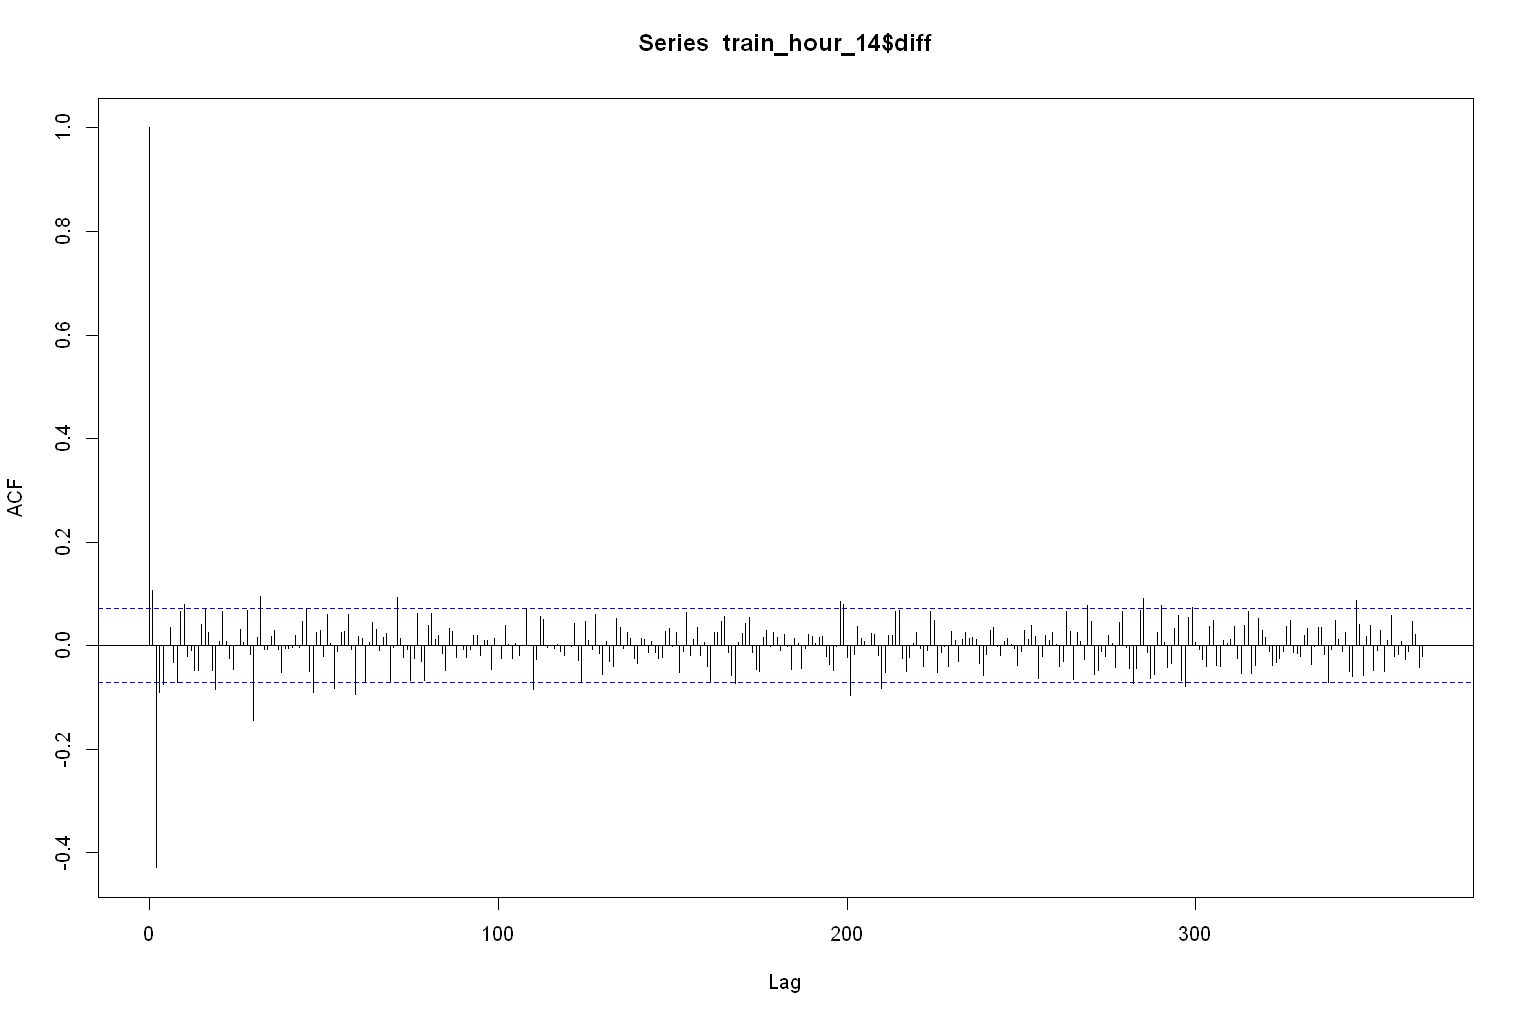

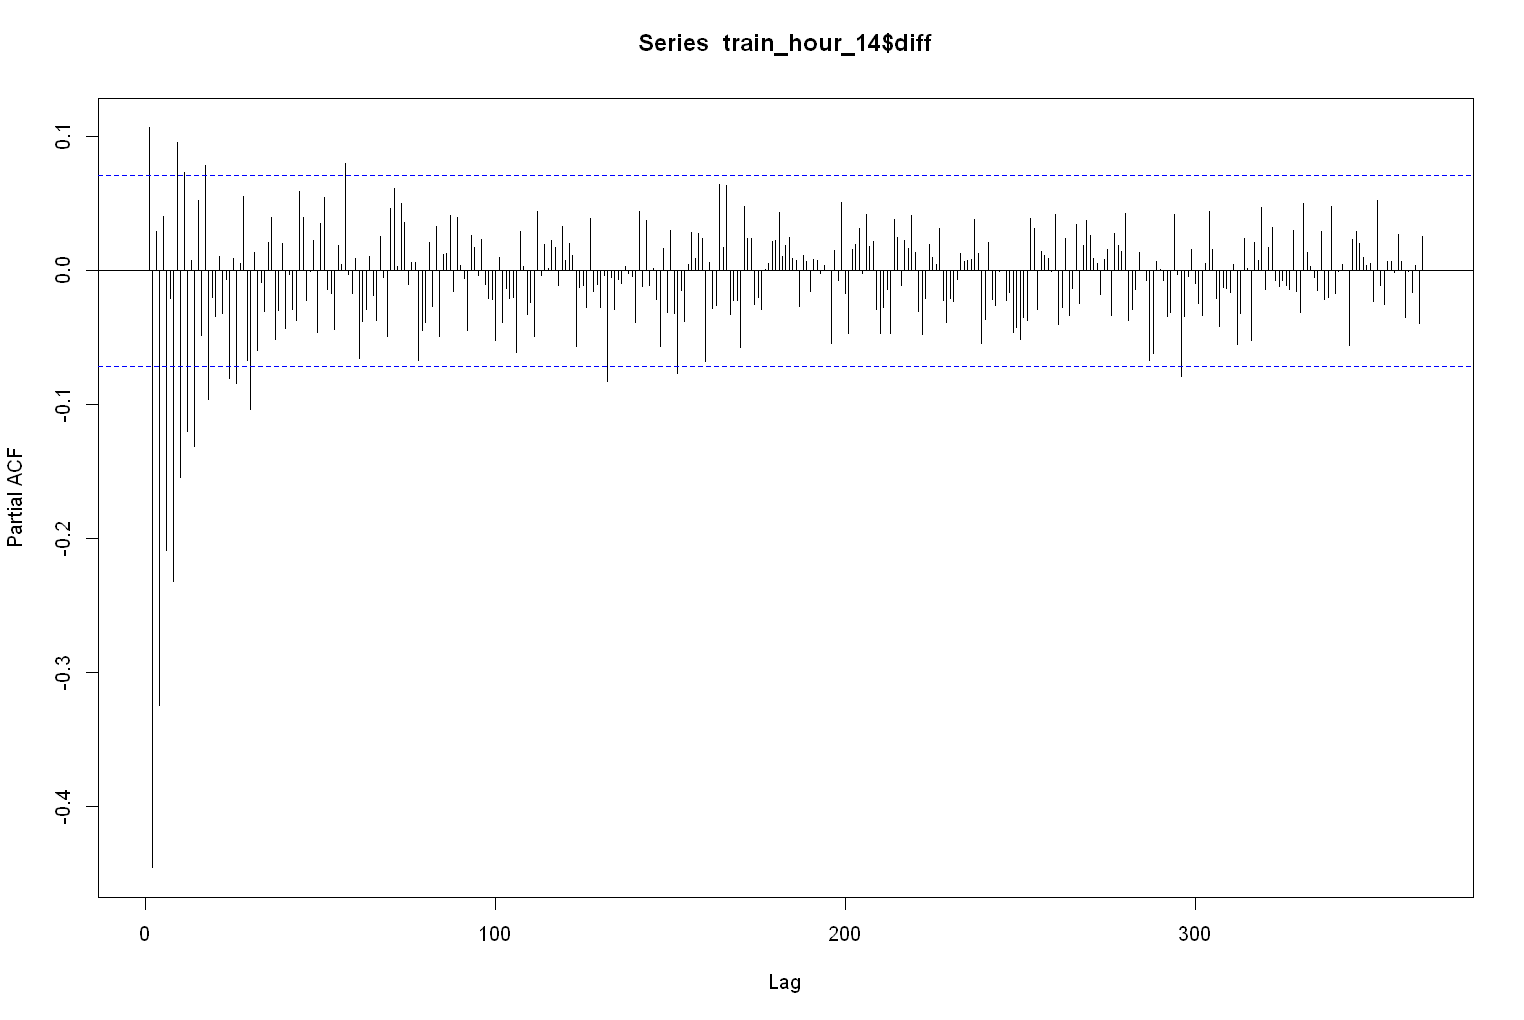

In [94]:
train_hour_14 <- train_split_data_tables[["14"]]
test_hour_14 <- test_split_data_tables[["14"]]

train_hour_14 <- na.omit(train_hour_14)
train_hour_14[,diff:=production - prod_lag_24]

ggplot(train_hour_14,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_14$diff,lag.max = 365)
pacf(train_hour_14$diff,lag.max = 365)

In [95]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_14$diff)
print(summary(simple_model))

Series: train_hour_14$diff 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1      ma2
      0.2213  0.0502  -0.8629
s.e.  0.0448  0.0249   0.0221

sigma^2 = 6.742:  log likelihood = -1796.37
AIC=3600.75   AICc=3600.8   BIC=3619.26

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.0745375 2.591372 2.067182 NaN  Inf 0.6065033 -0.009112318


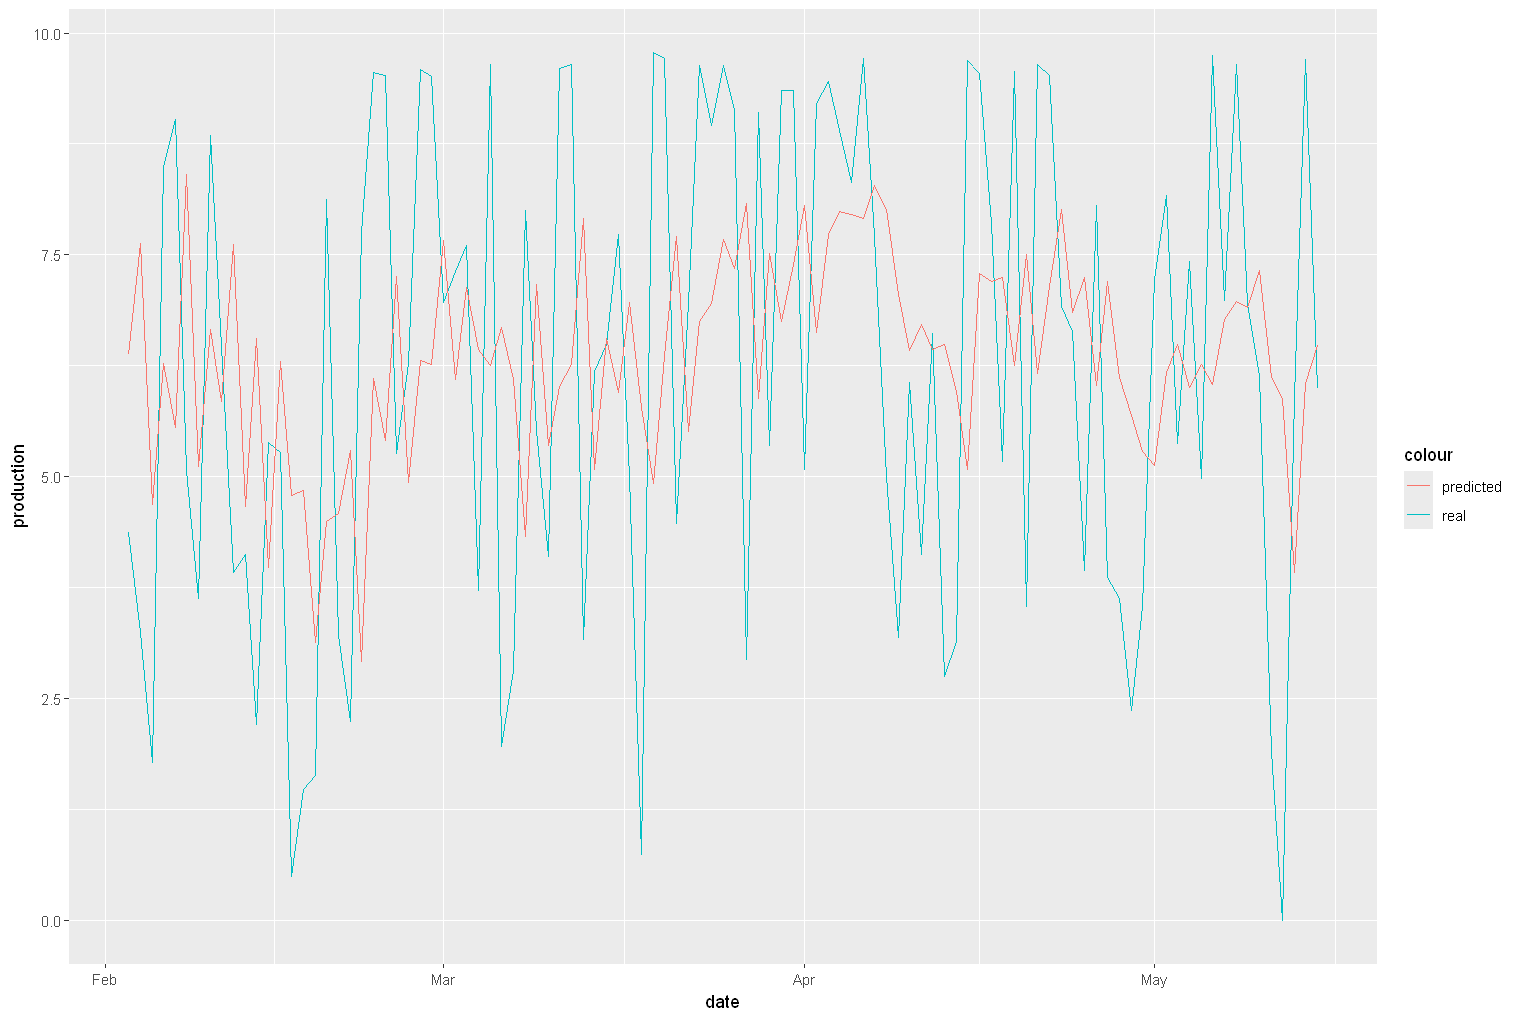

In [96]:
train_model <- Arima(train_hour_14$diff, order = c(1, 0, 2))
test_hour_14[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_14))

for (i in 1:nrow(test_hour_14)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_14$diff, test_hour_14$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_14[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_14,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 15

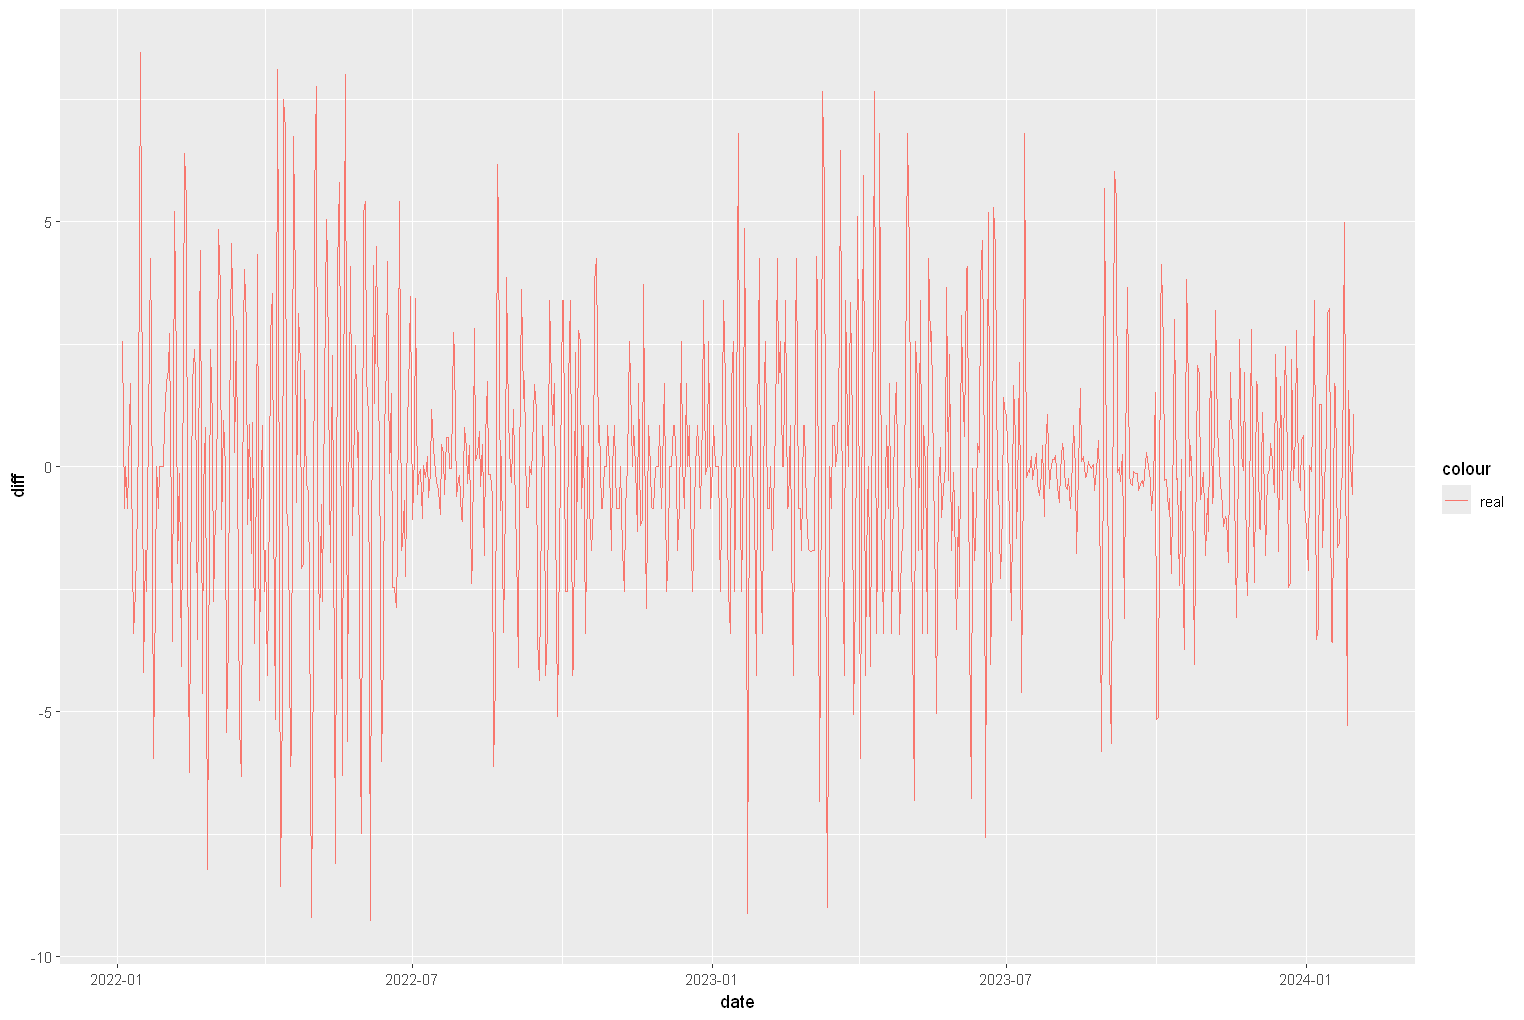

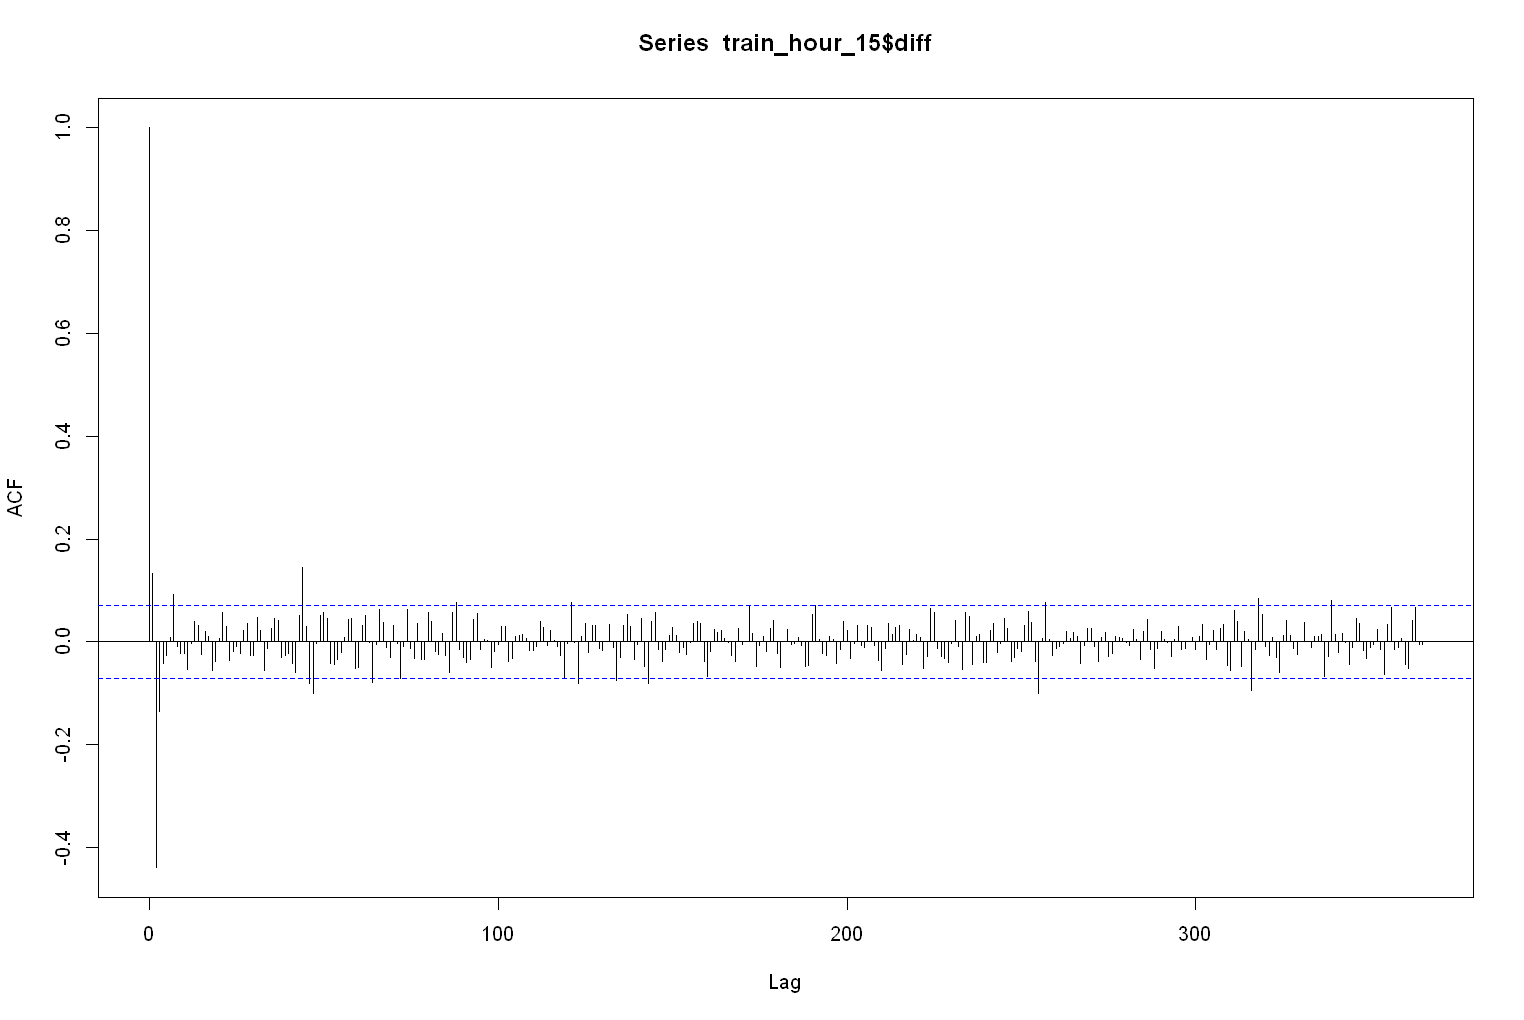

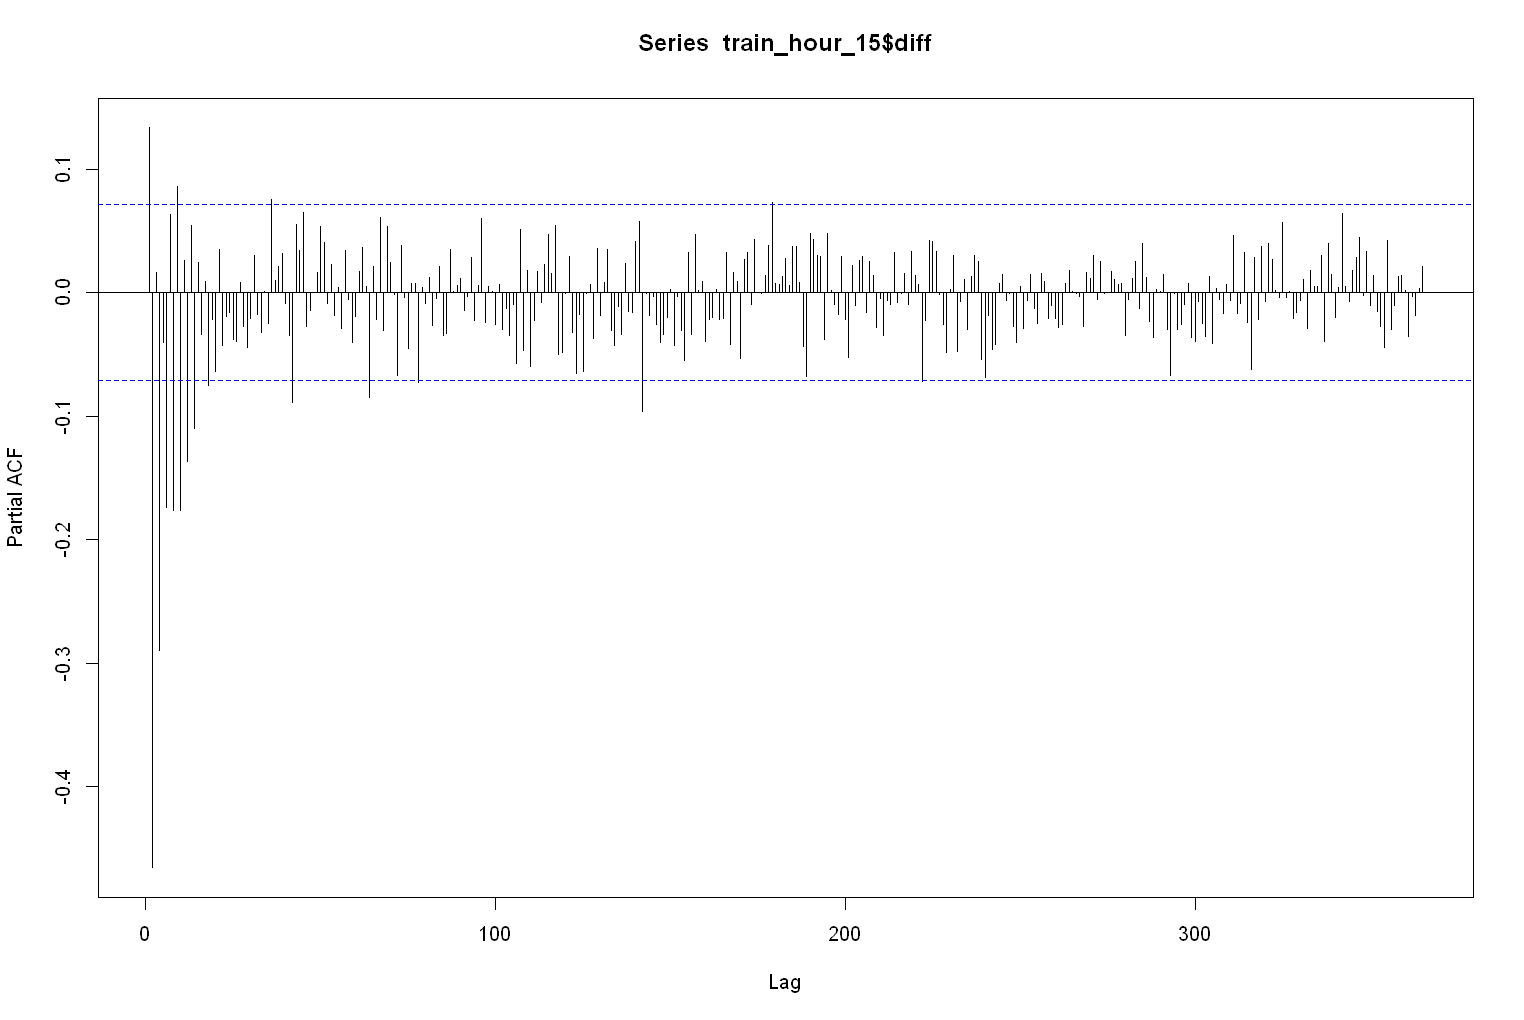

In [97]:
train_hour_15 <- train_split_data_tables[["15"]]
test_hour_15 <- test_split_data_tables[["15"]]

train_hour_15 <- na.omit(train_hour_15)
train_hour_15[,diff:=production - prod_lag_24]

ggplot(train_hour_15,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_15$diff,lag.max = 365)
pacf(train_hour_15$diff,lag.max = 365)

In [98]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_15$diff)
print(summary(simple_model))

Series: train_hour_15$diff 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1      ma2
      0.2188  0.0507  -0.8181
s.e.  0.0468  0.0289   0.0238

sigma^2 = 4.545:  log likelihood = -1644.68
AIC=3297.35   AICc=3297.41   BIC=3315.87

Training set error measures:
                      ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.08556927 2.127715 1.614939 NaN  Inf 0.6319405 -0.009880985


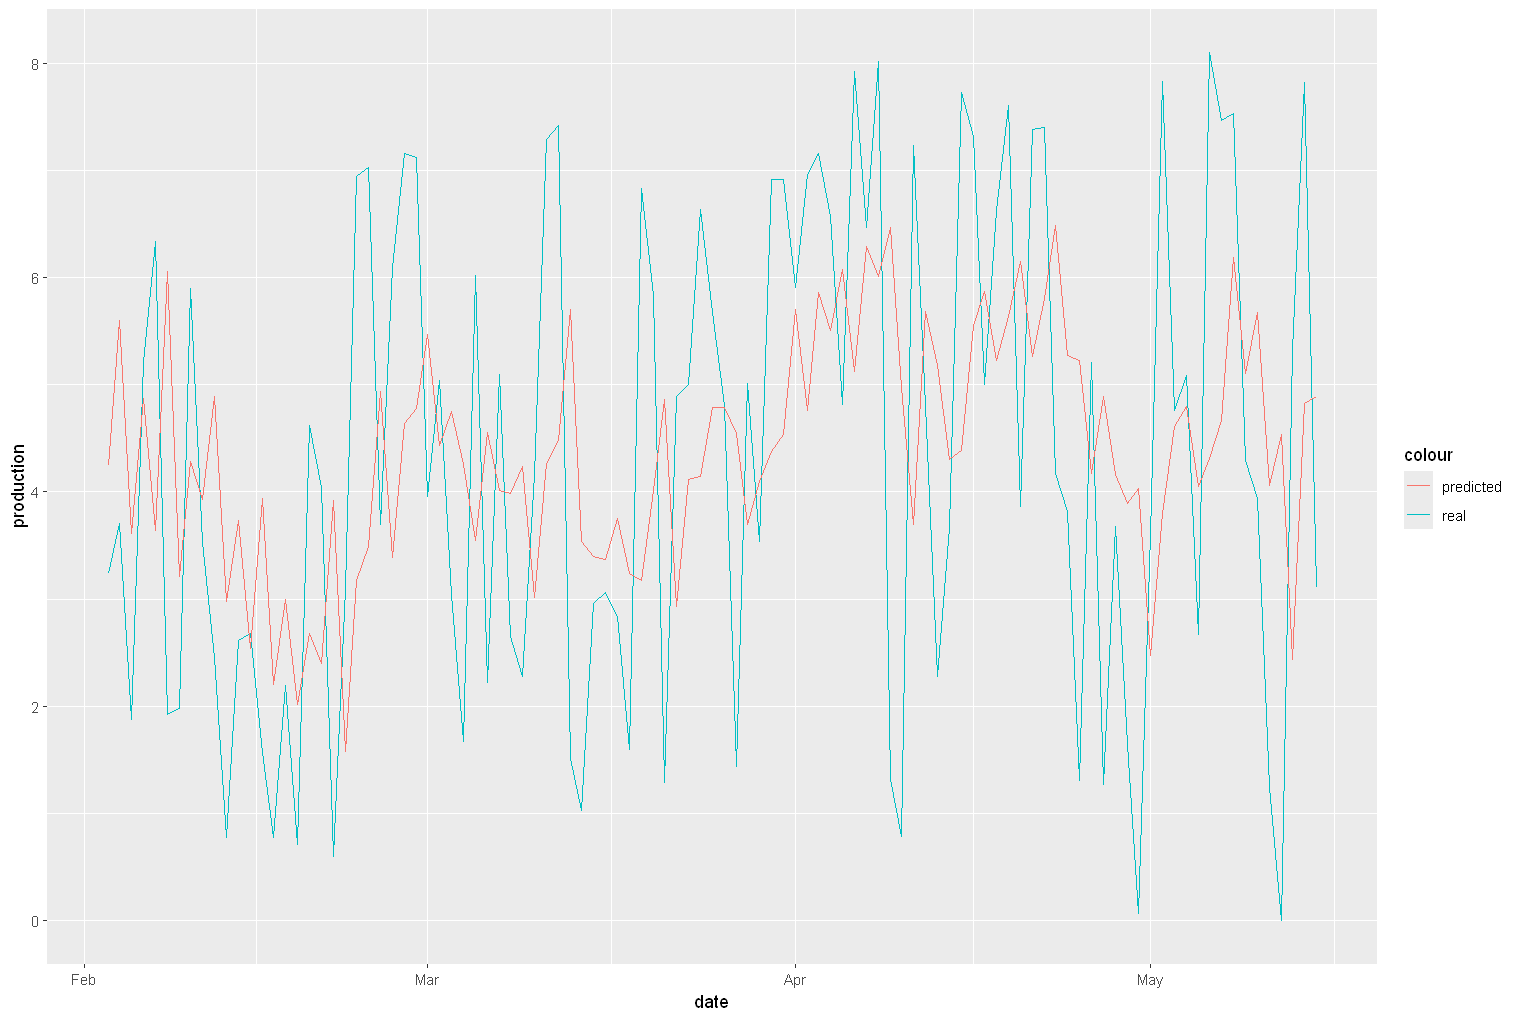

In [99]:
train_model <- Arima(train_hour_15$diff, order = c(1, 0, 2))
test_hour_15[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_15))

for (i in 1:nrow(test_hour_15)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_15$diff, test_hour_15$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_15[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_15,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 16

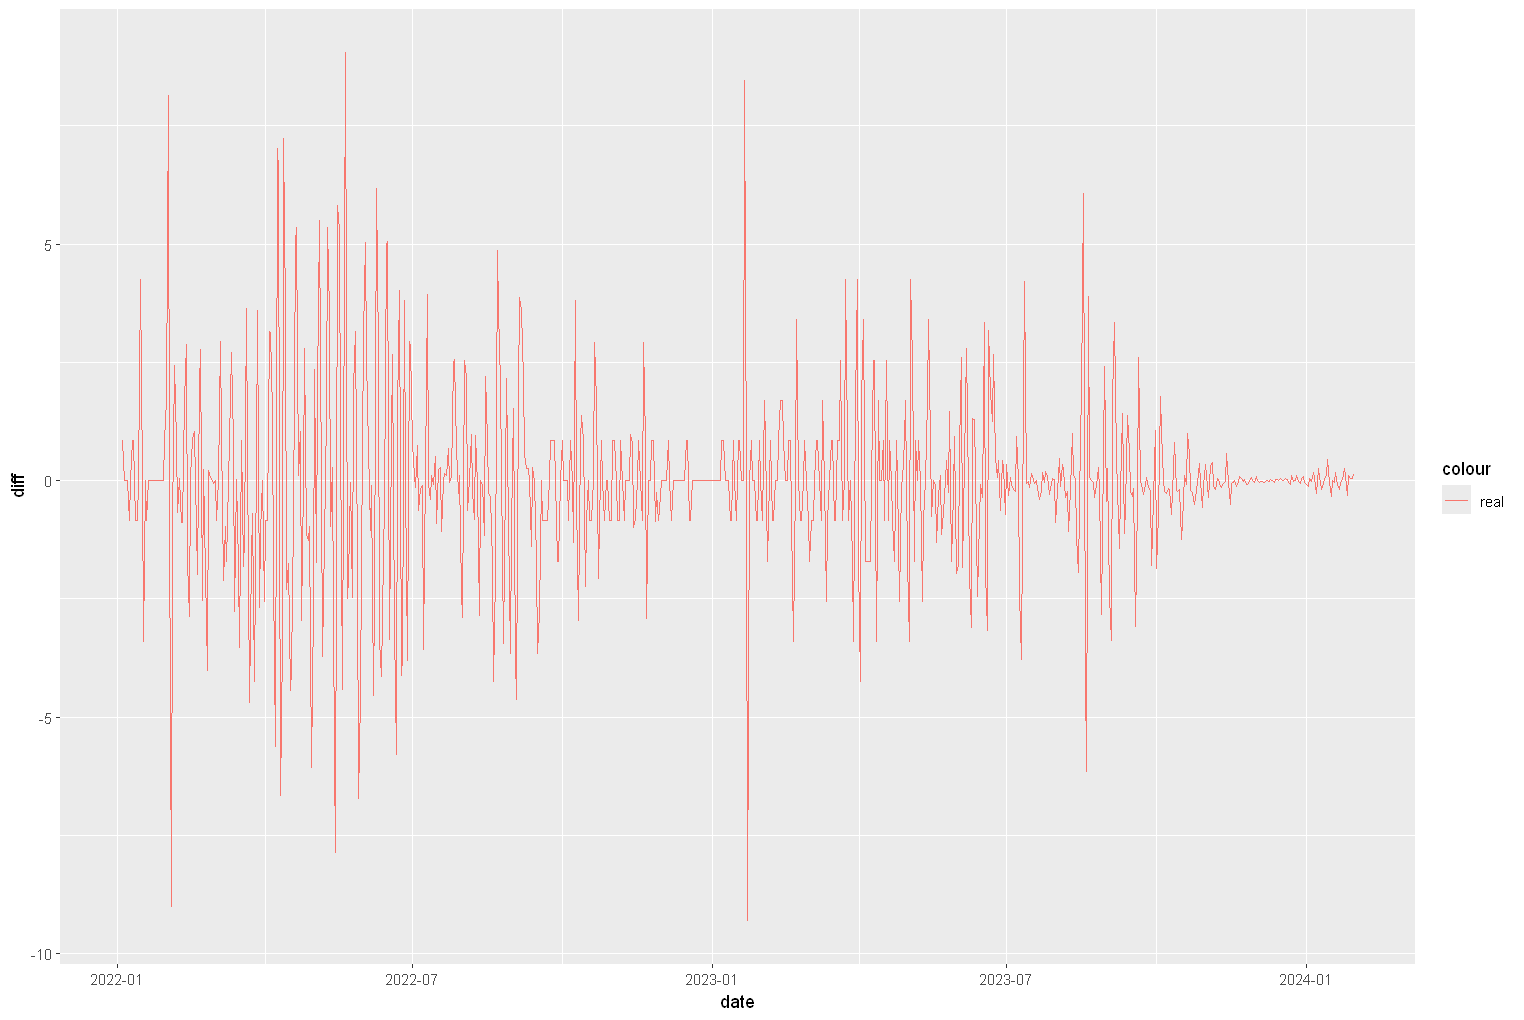

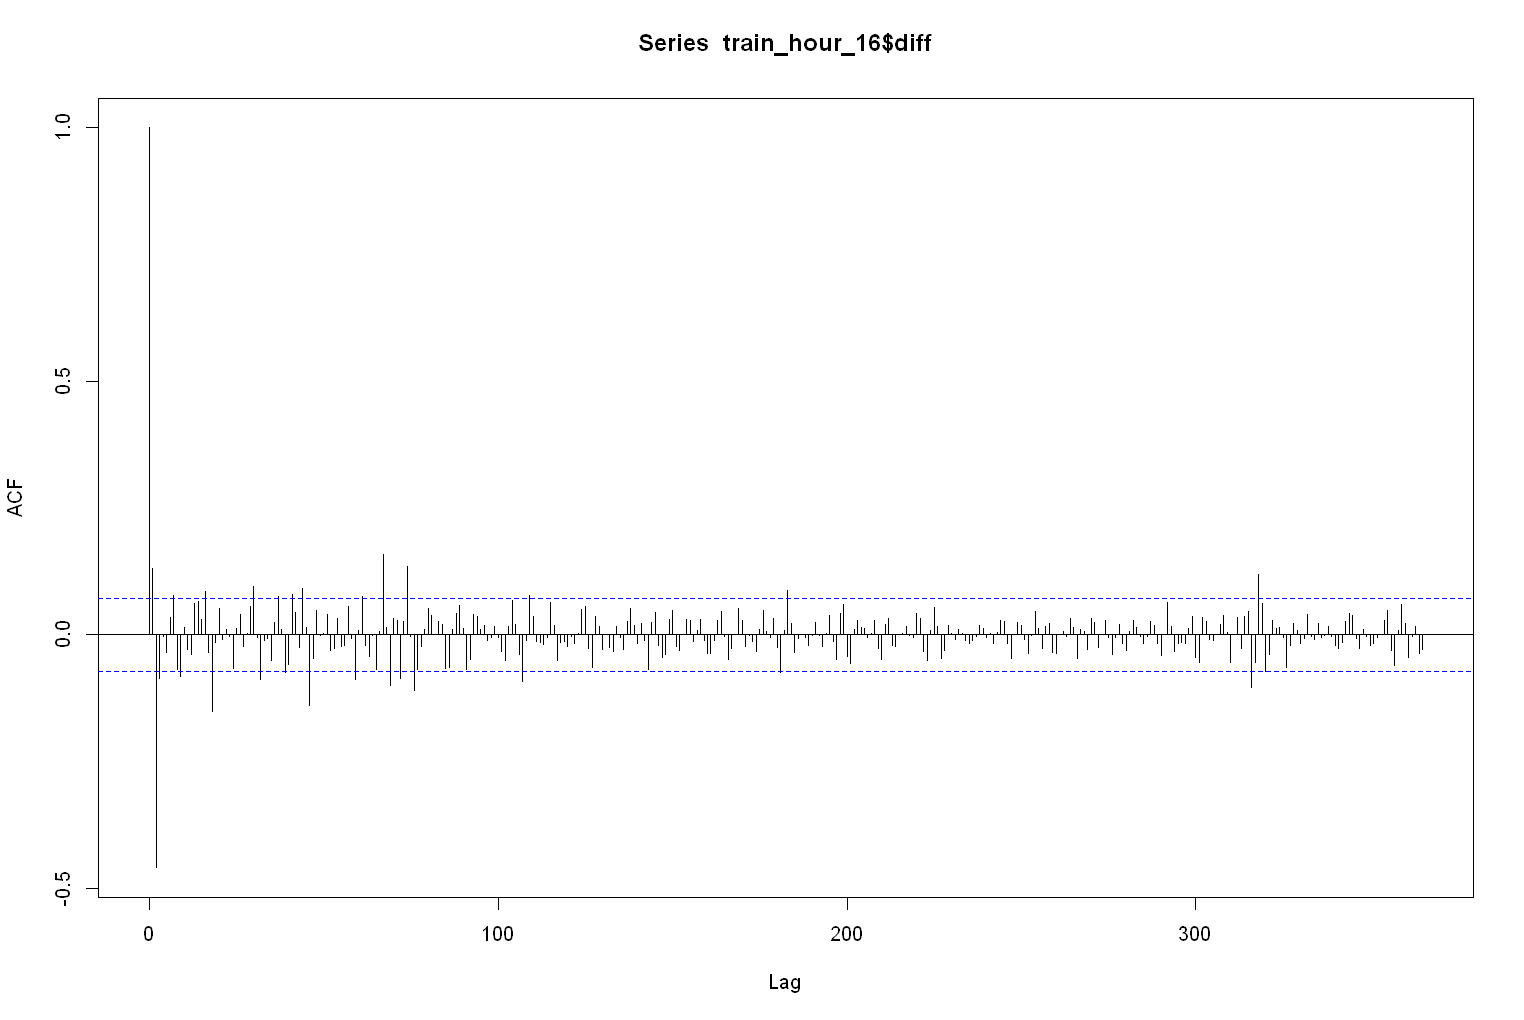

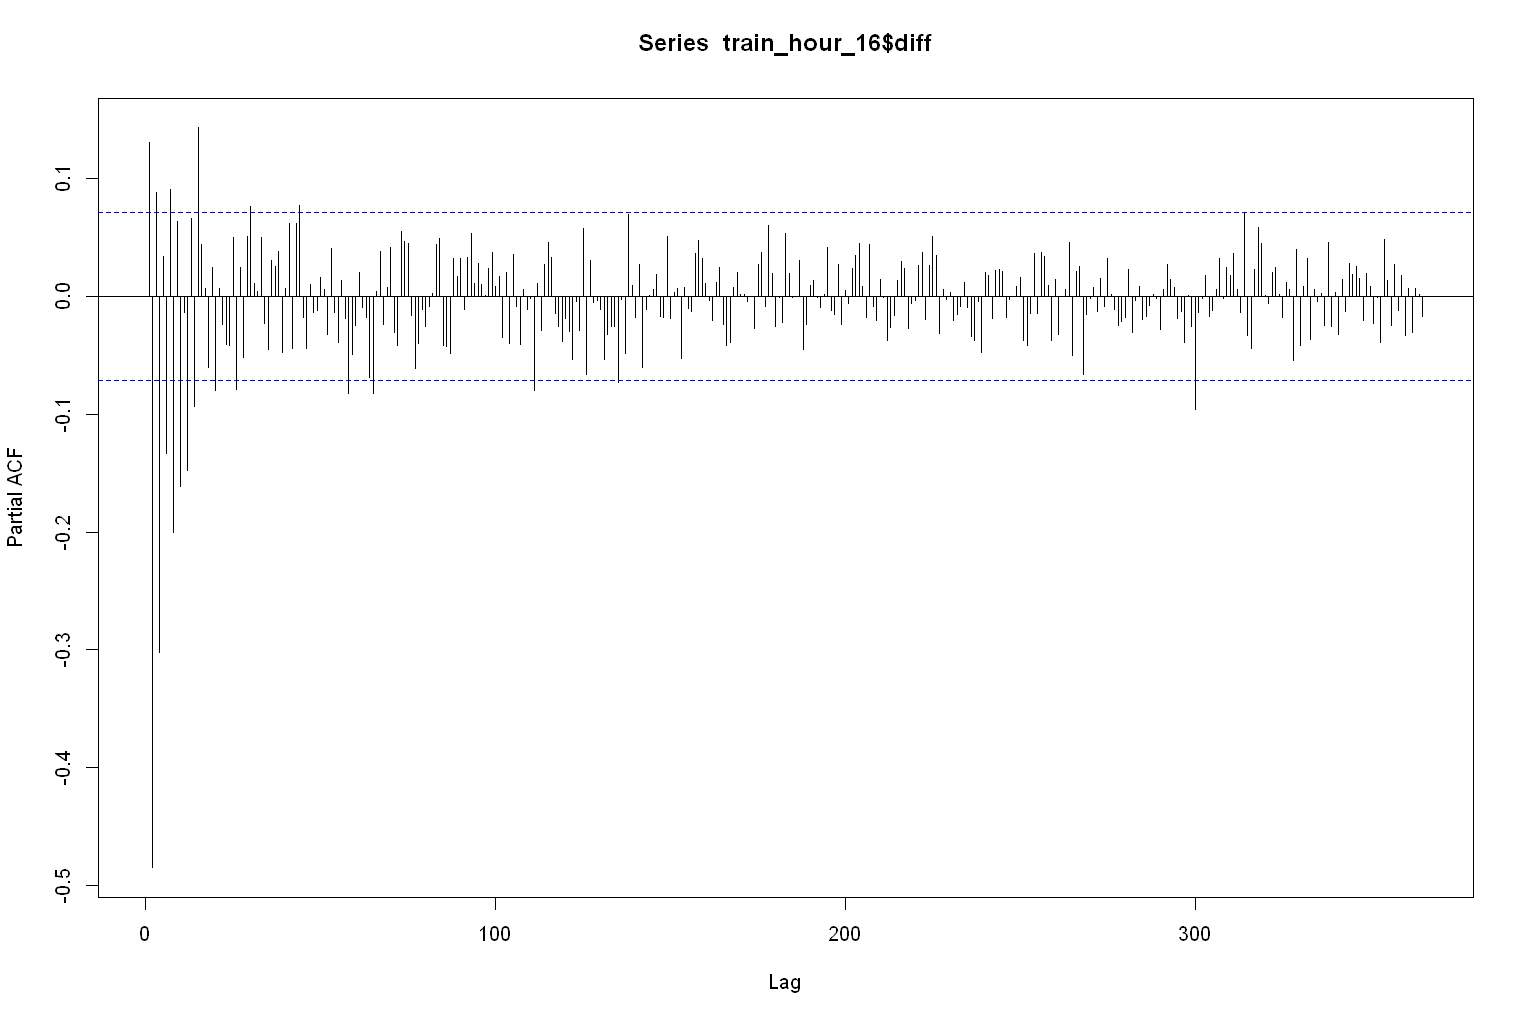

In [100]:
train_hour_16 <- train_split_data_tables[["16"]]
test_hour_16 <- test_split_data_tables[["16"]]

train_hour_16 <- na.omit(train_hour_16)
train_hour_16[,diff:=production - prod_lag_24]

ggplot(train_hour_16,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_16$diff,lag.max = 365)
pacf(train_hour_16$diff,lag.max = 365)

In [101]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_16$diff)
print(summary(simple_model))

Series: train_hour_16$diff 
ARIMA(0,0,3) with zero mean 

Coefficients:
         ma1      ma2      ma3
      0.3671  -0.7206  -0.1706
s.e.  0.0358   0.0288   0.0359

sigma^2 = 2.281:  log likelihood = -1385.81
AIC=2779.62   AICc=2779.67   BIC=2798.14

Training set error measures:
                      ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.06479397 1.507167 0.971088 NaN  Inf 0.6124438 -0.000201934


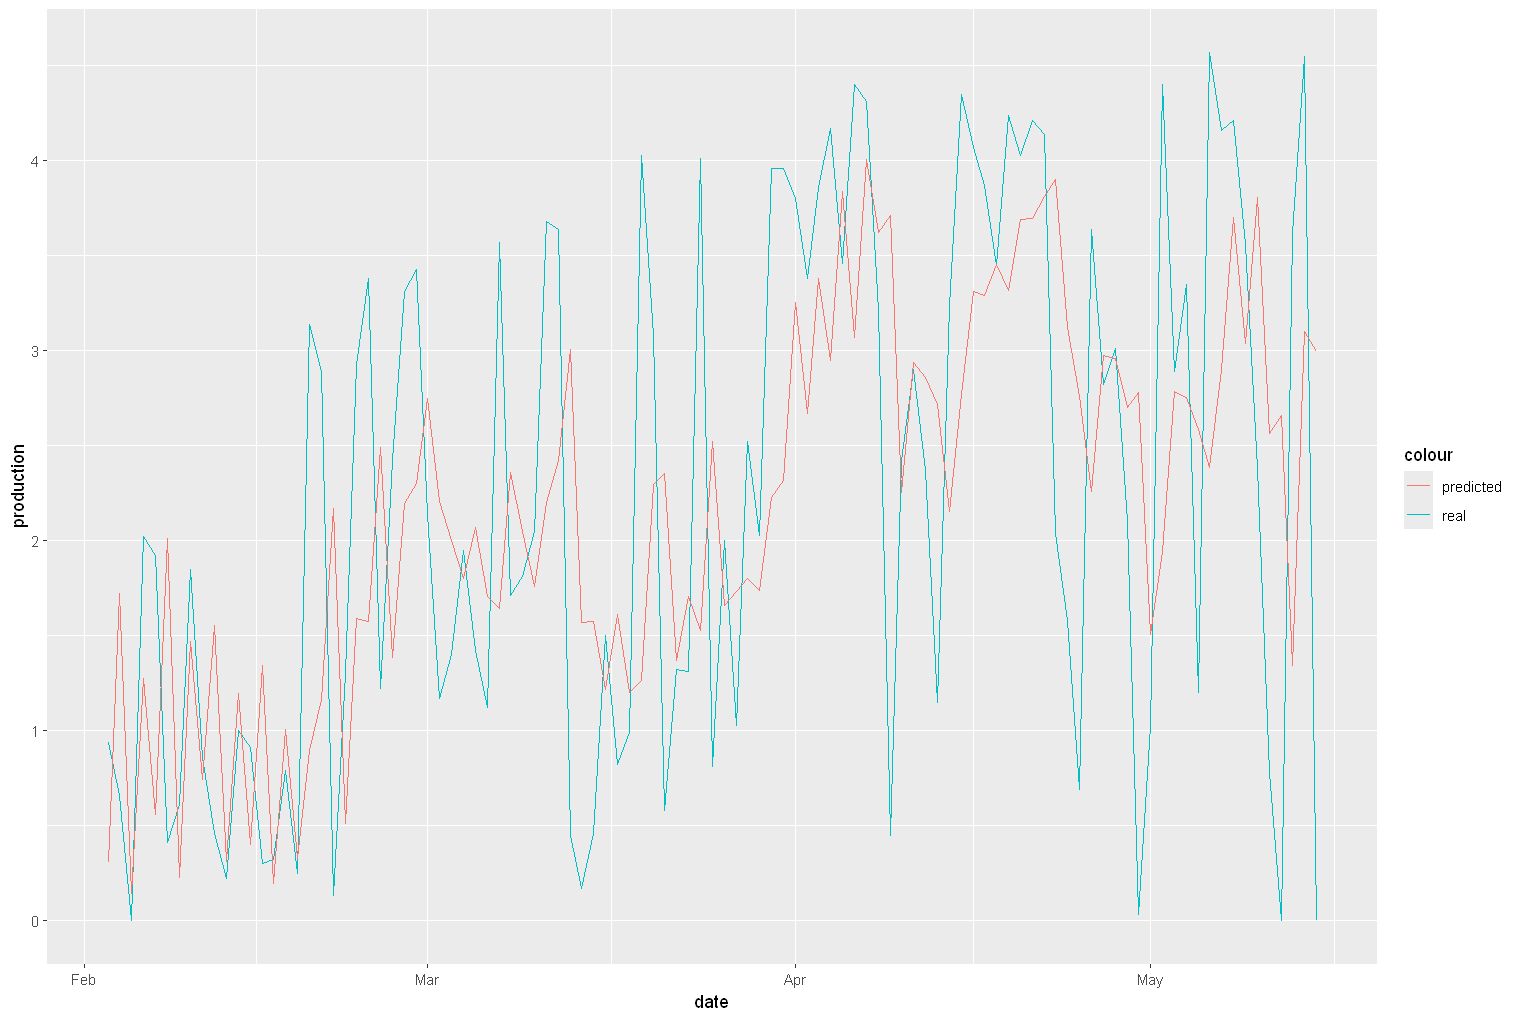

In [102]:
train_model <- Arima(train_hour_16$diff, order = c(1, 0, 2))
test_hour_16[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_16))

for (i in 1:nrow(test_hour_16)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_16$diff, test_hour_16$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_16[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_16,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Hour 17

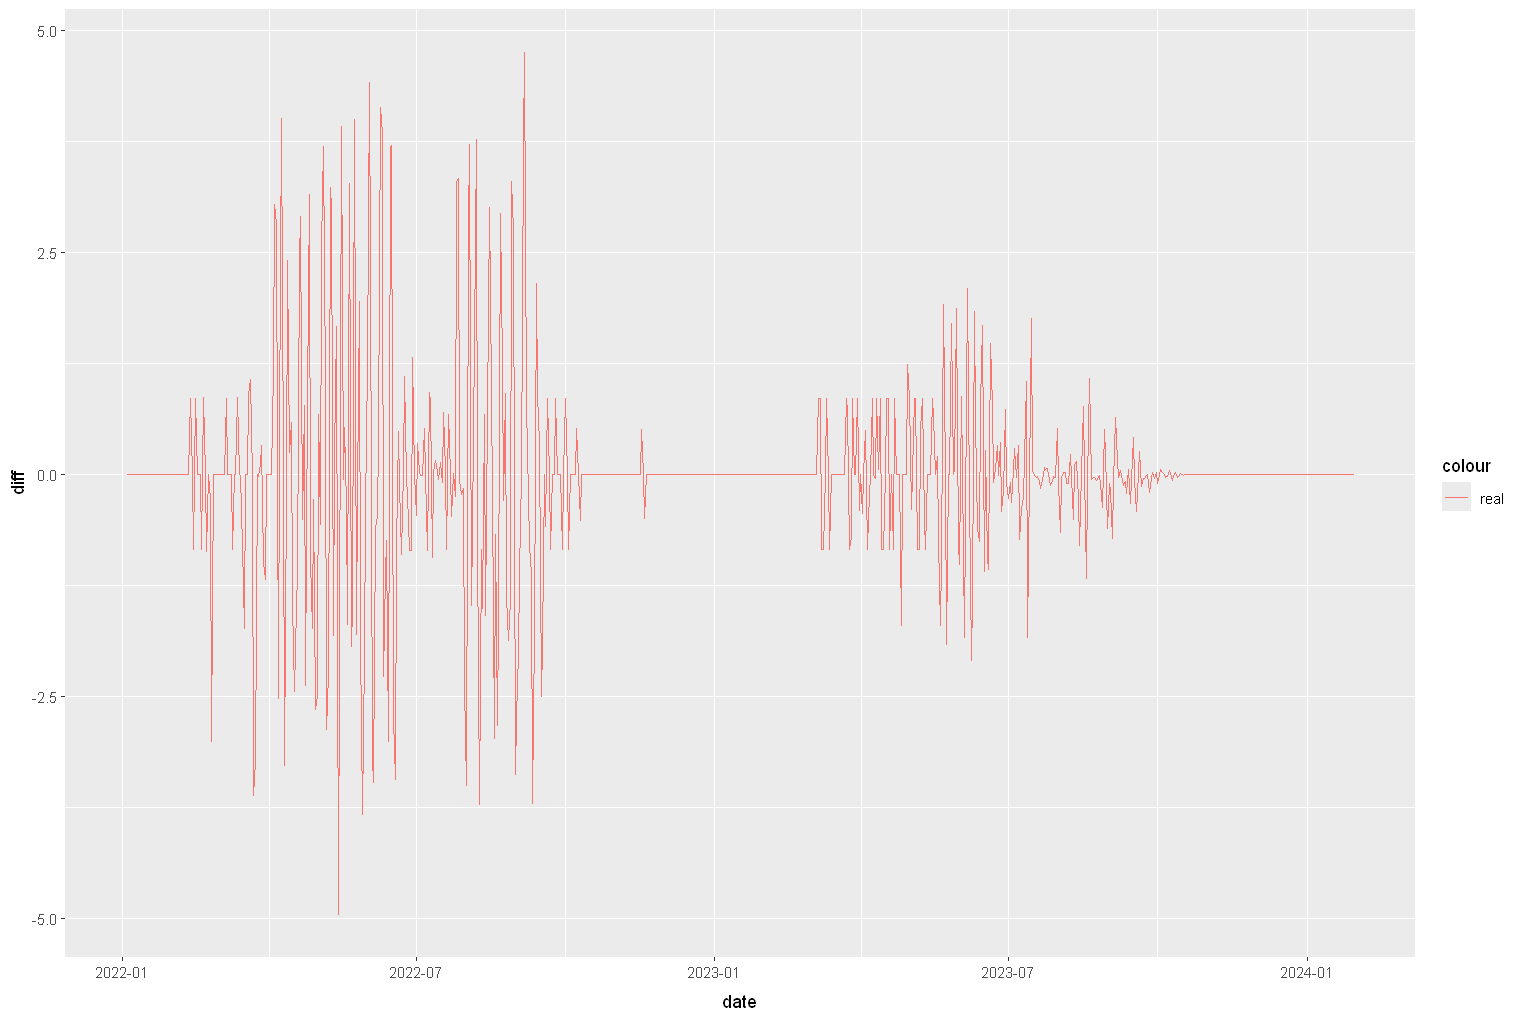

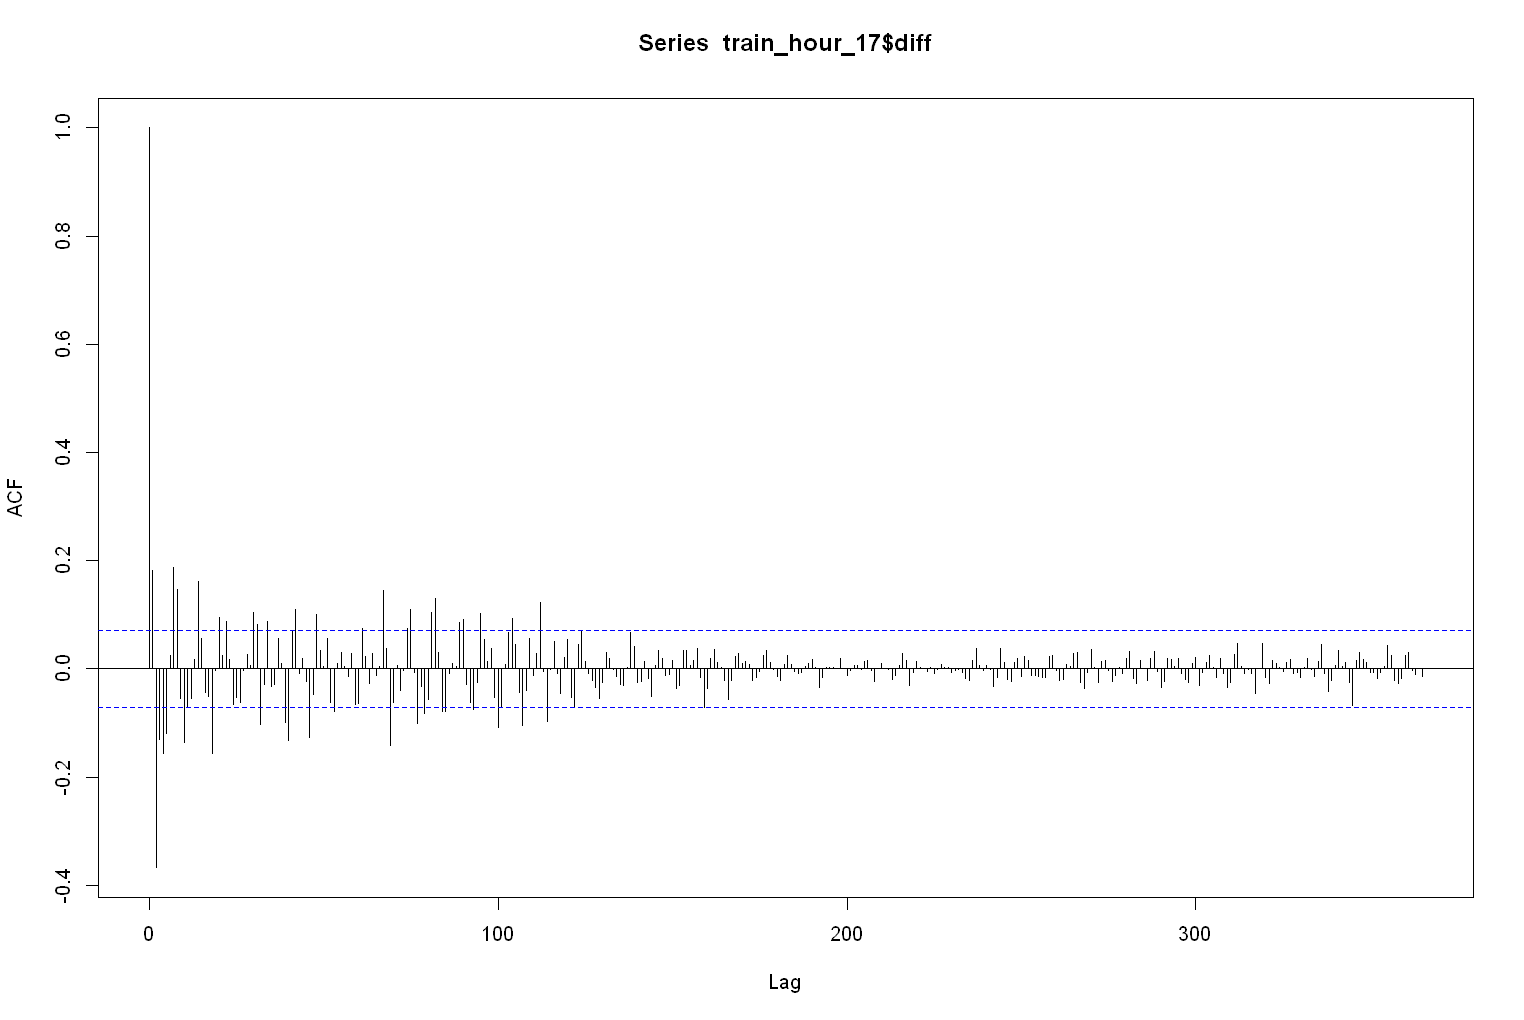

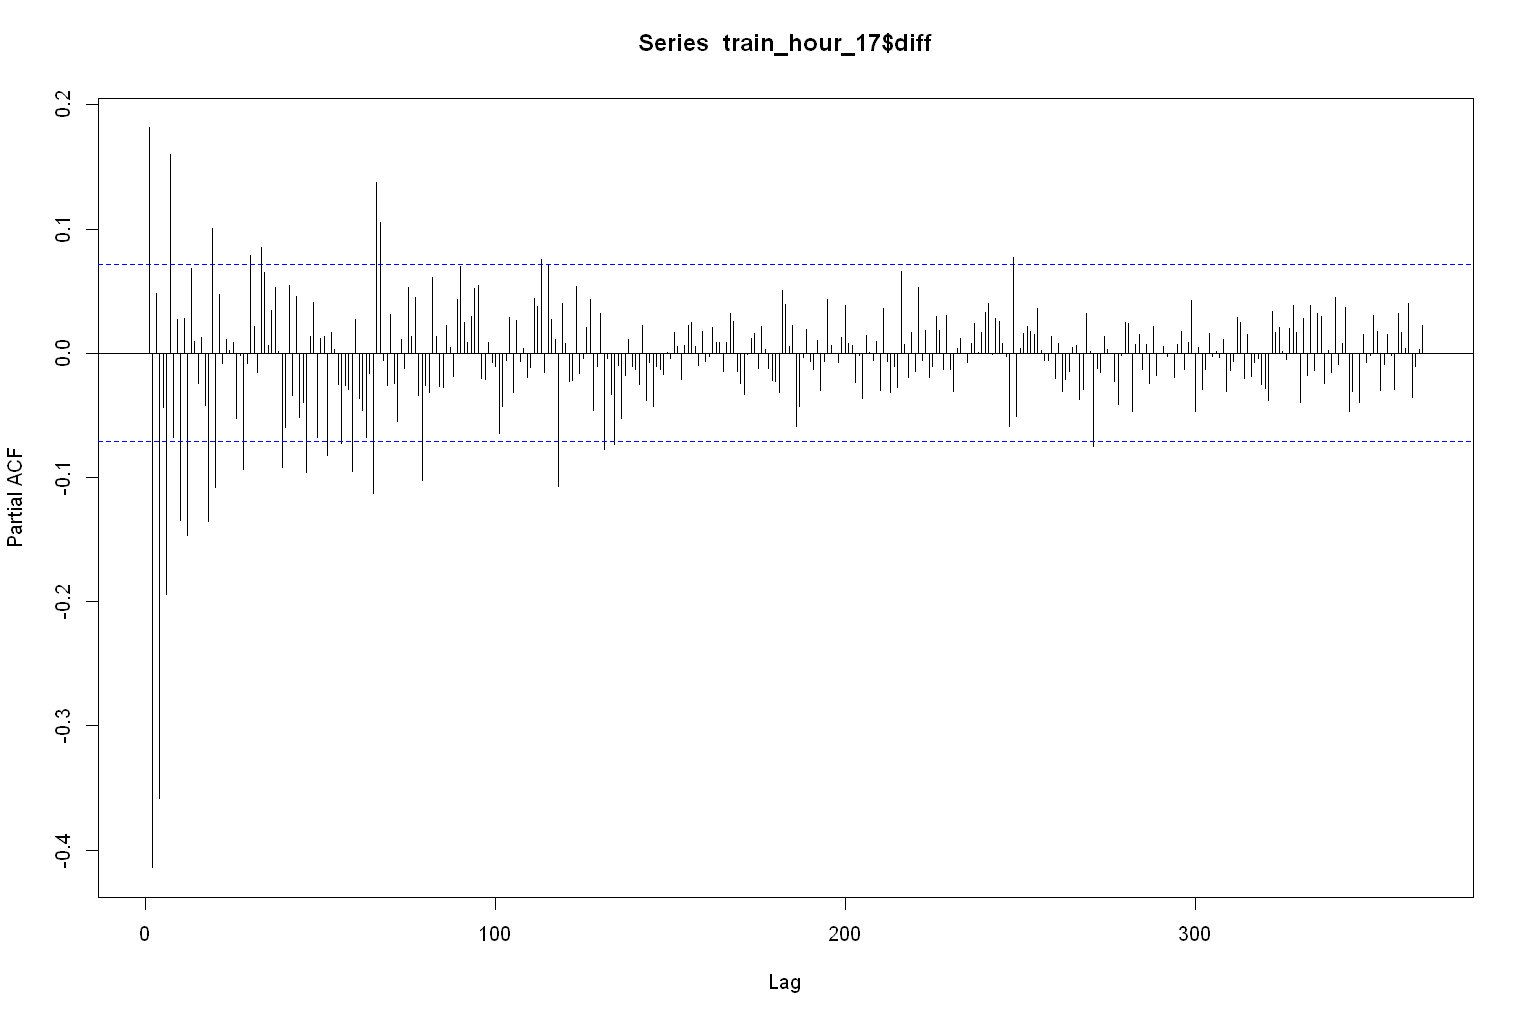

In [103]:
train_hour_17 <- train_split_data_tables[["17"]]
test_hour_17 <- test_split_data_tables[["17"]]

train_hour_17 <- na.omit(train_hour_17)
train_hour_17[,diff:=production - prod_lag_24]

ggplot(train_hour_17,aes(x=date)) + geom_line(aes(y=diff,color='real'))
acf(train_hour_17$diff,lag.max = 365)
pacf(train_hour_17$diff,lag.max = 365)

In [104]:
# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(train_hour_17$diff)
print(summary(simple_model))

Series: train_hour_17$diff 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1     ma1      ma2
      0.2828  0.0884  -0.7587
s.e.  0.0516  0.0351   0.0281

sigma^2 = 0.7331:  log likelihood = -956.05
AIC=1920.11   AICc=1920.16   BIC=1938.63

Training set error measures:
                      ME      RMSE       MAE MPE MAPE      MASE       ACF1
Training set -0.03342719 0.8545149 0.4667406 NaN  Inf 0.6739808 -0.0109336


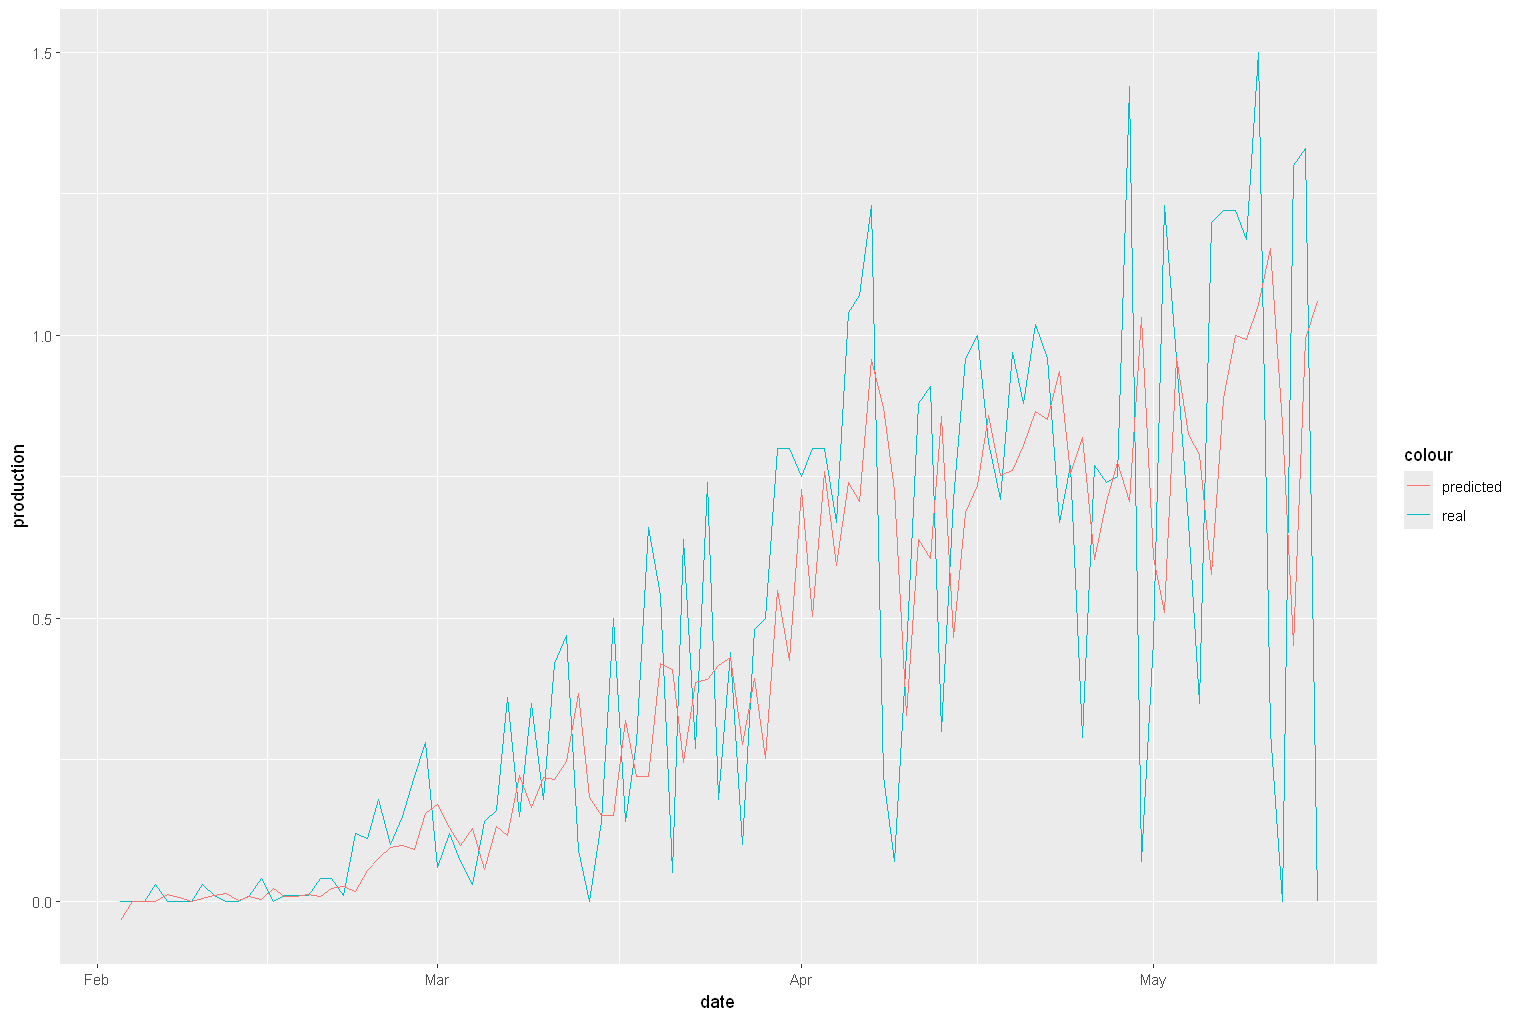

In [105]:
train_model <- Arima(train_hour_17$diff, order = c(1, 0, 2))
test_hour_17[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_hour_17))

for (i in 1:nrow(test_hour_17)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(train_hour_17$diff, test_hour_17$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- auto.arima(new_data)
}

test_hour_17[,predicted:= prod_lag_24 + predictions]

ggplot(test_hour_17,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

## Results

In [106]:
arima_results <- rbind(test_hour_6, test_hour_7,test_hour_8,test_hour_9,test_hour_10,test_hour_11,test_hour_12,test_hour_13,test_hour_14,test_hour_15,test_hour_16,test_hour_17)
arima_results

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,hour_transformed,prod_lag_24,prod_lag_36,max_production,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,diff,predicted
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-02-03,6,0,0,0,0,0,0,0,0,⋯,-36,0.01,0.01,9.89,268.3936,273.6110,276.823,278.888,0.00,-0.0002410155
2024-02-04,6,0,0,0,0,0,0,0,0,⋯,-36,0.01,0.01,9.88,270.1280,274.4055,276.914,278.842,0.06,0.0452451219
2024-02-05,6,0,1,1,1,0,0,0,1,⋯,-36,0.01,0.01,9.88,272.1920,275.6120,278.194,280.482,-0.01,0.0162120337
2024-02-06,6,0,1,0,1,0,1,1,0,⋯,-36,0.07,0.01,9.83,274.2160,275.8720,277.419,278.900,-0.07,0.0480016459
2024-02-07,6,0,0,0,0,0,0,0,0,⋯,-36,0.00,0.07,9.88,271.8670,279.9720,282.645,284.288,0.02,-0.0007174678
2024-02-08,6,0,0,0,0,0,0,0,0,⋯,-36,0.00,0.00,9.88,273.0330,281.3080,284.621,286.642,0.06,0.0409517248
2024-02-09,6,0,0,0,0,0,0,0,0,⋯,-36,0.02,0.00,9.88,272.7390,280.1440,282.563,284.268,0.05,0.0128849489
2024-02-10,6,0,0,0,0,0,0,0,0,⋯,-36,0.06,0.02,9.88,272.0060,281.4290,284.604,286.605,0.00,0.0570348311
2024-02-11,6,0,0,0,0,0,0,0,0,⋯,-36,0.07,0.06,9.87,273.2350,282.2620,285.258,286.980,0.01,0.0273875602


In [107]:
arima_results <- arima_results %>%
  arrange(date, hour)

arima_results

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,hour_transformed,prod_lag_24,prod_lag_36,max_production,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,diff,predicted
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-02-03,6,0,0,0,0,0,0,0,0,⋯,-36,0.01,0.01,9.89,268.3936,273.6110,276.8230,278.8880,0.00,-2.410155e-04
2024-02-03,7,0,0,0,0,0,0,0,0,⋯,-25,1.59,0.79,9.89,268.4030,268.3936,273.6110,276.8230,-0.65,2.018925e+00
2024-02-03,8,0,0,0,0,0,0,0,0,⋯,-16,6.17,5.60,9.89,268.9020,268.4030,268.3936,273.6110,-1.96,9.718954e+00
2024-02-03,9,0,0,0,0,0,0,0,0,⋯,-9,7.11,8.86,9.89,271.7370,268.9020,268.4030,268.3936,-0.28,9.902075e+00
2024-02-03,10,0,0,0,0,0,0,0,0,⋯,-4,5.20,9.89,9.88,275.0200,271.7370,268.9020,268.4030,0.91,9.896811e+00
2024-02-03,11,0,0,0,0,0,0,0,0,⋯,-1,3.53,9.85,9.88,277.6590,275.0200,271.7370,268.9020,5.56,8.432846e+00
2024-02-03,12,0,0,0,0,0,0,0,0,⋯,0,4.92,9.83,9.88,279.6090,277.6590,275.0200,271.7370,3.79,8.715851e+00
2024-02-03,13,0,0,0,0,0,0,0,0,⋯,-1,4.90,9.73,9.88,280.5390,279.6090,277.6590,275.0200,3.12,9.544334e+00
2024-02-03,14,0,0,0,0,0,0,0,0,⋯,-4,5.78,5.11,9.88,280.0790,280.5390,279.6090,277.6590,-1.41,6.382727e+00


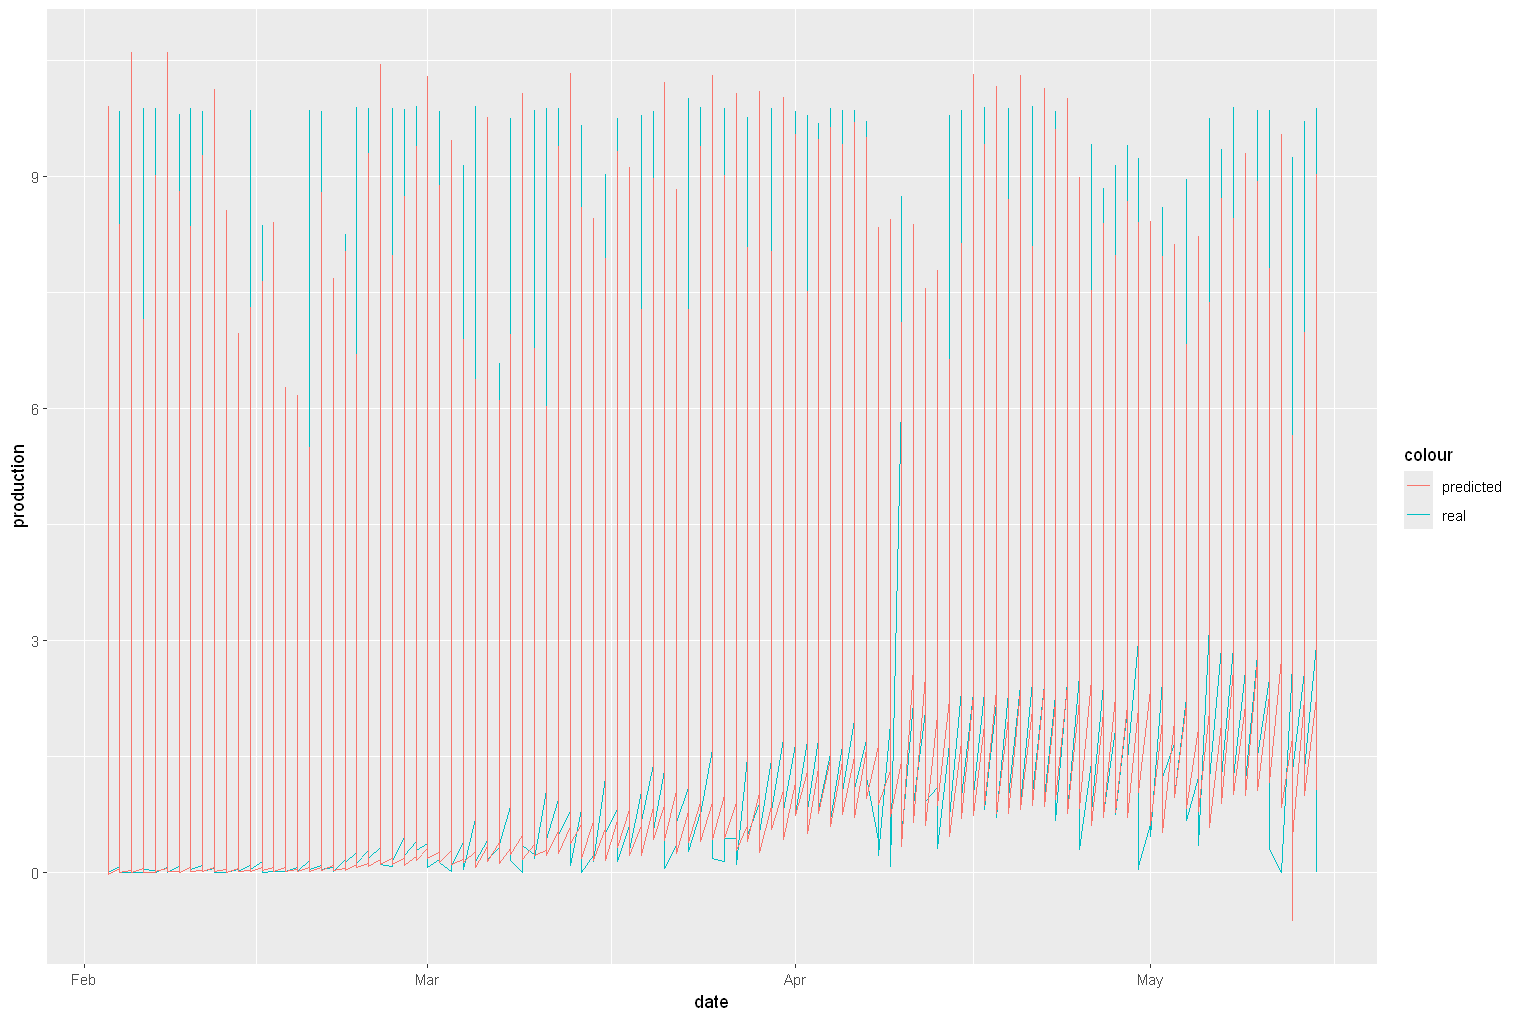

In [108]:
ggplot(arima_results,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

Warning message:
"Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved."



	Ljung-Box test

data:  Residuals
Q* = 1600, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



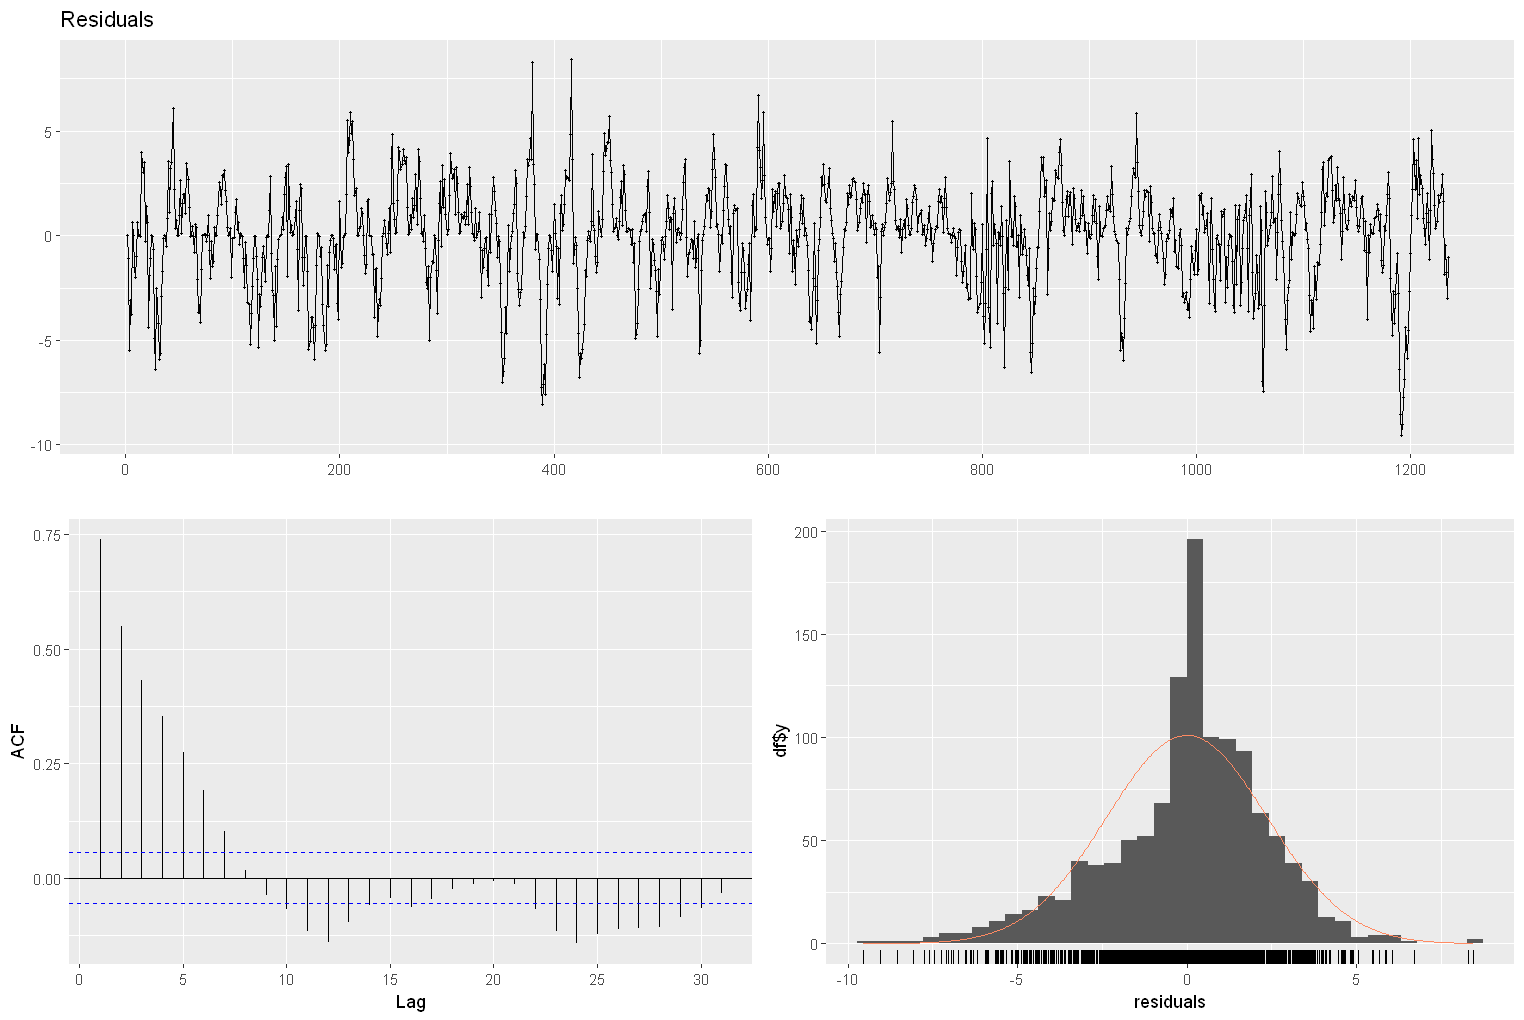

In [109]:
arima_results[,residual:=production-predicted]
checkresiduals(arima_results$residual)

In [110]:
accu5 <- accu("5. ARIMA for each hour", arima_results$production, arima_results$predicted)
comparisons <- rbind(comparisons, accu5)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.1048254650,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.1088095279,4058.146,1.994581,1.573241,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.0745083684,4407.538,1.908707,1.505325,0.2984292,0.2984292
3. Lasso(1sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0809165157,4201.848,1.906118,1.493561,0.2954455,0.2954455
4. Lasso(3sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0991611324,4422.851,1.946731,1.549387,0.3064887,0.3064887
5. ARIMA for each hour,1236,5.055283,3.381461,0.6688964,0.0007428499,6006.657,2.373454,1.752375,0.3466422,0.3466422


# Sixth Approach : ARIMA for overall data

filtered_data is the training set with only lasso variables (1sd)

In [111]:
setDT(filtered_data)
filtered_data[,diff:=production - prod_lag_24]

# Fit a simple ARIMA model without external regressors
simple_model <- auto.arima(filtered_data$diff)
print(summary(simple_model))

Series: filtered_data$diff 
ARIMA(2,0,1) with zero mean 

Coefficients:
         ar1     ar2     ma1
      0.1110  0.4437  0.5785
s.e.  0.1328  0.0926  0.1356

sigma^2 = 3.968:  log likelihood = -19165.18
AIC=38338.37   AICc=38338.37   BIC=38366.83

Training set error measures:
                       ME     RMSE      MAE MPE MAPE     MASE        ACF1
Training set 0.0002259789 1.991602 1.335724 NaN  Inf 0.932293 0.003566144


Auto.arima function found ARIMA (2,0,1) as the best fit. It uses autoregressive terms at lag 1 and lag 2, and the last residual value (MA1). We are predicting the 2-days differences. In this context, the autoregressive value at lag 1 for hour 14 is the 2-days difference of the previous hour, 13. However, we do not know this information yet in the forecasting setting. Therefore, ARIMA (2,0,1) model for overall data is impractical for our case.

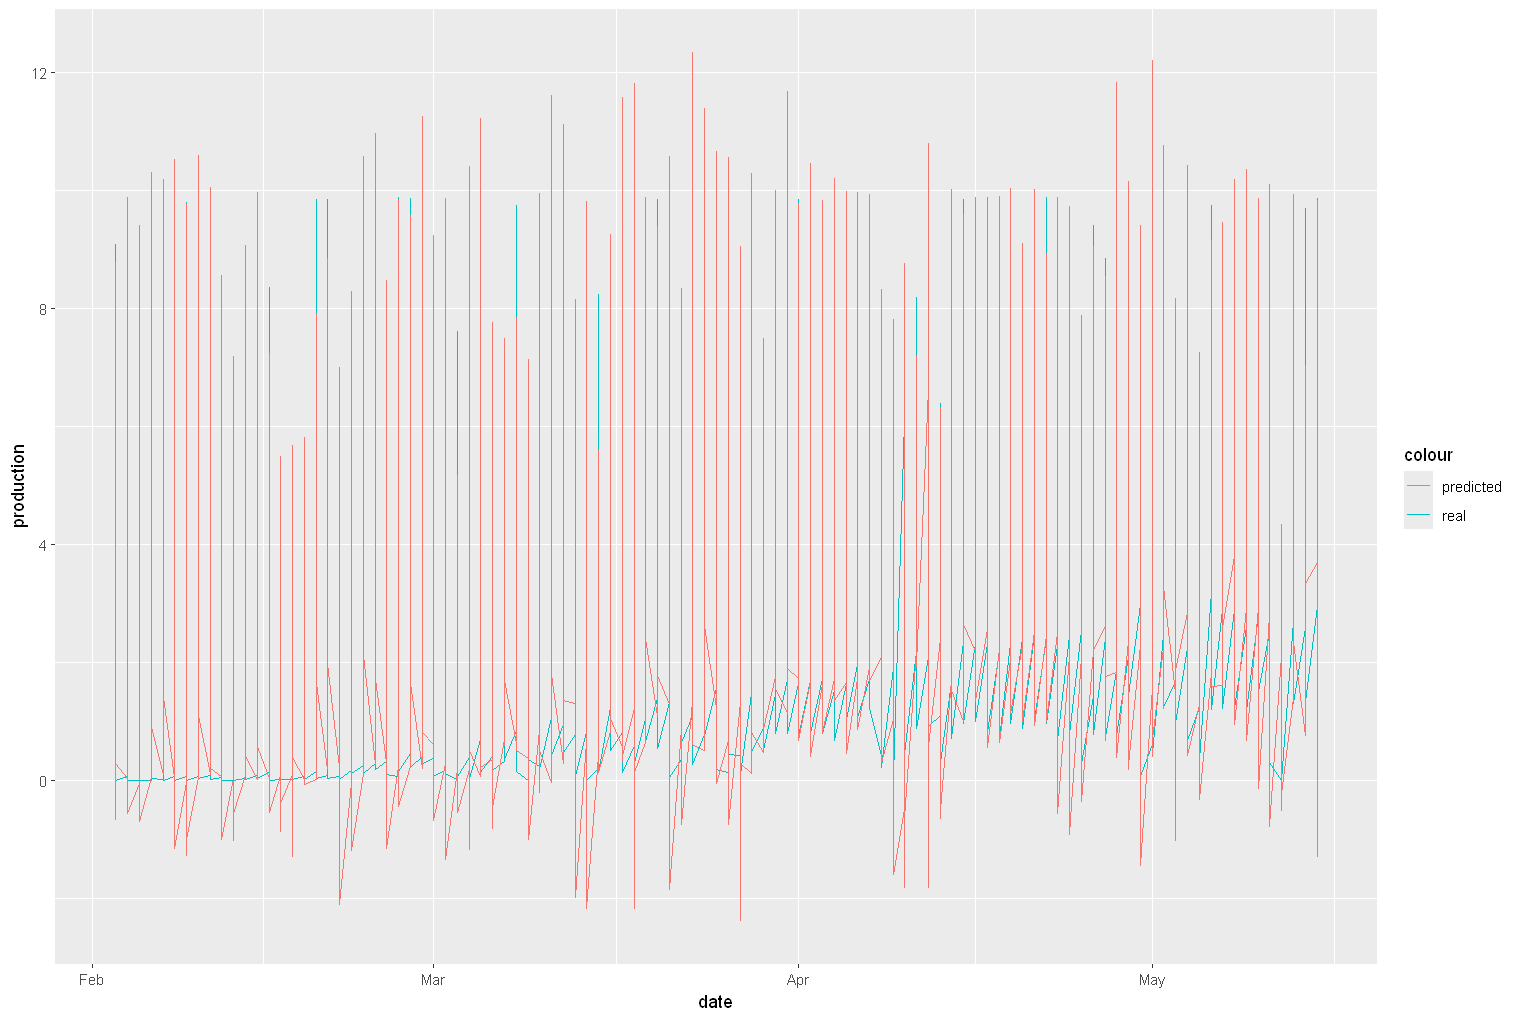

In [112]:
train_model <- Arima(filtered_data$diff, order = c(2, 0, 1))
test_data[,diff:=production - prod_lag_24]

predictions <- numeric(nrow(test_data))

for (i in 1:nrow(test_data)) {
  # Generate forecast for the next step using the model
  forecast_step <- forecast(train_model, h = 1)
  
  # Store the forecasted value
  predictions[i] <- forecast_step$mean

  new_data <- c(filtered_data$diff, test_data$diff[1:i])
  
  # Refit the model to include the new data
  train_model <- Arima(new_data, order = c(2, 0, 1))
}

sixth_model_evaluation <- copy(test_data)
sixth_model_evaluation[,predicted:= prod_lag_24 + predictions]

ggplot(sixth_model_evaluation,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))


	Ljung-Box test

data:  Residuals
Q* = 53.126, df = 10, p-value = 7.056e-08

Model df: 0.   Total lags used: 10



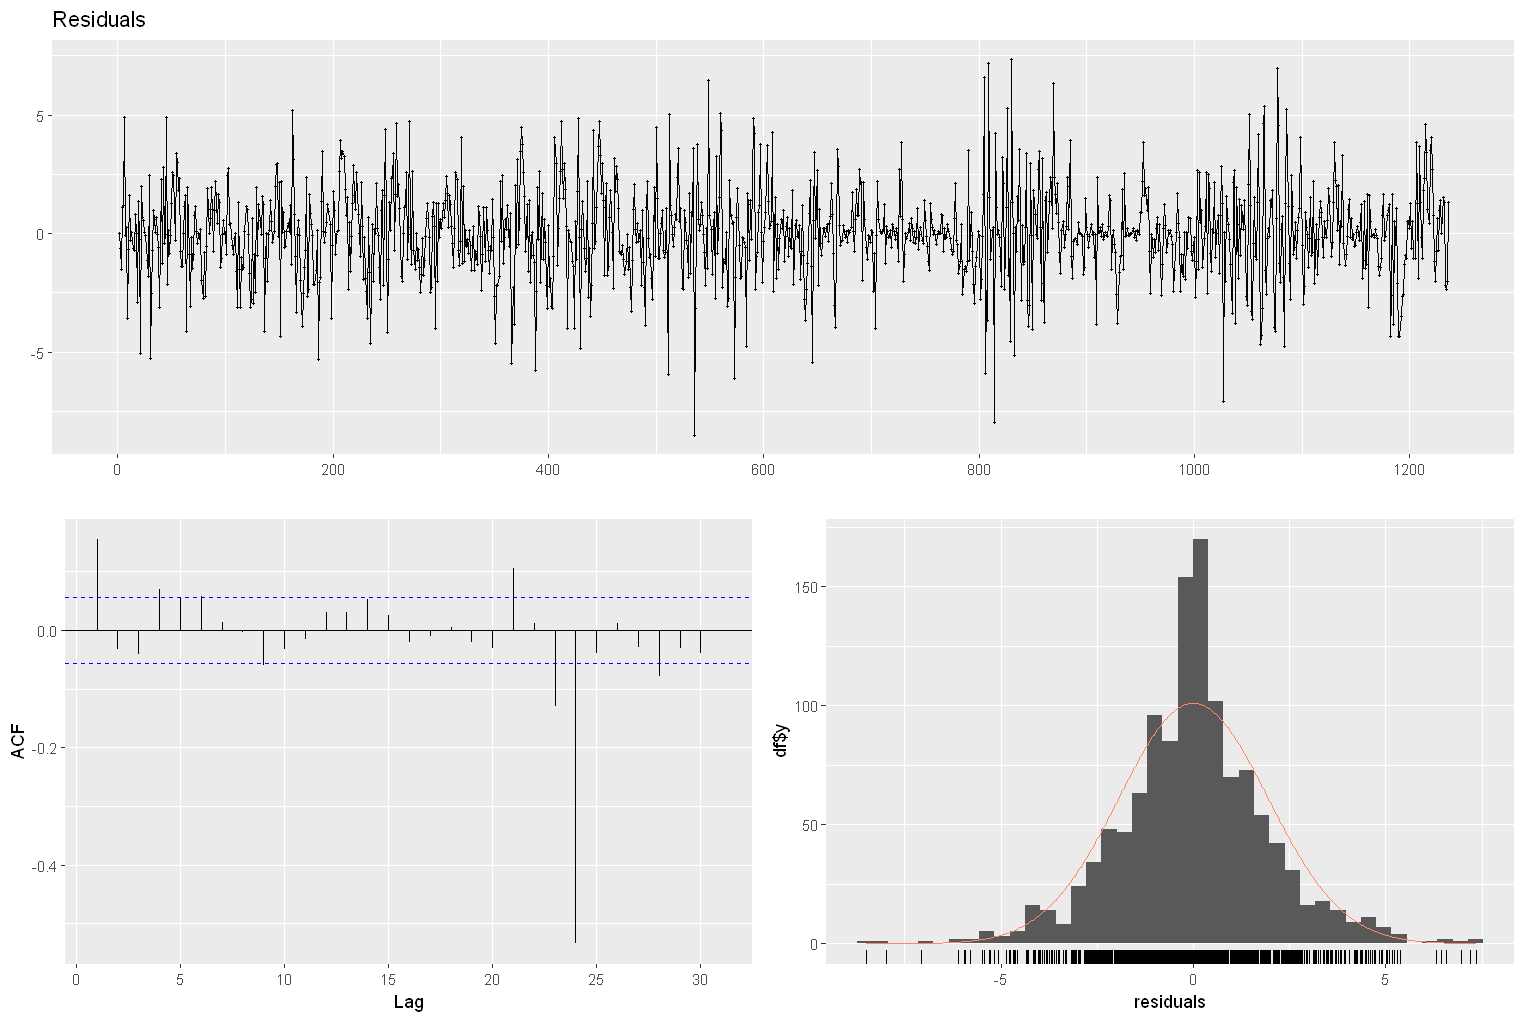

In [113]:
sixth_model_evaluation[,residual:=production-predicted]
checkresiduals(sixth_model_evaluation$residual)

In [114]:
accu6 <- accu("6. ARIMA for overall (IM)", sixth_model_evaluation$production, sixth_model_evaluation$predicted)
comparisons <- rbind(comparisons, accu6)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.1048254650,4469.314,1.993499,1.564115,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.1088095279,4058.146,1.994581,1.573241,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.0745083684,4407.538,1.908707,1.505325,0.2984292,0.2984292
3. Lasso(1sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0809165157,4201.848,1.906118,1.493561,0.2954455,0.2954455
4. Lasso(3sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0991611324,4422.851,1.946731,1.549387,0.3064887,0.3064887
5. ARIMA for each hour,1236,5.055283,3.381461,0.6688964,0.0007428499,6006.657,2.373454,1.752375,0.3466422,0.3466422
6. ARIMA for overall (IM),1236,5.055283,3.381461,0.6688964,0.0012032262,3022.291,1.935345,1.408278,0.2785754,0.2785754


# Conclusion

We will select the third model since it has the lowest WMAPE among the practical models. Let's add the hours that we predict as 0 to the third model, and report the real error measures.

In [116]:
head(third_model_evaluation)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,hour_transformed,prod_lag_24,prod_lag_36,max_production,avg_tmp,avg_temp_lag_1,avg_temp_lag_2,avg_temp_lag_3,predicted,residual
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-02-03,6,0,0,0,0,0,0,0,0,⋯,-36,0.01,0.01,9.89,268.3936,273.6110,276.8230,278.8880,0.04655828,-0.03655828
2024-02-03,7,0,0,0,0,0,0,0,0,⋯,-25,1.59,0.79,9.89,268.4030,268.3936,273.6110,276.8230,1.57428819,-0.63428819
2024-02-03,8,0,0,0,0,0,0,0,0,⋯,-16,6.17,5.60,9.89,268.9020,268.4030,268.3936,273.6110,4.00077012,0.20922988
2024-02-03,9,0,0,0,0,0,0,0,0,⋯,-9,7.11,8.86,9.89,271.7370,268.9020,268.4030,268.3936,5.78179162,1.04820838
2024-02-03,10,0,0,0,0,0,0,0,0,⋯,-4,5.20,9.89,9.88,275.0200,271.7370,268.9020,268.4030,7.46486361,-1.35486361
2024-02-03,11,0,0,0,0,0,0,0,0,⋯,-1,3.53,9.85,9.88,277.6590,275.0200,271.7370,268.9020,7.47106941,1.61893059


In [127]:
data_path <- 'real_new_data_16may.csv'

data <- fread(data_path)
colnames(data) <- tolower(colnames(data))

cutoff_date <- as.IDate("2024-02-02")
data <- data[date > cutoff_date]

data <- na.omit(data)
head(data)
tail(data)
str(data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_34.75,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-02-03,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,3,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,5,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_34.75,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-05-15,18,0,0,0,0,0,0,0,0,⋯,219.392,298.160,280.688,216.688,189.520,202.000,204.784,236.160,217.920,0
2024-05-15,19,0,0,0,0,0,0,0,0,⋯,192.144,251.104,236.976,196.496,166.032,178.864,183.488,208.976,193.216,0
2024-05-15,20,0,0,0,0,0,0,0,0,⋯,159.104,205.536,194.096,161.504,138.688,148.656,151.904,171.792,159.040,0
2024-05-15,21,0,0,0,0,0,0,0,0,⋯,132.576,171.280,161.728,134.592,115.568,123.872,126.592,143.152,132.528,0
2024-05-15,22,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
2024-05-15,23,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0


Classes 'data.table' and 'data.frame':	2472 obs. of  253 variables:
 $ date                               : IDate, format: "2024-02-03" "2024-02-03" ...
 $ hour                               : int  0 1 2 3 4 5 6 7 8 9 ...
 $ csnow_surface_37.75_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_34.75          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.0           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.25          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_37.75_35.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_34.75           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.0            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.25           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.0_35.5            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38.25_34.5           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ csnow_surface_38

In [128]:
data$predicted <- 0
head(data)

date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,predicted
<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-02-03,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,3,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2024-02-03,5,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [129]:
data <- as.data.frame(data)
merged_data <- merge(data, third_model_evaluation[, c("date", "hour", "predicted")], by = c("date", "hour"), all.x = TRUE)

In [130]:
# View the merged dataframe
head(merged_data,24)

,date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,predicted.x,predicted.y
,<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-02-03,0,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
2,2024-02-03,1,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
3,2024-02-03,2,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
4,2024-02-03,3,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
5,2024-02-03,4,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
6,2024-02-03,5,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0,NA
7,2024-02-03,6,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.01,0,0.04655828
8,2024-02-03,7,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.94,0,1.57428819
9,2024-02-03,8,0,0,0,0,0,0,0,0,⋯,0.480,0.656,0.256,0.320,0.384,0.448,0.528,4.21,0,4.00077012


In [131]:
# Assuming merged_data is your merged dataframe
merged_data$predicted <- ifelse(is.na(merged_data$predicted.y), merged_data$predicted.x, merged_data$predicted.y)

# Remove predicted.x and predicted.y columns
merged_data <- subset(merged_data, select = -c(predicted.x, predicted.y))

# View the updated dataframe
head(merged_data,24)


,date,hour,csnow_surface_37.75_34.5,csnow_surface_37.75_34.75,csnow_surface_37.75_35.0,csnow_surface_37.75_35.25,csnow_surface_37.75_35.5,csnow_surface_38.0_34.5,csnow_surface_38.0_34.75,csnow_surface_38.0_35.0,⋯,uswrf_top_of_atmosphere_38.5_35.0,uswrf_top_of_atmosphere_38.5_35.25,uswrf_top_of_atmosphere_38.5_35.5,uswrf_top_of_atmosphere_38.75_34.5,uswrf_top_of_atmosphere_38.75_34.75,uswrf_top_of_atmosphere_38.75_35.0,uswrf_top_of_atmosphere_38.75_35.25,uswrf_top_of_atmosphere_38.75_35.5,production,predicted
,<IDate>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-02-03,0,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
2,2024-02-03,1,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
3,2024-02-03,2,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
4,2024-02-03,3,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
5,2024-02-03,4,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
6,2024-02-03,5,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00000000
7,2024-02-03,6,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.01,0.04655828
8,2024-02-03,7,0,0,0,0,0,0,0,0,⋯,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.94,1.57428819
9,2024-02-03,8,0,0,0,0,0,0,0,0,⋯,0.416,0.480,0.656,0.256,0.320,0.384,0.448,0.528,4.21,4.00077012


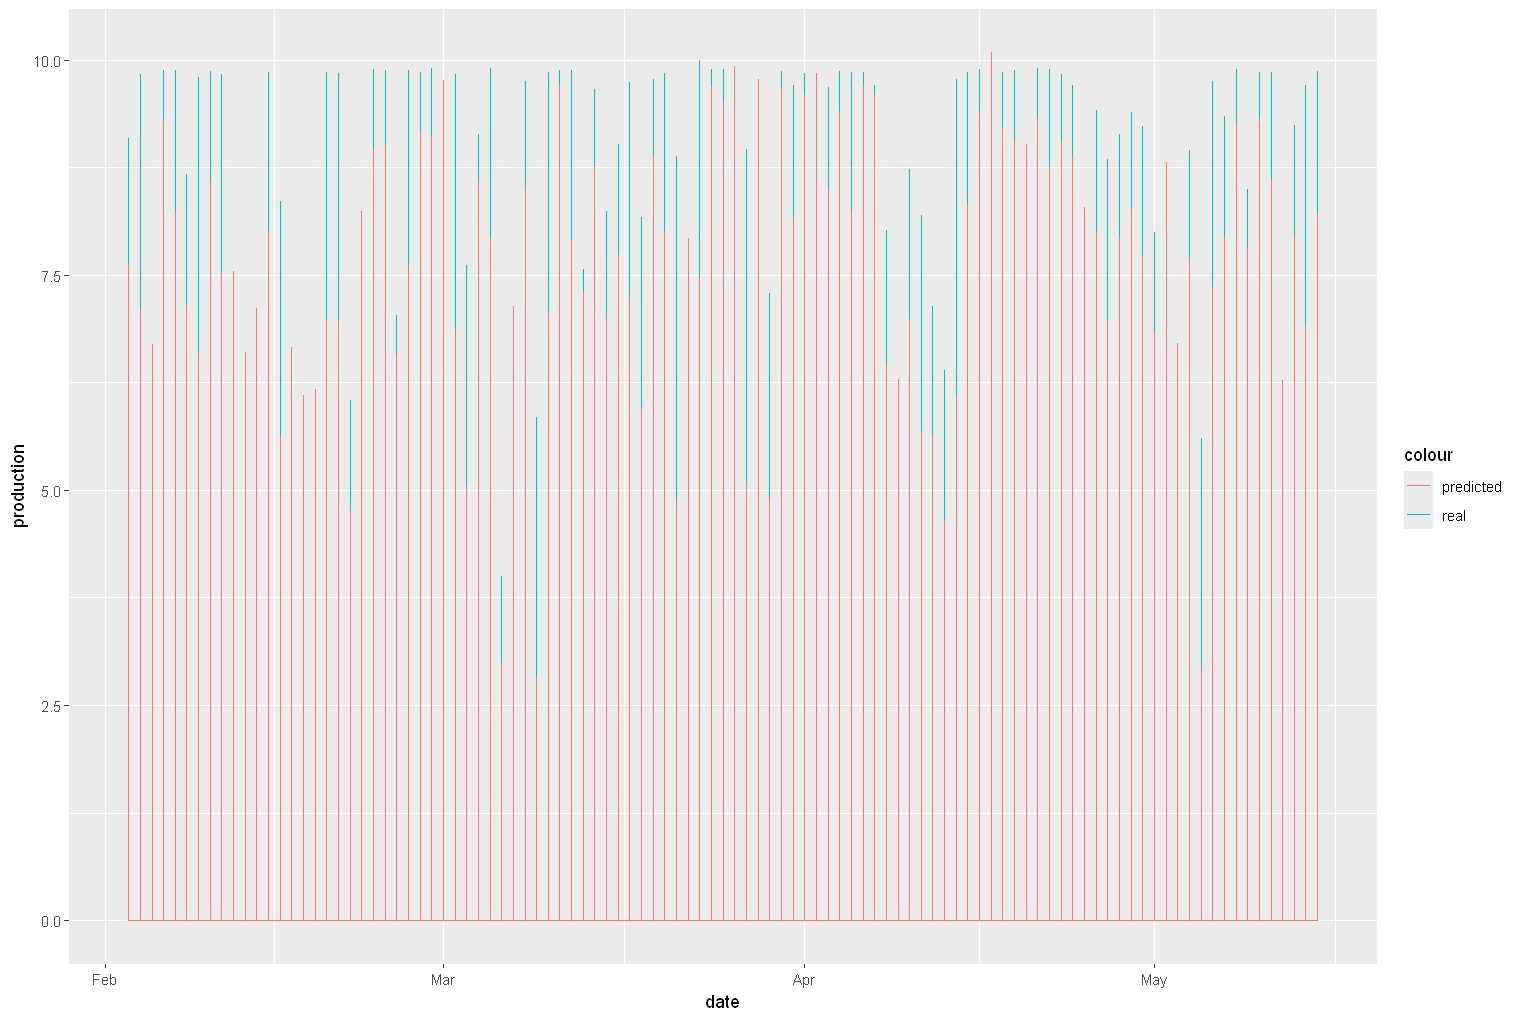


	Ljung-Box test

data:  Residuals
Q* = 1426.1, df = 10, p-value < 2.2e-16

Model df: 0.   Total lags used: 10



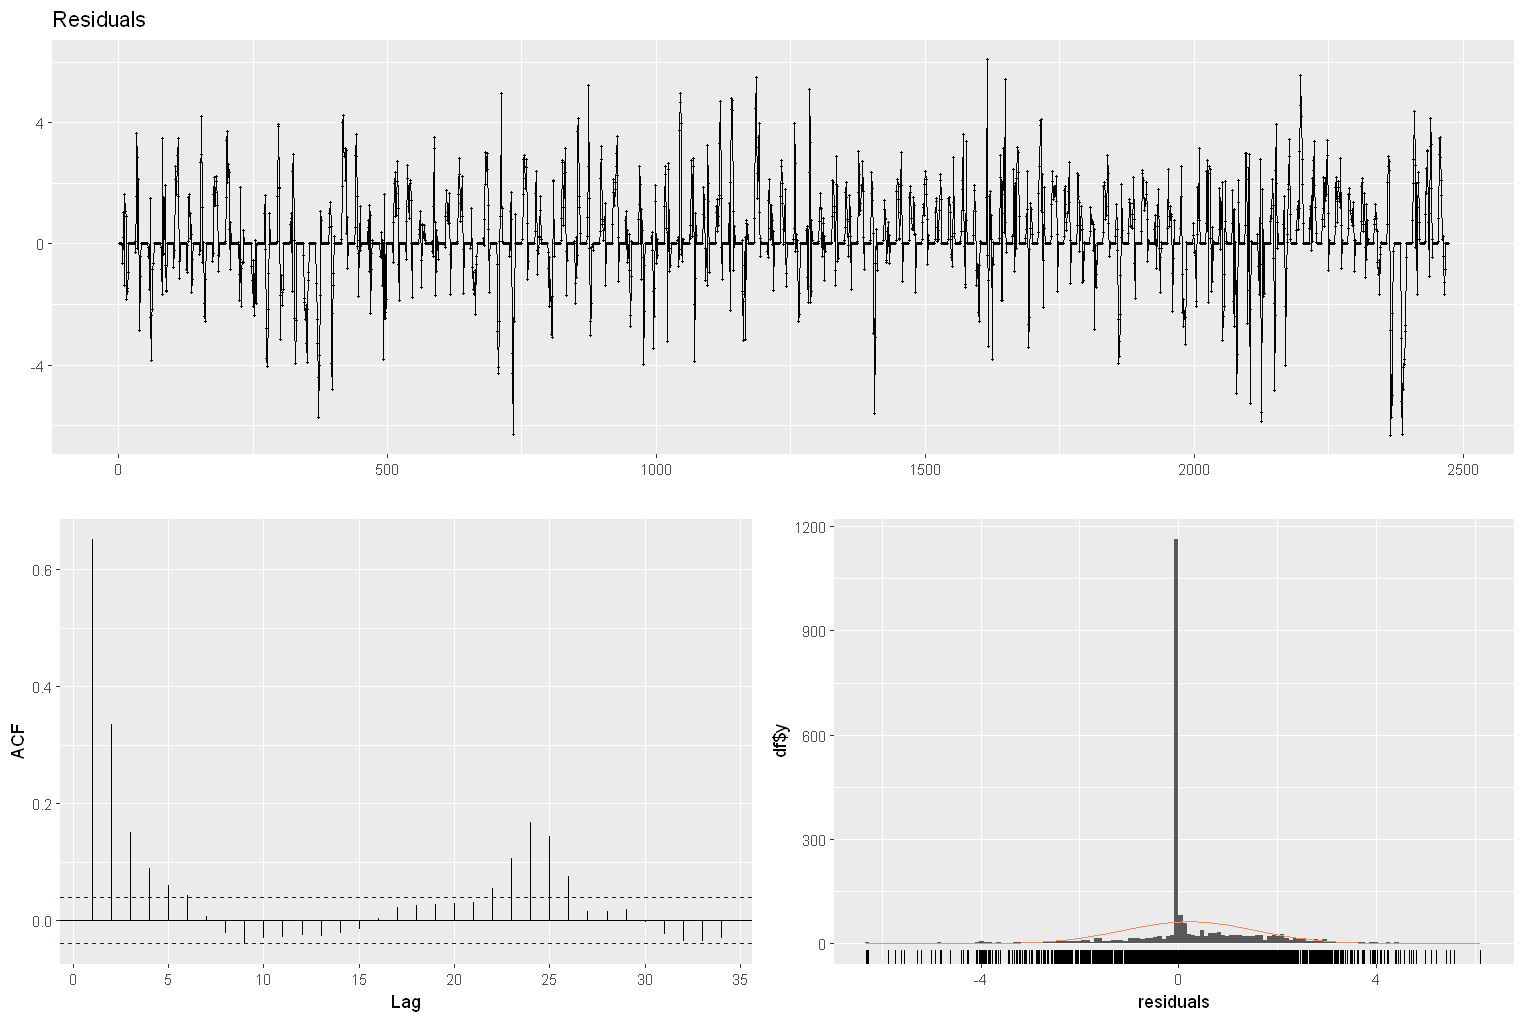

In [133]:
ggplot(merged_data,aes(x=date)) + geom_line(aes(y=production,color='real')) + geom_line(aes(y=predicted,color='predicted'))

setDT(merged_data)
merged_data[,residual:=production-predicted]
checkresiduals(merged_data$residual)

In [134]:
accu7 <- accu("Final Model (3rd model with all hours)", merged_data$production, merged_data$predicted)
comparisons <- rbind(comparisons, accu7)
comparisons

model,n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0. Baseline-LM,1269,5.060165,3.389830,0.6699049,0.1048254650,4469.314,1.993499,1.5641154,0.3091036,0.3091036
1. Lasso(1sd)-LM,1269,5.060165,3.389830,0.6699049,0.1088095279,4058.146,1.994581,1.5732406,0.3109070,0.3109070
2. Lasso(1sd) - LM_lag10 (IM),1262,5.044160,3.386026,0.6712765,0.0745083684,4407.538,1.908707,1.5053248,0.2984292,0.2984292
3. Lasso(1sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0809165157,4201.848,1.906118,1.4935608,0.2954455,0.2954455
4. Lasso(3sd)-LM_lag24_lag36,1236,5.055283,3.381461,0.6688964,0.0991611324,4422.851,1.946731,1.5493871,0.3064887,0.3064887
5. ARIMA for each hour,1236,5.055283,3.381461,0.6688964,0.0007428499,6006.657,2.373454,1.7523747,0.3466422,0.3466422
6. ARIMA for overall (IM),1236,5.055283,3.381461,0.6688964,0.0012032262,3022.291,1.935345,1.4082776,0.2785754,0.2785754
Final Model (3rd model with all hours),2472,2.537112,3.473294,1.3689953,0.0843471019,2100.963,1.349820,0.7562505,0.2980754,0.2980754
